In [944]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Problem Statement**
*ElecKart is an e-commerce firm based out of Ontario, Canada specialising in electronic products. Over the last one year, they had spent a significant amount of money on marketing. Occasionally, they had also offered big-ticket promotions (similar to the Big Billion Day). They are about to create a marketing budget for the next year, which includes spending on commercials, online campaigns, and pricing & promotion strategies. The CFO feels that the money spent over the last 12 months on marketing was not sufficiently impactful, and, that they can either cut on the budget or reallocate it optimally across marketing levers to improve the revenue response.*

**Objective**:
*You need to develop a market mix model to observe the actual impact of different marketing variables over the last year. Using your understanding of the model, you have to recommend the optimal budget allocation for different marketing levers for the next year.*

# Step 1: Importing Required Packages

In [945]:
# import libraries
import pandas as pd
import numpy as np

In [946]:
# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')



In [947]:
# Pandas Settings
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_rows', 40000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [948]:

# Miscellaneous imports
from datetime import datetime
from scipy.stats import norm
import re

In [949]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
import sklearn

# Step 2: Reading the Data

In [950]:
consumerelec_df = pd.read_csv('/content/drive/MyDrive/ASSIGNEMNT/ConsumerElectronics.csv')

consumerelec_df.head()

fsn_id           order_date  Year  Month           order_id      order_item_id   gmv  units deliverybdays deliverycdays s1_fact.order_payment_type  sla                 cust_id                 pincode product_analytic_super_category product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla
0  ACCCX3S58G7B5F6P  2015-10-17 15:11:54  2015     10 3419300926147000.0 3419300926147000.0  6400      1            \N            \N                        COD    5  -1.01299130778588E+018  -7.79175582905735E+018                              CE           CameraAccessory               CameraAccessory              CameraTripod         7190                        0
1  ACCCX3S58G7B5F6P  2015-10-19 10:07:22  2015     10 1420830839915200.0 1420830839915200.0  6900      1            \N            \N                        COD    7  -8.99032457905512E+018   7.33541149097431E+018                              CE           CameraAccessory               CameraAccessory              CameraTripod         7190                        0
2  ACCCX3S5AHMF55FV  2015-10-20 15:45:56  2015     10 2421912925714800.0 2421912925714800.0  1990      1            \N            \N                        COD   10   -1.0404429420466E+018  -7.47768776228657E+018                              CE           CameraAccessory               CameraAccessory              CameraTripod         2099                        3
3  ACCCX3S5AHMF55FV  2015-10-14 12:05:15  2015     10 4416592101738400.0 4416592101738400.0  1690      1            \N            \N                    Prepaid    4  -7.60496084352714E+018  -5.83593163877661E+018                              CE           CameraAccessory               CameraAccessory              CameraTripod         2099                        3
4  ACCCX3S5AHMF55FV  2015-10-17 21:25:03  2015     10 4419525153426400.0 4419525153426400.0  1618      1            \N            \N                    Prepaid    6    2.8945572083453E+018   5.34735360997242E+017                              CE           CameraAccessory               CameraAccessory              CameraTripod         2099                        3

##### Understanding some attributes

SKU => Stock Keeping Unit

deliverybdays => days to get item or order from warehouse for shipping

deliverycdays => days to deliver item to customer

# Step 3: Understanding the Data and Cleaning it

In [951]:
consumerelec_df.shape

(1648824, 20)

In [952]:
consumerelec_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   fsn_id                           1648824 non-null  object 
 1   order_date                       1648824 non-null  object 
 2   Year                             1648824 non-null  int64  
 3   Month                            1648824 non-null  int64  
 4   order_id                         1648824 non-null  float64
 5   order_item_id                    1648824 non-null  float64
 6   gmv                              1648824 non-null  object 
 7   units                            1648824 non-null  int64  
 8   deliverybdays                    1648824 non-null  object 
 9   deliverycdays                    1648824 non-null  object 
 10  s1_fact.order_payment_type       1648824 non-null  object 
 11  sla                              1648824 non-null 

## Correcting Data Types

In [953]:
#convert order_date(string) to datetime
consumerelec_df['order_date'] = pd.to_datetime(consumerelec_df['order_date'], format='%Y-%m-%d %H:%M:%S')

In [954]:
consumerelec_df['order_date'].dtype


dtype('<M8[ns]')

In [955]:
#Sort values by order_date
consumerelec_df=consumerelec_df.sort_values(by=['order_date'])

In [956]:
# check year and month 
print((consumerelec_df['order_date'].dt.year == consumerelec_df['Year']).sum())
print((consumerelec_df['order_date'].dt.month == consumerelec_df['Month']).sum())

1648824
1648824


### coverting order_id and order_item_id into suitable format


In [957]:
consumerelec_df['order_id'] = consumerelec_df['order_id'].map(lambda x : '{:.0f}'.format(x))
consumerelec_df['order_item_id'] = consumerelec_df['order_item_id'].map(lambda x : '{:.0f}'.format(x))

In [958]:
consumerelec_df.dtypes

fsn_id                                     object
order_date                         datetime64[ns]
Year                                        int64
Month                                       int64
order_id                                   object
order_item_id                              object
gmv                                        object
units                                       int64
deliverybdays                              object
deliverycdays                              object
s1_fact.order_payment_type                 object
sla                                         int64
cust_id                                    object
pincode                                    object
product_analytic_super_category            object
product_analytic_category                  object
product_analytic_sub_category              object
product_analytic_vertical                  object
product_mrp                                 int64
product_procurement_sla                     int64


In [959]:
consumerelec_df.head()

fsn_id          order_date  Year  Month   order_id order_item_id   gmv  units deliverybdays deliverycdays s1_fact.order_payment_type  sla                 cust_id                 pincode product_analytic_super_category product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla
1376093  ACCDVZ83VBHCWFFA 2015-05-19 13:42:09  2015      5  146499482     188485029  3149      1            \N            \N                        COD    6  -6.14850311678963E+018  -3.21775258155408E+018                              CE        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker         6990                        4
1436634  VGLE4VR7XSQKYFG7 2015-06-11 18:21:50  2015      6  155827856     198823138   275      1            \N            \N                        COD    8   1.58583155812679E+018  -3.70342091330123E+017                              CE        EntertainmentSmall                  TVVideoSmall              VideoGlasses          600                        2
1398258  ACCE6VGHYKYFX4WB 2015-06-24 10:20:16  2015      6  161931009     205976637   188      1            \N            \N                        COD    8  -4.88207864623487E+018   2.04427084691886E+018                              CE        EntertainmentSmall                       Speaker             LaptopSpeaker          310                       -1
1385002  ACCE2V5DUDZVGFRK 2015-06-25 16:28:12  2015      6  163016530     207267972   250      1            \N            \N                        COD    7  -4.27261305168723E+018   6.14822284391839E+018                              CE        EntertainmentSmall                       Speaker             LaptopSpeaker          400                        4
1358453  ACCDFZEJ6ZGSWRMK 2015-06-26 17:02:01  2015      6  163400507     207701702  1119      1            \N            \N                        COD   28  -7.47222175673193E+018    -9.779010321304E+017                              CE        EntertainmentSmall                       Speaker             LaptopSpeaker         2500                        3

### Fix Data Types

##### Assuming "\N" value in deliverybdays & deliverycdays is equal to 0, will impute the nulls created by it with 0

In [960]:
consumerelec_df['deliverybdays'] = pd.to_numeric(consumerelec_df['deliverybdays'], errors='coerce')
consumerelec_df['deliverybdays'].fillna(value=0, inplace=True)

consumerelec_df['deliverycdays'] = pd.to_numeric(consumerelec_df['deliverycdays'], errors='coerce')
consumerelec_df['deliverycdays'].fillna(value=0, inplace=True)

Treating incorrect GMV values w.r.t product_mrp * units


In [961]:
# String to int

consumerelec_df['gmv'] = pd.to_numeric(consumerelec_df['gmv'], errors='coerce')

In [962]:
# Unique value frequencies

unique_values = pd.DataFrame(consumerelec_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)

unique_values['dtype'] = pd.DataFrame(consumerelec_df.dtypes)

unique_values

Unique Value Count           dtype
product_analytic_super_category                   1          object
Year                                              2           int64
s1_fact.order_payment_type                        2          object
product_analytic_category                         5          object
Month                                            12           int64
product_analytic_sub_category                    14          object
product_procurement_sla                          17           int64
units                                            27           int64
sla                                              60           int64
product_analytic_vertical                        74          object
deliverybdays                                   142         float64
deliverycdays                                   170         float64
product_mrp                                    1929           int64
gmv                                           12524         float64
pincode                                       12973          object
fsn_id                                        21219          object
order_date                                  1155192  datetime64[ns]
cust_id                                     1253495          object
order_item_id                               1480765          object
order_id                                    1501177          object

In [963]:
initial_shape = consumerelec_df.shape
initial_shape

(1648824, 20)

In [964]:
# Instances where GMV values are greater than MRP * units which is incorrect

print(consumerelec_df.loc[consumerelec_df['product_mrp'] * consumerelec_df['units'] < consumerelec_df['gmv']].shape[0])

print(round(100*(consumerelec_df.loc[consumerelec_df['product_mrp'] * consumerelec_df['units'] < consumerelec_df['gmv']].shape[0] / consumerelec_df.shape[0]), 2))

38569
2.34


Impute the faulty mrp values with gmv/units


In [965]:
# update column based on another column
consumerelec_df.product_mrp = np.where(consumerelec_df['product_mrp'] < consumerelec_df['gmv'] / consumerelec_df['units'], \
                                   consumerelec_df['gmv'] / consumerelec_df['units'], consumerelec_df['product_mrp'])

consumerelec_df.shape

(1648824, 20)

Reinspect instance, where GMV value is higher than the MRP * units.



In [966]:
# Instances where GMV values are greater than MRP * units which is incorrect

print(consumerelec_df.loc[consumerelec_df['product_mrp'] * consumerelec_df['units'] < consumerelec_df['gmv']].shape[0])

print(round(100*(consumerelec_df.loc[consumerelec_df['product_mrp'] * consumerelec_df['units'] < consumerelec_df['gmv']].shape[0] / consumerelec_df.shape[0]), 2))

0
0.0


Treating GMV values less than 0

In [967]:
print(consumerelec_df.loc[consumerelec_df['gmv'] < 0].shape[0])

print(round(100*(consumerelec_df.loc[consumerelec_df['gmv'] < 0].shape[0]/consumerelec_df.shape[0]), 2))

0
0.0


Handling Negative values for deliverybdays & deliverycdays


In [968]:
print(consumerelec_df.loc[consumerelec_df['deliverybdays'] < 0].shape[0])
print(round(100*(consumerelec_df.loc[consumerelec_df['deliverybdays'] < 0].shape[0]/consumerelec_df.shape[0]),4))

print(consumerelec_df.loc[consumerelec_df['deliverycdays'] < 0].shape[0])
print(round(100*(consumerelec_df.loc[consumerelec_df['deliverycdays'] < 0].shape[0]/consumerelec_df.shape[0]),4))

38
0.0023
39
0.0024


 - There are `38` records(`0.0023%`) in the dataframe with negative values for deliverybdays.
 - There are `39` records(`0.0024%`) in the dataframe with negative values for deliverycdays.
 
We will be dropping such rows since it is not possible for a product to have negative values for Dispatch Delay from Warehouse and to customer.

In [969]:
consumerelec_df = consumerelec_df.loc[(consumerelec_df['deliverybdays'] >= 0) & (consumerelec_df['deliverycdays'] >= 0)]

consumerelec_df.reset_index(drop=True, inplace=True)

In [970]:
consumerelec_df.shape

(1648785, 20)

Treating MRP values less than or equal to 0


In [971]:
print(consumerelec_df.loc[consumerelec_df['product_mrp'] < 0].shape[0])

print(round(100*(consumerelec_df.loc[consumerelec_df['product_mrp'] < 0].shape[0]/consumerelec_df.shape[0]), 2))

0
0.0


Treating Units values less than or equal to 0

In [972]:
print(consumerelec_df.loc[consumerelec_df['units'] <= 0].shape[0])

print(round(100*(consumerelec_df.loc[consumerelec_df['units'] <= 0].shape[0]/consumerelec_df.shape[0]), 2))

0
0.0


### Handling Negative values for product_procurement_sla

In [973]:
print(consumerelec_df.loc[consumerelec_df['product_procurement_sla'] < 0].shape[0])

print(round(100*(consumerelec_df.loc[consumerelec_df['product_procurement_sla'] < 0].shape[0]/consumerelec_df.shape[0]),4))

75986
4.6086


There are 75986 records (4.61 percent) for product procurement sla in the dataframe with negative values. We will drop these rows as it is not feasible for a product to have negative values typically required for time to procure it.

In [974]:
consumerelec_df = consumerelec_df.loc[(consumerelec_df['product_procurement_sla'] >= 0)]

consumerelec_df.reset_index(drop=True, inplace=True)

In [975]:
consumerelec_df.shape

(1572799, 20)

Handling of high product_procurement_sla values


In [976]:
consumerelec_df[['product_procurement_sla']].describe().T


count  mean  std  min  25%  50%  75%    max
product_procurement_sla 1572799.0   5.7 54.7  0.0  2.0  2.0  3.0 1000.0

In [977]:
consumerelec_df.product_procurement_sla.value_counts()


2       528406
1       308504
3       303349
5       222097
4       120190
0        42459
6        18559
7        11746
15        6184
14        5281
1000      4745
13         526
8          523
9           97
10          73
12          60
Name: product_procurement_sla, dtype: int64

In [978]:
#Let's check for product_procurement_sla
len(consumerelec_df.loc[consumerelec_df.product_procurement_sla > 60])

4745

In [979]:
#Let's check for product_procurement_sla
len(consumerelec_df.loc[consumerelec_df.product_procurement_sla > 20])

4745

In [980]:
#Let's check for product_procurement_sla
len(consumerelec_df.loc[consumerelec_df.product_procurement_sla > 15])

4745

As we can see above, the number of rows have product procuremnt sla greater than 15 & even greater than 60 are same which means there are no rows containing product_procurement_sla b/w 15 & 60



In [981]:
# Cap the product_procurement_sla less than equal to 15
consumerelec_df =consumerelec_df.loc[consumerelec_df.product_procurement_sla <=15 ]

In [982]:
#Capping the sla to 30 days, as more than 30 days is not practically acceptable

# checking if any data with sla greater than 30 days is present
consumerelec_df.loc[consumerelec_df.sla>30]


fsn_id          order_date  Year  Month          order_id       order_item_id    gmv  units  deliverybdays  deliverycdays s1_fact.order_payment_type   sla                 cust_id                 pincode product_analytic_super_category product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla
313169   REME5WEWPDF7GYBQ 2015-10-10 23:53:40  2015     10  4413562981700500    4413562981700500  595.0      1            0.0            0.0                        COD    37   5.84374121513524E+018   8.90368290512901E+018                              CE        EntertainmentSmall                  TVVideoSmall             RemoteControl        649.0                        2
316365   REME5WEWDHE3PGEZ 2015-10-12 10:47:40  2015     10  2414819225948000    2414819225948000  369.0      1            0.0            0.0                        COD    38  -4.33141150989262E+018   6.14822284391839E+018                              CE        EntertainmentSmall                  TVVideoSmall             RemoteControl        399.0                        3
344961   REME5WEWDHE3PGEZ 2015-10-15 16:48:41  2015     10  1417565272118500    1417565272118500  399.0      1            0.0            0.0                        COD    39  -3.52141298621075E+018  -4.63284855724529E+018                              CE        EntertainmentSmall                  TVVideoSmall             RemoteControl        399.0                        3
419299   REME5WEWDHE3PGEZ 2015-10-18 10:10:33  2015     10  2419982860867300    2419982860867300  399.0      1            0.0            0.0                    Prepaid    39   1.53434551349732E+017   6.30583603901881E+018                              CE        EntertainmentSmall                  TVVideoSmall             RemoteControl        399.0                        3
427163   REME5WEWNKHZYVA2 2015-10-20 09:18:05  2015     10  1421679822007000    1421679822007000  549.0      1            0.0            0.0                        COD    38   -3.1680924703478E+018  -7.89894541987469E+018                              CE        EntertainmentSmall                  TVVideoSmall             RemoteControl        549.0                        2
455069   ACCEAU5FH5ESHZDJ 2015-10-27 19:36:15  2015     10  1428099375455100    1428099375455100 1499.0      1            0.0            0.0                        COD    33  -5.17949734261349E+018    7.1611979686793E+018                              CE        EntertainmentSmall                       Speaker             MobileSpeaker       2999.0                        1
458562   ACCEAU5FH5ESHZDJ 2015-10-28 14:24:10  2015     10  1428769621577400    1428769621577400 1499.0      1            0.0            0.0                        COD    40  -6.60577615254366E+018   6.92189628600253E+018                              CE        EntertainmentSmall                       Speaker             MobileSpeaker       2999.0                        1
459646   ACCEAU5FH5ESHZDJ 2015-10-28 18:22:10  2015     10  4428920131167500    4428920131167500 1499.0      1            0.0            0.0                        COD    40   4.58211389405397E+018   1.72952878353497E+018                              CE        EntertainmentSmall                       Speaker             MobileSpeaker       2999.0                        1
461753   ACCEAU5FH5ESHZDJ 2015-10-29 02:00:48  2015     10  1429195019456700    1429195019456700 1499.0      1            0.0            0.0                        COD    39   4.65952044831334E+018   6.73417398304557E+018                              CE        EntertainmentSmall                       Speaker             MobileSpeaker       2999.0                        1
467767   ACCE99BYQKMYXB6N 2015-10-30 18:16:02  2015     10  1430640928558600    1430640928558600 1059.0      1            0.0            0.0                        COD    41  -4.23365304829026E+018   5.79559800949951E+018                              CE        EntertainmentSmall

In [983]:
#Remove rows with SLA greater than 30
consumerelec_df = consumerelec_df.loc[consumerelec_df.sla<=30]

In [984]:
#checking missing values
consumerelec_df.isnull().sum()

fsn_id                                0
order_date                            0
Year                                  0
Month                                 0
order_id                              0
order_item_id                         0
gmv                                4519
units                                 0
deliverybdays                         0
deliverycdays                         0
s1_fact.order_payment_type            0
sla                                   0
cust_id                               0
pincode                               0
product_analytic_super_category       0
product_analytic_category             0
product_analytic_sub_category         0
product_analytic_vertical             0
product_mrp                           0
product_procurement_sla               0
dtype: int64

In [985]:
#converting datatype for gmv
consumerelec_df['gmv'] = pd.to_numeric(consumerelec_df['gmv'])

In [986]:
# Drop rows containing null values for gmv
consumerelec_df.dropna(subset = ['gmv'], inplace = True)

In [987]:
consumerelec_df.isnull().sum()

fsn_id                             0
order_date                         0
Year                               0
Month                              0
order_id                           0
order_item_id                      0
gmv                                0
units                              0
deliverybdays                      0
deliverycdays                      0
s1_fact.order_payment_type         0
sla                                0
cust_id                            0
pincode                            0
product_analytic_super_category    0
product_analytic_category          0
product_analytic_sub_category      0
product_analytic_vertical          0
product_mrp                        0
product_procurement_sla            0
dtype: int64

In [988]:
#Dropping rows containing nulls in the product_analytic_vertical column
consumerelec_df =consumerelec_df.loc[~pd.isnull(consumerelec_df['product_analytic_vertical'])]

In [989]:
#Renaming Columns
consumerelec_df=consumerelec_df.rename(columns={"s1_fact.order_payment_type": "order_payment_type"})

In [990]:
#Checking the various payment types
consumerelec_df['order_payment_type'].value_counts()

COD        1130149
Prepaid     433306
Name: order_payment_type, dtype: int64

In [991]:
consumerelec_df['product_analytic_super_category'].value_counts()

CE    1563455
Name: product_analytic_super_category, dtype: int64

The "product_analytic_super_category" Coloumn has all the CE values. That will therefore not contribute to the analysis and will therefore be removed



In [992]:
consumerelec_df=consumerelec_df.drop('product_analytic_super_category',axis=1)


In [993]:
#Drop cust_id, fsn_id and pincode as they won't contribute much
consumerelec_df=consumerelec_df.drop(['cust_id','pincode','fsn_id'],axis=1)

In [994]:
consumerelec_df.columns


Index(['order_date', 'Year', 'Month', 'order_id', 'order_item_id', 'gmv', 'units', 'deliverybdays', 'deliverycdays', 'order_payment_type', 'sla', 'product_analytic_category', 'product_analytic_sub_category', 'product_analytic_vertical', 'product_mrp', 'product_procurement_sla'], dtype='object')

In [995]:
consumerelec_df.isna().sum()

order_date                       0
Year                             0
Month                            0
order_id                         0
order_item_id                    0
gmv                              0
units                            0
deliverybdays                    0
deliverycdays                    0
order_payment_type               0
sla                              0
product_analytic_category        0
product_analytic_sub_category    0
product_analytic_vertical        0
product_mrp                      0
product_procurement_sla          0
dtype: int64

In [996]:
## Rows with remaining nulls can be removed as they relate to data of less than 1 percent and thus elimination will not impact the analysis
consumerelec_df=consumerelec_df.dropna()

In [997]:
consumerelec_df.shape

(1563455, 16)

### Checking Duplicates in the Data

In [998]:
consumerelec_df.duplicated().sum()


98733

In [999]:
 #Duplicates are removed because they only contribute 6% of the data and are therefore discarded.
consumerelec_df=consumerelec_df.drop_duplicates()

In [1000]:
consumerelec_df['order_item_id'].duplicated().sum()

57733

In [1001]:
#order_item_id duplicates are removed, as it should be unique
consumerelec_df.drop_duplicates(subset = ['order_item_id'], keep='last', inplace=True)

In [1002]:
consumerelec_df.shape

(1406989, 16)

In [1003]:
consumerelec_df.isna().sum()


order_date                       0
Year                             0
Month                            0
order_id                         0
order_item_id                    0
gmv                              0
units                            0
deliverybdays                    0
deliverycdays                    0
order_payment_type               0
sla                              0
product_analytic_category        0
product_analytic_sub_category    0
product_analytic_vertical        0
product_mrp                      0
product_procurement_sla          0
dtype: int64

In [1004]:
# Filtering the data for the 3 categories

consumerelec_df= consumerelec_df[(consumerelec_df['product_analytic_sub_category']=='GamingAccessory')|(consumerelec_df['product_analytic_sub_category']=='CameraAccessory')|(consumerelec_df['product_analytic_sub_category']=='HomeAudio')]


In [1005]:
# check  the length of dataframe
len(consumerelec_df)

488605

We now have 488609 data rows for the three categories to be further analyzed.


# Step 3(a):EDA PART

For 3 categories we have already filtered out the data, i.e. GamingAccessory, CameraAccessory & HomeAudio that we will use graphs to test



<AxesSubplot:xlabel='product_analytic_sub_category', ylabel='gmv'>

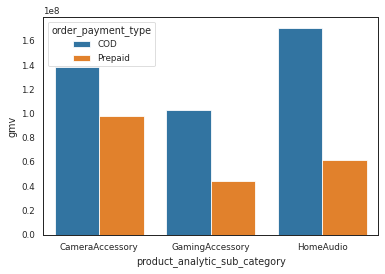

In [1006]:
#gmv is our target variable
GMV_Pay = consumerelec_df.groupby(["order_payment_type","product_analytic_sub_category"])['gmv'].sum().reset_index()
sns.barplot(x='product_analytic_sub_category', y='gmv', hue="order_payment_type", data=GMV_Pay)



*   Max revenue for COD order is from the class Home Audio followed by Camera
*   For prepaid orders, the maximum revenue is from Camera Accessory, followed by Home Audio and a slight decrease in the category of Gaming Accessories



<AxesSubplot:xlabel='product_analytic_sub_category', ylabel='transaction_count'>

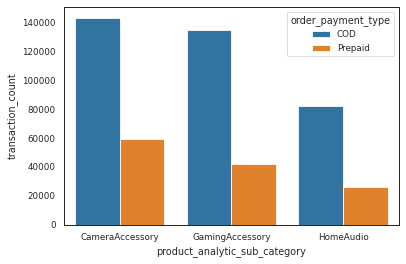

In [1007]:
## Order Count vs Payment Type
OC_Payment = consumerelec_df.groupby(["order_payment_type","product_analytic_sub_category"])['gmv'].count().reset_index().rename(columns={'gmv':'transaction_count'})
sns.barplot(x='product_analytic_sub_category', y='transaction_count', hue="order_payment_type", data=OC_Payment)


*   For Camera Accessory , maximum number of orders are by COD mode.
*   For Gaming Accesrsory , maximum orders are again from COD mode.
*   For Home Audio also, maimum orders are from COD mode.

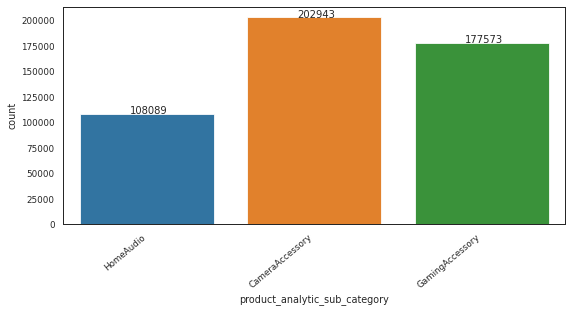

In [1008]:
# No of transactions by Sub-Category

plt.figure(figsize = (9,4))
ax = sns.countplot(consumerelec_df['product_analytic_sub_category'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.set_context(font_scale = 1.4)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+20))

Based on our analysis , maximum number of transaction were from Camera Accessory category, then Gaming Accessory , followed by Home Audio category



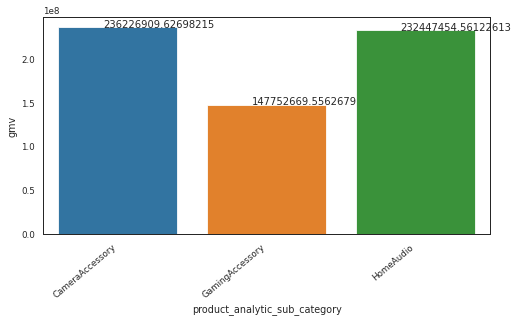

In [1009]:
## Total GMV by Sub-Category
plot_gmv =consumerelec_df.groupby('product_analytic_sub_category')['gmv'].sum().reset_index()
plt.figure(figsize = (8,4))
ax = sns.barplot(x='product_analytic_sub_category', y='gmv', data=plot_gmv)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.set_context(font_scale = 1.4)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+20))

The most number of transactions are for Camera Accessory followed by Home Audio & then Gamming Audio



<AxesSubplot:>

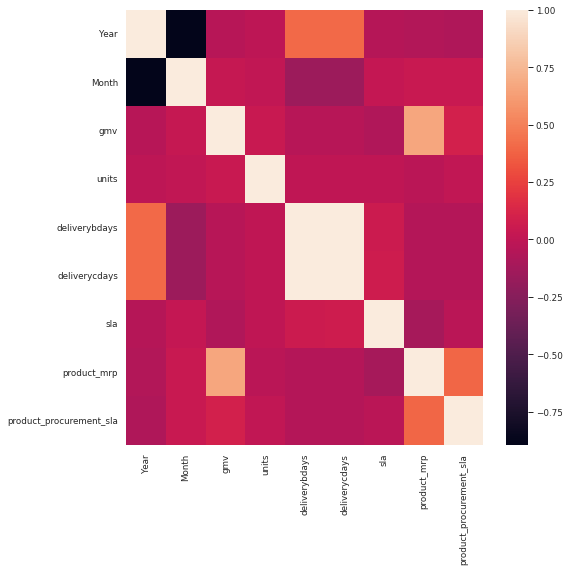

In [1010]:
## checking the correlations
plt.figure(figsize = (8,8))
sns.heatmap(consumerelec_df.corr())

As we can see above, Month & Year is highly correlated|

### Generate week column

In [1011]:
# Creating a new column into a specific position in a DataFrame
loc_index = consumerelec_df.columns.get_loc('Month') + 1
consumerelec_df.insert(loc=loc_index,column='Week',value=consumerelec_df['order_date'].dt.strftime("%V"))

consumerelec_df['Year'] = consumerelec_df['Year'].astype('str')
consumerelec_df.head()

order_date  Year  Month Week   order_id order_item_id    gmv  units  deliverybdays  deliverycdays order_payment_type  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla
0  2015-05-19 13:42:09  2015      5   21  146499482     188485029 3149.0      1            0.0            0.0                COD    6        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       6990.0                        4
4  2015-06-26 17:27:12  2015      6   26  163409423     207711935  350.0      1            0.0            0.0                COD    5           CameraAccessory               CameraAccessory           CameraAccessory        399.0                        3
5  2015-06-26 17:33:10  2015      6   26  163411313     207714163 2800.0      1            0.0            0.0                COD   11        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       3000.0                        3
8  2015-07-01 03:35:02  2015      7   27  165165918     209727476  385.0      1            0.0            0.0            Prepaid   10            GamingHardware               GamingAccessory               GamingMouse        699.0                        4
17 2015-07-01 08:19:18  2015      7   27  165181041     209744697 1999.0      1            0.0            0.0            Prepaid    1            GamingHardware               GamingAccessory                   GamePad       7999.0                        3

In [1012]:
# Updating the year as 2015 for the week of 53 but belonging to 2016 in accordance with the other data sets
# Updating the month to 12 for consistency in the above rows
# Dropping rows (less in number) with week# 27 as it belongs to the weeks in June 2015
consumerelec_df.loc[(consumerelec_df.Year == '2016') & (consumerelec_df.Week == '53'), 'Year'] = '2015'

consumerelec_df.loc[(consumerelec_df.Year == '2015') & (consumerelec_df.Week == '53'), 'Month'] = 12
consumerelec_df.drop(consumerelec_df[consumerelec_df['Week'] == '27'].index, inplace = True)

In [1013]:
consumerelec_df.groupby(['Year', 'Week']).agg({'Month':"count"}).reset_index(drop=False)


Year Week  Month
0   2015   21      1
1   2015   26      2
2   2015   28   7815
3   2015   29   8182
4   2015   30   7691
5   2015   31   5348
6   2015   32      9
7   2015   33      4
8   2015   34      2
9   2015   35      2
10  2015   36   4332
11  2015   37   3062
12  2015   38   7240
13  2015   39   7849
14  2015   40   9167
15  2015   41   7123
16  2015   42  28536
17  2015   43   8323
18  2015   44  10938
19  2015   45  12414
20  2015   46   9652
21  2015   47   7239
22  2015   48   8711
23  2015   49   9095
24  2015   50  11271
25  2015   51   9091
26  2015   52  12733
27  2015   53  10375
28  2016   01  12741
29  2016   02   9793
30  2016   03  12803
31  2016   04   9090
32  2016   05  12572
33  2016   06  10010
34  2016   07  14802
35  2016   08  12915
36  2016   09  12249
37  2016   10  14108
38  2016   11   9978
39  2016   12   9596
40  2016   13  10145
41  2016   14   9880
42  2016   15   8162
43  2016   16   4794
44  2016   17  17408
45  2016   18  11300
46  2016   19  11861
47  2016   20  11114
48  2016   21  13340
49  2016   22  10946
50  2016   23  10834
51  2016   24   9657
52  2016   25   7698
53  2016   26   4391
54  2016   28      7

Drop Insignificant Columns

In [1014]:
# Dropping Columns with Single Value or all Different Values

count_df = pd.DataFrame(consumerelec_df.apply(lambda x: len(x.value_counts()), axis=0), columns=['Count'])

drop_columns = list(count_df.loc[(count_df['Count']==1) | (count_df['Count']==len(consumerelec_df.index))].index)

print('Dropping these columns => {}'.format(drop_columns))

consumerelec_df.drop(drop_columns, axis=1, inplace=True)

Dropping these columns => ['order_item_id']


In [1015]:
consumerelec_df.head()

order_date  Year  Month Week   order_id    gmv  units  deliverybdays  deliverycdays order_payment_type  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla
0   2015-05-19 13:42:09  2015      5   21  146499482 3149.0      1            0.0            0.0                COD    6        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       6990.0                        4
4   2015-06-26 17:27:12  2015      6   26  163409423  350.0      1            0.0            0.0                COD    5           CameraAccessory               CameraAccessory           CameraAccessory        399.0                        3
5   2015-06-26 17:33:10  2015      6   26  163411313 2800.0      1            0.0            0.0                COD   11        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       3000.0                        3
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.0      2            0.0            0.0                COD    2            GamingHardware               GamingAccessory                   GamePad       4495.0                        5
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.0      1            0.0            0.0            Prepaid    1            GamingHardware               GamingAccessory               GamingMouse       5699.0                        2

### Creating Column list Price

List Price = GMV/Units



In [1016]:
# Creating a new column into a specific position in a DataFrame
loc_indx = consumerelec_df.columns.get_loc('gmv') + 1
consumerelec_df.insert(loc=loc_indx,column='list_price',value = consumerelec_df['gmv'] / consumerelec_df['units'])
consumerelec_df.head()

order_date  Year  Month Week   order_id    gmv  list_price  units  deliverybdays  deliverycdays order_payment_type  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla
0   2015-05-19 13:42:09  2015      5   21  146499482 3149.0      3149.0      1            0.0            0.0                COD    6        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       6990.0                        4
4   2015-06-26 17:27:12  2015      6   26  163409423  350.0       350.0      1            0.0            0.0                COD    5           CameraAccessory               CameraAccessory           CameraAccessory        399.0                        3
5   2015-06-26 17:33:10  2015      6   26  163411313 2800.0      2800.0      1            0.0            0.0                COD   11        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       3000.0                        3
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.0      2699.0      2            0.0            0.0                COD    2            GamingHardware               GamingAccessory                   GamePad       4495.0                        5
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.0      4340.0      1            0.0            0.0            Prepaid    1            GamingHardware               GamingAccessory               GamingMouse       5699.0                        2

Displaying the column values for a few orders when units > 1


In [1017]:
consumerelec_df.loc[consumerelec_df['units'] != 1][['gmv','list_price','product_mrp','units']].head()


gmv  list_price  product_mrp  units
293 5398.0      2699.0       4495.0      2
527  590.0       295.0        500.0      2
629  570.0       285.0        350.0      2
640  570.0       285.0        350.0      2
792  198.0        99.0        599.0      2

### Creating a Payday Flag (+- 1 for salary days) 

*If it is nearer to the salary day in Ontario(1st and 15th of every month), we flag the column as 1, else as 0*

In [1018]:
consumerelec_df['payday_flag'] = consumerelec_df['order_date'].apply(lambda x:1 if x.strftime('%d') in ('14','15','16','30','31','1','2') else 0)
consumerelec_df.head()

order_date  Year  Month Week   order_id    gmv  list_price  units  deliverybdays  deliverycdays order_payment_type  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag
0   2015-05-19 13:42:09  2015      5   21  146499482 3149.0      3149.0      1            0.0            0.0                COD    6        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       6990.0                        4            0
4   2015-06-26 17:27:12  2015      6   26  163409423  350.0       350.0      1            0.0            0.0                COD    5           CameraAccessory               CameraAccessory           CameraAccessory        399.0                        3            0
5   2015-06-26 17:33:10  2015      6   26  163411313 2800.0      2800.0      1            0.0            0.0                COD   11        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       3000.0                        3            0
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.0      2699.0      2            0.0            0.0                COD    2            GamingHardware               GamingAccessory                   GamePad       4495.0                        5            0
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.0      4340.0      1            0.0            0.0            Prepaid    1            GamingHardware               GamingAccessory               GamingMouse       5699.0                        2            0

### Creating an Occassion Flag 

*If it is a Holiday/Occassion in Ontario, we flag the column as 1, else as 0*

The following table lists all the holidays/occassions from 1st July, 2015 to 30th June, 2016**

|Occassion|Day|
|---------|---|
|Canada Day	|July 1, 2015|
|Civic Holiday|	August 3, 2015|
|Labour Day	|September 7, 2015 |
|Thanksgiving|	October 12, 2015|
|Halloween	|October 31, 2015|
|Remembrance Day|	November 11, 2015|
|Christmas Day	|December 25, 2015|
|Boxing Day	|December 26, 2015|
|New Year's Day	|January 1, 2016|
|Islander Day	|February 15, 2016|
|Louis Riel Day	|February 15, 2016|
|Heritage Day	|February 15, 2016|
|Family Day	|February 15, 2016|
|Valentine's Day	|February 14, 2016|
|Leap Day	|February 29, 2016|
|St. Patrick's Day	|March 17, 2016|
|Good Friday	|March 25, 2016|
|Easter Monday	|March 28, 2016|
|Mother's Day	|May 8, 2016|
|Victoria Day	|May 23, 2016|
|Father's Day	|June 19, 2016|
|Aboriginal Day	|June 21, 2016|
|St. Jean Baptiste Day	|June 24, 2016|

**reference link: https://www.statutoryholidays.com/

In [1019]:
def holiday_fl(ord_date):
    if ord_date.strftime('%Y') == 2015:
        if ord_date.strftime('%m') == '07' and ord_date.strftime('%d') == '01':
            return 1
        elif ord_date.strftime('%m') == '08' and ord_date.strftime('%d') == '03':
            return 1
        elif ord_date.strftime('%m') == '09' and ord_date.strftime('%d') == '07':
            return 1
        elif ord_date.strftime('%m') == '10' and ord_date.strftime('%d') == '12':
            return 1
        elif ord_date.strftime('%m') == '10' and ord_date.strftime('%d') == '31':
            return 1
        elif ord_date.strftime('%m') == '11' and ord_date.strftime('%d') == '11':
            return 1
        elif ord_date.strftime('%m') == '12' and ord_date.strftime('%d') == '25':
            return 1
        elif ord_date.strftime('%m') == '12' and ord_date.strftime('%d') == '26':
            return 1
        else:
            return 0
    else:
        if ord_date.strftime('%m') == '01' and ord_date.strftime('%d') == '01':
            return 1
        elif ord_date.strftime('%m') == '02' and ord_date.strftime('%d') == '15':
            return 1
        elif ord_date.strftime('%m') == '02' and ord_date.strftime('%d') == '14':
            return 1
        elif ord_date.strftime('%m') == '02' and ord_date.strftime('%d') =='29':
            return 1
        elif ord_date.strftime('%m') == '03' and ord_date.strftime('%d') == '17':
            return 1
        elif ord_date.strftime('%m') == '03' and ord_date.strftime('%d') == '25':
            return 1
        elif ord_date.strftime('%m') == '03' and ord_date.strftime('%d') == '28':
            return 1
        elif ord_date.strftime('%m') == '05' and ord_date.strftime('%d') == '08':
            return 1
        elif ord_date.strftime('%m') == '05' and ord_date.strftime('%d') == '23':
            return 1
        elif ord_date.strftime('%m') == '06' and ord_date.strftime('%d') == '19':
            return 1
        elif ord_date.strftime('%m') == '06' and ord_date.strftime('%d') == '21':
            return 1
        elif ord_date.strftime('%m') == '06' and ord_date.strftime('%d') == '24':
            return 1
        else:
            return 0

In [1020]:
consumerelec_df['hld_flag'] = consumerelec_df['order_date'].apply(lambda x:holiday_fl(x))
consumerelec_df.head()

order_date  Year  Month Week   order_id    gmv  list_price  units  deliverybdays  deliverycdays order_payment_type  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag
0   2015-05-19 13:42:09  2015      5   21  146499482 3149.0      3149.0      1            0.0            0.0                COD    6        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       6990.0                        4            0         0
4   2015-06-26 17:27:12  2015      6   26  163409423  350.0       350.0      1            0.0            0.0                COD    5           CameraAccessory               CameraAccessory           CameraAccessory        399.0                        3            0         0
5   2015-06-26 17:33:10  2015      6   26  163411313 2800.0      2800.0      1            0.0            0.0                COD   11        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       3000.0                        3            0         0
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.0      2699.0      2            0.0            0.0                COD    2            GamingHardware               GamingAccessory                   GamePad       4495.0                        5            0         0
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.0      4340.0      1            0.0            0.0            Prepaid    1            GamingHardware               GamingAccessory               GamingMouse       5699.0                        2            0         0

### Creating a column called Product Type - Luxury / Mass_market

*If GMV value is greater than 80 percentile, then luxury, else mass_market*

In [1021]:
pd.DataFrame(consumerelec_df['gmv']).describe(percentiles=[.70,.80,.90]).T


count   mean    std  min   50%    70%    80%    90%      max
gmv 488401.0 1261.6 2358.0  0.0 549.0 1150.0 1849.0 2750.0 148050.0

In [1022]:
consumerelec_df['gmv'].quantile(.8)


1849.0

In [1023]:
consumerelec_df['product_type'] = consumerelec_df['gmv'].apply(lambda x:'Premium_product' if x >= 1849 else 'mass_market')
consumerelec_df.head()

order_date  Year  Month Week   order_id    gmv  list_price  units  deliverybdays  deliverycdays order_payment_type  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type
0   2015-05-19 13:42:09  2015      5   21  146499482 3149.0      3149.0      1            0.0            0.0                COD    6        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       6990.0                        4            0         0  Premium_product
4   2015-06-26 17:27:12  2015      6   26  163409423  350.0       350.0      1            0.0            0.0                COD    5           CameraAccessory               CameraAccessory           CameraAccessory        399.0                        3            0         0      mass_market
5   2015-06-26 17:33:10  2015      6   26  163411313 2800.0      2800.0      1            0.0            0.0                COD   11        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       3000.0                        3            0         0  Premium_product
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.0      2699.0      2            0.0            0.0                COD    2            GamingHardware               GamingAccessory                   GamePad       4495.0                        5            0         0  Premium_product
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.0      4340.0      1            0.0            0.0            Prepaid    1            GamingHardware               GamingAccessory               GamingMouse       5699.0                        2            0         0  Premium_product

### Calculating Discount % 

#### Discount = (product_mrp - list_price) / product_mrp

In [1024]:
# Create a new column 
column_loc = consumerelec_df.columns.get_loc('list_price') + 1
consumerelec_df.insert(loc=column_loc, column='Discount%', value = round(100*((consumerelec_df['product_mrp'] - consumerelec_df['list_price']) / consumerelec_df['product_mrp']),2))
consumerelec_df.head()

order_date  Year  Month Week   order_id    gmv  list_price  Discount%  units  deliverybdays  deliverycdays order_payment_type  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type
0   2015-05-19 13:42:09  2015      5   21  146499482 3149.0      3149.0       55.0      1            0.0            0.0                COD    6        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       6990.0                        4            0         0  Premium_product
4   2015-06-26 17:27:12  2015      6   26  163409423  350.0       350.0       12.3      1            0.0            0.0                COD    5           CameraAccessory               CameraAccessory           CameraAccessory        399.0                        3            0         0      mass_market
5   2015-06-26 17:33:10  2015      6   26  163411313 2800.0      2800.0        6.7      1            0.0            0.0                COD   11        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker       3000.0                        3            0         0  Premium_product
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.0      2699.0       40.0      2            0.0            0.0                COD    2            GamingHardware               GamingAccessory                   GamePad       4495.0                        5            0         0  Premium_product
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.0      4340.0       23.9      1            0.0            0.0            Prepaid    1            GamingHardware               GamingAccessory               GamingMouse       5699.0                        2            0         0  Premium_product

Working with mrp, gmv and units


In [1025]:
#  Product mrp, gmv and units cannot be 0
consumerelec_df = consumerelec_df[(consumerelec_df['product_mrp']>0) & (consumerelec_df['gmv']>0) & (consumerelec_df['units']>0)]

In [1026]:
# mrp*units should be greater or equal to GMV 
# mrp*units >= GMV d

consumerelec_df= consumerelec_df[(consumerelec_df.product_mrp*consumerelec_df.units) >= consumerelec_df.gmv]

In [1027]:
pd.options.display.float_format = '{:.2f}'.format


## Create Dummy Variables

In [1028]:
#create dummy variables for order_payment_type
pay_dummy = pd.get_dummies(consumerelec_df['order_payment_type'], drop_first = True, prefix = 'order_payment_type')

In [1029]:
consumerelec_df = pd.concat([consumerelec_df, pay_dummy], axis = 1)
consumerelec_df.drop(['order_payment_type'], axis = 1, inplace = True)
consumerelec_df.head()

order_date  Year  Month Week   order_id     gmv  list_price  Discount%  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type  order_payment_type_Prepaid
0   2015-05-19 13:42:09  2015      5   21  146499482 3149.00     3149.00      54.95      1           0.00           0.00    6        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker      6990.00                        4            0         0  Premium_product                           0
4   2015-06-26 17:27:12  2015      6   26  163409423  350.00      350.00      12.28      1           0.00           0.00    5           CameraAccessory               CameraAccessory           CameraAccessory       399.00                        3            0         0      mass_market                           0
5   2015-06-26 17:33:10  2015      6   26  163411313 2800.00     2800.00       6.67      1           0.00           0.00   11        EntertainmentSmall                     HomeAudio          HomeAudioSpeaker      3000.00                        3            0         0  Premium_product                           0
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.00     2699.00      39.96      2           0.00           0.00    2            GamingHardware               GamingAccessory                   GamePad      4495.00                        5            0         0  Premium_product                           0
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.00     4340.00      23.85      1           0.00           0.00    1            GamingHardware               GamingAccessory               GamingMouse      5699.00                        2            0         0  Premium_product                           1

### Filtering the data from July 2015 to June 2016


In [1030]:
consumerelec_df = consumerelec_df[(consumerelec_df['order_date'] >="2015-07-01") & (consumerelec_df['order_date'] <="2016-06-30")]


In [1031]:
consumerelec_df.shape


(487033, 21)

In [1032]:
#Create Date column without timestamp
consumerelec_df['Date'] = pd.to_datetime(consumerelec_df['order_date'].dt.date)

In [1033]:
consumerelec_df.head()

order_date  Year  Month Week   order_id     gmv  list_price  Discount%  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type  order_payment_type_Prepaid       Date
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.00     2699.00      39.96      2           0.00           0.00    2            GamingHardware               GamingAccessory                   GamePad      4495.00                        5            0         0  Premium_product                           0 2015-07-06
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.00     4340.00      23.85      1           0.00           0.00    1            GamingHardware               GamingAccessory               GamingMouse      5699.00                        2            0         0  Premium_product                           1 2015-07-06
296 2015-07-06 09:00:55  2015      7   28  167241120  139.00      139.00      53.51      1           0.00           0.00    8            GamingHardware               GamingAccessory       TVOutCableAccessory       299.00                        4            0         0      mass_market                           1 2015-07-06
303 2015-07-07 00:02:01  2015      7   28  167584636  949.00      949.00      36.73      1           0.00           0.00    9           CameraAccessory               CameraAccessory                Binoculars      1500.00                        2            0         0      mass_market                           0 2015-07-07
306 2015-07-07 00:03:19  2015      7   28  167584146 4750.00     4750.00       4.98      1           0.00           0.00    6            GamingHardware               GamingAccessory          MotionController      4999.00                        2            0         0  Premium_product                           0 2015-07-07

In [1034]:
# checking product_analytic_category
consumerelec_df['product_analytic_category'].value_counts()

CameraAccessory       202380
GamingHardware        176816
EntertainmentSmall    107837
Name: product_analytic_category, dtype: int64

In [1035]:
#checking product_analytic_sub_category
consumerelec_df['product_analytic_sub_category'].value_counts()

CameraAccessory    202380
GamingAccessory    176816
HomeAudio          107837
Name: product_analytic_sub_category, dtype: int64

In [1036]:
consumerelec_df['product_analytic_vertical'].value_counts()

HomeAudioSpeaker         74621
GamingHeadset            58456
GamePad                  49106
Flash                    46956
GamingMouse              34087
CameraBattery            32317
CameraTripod             29815
Lens                     29392
FMRadio                  23816
CameraBag                14897
CameraBatteryCharger     13371
Binoculars               12913
Filter                    9660
GamingAccessoryKit        7251
TVOutCableAccessory       6329
GamingKeyboard            5899
GamingMemoryCard          5586
CameraRemoteControl       4929
VoiceRecorder             3310
GamingMousePad            3011
GamingAdapter             2988
JoystickGamingWheel       2577
BoomBox                   2353
CameraAccessory           1916
Dock                      1774
Telescope                 1646
CameraFilmRolls           1521
Strap                     1462
HiFiSystem                1353
CameraMount                987
MotionController           943
GamingSpeaker              492
DockingS

In [1037]:
Total_gmv = sum(consumerelec_df['gmv'])
Total_gmv 

614520462.7444761

In [1038]:
consumerelec_df.shape


(487033, 22)

In [1039]:
gmv_sum = pd.DataFrame(consumerelec_df.groupby('product_analytic_sub_category',as_index=False)['gmv'].sum())
gmv_sum

product_analytic_sub_category          gmv
0               CameraAccessory 235446843.63
1               GamingAccessory 147203321.56
2                     HomeAudio 231870297.56

### Calculate GMV % to derive the marketing spend


In [1040]:
# calculate GMV % to derive the marketing spend
gmv_sum['gmv'] = gmv_sum.gmv/Total_gmv
gmv_sum

product_analytic_sub_category  gmv
0               CameraAccessory 0.38
1               GamingAccessory 0.24
2                     HomeAudio 0.38

In [1041]:
consumerelec_df['product_analytic_sub_category'].value_counts()


CameraAccessory    202380
GamingAccessory    176816
HomeAudio          107837
Name: product_analytic_sub_category, dtype: int64

In [1042]:
consumerelec_df.head()


order_date  Year  Month Week   order_id     gmv  list_price  Discount%  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type  order_payment_type_Prepaid       Date
293 2015-07-06 05:08:26  2015      7   28  167223837 5398.00     2699.00      39.96      2           0.00           0.00    2            GamingHardware               GamingAccessory                   GamePad      4495.00                        5            0         0  Premium_product                           0 2015-07-06
294 2015-07-06 08:15:22  2015      7   28  167234860 4340.00     4340.00      23.85      1           0.00           0.00    1            GamingHardware               GamingAccessory               GamingMouse      5699.00                        2            0         0  Premium_product                           1 2015-07-06
296 2015-07-06 09:00:55  2015      7   28  167241120  139.00      139.00      53.51      1           0.00           0.00    8            GamingHardware               GamingAccessory       TVOutCableAccessory       299.00                        4            0         0      mass_market                           1 2015-07-06
303 2015-07-07 00:02:01  2015      7   28  167584636  949.00      949.00      36.73      1           0.00           0.00    9           CameraAccessory               CameraAccessory                Binoculars      1500.00                        2            0         0      mass_market                           0 2015-07-07
306 2015-07-07 00:03:19  2015      7   28  167584146 4750.00     4750.00       4.98      1           0.00           0.00    6            GamingHardware               GamingAccessory          MotionController      4999.00                        2            0         0  Premium_product                           0 2015-07-07

### Reading product list


In [1043]:
product_list=pd.read_excel('/content/drive/MyDrive/ASSIGNEMNT/Media data and other information.xlsx',skiprows=1,usecols='B:D')
product_list.columns=['Products', 'Frequency', 'Percent']
product_list.head()

Products  Frequency  Percent
0                 \N    5828.00     0.35
1  AmplifierReceiver    4056.00     0.25
2     AudioMP3Player  112892.00     6.85
3         Binoculars   14599.00     0.89
4            BoomBox    2879.00     0.17

In [1044]:
#drop product with name \N
product_list.drop(index = 0, inplace = True)
product_list.head()

Products  Frequency  Percent
1  AmplifierReceiver    4056.00     0.25
2     AudioMP3Player  112892.00     6.85
3         Binoculars   14599.00     0.89
4            BoomBox    2879.00     0.17
5         Camcorders     987.00     0.06

### Making holiday information usable


In [1045]:
sale_calendar = pd.read_excel('/content/drive/MyDrive/ASSIGNEMNT/Media data and other information.xlsx', sheet_name='Special Sale Calendar', \
                              skiprows=0, skipfooter=2)

sale_calendar.drop(sale_calendar.columns[0], axis=1, inplace = True)

sale_calendar.iloc[1:6, 0] = sale_calendar.iloc[0, 0]
sale_calendar.iloc[7:, 0] = sale_calendar.iloc[6, 0]

sale_calendar.columns=["Year", "Event"]
sale_calendar

Year                        Event
0 2015.00               (18-19th July)
1 2015.00                (15-17th Aug)
2 2015.00                (28-30th Aug)
3 2015.00                (15-17th Oct)
4 2015.00                 (7-14th Nov)
5 2015.00   (25th Dec'15 - 3rd Jan'16)
6 2016.00                  (20-22 Jan)
7 2016.00                    (1-2 Feb)
8 2016.00                  (20-21 Feb)
9 2016.00                  (14-15 Feb)

In [1046]:
#cleaning dataset
sale_calendar = sale_calendar.drop(sale_calendar.index[-1])
#impute NAs with the previous observation
sale_calendar= sale_calendar.ffill()
#Changing datatype of year from float to int
sale_calendar['Year']=sale_calendar['Year'].astype(int)

In [1047]:
#Replacing extra chars to ''
sale_calendar['Event']=sale_calendar['Event'].str.replace('th','')
sale_calendar['Event']=sale_calendar['Event'].str.replace('rd','')
sale_calendar['Event']=sale_calendar['Event'].str.replace(')','')
sale_calendar['Event']=sale_calendar['Event'].str.replace('(','')

In [1048]:
sale_calendar

Year                  Event
0  2015             18-19 July
1  2015              15-17 Aug
2  2015              28-30 Aug
3  2015              15-17 Oct
4  2015               7-14 Nov
5  2015   25 Dec'15 - 3 Jan'16
6  2016              20-22 Jan
7  2016                1-2 Feb
8  2016              20-21 Feb

In [1049]:
#filtering rows  
#Getting start day and end day of sale
sale_calendar[['start','end']] = sale_calendar.Event.str.split("-",expand=True)

In [1050]:
#Remove leading and trailing spaces
sale_calendar['start']= sale_calendar['start'].str.strip()
sale_calendar['end']= sale_calendar['end'].str.strip()

In [1051]:
#Getting start and end month
sale_calendar[['start','start_month']]=sale_calendar.start.str.split(" ",expand=True)
sale_calendar[['end','end_month']]=sale_calendar.end.str.split(" ",expand=True)
sale_calendar['start_month'] = np.where(sale_calendar['start_month'].isna(), sale_calendar['end_month'], sale_calendar['start_month'])

In [1052]:
#Dealing with exceptional columns
sale_calendar['start_month']= sale_calendar['start_month'].str.replace('\'15','')
sale_calendar['end_month']= sale_calendar['end_month'].str.replace('\'16','') 

Sale year


In [1053]:
# sale year
sale_calendar['end_year']= sale_calendar['Year']
sale_calendar['end_year']= np.where(sale_calendar['end_month']=='Jan',2016,sale_calendar['Year'])

In [1054]:
# final sale start date and end date
sale_calendar['start_date']=sale_calendar['start']+'-'+ sale_calendar['start_month']+'-'+ sale_calendar['Year'].astype(str)
sale_calendar['end_date']=sale_calendar['end']+'-'+ sale_calendar['end_month']+'-'+sale_calendar['end_year'].astype(str)

In [1055]:
#Convert to datetime format
sale_calendar['start_date']=pd.to_datetime(sale_calendar['start_date'])
sale_calendar['end_date']=pd.to_datetime(sale_calendar['end_date'])

In [1056]:
# when start date > end date
sale_calendar["start_date"], sale_calendar["end_date"] = np.where(sale_calendar['start_date']>sale_calendar['end_date'], 
                                              [sale_calendar['end_date'], sale_calendar['start_date']], 
                                              [sale_calendar['start_date'], sale_calendar['end_date']])

days count for sale

In [1057]:
#days count for sale
import datetime
sale_calendar['NumDays']=sale_calendar['end_date'] - sale_calendar['start_date'] + datetime.timedelta(days=1)

In [1058]:
sale_calendar

Year                  Event start end start_month end_month  end_year start_date   end_date NumDays
0  2015             18-19 July    18  19        July      July      2015 2015-07-18 2015-07-19  2 days
1  2015              15-17 Aug    15  17         Aug       Aug      2015 2015-08-15 2015-08-17  3 days
2  2015              28-30 Aug    28  30         Aug       Aug      2015 2015-08-28 2015-08-30  3 days
3  2015              15-17 Oct    15  17         Oct       Oct      2015 2015-10-15 2015-10-17  3 days
4  2015               7-14 Nov     7  14         Nov       Nov      2015 2015-11-07 2015-11-14  8 days
5  2015   25 Dec'15 - 3 Jan'16    25   3         Dec       Jan      2016 2015-12-25 2016-01-03 10 days
6  2016              20-22 Jan    20  22         Jan       Jan      2016 2016-01-20 2016-01-22  3 days
7  2016                1-2 Feb     1   2         Feb       Feb      2016 2016-02-01 2016-02-02  2 days
8  2016              20-21 Feb    20  21         Feb       Feb      2016 2016-02-20 2016-02-21  2 days

Extract sale dates


In [1059]:
#Extarct sale dates
Extract_date=[]
for i in range(0,len(sale_calendar)):
    for j in range(1,(sale_calendar['NumDays'].dt.days)[i]+1):
        Extract_date.append(sale_calendar['start_date'][i] + datetime.timedelta(days=j-1))

In [1060]:
Extract_date=pd.DataFrame(Extract_date,columns=['EventDate'])

In [1061]:
Extract_date.head()

EventDate
0 2015-07-18
1 2015-07-19
2 2015-08-15
3 2015-08-16
4 2015-08-17

In [1062]:
consumerelec_df = consumerelec_df.merge(Extract_date, how='left',left_on = "Date", right_on = "EventDate")

In [1063]:
consumerelec_df.head()

order_date  Year  Month Week   order_id     gmv  list_price  Discount%  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type  order_payment_type_Prepaid       Date EventDate
0 2015-07-06 05:08:26  2015      7   28  167223837 5398.00     2699.00      39.96      2           0.00           0.00    2            GamingHardware               GamingAccessory                   GamePad      4495.00                        5            0         0  Premium_product                           0 2015-07-06       NaT
1 2015-07-06 08:15:22  2015      7   28  167234860 4340.00     4340.00      23.85      1           0.00           0.00    1            GamingHardware               GamingAccessory               GamingMouse      5699.00                        2            0         0  Premium_product                           1 2015-07-06       NaT
2 2015-07-06 09:00:55  2015      7   28  167241120  139.00      139.00      53.51      1           0.00           0.00    8            GamingHardware               GamingAccessory       TVOutCableAccessory       299.00                        4            0         0      mass_market                           1 2015-07-06       NaT
3 2015-07-07 00:02:01  2015      7   28  167584636  949.00      949.00      36.73      1           0.00           0.00    9           CameraAccessory               CameraAccessory                Binoculars      1500.00                        2            0         0      mass_market                           0 2015-07-07       NaT
4 2015-07-07 00:03:19  2015      7   28  167584146 4750.00     4750.00       4.98      1           0.00           0.00    6            GamingHardware               GamingAccessory          MotionController      4999.00                        2            0         0  Premium_product                           0 2015-07-07       NaT

In [1064]:
#checking missing values
consumerelec_df.isna().sum()

order_date                            0
Year                                  0
Month                                 0
Week                                  0
order_id                              0
gmv                                   0
list_price                            0
Discount%                             0
units                                 0
deliverybdays                         0
deliverycdays                         0
sla                                   0
product_analytic_category             0
product_analytic_sub_category         0
product_analytic_vertical             0
product_mrp                           0
product_procurement_sla               0
payday_flag                           0
hld_flag                              0
product_type                          0
order_payment_type_Prepaid            0
Date                                  0
EventDate                        420311
dtype: int64

In [1065]:
consumerelec_df['special_sales'] = np.where(consumerelec_df.EventDate.isna(),0,1)


In [1066]:
consumerelec_df=consumerelec_df.drop('EventDate',axis=1)
consumerelec_df.head()

order_date  Year  Month Week   order_id     gmv  list_price  Discount%  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type  order_payment_type_Prepaid       Date  special_sales
0 2015-07-06 05:08:26  2015      7   28  167223837 5398.00     2699.00      39.96      2           0.00           0.00    2            GamingHardware               GamingAccessory                   GamePad      4495.00                        5            0         0  Premium_product                           0 2015-07-06              0
1 2015-07-06 08:15:22  2015      7   28  167234860 4340.00     4340.00      23.85      1           0.00           0.00    1            GamingHardware               GamingAccessory               GamingMouse      5699.00                        2            0         0  Premium_product                           1 2015-07-06              0
2 2015-07-06 09:00:55  2015      7   28  167241120  139.00      139.00      53.51      1           0.00           0.00    8            GamingHardware               GamingAccessory       TVOutCableAccessory       299.00                        4            0         0      mass_market                           1 2015-07-06              0
3 2015-07-07 00:02:01  2015      7   28  167584636  949.00      949.00      36.73      1           0.00           0.00    9           CameraAccessory               CameraAccessory                Binoculars      1500.00                        2            0         0      mass_market                           0 2015-07-07              0
4 2015-07-07 00:03:19  2015      7   28  167584146 4750.00     4750.00       4.98      1           0.00           0.00    6            GamingHardware               GamingAccessory          MotionController      4999.00                        2            0         0  Premium_product                           0 2015-07-07              0

Avearge sales


In [1067]:
#avearge sales 
consumerelec_df[consumerelec_df['special_sales']==1].gmv.mean()

1309.3470532682904

In [1068]:
consumerelec_df[consumerelec_df['special_sales']==0].gmv.mean()

1254.209879485213

In [1069]:
consumerelec_df[consumerelec_df['special_sales']==1].gmv.sum()

87362254.08816688

In [1070]:
consumerelec_df[consumerelec_df['special_sales']==0].gmv.sum()

527158208.65630937

In [1071]:
sale_calendar['NumDays'].dt.days.sum()

36

EDA for sales on special sales day


<AxesSubplot:xlabel='Week', ylabel='gmv'>

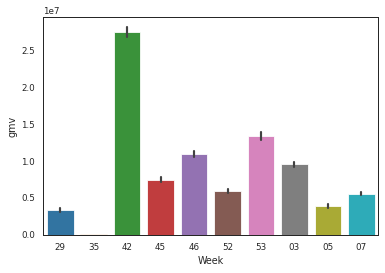

In [1072]:
import seaborn as sns
sns.barplot(x = 'Week', y = 'gmv', data = consumerelec_df[consumerelec_df['special_sales']==1], estimator = np.sum)

<AxesSubplot:xlabel='Week', ylabel='gmv'>

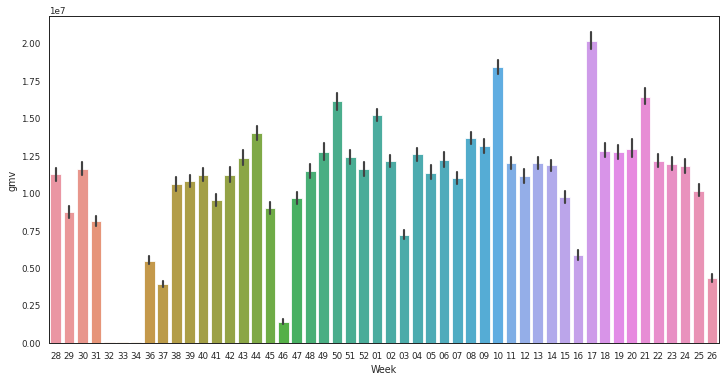

In [1073]:
plt.figure(figsize = (12,6))
sns.barplot(x = 'Week', y = 'gmv', data = consumerelec_df[consumerelec_df['special_sales']==0], estimator = np.sum)

### Mapping months to a month's number of weeks


In [1074]:
import calendar

def Week_finder_from_Year(year):
        """ will return all the week from selected year """

        import datetime

        WEEK = {'MONDAY':0,'TUESDAY':1,'WEDNESDAY':2,'THURSDAY':3,'FRIDAY':4,'SATURDAY':5,'SUNDAY':6}
        MONTH = {'JANUARY':1,'FEBRUARY':2,'MARCH':3,'APRIL':4,'MAY':5,'JUNE':6,'JULY':7,'AUGUST':8,'SEPTEMBER':9,'OCTOBER':10,'NOVEMBER':11,'DECEMBER':12}

        year = int(year)
        month = MONTH['JANUARY']
        day = WEEK['MONDAY']

        dt = datetime.date(year, month, 1)
        dow_lst = []

        while dt.weekday() != day:
            dt = dt + datetime.timedelta(days = 1)

        lst_month = MONTH.values()

        for mont in lst_month:
         while dt.month == mont:
            dow_lst.append(dt)
            dt = dt + datetime.timedelta(days=7)
            
        month_number_week = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}
        month_name_week = {'Jan':[], 'Feb':[], 'Mar':[], 'Apr':[], 'May':[], 'Jun':[], 'Jul':[], 'Aug':[], 'Sep':[], 'Oct':[], 'Nov':[], 'Dec':[]}

        for each in dow_lst:
            month_number_week[each.month].append(each.isocalendar()[1])
            month_name_week[calendar.month_abbr[each.month]].append(each.isocalendar()[1])

        return month_number_week, month_name_week

In [1075]:
dict_number_2015, dict_name_2015 = Week_finder_from_Year(2015)
print(dict_number_2015)
print(dict_name_2015)

{1: [2, 3, 4, 5], 2: [6, 7, 8, 9], 3: [10, 11, 12, 13, 14], 4: [15, 16, 17, 18], 5: [19, 20, 21, 22], 6: [23, 24, 25, 26, 27], 7: [28, 29, 30, 31], 8: [32, 33, 34, 35, 36], 9: [37, 38, 39, 40], 10: [41, 42, 43, 44], 11: [45, 46, 47, 48, 49], 12: [50, 51, 52, 53]}
{'Jan': [2, 3, 4, 5], 'Feb': [6, 7, 8, 9], 'Mar': [10, 11, 12, 13, 14], 'Apr': [15, 16, 17, 18], 'May': [19, 20, 21, 22], 'Jun': [23, 24, 25, 26, 27], 'Jul': [28, 29, 30, 31], 'Aug': [32, 33, 34, 35, 36], 'Sep': [37, 38, 39, 40], 'Oct': [41, 42, 43, 44], 'Nov': [45, 46, 47, 48, 49], 'Dec': [50, 51, 52, 53]}


In [1076]:
dict_number_2016, dict_name_2016 =Week_finder_from_Year(2016)
print(dict_number_2016)
print(dict_name_2016)

{1: [1, 2, 3, 4], 2: [5, 6, 7, 8, 9], 3: [10, 11, 12, 13], 4: [14, 15, 16, 17], 5: [18, 19, 20, 21, 22], 6: [23, 24, 25, 26], 7: [27, 28, 29, 30], 8: [31, 32, 33, 34, 35], 9: [36, 37, 38, 39], 10: [40, 41, 42, 43, 44], 11: [45, 46, 47, 48], 12: [49, 50, 51, 52]}
{'Jan': [1, 2, 3, 4], 'Feb': [5, 6, 7, 8, 9], 'Mar': [10, 11, 12, 13], 'Apr': [14, 15, 16, 17], 'May': [18, 19, 20, 21, 22], 'Jun': [23, 24, 25, 26], 'Jul': [27, 28, 29, 30], 'Aug': [31, 32, 33, 34, 35], 'Sep': [36, 37, 38, 39], 'Oct': [40, 41, 42, 43, 44], 'Nov': [45, 46, 47, 48], 'Dec': [49, 50, 51, 52]}


In [1077]:
num_weeks_2015 = 0
num_weeks_2016 = 0

for i in dict_number_2015:
    if i >= 7:
        num_weeks_2015 += len(dict_number_2015[i])

for i in dict_number_2016:
    if i <= 6:
        num_weeks_2016 += len(dict_number_2016[i])

total_weeks = num_weeks_2015 + num_weeks_2016
total_weeks

52

There are total of 52 weeks in our dataset

### Media Investment


In [1078]:
media_investment = pd.read_excel("/content/drive/MyDrive/ASSIGNEMNT/Media data and other information.xlsx", sheet_name = 1,skiprows=2,usecols = 'B:M')


In [1079]:
media_investment.head()

Year  Month  Total Investment   TV  Digital  Sponsorship  Content Marketing  Online marketing   Affiliates   SEM  Radio  Other
0 2015.00   7.00             17.06 0.22     2.53         7.41               0.00              1.33         0.55  5.02    NaN    NaN
1 2015.00   8.00              5.06 0.01     1.28         1.06               0.00              0.13         0.07  2.51    NaN    NaN
2 2015.00   9.00             96.25 3.88     1.36        62.79               0.61             16.38         5.04  6.20    NaN    NaN
3 2015.00  10.00            170.16 6.14    12.62        84.67               3.44             24.37         6.97 31.93    NaN    NaN
4 2015.00  11.00             51.22 4.22     1.28        14.17               0.17             19.56         6.60  5.22    NaN    NaN

In [1080]:
# Imputing nulls with 0

media_investment['Radio'].fillna(value=0, inplace=True)
media_investment['Other'].fillna(value=0, inplace=True)

media_investment.head()

Year  Month  Total Investment   TV  Digital  Sponsorship  Content Marketing  Online marketing   Affiliates   SEM  Radio  Other
0 2015.00   7.00             17.06 0.22     2.53         7.41               0.00              1.33         0.55  5.02   0.00   0.00
1 2015.00   8.00              5.06 0.01     1.28         1.06               0.00              0.13         0.07  2.51   0.00   0.00
2 2015.00   9.00             96.25 3.88     1.36        62.79               0.61             16.38         5.04  6.20   0.00   0.00
3 2015.00  10.00            170.16 6.14    12.62        84.67               3.44             24.37         6.97 31.93   0.00   0.00
4 2015.00  11.00             51.22 4.22     1.28        14.17               0.17             19.56         6.60  5.22   0.00   0.00

In [1081]:
# Temp DataFrame

temp_media_investment = pd.DataFrame(index=range(total_weeks), columns=['Year', 'Month', 'Week', 'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'])

temp_media_investment.head()

Year Month Week Total Investment   TV Digital Sponsorship Content Marketing Online marketing Affiliates  SEM Radio Other
0  NaN   NaN  NaN              NaN  NaN     NaN         NaN               NaN              NaN        NaN  NaN   NaN   NaN
1  NaN   NaN  NaN              NaN  NaN     NaN         NaN               NaN              NaN        NaN  NaN   NaN   NaN
2  NaN   NaN  NaN              NaN  NaN     NaN         NaN               NaN              NaN        NaN  NaN   NaN   NaN
3  NaN   NaN  NaN              NaN  NaN     NaN         NaN               NaN              NaN        NaN  NaN   NaN   NaN
4  NaN   NaN  NaN              NaN  NaN     NaN         NaN               NaN              NaN        NaN  NaN   NaN   NaN

The monthly values are divided by the number of weeks in that month and taken as weekly data



In [1082]:
i = 0

for index, row in media_investment.iterrows():

    if row.Year == 2015:

        num_weeks = len(dict_number_2015[row.Month])

        for week in dict_number_2015[row.Month]:
            
            temp_media_investment.iloc[i].Year = row.Year
            temp_media_investment.iloc[i].Month = row.Month
            temp_media_investment.iloc[i]['Week'] = week
            temp_media_investment.iloc[i]['Total Investment'] = round(row['Total Investment'] / num_weeks, 3)
            temp_media_investment.iloc[i]['TV'] = round(row['TV'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Digital'] = round(row['Digital'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Sponsorship'] = round(row['Sponsorship'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Content Marketing'] = round(row['Content Marketing'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Online marketing'] = round(row['Online marketing'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Affiliates'] = round(row[' Affiliates'] / num_weeks, 3)
            temp_media_investment.iloc[i]['SEM'] = round(row['SEM'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Radio'] = round(row['Radio'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Other'] = round(row['Other'] / num_weeks, 3)
            
            i+=1

    elif row.Year == 2016:
        
        num_weeks = len(dict_number_2016[row.Month])

        for week in dict_number_2016[row.Month]:
            
            temp_media_investment.iloc[i].Year = row.Year
            temp_media_investment.iloc[i].Month = row.Month
            temp_media_investment.iloc[i]['Week'] = week
            temp_media_investment.iloc[i]['Total Investment'] = round(row['Total Investment'] / num_weeks, 3)
            temp_media_investment.iloc[i]['TV'] = round(row['TV'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Digital'] = round(row['Digital'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Sponsorship'] = round(row['Sponsorship'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Content Marketing'] = round(row['Content Marketing'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Online marketing'] = round(row['Online marketing'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Affiliates'] = round(row[' Affiliates'] / num_weeks, 3)
            temp_media_investment.iloc[i]['SEM'] = round(row['SEM'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Radio'] = round(row['Radio'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Other'] = round(row['Other'] / num_weeks, 3)
            
            i+=1

temp_media_investment.head()

Year Month Week Total Investment   TV Digital Sponsorship Content Marketing Online marketing Affiliates  SEM Radio Other
0 2015.00  7.00   28             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
1 2015.00  7.00   29             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
2 2015.00  7.00   30             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
3 2015.00  7.00   31             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
4 2015.00  8.00   32             1.01 0.00    0.26        0.21              0.00             0.03       0.01 0.50  0.00  0.00

In [1083]:
temp_media_investment['Week'] = temp_media_investment['Week'].astype('str')


In [1084]:
media_investment = temp_media_investment

media_investment.head()

Year Month Week Total Investment   TV Digital Sponsorship Content Marketing Online marketing Affiliates  SEM Radio Other
0 2015.00  7.00   28             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
1 2015.00  7.00   29             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
2 2015.00  7.00   30             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
3 2015.00  7.00   31             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
4 2015.00  8.00   32             1.01 0.00    0.26        0.21              0.00             0.03       0.01 0.50  0.00  0.00

In [1085]:
# Check for duplicates
media_investment.duplicated('Week').value_counts()

False    52
dtype: int64

In [1086]:
# Check for nulls
media_investment.isnull().values.any()

False

In [1087]:
# Dropp Year and Month column 

del media_investment['Year']
del media_investment['Month']
media_investment.head()

Week Total Investment   TV Digital Sponsorship Content Marketing Online marketing Affiliates  SEM Radio Other
0   28             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
1   29             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
2   30             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
3   31             4.26 0.05    0.63        1.85              0.00             0.33       0.14 1.26  0.00  0.00
4   32             1.01 0.00    0.26        0.21              0.00             0.03       0.01 0.50  0.00  0.00

In [1088]:
original_column = media_investment.columns[1:]
original_column

Index(['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'], dtype='object')

## Calculating 8-weeks Exponential Moving Average for all Advertising media channels

In [1089]:
def Expo_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_EMA_'+np.str(n),value=df[i].ewm(span=n, adjust=False).mean())
    return df

In [1090]:
media_investment = Expo_variables(media_investment,original_column,8) 
media_investment.head()

Week Total Investment  Total Investment_EMA_8   TV  TV_EMA_8 Digital  Digital_EMA_8 Sponsorship  Sponsorship_EMA_8 Content Marketing  Content Marketing_EMA_8 Online marketing  Online marketing_EMA_8 Affiliates  Affiliates_EMA_8  SEM  SEM_EMA_8 Radio  Radio_EMA_8 Other  Other_EMA_8
0   28             4.26                    4.26 0.05      0.05    0.63           0.63        1.85               1.85              0.00                     0.00             0.33                    0.33       0.14              0.14 1.26       1.26  0.00         0.00  0.00         0.00
1   29             4.26                    4.26 0.05      0.05    0.63           0.63        1.85               1.85              0.00                     0.00             0.33                    0.33       0.14              0.14 1.26       1.26  0.00         0.00  0.00         0.00
2   30             4.26                    4.26 0.05      0.05    0.63           0.63        1.85               1.85              0.00                     0.00             0.33                    0.33       0.14              0.14 1.26       1.26  0.00         0.00  0.00         0.00
3   31             4.26                    4.26 0.05      0.05    0.63           0.63        1.85               1.85              0.00                     0.00             0.33                    0.33       0.14              0.14 1.26       1.26  0.00         0.00  0.00         0.00
4   32             1.01                    3.54 0.00      0.04    0.26           0.55        0.21               1.49              0.00                     0.00             0.03                    0.26       0.01              0.11 0.50       1.09  0.00         0.00  0.00         0.00

## Calculating 5-weeks Simple Moving Average for all Advertising media channels

In [1091]:
def SMA_variable(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_SMA_'+np.str(n),value=df[i].rolling(window=n).mean())
    return df

In [1092]:
media_investment = SMA_variable(media_investment,original_column,5) 
media_investment.head()

Week Total Investment  Total Investment_SMA_5  Total Investment_EMA_8   TV  TV_SMA_5  TV_EMA_8 Digital  Digital_SMA_5  Digital_EMA_8 Sponsorship  Sponsorship_SMA_5  Sponsorship_EMA_8 Content Marketing  Content Marketing_SMA_5  Content Marketing_EMA_8 Online marketing  Online marketing_SMA_5  Online marketing_EMA_8 Affiliates  Affiliates_SMA_5  Affiliates_EMA_8  SEM  SEM_SMA_5  SEM_EMA_8 Radio  Radio_SMA_5  Radio_EMA_8 Other  Other_SMA_5  Other_EMA_8
0   28             4.26                     NaN                    4.26 0.05       NaN      0.05    0.63            NaN           0.63        1.85                NaN               1.85              0.00                      NaN                     0.00             0.33                     NaN                    0.33       0.14               NaN              0.14 1.26        NaN       1.26  0.00          NaN         0.00  0.00          NaN         0.00
1   29             4.26                     NaN                    4.26 0.05       NaN      0.05    0.63            NaN           0.63        1.85                NaN               1.85              0.00                      NaN                     0.00             0.33                     NaN                    0.33       0.14               NaN              0.14 1.26        NaN       1.26  0.00          NaN         0.00  0.00          NaN         0.00
2   30             4.26                     NaN                    4.26 0.05       NaN      0.05    0.63            NaN           0.63        1.85                NaN               1.85              0.00                      NaN                     0.00             0.33                     NaN                    0.33       0.14               NaN              0.14 1.26        NaN       1.26  0.00          NaN         0.00  0.00          NaN         0.00
3   31             4.26                     NaN                    4.26 0.05       NaN      0.05    0.63            NaN           0.63        1.85                NaN               1.85              0.00                      NaN                     0.00             0.33                     NaN                    0.33       0.14               NaN              0.14 1.26        NaN       1.26  0.00          NaN         0.00  0.00          NaN         0.00
4   32             1.01                    3.61                    3.54 0.00      0.04      0.04    0.26           0.56           0.55        0.21               1.53               1.49              0.00                     0.00                     0.00             0.03                    0.27                    0.26       0.01              0.11              0.11 0.50       1.11       1.09  0.00         0.00         0.00  0.00         0.00         0.00

## Calculating 3-weeks Simple Moving Average for all Advertising media channels

In [1093]:
media_investment = SMA_variable(media_investment,original_column,3) 
media_investment.head()

Week Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8 Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8 Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8 Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8 Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8 Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8 Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8 Other  Other_SMA_3  Other_SMA_5  Other_EMA_8
0   28             4.26                     NaN                     NaN                    4.26 0.05       NaN       NaN      0.05    0.63            NaN            NaN           0.63        1.85                NaN                NaN               1.85              0.00                      NaN                      NaN                     0.00             0.33                     NaN                     NaN                    0.33       0.14               NaN               NaN              0.14 1.26        NaN        NaN       1.26  0.00          NaN          NaN         0.00  0.00          NaN          NaN         0.00
1   29             4.26                     NaN                     NaN                    4.26 0.05       NaN       NaN      0.05    0.63            NaN            NaN           0.63        1.85                NaN                NaN               1.85              0.00                      NaN                      NaN                     0.00             0.33                     NaN                     NaN                    0.33       0.14               NaN               NaN              0.14 1.26        NaN        NaN       1.26  0.00          NaN          NaN         0.00  0.00          NaN          NaN         0.00
2   30             4.26                    4.26                     NaN                    4.26 0.05      0.05       NaN      0.05    0.63           0.63            NaN           0.63        1.85               1.85                NaN               1.85              0.00                     0.00                      NaN                     0.00             0.33                    0.33                     NaN                    0.33       0.14              0.14               NaN              0.14 1.26       1.26        NaN       1.26  0.00         0.00          NaN         0.00  0.00         0.00          NaN         0.00
3   31             4.26                    4.26                     NaN                    4.26 0.05      0.05       NaN      0.05    0.63           0.63            NaN           0.63        1.85               1.85                NaN               1.85              0.00                     0.00                      NaN                     0.00             0.33                    0.33                     NaN                    0.33       0.14              0.14               NaN              0.14 1.26       1.26        NaN       1.26  0.00         0.00          NaN         0.00  0.00         0.00          NaN         0.00
4   32             1.01                    3.18                    3.61                    3.54 0.00      0.04      0.04      0.04    0.26           0.51           0.56           0.55        0.21               1.31               1.53               1.49              0.00                     0.00                     0.00                     0.00             0.03                    0.23                    0.27                    0.26       0.01              0.10              0.11              0.11 0.50       1.01       1.11       1.09  0.00         0.00         0.00         0.00  0.00         0.00         0.00         0.00

## Calculating Ad Stock values for all Advertising media

#### Generating TV Ad Stock values

In [1094]:
def calculating_ad_stocks(data, engagement_factor):
    
    """initialize ad stock vectors"""
    TV_ad_stock_vector = []                     
    Digital_ad_stock_vector = []
    Sponsorship_ad_stock_vector = []
    Content_Marketing_ad_stock_vector = []
    Online_marketing_ad_stock_vector = []
    Affiliates_ad_stock_vector = []
    SEM_ad_stock_vector = []
    Radio_ad_stock_vector = []
    Other_ad_stock_vector = []
    Total_Investment_ad_stock_vector = []
    
    """initialize ad_stock_value"""
    tv_ad_stock_value = 0 
    Digital_ad_stock_value = 0
    Sponsorship_ad_stock_value = 0
    Content_Marketing_ad_stock_value = 0
    Online_marketing_ad_stock_value = 0
    Affiliates_ad_stock_value = 0
    SEM_ad_stock_value = 0
    Radio_ad_stock_value = 0
    Other_ad_stock_value = 0
    Total_Investment_ad_stock_value = 0
    """"The formula for adstock is: At = Xt + adstock rate * At-1."""
    for index, row in data.iterrows():
        tv_ad_stock_value = row['TV'] + engagement_factor * tv_ad_stock_value
        TV_ad_stock_vector.append(tv_ad_stock_value)
        Digital_ad_stock_value = row['Digital'] + engagement_factor * Digital_ad_stock_value
        Digital_ad_stock_vector.append(Digital_ad_stock_value)
        Sponsorship_ad_stock_value = row['Sponsorship'] + engagement_factor * Sponsorship_ad_stock_value
        Sponsorship_ad_stock_vector.append(Sponsorship_ad_stock_value)
        Content_Marketing_ad_stock_value = row['Content Marketing'] + engagement_factor * Content_Marketing_ad_stock_value
        Content_Marketing_ad_stock_vector.append(Content_Marketing_ad_stock_value)    
        Online_marketing_ad_stock_value = row['Online marketing'] + engagement_factor * Online_marketing_ad_stock_value
        Online_marketing_ad_stock_vector.append(Online_marketing_ad_stock_value)
        Affiliates_ad_stock_value = row['Affiliates'] + engagement_factor * Affiliates_ad_stock_value
        Affiliates_ad_stock_vector.append(Affiliates_ad_stock_value)
        SEM_ad_stock_value = row['SEM'] + engagement_factor * SEM_ad_stock_value
        SEM_ad_stock_vector.append(SEM_ad_stock_value)
        Radio_ad_stock_value = row['Radio'] + engagement_factor * Radio_ad_stock_value
        Radio_ad_stock_vector.append(Radio_ad_stock_value)
        Other_ad_stock_value = row['Other'] + engagement_factor * Other_ad_stock_value
        Other_ad_stock_vector.append(Other_ad_stock_value)
        Total_Investment_ad_stock_value = row['Total Investment'] + engagement_factor * Total_Investment_ad_stock_value
        Total_Investment_ad_stock_vector.append(Total_Investment_ad_stock_value)
        
        
        """add ad stock vector to dataset"""
        loc_index = data.columns.get_loc('TV_EMA_8') + 1
    data.insert(loc=loc_index,column='TV_Ad_Stock',value=TV_ad_stock_vector)
    loc_index = data.columns.get_loc('Digital_EMA_8') + 1
    data.insert(loc=loc_index,column='Digital_Ad_Stock',value=Digital_ad_stock_vector)
    loc_index = data.columns.get_loc('Sponsorship_EMA_8') + 1
    data.insert(loc=loc_index,column='Sponsorship_Ad_Stock',value=Sponsorship_ad_stock_vector)
    loc_index = data.columns.get_loc('Content Marketing_EMA_8') + 1
    data.insert(loc=loc_index,column='Content_Marketing_Ad_Stock',value=Content_Marketing_ad_stock_vector)
    loc_index = data.columns.get_loc('Online marketing_EMA_8') + 1
    data.insert(loc=loc_index,column='Online_marketing_Ad_Stock',value=Online_marketing_ad_stock_vector)
    loc_index = data.columns.get_loc('Affiliates_EMA_8') + 1
    data.insert(loc=loc_index,column='Affiliates_Ad_Stock',value=Affiliates_ad_stock_vector)
    loc_index = data.columns.get_loc('SEM_EMA_8') + 1
    data.insert(loc=loc_index,column='SEM_Ad_Stock',value=SEM_ad_stock_vector)
    loc_index = data.columns.get_loc('Radio_EMA_8') + 1
    data.insert(loc=loc_index,column='Radio_Ad_Stock',value=Radio_ad_stock_vector)
    loc_index = data.columns.get_loc('Other_EMA_8') + 1
    data.insert(loc=loc_index,column='Other_Ad_Stock',value=Other_ad_stock_vector)
    loc_index = data.columns.get_loc('Total Investment_EMA_8') + 1
    data.insert(loc=loc_index,column='Total_Investment_Ad_Stock',value=Total_Investment_ad_stock_vector)
    
    return data

#### Assuming the value of Adstock rate(engagement factor)

In [1095]:
media_investment = calculating_ad_stocks(data=media_investment, engagement_factor=0.6)
media_investment.head(10)

Week Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock  SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock
0   28             4.26                     NaN                     NaN                    4.26                       4.26 0.05       NaN       NaN      0.05         0.05    0.63            NaN            NaN           0.63              0.63        1.85                NaN                NaN               1.85                  1.85              0.00                      NaN                      NaN                     0.00                        0.00             0.33                     NaN                     NaN                    0.33                       0.33       0.14               NaN               NaN              0.14                 0.14 1.26        NaN        NaN       1.26          1.26  0.00          NaN          NaN         0.00            0.00  0.00          NaN          NaN         0.00            0.00
1   29             4.26                     NaN                     NaN                    4.26                       6.82 0.05       NaN       NaN      0.05         0.09    0.63            NaN            NaN           0.63              1.01        1.85                NaN                NaN               1.85                  2.97              0.00                      NaN                      NaN                     0.00                        0.00             0.33                     NaN                     NaN                    0.33                       0.53       0.14               NaN               NaN              0.14                 0.22 1.26        NaN        NaN       1.26          2.01  0.00          NaN          NaN         0.00            0.00  0.00          NaN          NaN         0.00            0.00
2   30             4.26                    4.26                     NaN                    4.26                       8.36 0.05      0.05       NaN      0.05         0.11    0.63           0.63            NaN           0.63              1.24        1.85               1.85                NaN               1.85                  3.63              0.00                     0.00                      NaN                     0.00                        0.00             0.33                    0.33                     NaN                    0.33                       0.65       0.14              0.14               NaN              0.14                 0.27 1.26       1.26        NaN       1.26          2.46  0.00         0.00          NaN         0.00            0.00  0.00         0.00          NaN         0.00            0.00
3   31             4.26                    4.26                     NaN                    4.26                       9.28 0.05      0.05       NaN      0.05         0.12    0.63           0.63            NaN           0.63              1.38        1.85               1.85                NaN               1.85                  4.03              0.00                     0.00                      NaN                     0.00                        0.00             0.33                    0.33                     NaN                    0.33                       0.72       0.14              0.14               NaN              0.14                 0.30 1.26       1.26        NaN

In [1096]:
media_investment.fillna(value=0, inplace=True)
media_investment.head(10)

Week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock  SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock
0   28              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05         0.05     0.63           0.00           0.00           0.63              0.63         1.85               0.00               0.00               1.85                  1.85               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.33        0.14              0.00              0.00              0.14                 0.14 1.26       0.00       0.00       1.26          1.26   0.00         0.00         0.00         0.00            0.00   0.00         0.00         0.00         0.00            0.00
1   29              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05         0.09     0.63           0.00           0.00           0.63              1.01         1.85               0.00               0.00               1.85                  2.97               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.53        0.14              0.00              0.00              0.14                 0.22 1.26       0.00       0.00       1.26          2.01   0.00         0.00         0.00         0.00            0.00   0.00         0.00         0.00         0.00            0.00
2   30              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05         0.11     0.63           0.63           0.00           0.63              1.24         1.85               1.85               0.00               1.85                  3.63               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.33                    0.00                    0.33                       0.65        0.14              0.14              0.00              0.14                 0.27 1.26       1.26       0.00       1.26          2.46   0.00         0.00         0.00         0.00            0.00   0.00         0.00         0.00         0.00            0.00
3   31              4.26                    4.26                    0.00                    4.26                       9.28 0.05      0.05      0.00      0.05         0.12     0.63           0.63           0.00           0.63              1.38         1.85               1.85               0.00               1.85                  4.03               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.33                    0.00                    0.33                       0.72        0.14              0.14              0.00              0.14          

In [1097]:
media_investment.shape

(52, 51)

## NPS Score

##### We will generate weekly data from Year and Month for the nps score data

In [1098]:
net_promoter_scr = pd.read_excel('/content/drive/MyDrive/ASSIGNEMNT/Media data and other information.xlsx', sheet_name='Monthly NPS Score', \
                              skiprows=0)
net_promoter_scr.columns.values[0]='score'
net_promoter_scr 

score  July'15  Aug'15  Sept'15  Oct'15  Nov'15  Dec'15  Jan'16  Feb'16  Mar'16  Apr'16  May'16  June'16
0          NPS    54.60   59.99    46.93   44.40   47.00   45.80   47.09   50.33   49.02   51.83   47.31    50.52
1  Stock Index  1177.00 1206.00  1101.00 1210.00 1233.00 1038.00 1052.00 1222.00 1015.00 1242.00 1228.00  1194.00

##### Getting the dataset into suitable format

In [1099]:
# reset index
net_promoter_scr.reset_index(drop=True, inplace=True)

# Transpose the dataframe
net_promoter_scr = net_promoter_scr.T

# reset index
net_promoter_scr.reset_index(drop=False, inplace=True)

# renaming columns
net_promoter_scr.columns = ['Month', 'NPS', 'Stock Index']
net_promoter_scr.drop(net_promoter_scr.index[0], inplace=True)
net_promoter_scr 

Month   NPS Stock Index
1   July'15 54.60     1177.00
2    Aug'15 59.99     1206.00
3   Sept'15 46.93     1101.00
4    Oct'15 44.40     1210.00
5    Nov'15 47.00     1233.00
6    Dec'15 45.80     1038.00
7    Jan'16 47.09     1052.00
8    Feb'16 50.33     1222.00
9    Mar'16 49.02     1015.00
10   Apr'16 51.83     1242.00
11   May'16 47.31     1228.00
12  June'16 50.52     1194.00

For each week of a month, we use the same NPS Score and Stock Index values as the NPS Score and Stock Index for the whole month



In [1100]:
# Temp DataFrame
temp_nps = pd.DataFrame(index=range(total_weeks), columns=['Year', 'Month', 'Week', 'NPS', 'Stock Index'])
temp_nps

Year Month Week  NPS Stock Index
0   NaN   NaN  NaN  NaN         NaN
1   NaN   NaN  NaN  NaN         NaN
2   NaN   NaN  NaN  NaN         NaN
3   NaN   NaN  NaN  NaN         NaN
4   NaN   NaN  NaN  NaN         NaN
5   NaN   NaN  NaN  NaN         NaN
6   NaN   NaN  NaN  NaN         NaN
7   NaN   NaN  NaN  NaN         NaN
8   NaN   NaN  NaN  NaN         NaN
9   NaN   NaN  NaN  NaN         NaN
10  NaN   NaN  NaN  NaN         NaN
11  NaN   NaN  NaN  NaN         NaN
12  NaN   NaN  NaN  NaN         NaN
13  NaN   NaN  NaN  NaN         NaN
14  NaN   NaN  NaN  NaN         NaN
15  NaN   NaN  NaN  NaN         NaN
16  NaN   NaN  NaN  NaN         NaN
17  NaN   NaN  NaN  NaN         NaN
18  NaN   NaN  NaN  NaN         NaN
19  NaN   NaN  NaN  NaN         NaN
20  NaN   NaN  NaN  NaN         NaN
21  NaN   NaN  NaN  NaN         NaN
22  NaN   NaN  NaN  NaN         NaN
23  NaN   NaN  NaN  NaN         NaN
24  NaN   NaN  NaN  NaN         NaN
25  NaN   NaN  NaN  NaN         NaN
26  NaN   NaN  NaN  NaN         NaN
27  NaN   NaN  NaN  NaN         NaN
28  NaN   NaN  NaN  NaN         NaN
29  NaN   NaN  NaN  NaN         NaN
30  NaN   NaN  NaN  NaN         NaN
31  NaN   NaN  NaN  NaN         NaN
32  NaN   NaN  NaN  NaN         NaN
33  NaN   NaN  NaN  NaN         NaN
34  NaN   NaN  NaN  NaN         NaN
35  NaN   NaN  NaN  NaN         NaN
36  NaN   NaN  NaN  NaN         NaN
37  NaN   NaN  NaN  NaN         NaN
38  NaN   NaN  NaN  NaN         NaN
39  NaN   NaN  NaN  NaN         NaN
40  NaN   NaN  NaN  NaN         NaN
41  NaN   NaN  NaN  NaN         NaN
42  NaN   NaN  NaN  NaN         NaN
43  NaN   NaN  NaN  NaN         NaN
44  NaN   NaN  NaN  NaN         NaN
45  NaN   NaN  NaN  NaN         NaN
46  NaN   NaN  NaN  NaN         NaN
47  NaN   NaN  NaN  NaN         NaN
48  NaN   NaN  NaN  NaN         NaN
49  NaN   NaN  NaN  NaN         NaN
50  NaN   NaN  NaN  NaN         NaN
51  NaN   NaN  NaN  NaN         NaN

In [1101]:
import re
i = 0

for index, row in net_promoter_scr.iterrows():

    if '15' in row['Month']:
        
        month = re.split("[']", row['Month'])[0][0:3]
    
        for week in dict_name_2015[month]:        
            
            temp_nps.iloc[i].Year = 2015
            temp_nps.iloc[i].Month = month
            temp_nps.iloc[i].Week = week
            temp_nps.iloc[i].NPS = row['NPS']
            temp_nps.iloc[i]['Stock Index'] = row['Stock Index']
            
            i+=1
        
    elif '16' in row['Month']:

        month = re.split("[']", row['Month'])[0][0:3]
    
        for week in dict_name_2016[month]:        
            
            temp_nps.iloc[i].Year = 2016
            temp_nps.iloc[i].Month = month
            temp_nps.iloc[i].Week = week
            temp_nps.iloc[i].NPS = row['NPS']
            temp_nps.iloc[i]['Stock Index'] = row['Stock Index']
            
            i+=1

temp_nps.head()

Year Month Week   NPS Stock Index
0  2015   Jul   28 54.60     1177.00
1  2015   Jul   29 54.60     1177.00
2  2015   Jul   30 54.60     1177.00
3  2015   Jul   31 54.60     1177.00
4  2015   Aug   32 59.99     1206.00

In [1102]:
temp_nps['Week'] = temp_nps['Week'].astype('str')


In [1103]:
net_promoter_scr = temp_nps 
net_promoter_scr 

Year Month Week   NPS Stock Index
0   2015   Jul   28 54.60     1177.00
1   2015   Jul   29 54.60     1177.00
2   2015   Jul   30 54.60     1177.00
3   2015   Jul   31 54.60     1177.00
4   2015   Aug   32 59.99     1206.00
5   2015   Aug   33 59.99     1206.00
6   2015   Aug   34 59.99     1206.00
7   2015   Aug   35 59.99     1206.00
8   2015   Aug   36 59.99     1206.00
9   2015   Sep   37 46.93     1101.00
10  2015   Sep   38 46.93     1101.00
11  2015   Sep   39 46.93     1101.00
12  2015   Sep   40 46.93     1101.00
13  2015   Oct   41 44.40     1210.00
14  2015   Oct   42 44.40     1210.00
15  2015   Oct   43 44.40     1210.00
16  2015   Oct   44 44.40     1210.00
17  2015   Nov   45 47.00     1233.00
18  2015   Nov   46 47.00     1233.00
19  2015   Nov   47 47.00     1233.00
20  2015   Nov   48 47.00     1233.00
21  2015   Nov   49 47.00     1233.00
22  2015   Dec   50 45.80     1038.00
23  2015   Dec   51 45.80     1038.00
24  2015   Dec   52 45.80     1038.00
25  2015   Dec   53 45.80     1038.00
26  2016   Jan    1 47.09     1052.00
27  2016   Jan    2 47.09     1052.00
28  2016   Jan    3 47.09     1052.00
29  2016   Jan    4 47.09     1052.00
30  2016   Feb    5 50.33     1222.00
31  2016   Feb    6 50.33     1222.00
32  2016   Feb    7 50.33     1222.00
33  2016   Feb    8 50.33     1222.00
34  2016   Feb    9 50.33     1222.00
35  2016   Mar   10 49.02     1015.00
36  2016   Mar   11 49.02     1015.00
37  2016   Mar   12 49.02     1015.00
38  2016   Mar   13 49.02     1015.00
39  2016   Apr   14 51.83     1242.00
40  2016   Apr   15 51.83     1242.00
41  2016   Apr   16 51.83     1242.00
42  2016   Apr   17 51.83     1242.00
43  2016   May   18 47.31     1228.00
44  2016   May   19 47.31     1228.00
45  2016   May   20 47.31     1228.00
46  2016   May   21 47.31     1228.00
47  2016   May   22 47.31     1228.00
48  2016   Jun   23 50.52     1194.00
49  2016   Jun   24 50.52     1194.00
50  2016   Jun   25 50.52     1194.00
51  2016   Jun   26 50.52     1194.00

In [1104]:
net_promoter_scr.duplicated('Week').value_counts()

False    52
dtype: int64

NO Duplicates found

In [1105]:
net_promoter_scr.isnull().values.any()


False

In [1106]:
# Dropp Year and Month columns 

del net_promoter_scr['Year']
del net_promoter_scr['Month']

In [1107]:
nps_original_col = net_promoter_scr.columns[1:]
nps_original_col

Index(['NPS', 'Stock Index'], dtype='object')

In [1108]:
net_promoter_scr.head()

Week   NPS Stock Index
0   28 54.60     1177.00
1   29 54.60     1177.00
2   30 54.60     1177.00
3   31 54.60     1177.00
4   32 59.99     1206.00

## Calculating 5-weeks Simple Moving Average for NPS and Stock_Index

In [1109]:
net_promoter_scr = SMA_variable(net_promoter_scr,nps_original_col,5) 
net_promoter_scr.head()

Week   NPS  NPS_SMA_5 Stock Index  Stock Index_SMA_5
0   28 54.60        NaN     1177.00                NaN
1   29 54.60        NaN     1177.00                NaN
2   30 54.60        NaN     1177.00                NaN
3   31 54.60        NaN     1177.00                NaN
4   32 59.99      55.68     1206.00            1182.80

## Calculating 3-weeks Simple Moving Average for NPS and Stock_Index

In [1110]:
net_promoter_scr = SMA_variable(net_promoter_scr,nps_original_col,3) 
net_promoter_scr.head()

Week   NPS  NPS_SMA_3  NPS_SMA_5 Stock Index  Stock Index_SMA_3  Stock Index_SMA_5
0   28 54.60        NaN        NaN     1177.00                NaN                NaN
1   29 54.60        NaN        NaN     1177.00                NaN                NaN
2   30 54.60      54.60        NaN     1177.00            1177.00                NaN
3   31 54.60      54.60        NaN     1177.00            1177.00                NaN
4   32 59.99      56.40      55.68     1206.00            1186.67            1182.80

In [1111]:
net_promoter_scr.fillna(value=0, inplace=True)
net_promoter_scr.head()

Week   NPS  NPS_SMA_3  NPS_SMA_5  Stock Index  Stock Index_SMA_3  Stock Index_SMA_5
0   28 54.60       0.00       0.00      1177.00               0.00               0.00
1   29 54.60       0.00       0.00      1177.00               0.00               0.00
2   30 54.60      54.60       0.00      1177.00            1177.00               0.00
3   31 54.60      54.60       0.00      1177.00            1177.00               0.00
4   32 59.99      56.40      55.68      1206.00            1186.67            1182.80

Distribution of the numeric columns


#############
Month
#############


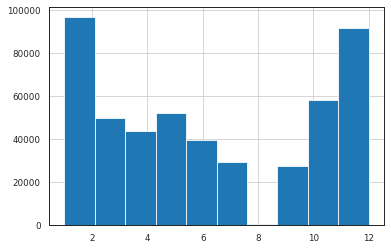

#############
gmv
#############


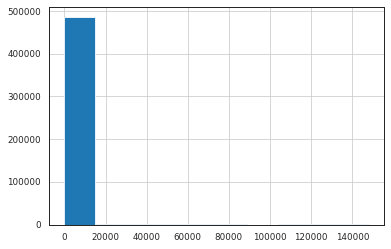

#############
list_price
#############


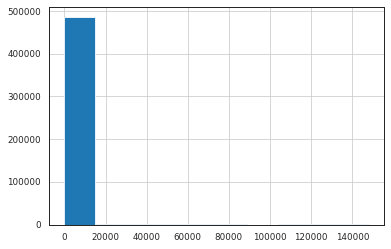

#############
Discount%
#############


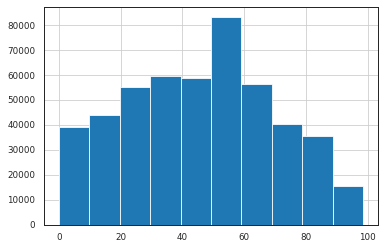

#############
units
#############


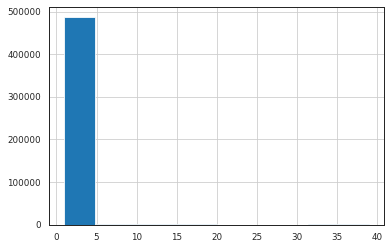

#############
deliverybdays
#############


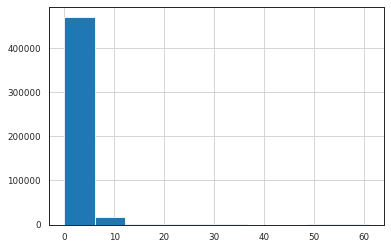

#############
deliverycdays
#############


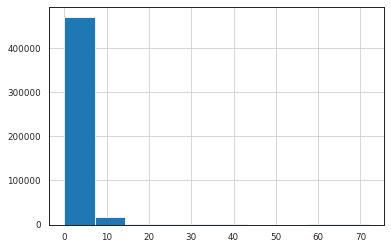

#############
sla
#############


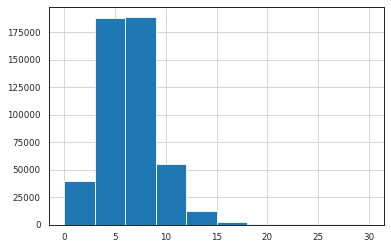

#############
product_mrp
#############


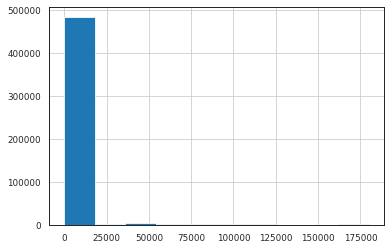

#############
product_procurement_sla
#############


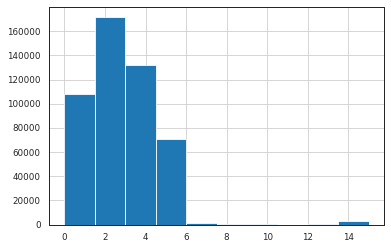

#############
payday_flag
#############


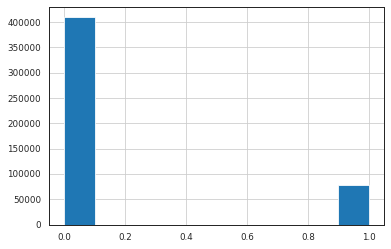

#############
hld_flag
#############


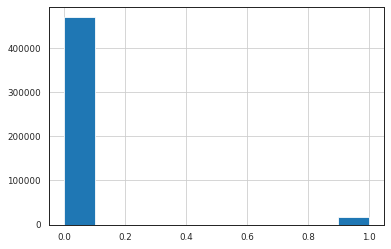

#############
order_payment_type_Prepaid
#############


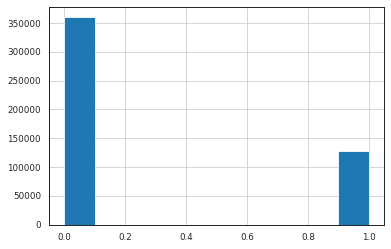

#############
special_sales
#############


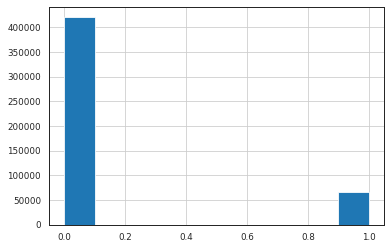

In [1112]:
for col in consumerelec_df.describe().columns:
    print('#############')
    print(col)
    print('#############')
    consumerelec_df[col].hist()
    plt.show()

In [1113]:
cat_var = [cname for cname in consumerelec_df.columns if 
                                consumerelec_df[cname].dtype == "object"]

consumerelec_df[cat_var].describe().T

count  unique               top    freq
Year                           487033       2              2016  281010
Week                           487033      52                42   28536
order_id                       487033  486268         171370369       6
product_analytic_category      487033       3   CameraAccessory  202380
product_analytic_sub_category  487033       3   CameraAccessory  202380
product_analytic_vertical      487033      50  HomeAudioSpeaker   74621
product_type                   487033       2       mass_market  389571

### EDA-Part-2


### Comparing Distribution of Discount% for product types - Premium_products and mass_market


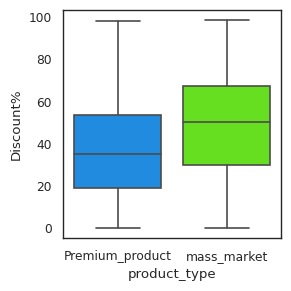

In [1114]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(3, 3), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

sns.boxplot(x='product_type', y='Discount%', palette='gist_rainbow_r', data=consumerelec_df)
# plot legend

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

The median discount percentage offered for luxury items is less compared to that of Mass Market Products.

*This is a known trend among luxury products or luxury brands to offer limited or no discounts to retain the exclusivity of their products.*

### Displaying trend of NPS and Stock Index by week

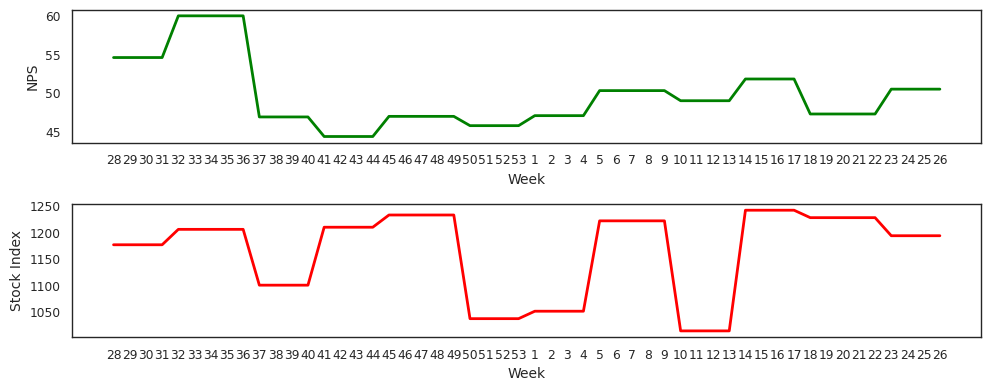

In [1115]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10, 4), dpi=100, facecolor='w', edgecolor='b', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(2, 1, 1)
plt.plot(net_promoter_scr.iloc[:,0], net_promoter_scr.iloc[:,1], 'g-', linewidth=2)
plt.xlabel('Week', fontsize=10);
plt.ylabel('NPS', fontsize=10);

# subplot 2
plt.subplot(2, 1, 2)
plt.plot(net_promoter_scr.iloc[:,0], net_promoter_scr.iloc[:,4], 'r-', linewidth=2)
plt.xlabel('Week', fontsize=10);
plt.ylabel('Stock Index', fontsize=10);

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

Consumer NPS score is highest in weeks 32 – 35 , which coincides with the time when maximum discounts were being offered.



### Displaying trend of various Media Channel Investments by week

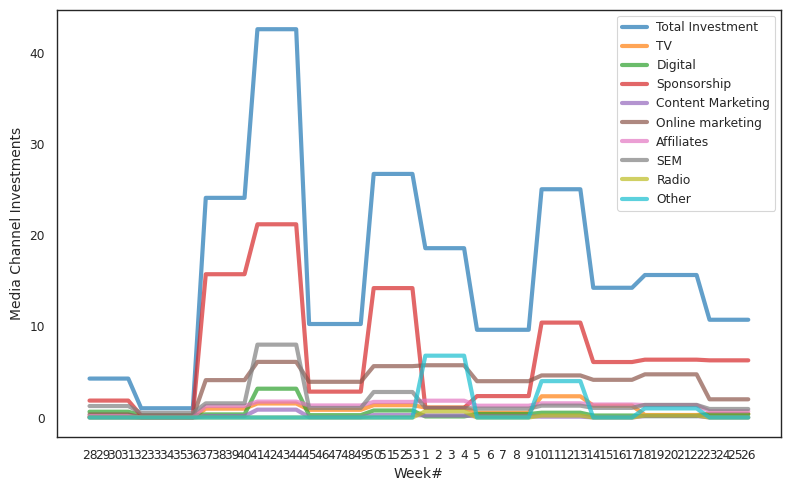

In [1116]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 1, 1)
plt.plot(media_investment.iloc[:,0], media_investment.iloc[:,1::5], linewidth=3, alpha = 0.7)
plt.xlabel('Week#', fontsize=10)
plt.ylabel('Media Channel Investments', fontsize=10)
plt.legend(media_investment.iloc[:,1::5])
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

*Over the past year, bulk of the Ad Investment has been made in Sponsorships followed by Online Marketing & Search Engine Marketing(specially during Thanksgiving).*



### Average Revenue from Holiday/Non-holiday days for the 3 product subcategories

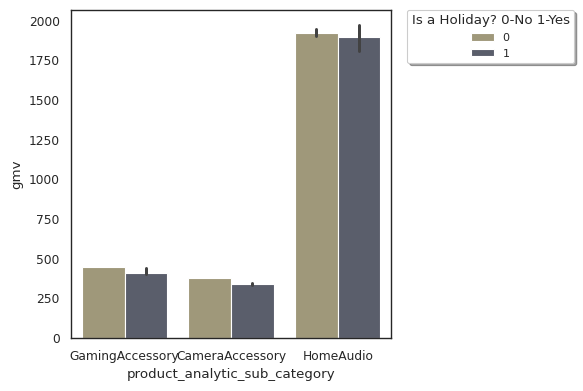

In [1117]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(6,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

sns.barplot(y='gmv', x='product_analytic_sub_category', hue ='hld_flag', \
            palette='cividis_r', data=consumerelec_df, estimator=np.median)

# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Is a Holiday? 0-No 1-Yes', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

The average(median) revenue for 3 product sub categories from holiday and non-holiday days are more or less comparable.

### No of items(Premium_product/Mass-market) sold per 3 product subcategories

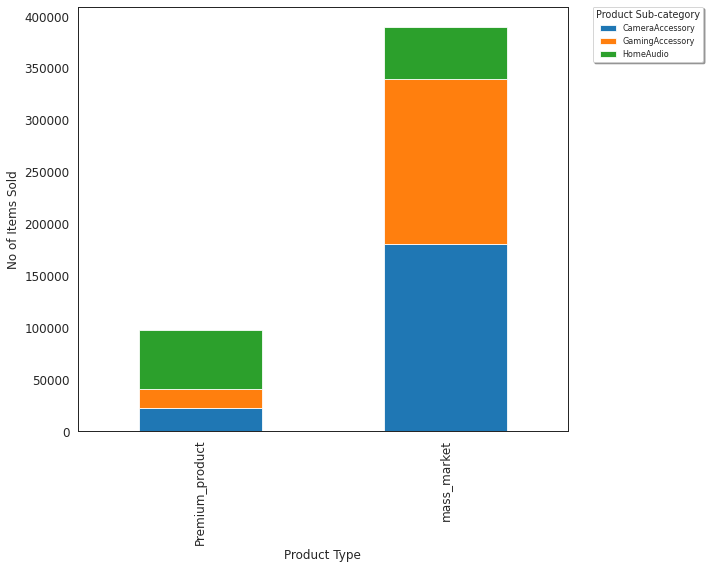

In [1118]:
consumerelec_df.groupby(["product_type", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', \
                                                                                             stacked=True, figsize=(10,8), \
                                                                                             fontsize = 12) 
# plot x axis label
plt.xlabel('Product Type', fontsize = 12)
# plot y axis label
plt.ylabel('No of Items Sold', fontsize = 12)
# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Product Sub-category', \
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

#### From the above graph, we have the following observations:
 - Most of the units sold belonged to the mass market category. 
 - Among mass market products sold, Camera and Gaming Accessories related products were sold the most. 
 - Home Audio products were the most popular among the premium products sold

### Total items sold per 3 product subcategories per Month

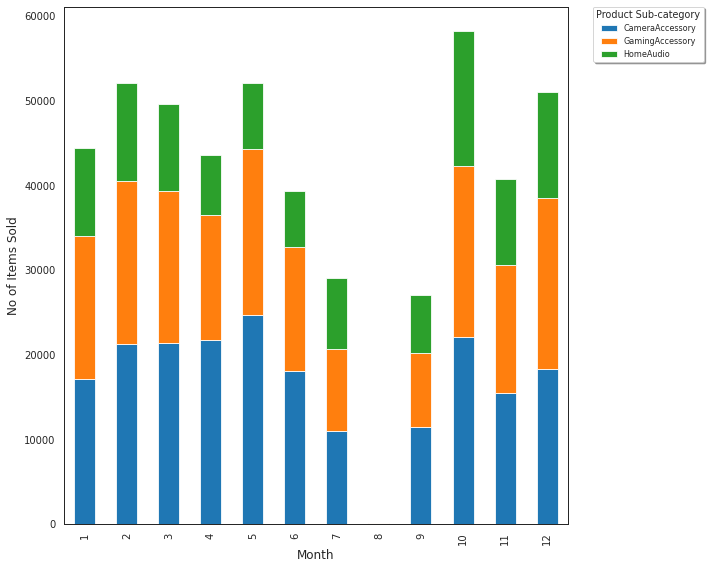

In [1119]:
consumerelec_df.groupby(["Month", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', \
                                                                                             stacked=True, figsize=(10,8), \
                                                                                           fontsize = 10) 
# plot x axis label
plt.xlabel('Month', fontsize = 12)
# plot y axis label
plt.ylabel('No of Items Sold', fontsize = 12)
# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Product Sub-category', \
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

### Total items sold per 3 product subcategories per Week

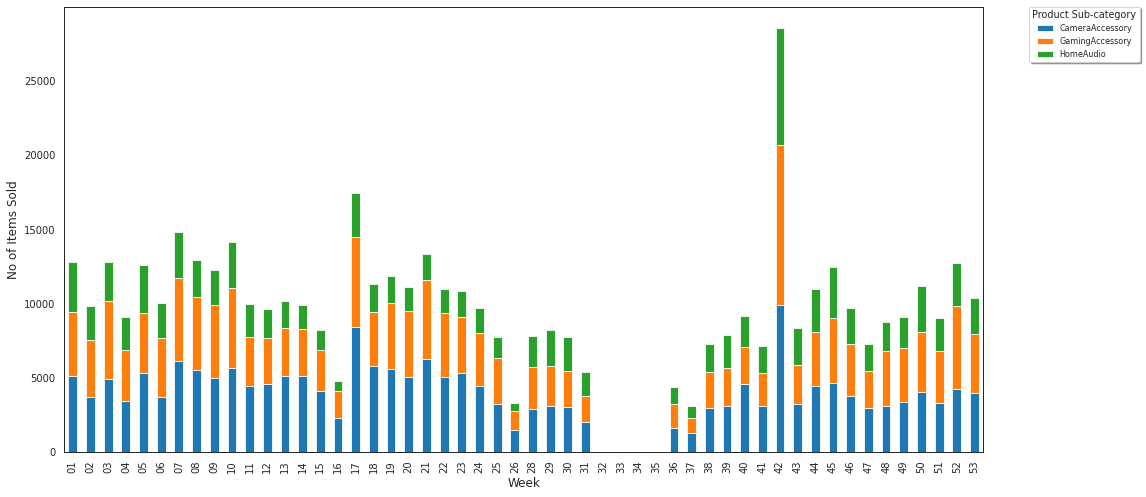

In [1120]:
consumerelec_df.groupby(["Week", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', \
                                                                                             stacked=True, figsize=(16,7), \
                                                                                           fontsize = 10) 
# plot x axis label
plt.xlabel('Week', fontsize = 12)
# plot y axis label
plt.ylabel('No of Items Sold', fontsize = 12)
# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Product Sub-category', \
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

#### The sale on the 42nd week (`Thanksgiving week`) is maximum. Overall, October has seen most no of items being sold.

### Top 10 Product Verticals which brought the Maximum Revenue for 3 product sub-categories

In [1121]:
highest_gmv = pd.DataFrame(consumerelec_df.groupby(['product_analytic_sub_category','product_analytic_vertical'])['gmv'].sum().sort_values(ascending=False).reset_index()).head(10)
highest_gmv['product_in_category'] = highest_gmv[['product_analytic_vertical','product_analytic_sub_category']].apply(lambda x: ' in '.join(x), axis=1)
highest_gmv.head(20)

product_analytic_sub_category product_analytic_vertical          gmv               product_in_category
0                     HomeAudio          HomeAudioSpeaker 182694666.56     HomeAudioSpeaker in HomeAudio
1               CameraAccessory                      Lens  99963875.00           Lens in CameraAccessory
2               GamingAccessory                   GamePad  57289220.71        GamePad in GamingAccessory
3               GamingAccessory             GamingHeadset  31026410.28  GamingHeadset in GamingAccessory
4               CameraAccessory                Binoculars  25687142.50     Binoculars in CameraAccessory
5               GamingAccessory               GamingMouse  24911758.99    GamingMouse in GamingAccessory
6               CameraAccessory             CameraBattery  21571027.76  CameraBattery in CameraAccessory
7               CameraAccessory                     Flash  21436374.00          Flash in CameraAccessory
8                     HomeAudio                   FMRadio  21427877.00              FMRadio in HomeAudio
9               CameraAccessory                 CameraBag  21219153.00      CameraBag in CameraAccessory

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


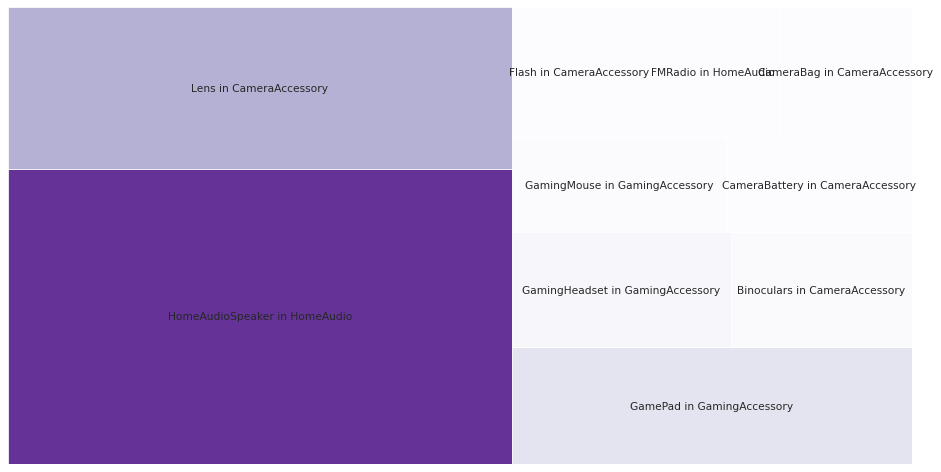

In [1122]:
!pip install squarify
import squarify    # pip install squarify (algorithm for treemap)
# Create a dataset:
import matplotlib
my_values=list(highest_gmv['gmv'])
 
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')    
# create a color palette, mapped to these values
cmap = matplotlib.cm.Purples
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, label=highest_gmv['product_in_category'],color=colors)
plt.axis('off')

# Show graphic
plt.tight_layout()
plt.show()

Homeaudiospeaker in homeaudio brought the largest revenue followed by lens in cameraaccessory & gamepad in gamingaccessory.

### Top 10 Product Verticals with most no of sales for 3 product sub-categories

In [1123]:
large_sales = pd.DataFrame(consumerelec_df.groupby(['product_analytic_sub_category','product_analytic_vertical'])['units'].count().sort_values(ascending=False).reset_index()).head(10)
large_sales['product_in_category'] = large_sales[['product_analytic_vertical','product_analytic_sub_category']].apply(lambda x: ' in '.join(x), axis=1)
large_sales.head(20)

product_analytic_sub_category product_analytic_vertical  units               product_in_category
0                     HomeAudio          HomeAudioSpeaker  74621     HomeAudioSpeaker in HomeAudio
1               GamingAccessory             GamingHeadset  58456  GamingHeadset in GamingAccessory
2               GamingAccessory                   GamePad  49106        GamePad in GamingAccessory
3               CameraAccessory                     Flash  46956          Flash in CameraAccessory
4               GamingAccessory               GamingMouse  34087    GamingMouse in GamingAccessory
5               CameraAccessory             CameraBattery  32317  CameraBattery in CameraAccessory
6               CameraAccessory              CameraTripod  29815   CameraTripod in CameraAccessory
7               CameraAccessory                      Lens  29392           Lens in CameraAccessory
8                     HomeAudio                   FMRadio  23816              FMRadio in HomeAudio
9               CameraAccessory                 CameraBag  14897      CameraBag in CameraAccessory

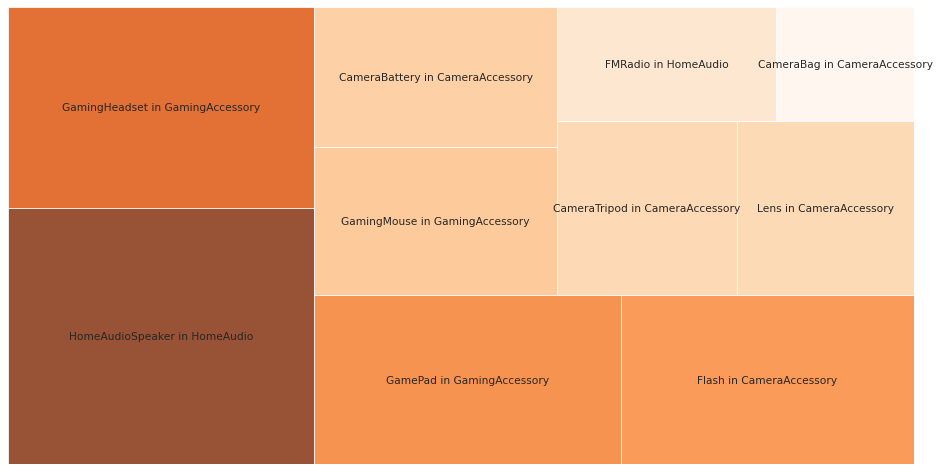

In [1124]:
import squarify    # pip install squarify (algorithm for treemap)
# Create a dataset:
my_values=list(large_sales['units'])
 
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')    
# create a color palette, mapped to these values
cmap = matplotlib.cm.Oranges
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, label=large_sales['product_in_category'],color=colors)
plt.axis('off')

# Show graphic
plt.tight_layout()
plt.show()

Homeaudiospeaker in homeaudio had the most no of sales followed by gamingheadset & gamepad in gamingaccessory.


### Comparison of Trends of Revenue Discount% & Total Media Investment over the weeks

In [1125]:
# Segmenting the Discount% into various bins

def discount_binning(df,cut_points,label_names):
    column_index = df.columns.get_loc('Discount%') + 1
    df.insert(loc=column_index,column='Discount Bins',value=pd.cut(df['Discount%'],cut_points,labels=label_names, include_lowest=True))
    return df

cut_points = [0,10,20,30,40,50,60,70,80,90,100]
label_names = ["Below 10%","Between 10-20%","Between 20-30%","Between 30-40%","Between 40-50%","Between 50-60%", \
              "Between 60-70%","Between 70-80%","Between 80-90%","Between 90-100%"]

product_sub = discount_binning(consumerelec_df,cut_points,label_names)
product_sub.head()
 

order_date  Year  Month Week   order_id     gmv  list_price  Discount%   Discount Bins  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type  order_payment_type_Prepaid       Date  special_sales
0 2015-07-06 05:08:26  2015      7   28  167223837 5398.00     2699.00      39.96  Between 30-40%      2           0.00           0.00    2            GamingHardware               GamingAccessory                   GamePad      4495.00                        5            0         0  Premium_product                           0 2015-07-06              0
1 2015-07-06 08:15:22  2015      7   28  167234860 4340.00     4340.00      23.85  Between 20-30%      1           0.00           0.00    1            GamingHardware               GamingAccessory               GamingMouse      5699.00                        2            0         0  Premium_product                           1 2015-07-06              0
2 2015-07-06 09:00:55  2015      7   28  167241120  139.00      139.00      53.51  Between 50-60%      1           0.00           0.00    8            GamingHardware               GamingAccessory       TVOutCableAccessory       299.00                        4            0         0      mass_market                           1 2015-07-06              0
3 2015-07-07 00:02:01  2015      7   28  167584636  949.00      949.00      36.73  Between 30-40%      1           0.00           0.00    9           CameraAccessory               CameraAccessory                Binoculars      1500.00                        2            0         0      mass_market                           0 2015-07-07              0
4 2015-07-07 00:03:19  2015      7   28  167584146 4750.00     4750.00       4.98       Below 10%      1           0.00           0.00    6            GamingHardware               GamingAccessory          MotionController      4999.00                        2            0         0  Premium_product                           0 2015-07-07              0

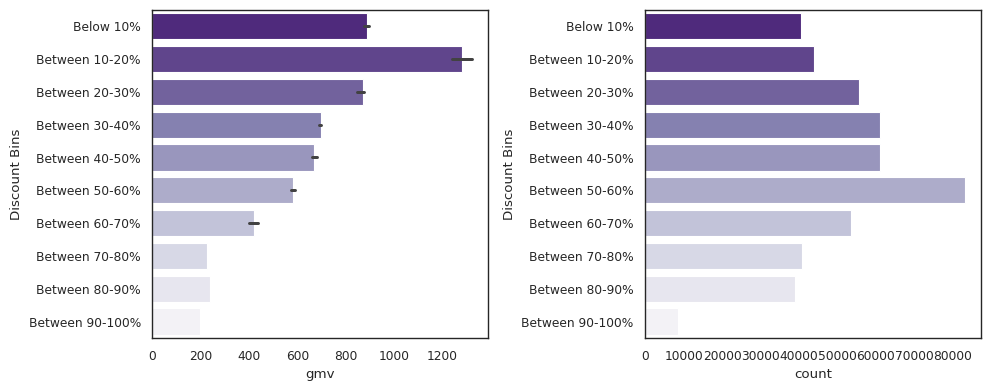

In [1126]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 2, 1)
sns.barplot(x='gmv', y='Discount Bins', palette='Purples_r', data=consumerelec_df, estimator=np.median)

# subplot 2
plt.subplot(1, 2, 2)
sns.countplot(y='Discount Bins', palette='Purples_r', data=consumerelec_df)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()


*   Median Revenue is maximum when Average discount% is between 10-20%. But beyond that, average revenue slowly starts to decline.
*   The sales on the other hand shows a steady increase with increase in Discount percentage till it peaks at 50-60% after which it starts to fall again.


*This shows that at higher discount, although the sales are good, the revenue collapses signifying a loss for the company. An average discount of 10-20% is the most profitable for the company.*

### Percentage of items sold at different Discount% segments


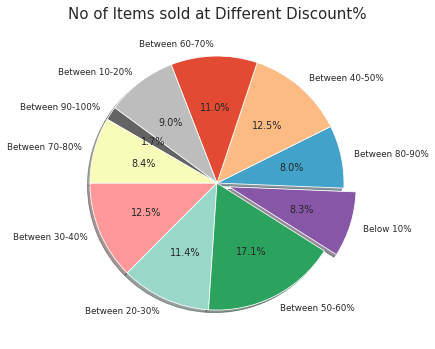

In [1127]:
from collections import Counter

labels, values = zip(*Counter(consumerelec_df["Discount Bins"]).items())
colors = ["#ff9999", "#99d8c9", "#2ca25f", "#8856a7","#43a2ca","#fdbb84","#e34a33","#bdbdbd","#636363","#f7fcb9"]
piechart_df = (pd.DataFrame(list(values),list(labels)))
piechart_df = piechart_df.reset_index()

fig = plt.figure(figsize=[6,6])

plt.pie(piechart_df[0],labels=piechart_df["index"],startangle=180,explode=(0,0,0,0.1,0,0,0,0,0,0),autopct="%1.1f%%", \
        shadow=True, colors=colors)
plt.tight_layout()
plt.title("No of Items sold at Different Discount%", fontsize=15)
plt.show()

Most of the sales take place when Discount% is between 50-60%.


## Outlier Treatment

In [1128]:
consumerelec_df.head()

order_date  Year  Month Week   order_id     gmv  list_price  Discount%   Discount Bins  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category product_analytic_vertical  product_mrp  product_procurement_sla  payday_flag  hld_flag     product_type  order_payment_type_Prepaid       Date  special_sales
0 2015-07-06 05:08:26  2015      7   28  167223837 5398.00     2699.00      39.96  Between 30-40%      2           0.00           0.00    2            GamingHardware               GamingAccessory                   GamePad      4495.00                        5            0         0  Premium_product                           0 2015-07-06              0
1 2015-07-06 08:15:22  2015      7   28  167234860 4340.00     4340.00      23.85  Between 20-30%      1           0.00           0.00    1            GamingHardware               GamingAccessory               GamingMouse      5699.00                        2            0         0  Premium_product                           1 2015-07-06              0
2 2015-07-06 09:00:55  2015      7   28  167241120  139.00      139.00      53.51  Between 50-60%      1           0.00           0.00    8            GamingHardware               GamingAccessory       TVOutCableAccessory       299.00                        4            0         0      mass_market                           1 2015-07-06              0
3 2015-07-07 00:02:01  2015      7   28  167584636  949.00      949.00      36.73  Between 30-40%      1           0.00           0.00    9           CameraAccessory               CameraAccessory                Binoculars      1500.00                        2            0         0      mass_market                           0 2015-07-07              0
4 2015-07-07 00:03:19  2015      7   28  167584146 4750.00     4750.00       4.98       Below 10%      1           0.00           0.00    6            GamingHardware               GamingAccessory          MotionController      4999.00                        2            0         0  Premium_product                           0 2015-07-07              0

In [1129]:
consumerelec_df.dtypes


order_date                       datetime64[ns]
Year                                     object
Month                                     int64
Week                                     object
order_id                                 object
gmv                                     float64
list_price                              float64
Discount%                               float64
Discount Bins                          category
units                                     int64
deliverybdays                           float64
deliverycdays                           float64
sla                                       int64
product_analytic_category                object
product_analytic_sub_category            object
product_analytic_vertical                object
product_mrp                             float64
product_procurement_sla                   int64
payday_flag                               int64
hld_flag                                  int64
product_type                            

In [1130]:
# GMV
consumerelec_df.gmv.describe()

count   487033.00
mean      1261.76
std       2356.13
min         10.00
25%        296.00
50%        549.00
75%       1490.00
max     148050.00
Name: gmv, dtype: float64

GMV varies from min = 10 to max = 148050



<AxesSubplot:xlabel='gmv'>

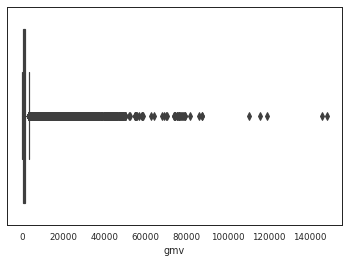

In [1131]:
sns.boxplot(x='gmv', data = consumerelec_df, orient = 'vertical')


<AxesSubplot:xlabel='gmv'>

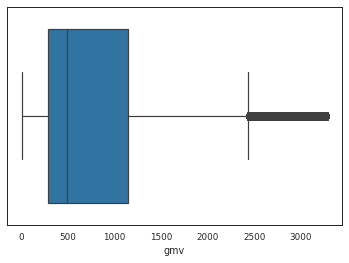

In [1132]:
dummy = consumerelec_df.copy()
q1 = dummy['gmv'].quantile(0.25)
q3 = dummy['gmv'].quantile(0.75)
iqr = q3 - q1
dummy = dummy[(dummy['gmv'] > q1 - 1.5*iqr) & (dummy['gmv'] < q3 + 1.5*iqr)]

sns.boxplot(x='gmv', data = dummy, orient = 'vertical')

In [1133]:
quantile=[0,0.5,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
consumerelec_df.gmv.quantile(quantile)

0.00       10.00
0.50      549.00
0.10      199.00
0.15      238.00
0.20      265.00
0.25      296.00
0.30      325.00
0.35      350.00
0.40      399.00
0.45      475.00
0.50      549.00
0.55      649.00
0.60      775.00
0.65      939.00
0.70     1150.00
0.75     1490.00
0.80     1849.00
0.85     2299.00
0.90     2750.00
0.95     4000.00
1.00   148050.00
Name: gmv, dtype: float64

50% Values below 645-Detected outliers



<AxesSubplot:xlabel='units'>

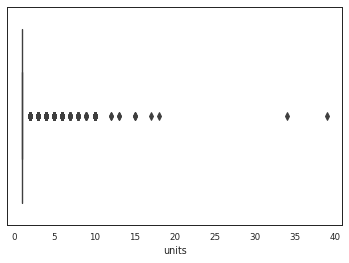

In [1134]:
#Units
sns.boxplot(x='units', data = consumerelec_df, orient = 'vertical')

In [1135]:
consumerelec_df['sla'].describe()


count   487033.00
mean         5.90
std          2.69
min          0.00
25%          4.00
50%          6.00
75%          7.00
max         30.00
Name: sla, dtype: float64

<AxesSubplot:xlabel='sla'>

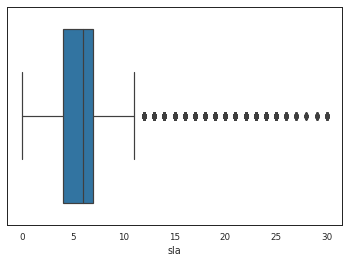

In [1136]:
sns.boxplot(x='sla', data = consumerelec_df, orient = 'vertical')


In [1137]:
# Product MRP:
consumerelec_df.product_mrp.describe()

count   487033.00
mean      2471.34
std       4671.65
min         79.00
25%        766.00
50%       1200.00
75%       2742.00
max     180000.00
Name: product_mrp, dtype: float64

<AxesSubplot:xlabel='product_mrp'>

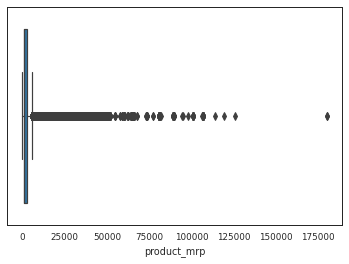

In [1138]:
sns.boxplot(x='product_mrp', data =consumerelec_df, orient = 'vertical')

In [1139]:
consumerelec_df.product_mrp.quantile(quantile)


0.00       79.00
0.50     1200.00
0.10      410.00
0.15      500.00
0.20      599.00
0.25      766.00
0.30      800.00
0.35      899.00
0.40      950.00
0.45     1000.00
0.50     1200.00
0.55     1399.00
0.60     1599.00
0.65     1990.00
0.70     1999.00
0.75     2742.00
0.80     3001.00
0.85     3999.00
0.90     5399.00
0.95     6990.00
1.00   180000.00
Name: product_mrp, dtype: float64

<AxesSubplot:xlabel='Discount%'>

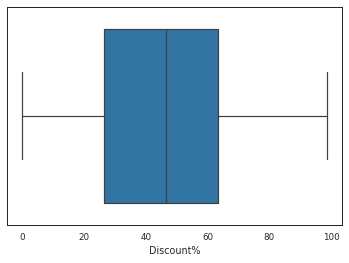

In [1140]:
sns.boxplot(x='Discount%', data =consumerelec_df, orient = 'vertical')


In [1141]:
consumerelec_df['Discount%'].quantile(quantile)


0.00    0.00
0.50   46.64
0.10   12.24
0.15   17.81
0.20   22.21
0.25   26.48
0.30   30.73
0.35   34.69
0.40   38.97
0.45   42.34
0.50   46.64
0.55   50.08
0.60   53.33
0.65   56.68
0.70   59.27
0.75   63.23
0.80   67.69
0.85   73.97
0.90   79.68
0.95   85.93
1.00   98.60
Name: Discount%, dtype: float64

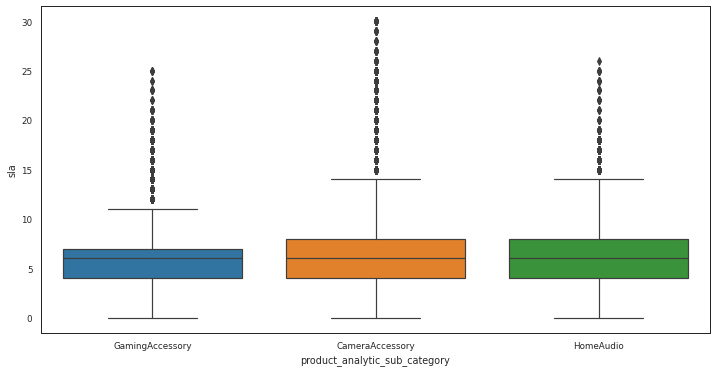

In [1142]:
#SLA distribution of different sub-categories of products
plt.figure(figsize = (12,6))
b1 = sns.boxplot(data=consumerelec_df, x = 'product_analytic_sub_category', y = 'sla')

In [1143]:
consumerelec_df.sla.mean()


5.904552668915659

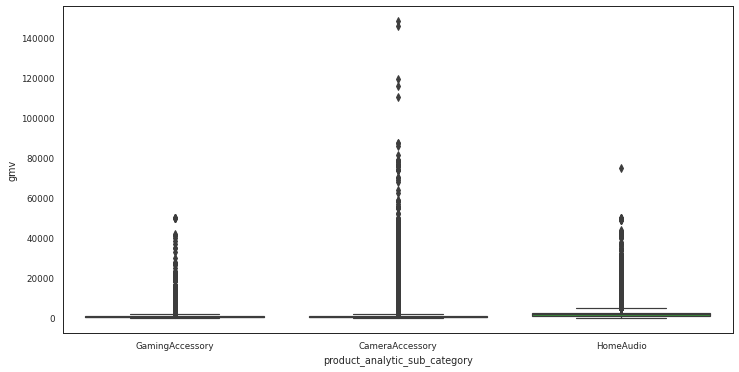

In [1144]:
# GMV Distribution for product category
plt.figure(figsize = (12,6))
b2 = sns.boxplot(data=consumerelec_df,x ='product_analytic_sub_category', y='gmv')

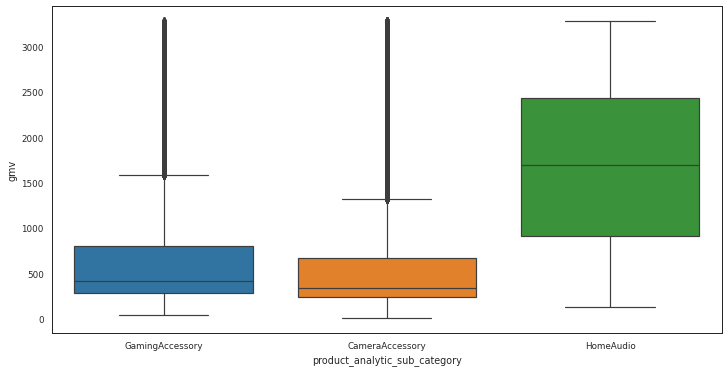

In [1145]:
# GMV Distribution for product category
plt.figure(figsize = (12,6))
b2 = sns.boxplot(data=dummy,x ='product_analytic_sub_category', y='gmv')

Mean GMV values remained the same for all three sub-categories. We see a lot of outliers in the category CameraAccessory



In [1146]:
C1 = consumerelec_df[consumerelec_df['product_analytic_sub_category'] == "CameraAccessory"].groupby('Week',as_index=False)[['Discount%']].mean()
C1['product_analytic_subtype'] = "CameraAccessory"
C1

Week  Discount% product_analytic_subtype
0    01      49.74          CameraAccessory
1    02      49.00          CameraAccessory
2    03      48.26          CameraAccessory
3    04      44.09          CameraAccessory
4    05      51.69          CameraAccessory
5    06      46.17          CameraAccessory
6    07      47.82          CameraAccessory
7    08      53.45          CameraAccessory
8    09      48.54          CameraAccessory
9    10      50.47          CameraAccessory
10   11      53.67          CameraAccessory
11   12      49.72          CameraAccessory
12   13      50.51          CameraAccessory
13   14      53.45          CameraAccessory
14   15      52.96          CameraAccessory
15   16      53.64          CameraAccessory
16   17      54.50          CameraAccessory
17   18      57.36          CameraAccessory
18   19      56.51          CameraAccessory
19   20      54.26          CameraAccessory
20   21      54.74          CameraAccessory
21   22      55.59          CameraAccessory
22   23      57.05          CameraAccessory
23   24      53.23          CameraAccessory
24   25      48.85          CameraAccessory
25   26      49.56          CameraAccessory
26   28      43.93          CameraAccessory
27   29      44.31          CameraAccessory
28   30      43.64          CameraAccessory
29   31      43.01          CameraAccessory
30   32      12.95          CameraAccessory
31   36      45.30          CameraAccessory
32   37      47.53          CameraAccessory
33   38      45.28          CameraAccessory
34   39      49.12          CameraAccessory
35   40      58.45          CameraAccessory
36   41      46.50          CameraAccessory
37   42      53.37          CameraAccessory
38   43      45.07          CameraAccessory
39   44      46.88          CameraAccessory
40   45      48.66          CameraAccessory
41   46      46.68          CameraAccessory
42   47      46.27          CameraAccessory
43   48      42.88          CameraAccessory
44   49      45.05          CameraAccessory
45   50      48.71          CameraAccessory
46   51      43.30          CameraAccessory
47   52      47.91          CameraAccessory
48   53      44.97          CameraAccessory

In [1147]:
C2 = consumerelec_df[consumerelec_df['product_analytic_sub_category'] == "GamingAccessory"].groupby('Week',as_index=False)[['Discount%']].mean()
C2['product_analytic_subtype'] = "GamingAccessory"
C2

Week  Discount% product_analytic_subtype
0    01      47.10          GamingAccessory
1    02      44.62          GamingAccessory
2    03      45.51          GamingAccessory
3    04      43.66          GamingAccessory
4    05      44.51          GamingAccessory
5    06      47.10          GamingAccessory
6    07      50.14          GamingAccessory
7    08      49.69          GamingAccessory
8    09      47.82          GamingAccessory
9    10      47.09          GamingAccessory
10   11      40.74          GamingAccessory
11   12      40.93          GamingAccessory
12   13      41.21          GamingAccessory
13   14      40.65          GamingAccessory
14   15      43.09          GamingAccessory
15   16      44.61          GamingAccessory
16   17      45.52          GamingAccessory
17   18      45.61          GamingAccessory
18   19      49.60          GamingAccessory
19   20      50.49          GamingAccessory
20   21      47.88          GamingAccessory
21   22      44.86          GamingAccessory
22   23      44.87          GamingAccessory
23   24      44.54          GamingAccessory
24   25      42.28          GamingAccessory
25   26      41.21          GamingAccessory
26   28      40.14          GamingAccessory
27   29      42.56          GamingAccessory
28   30      37.12          GamingAccessory
29   31      42.88          GamingAccessory
30   32      62.94          GamingAccessory
31   33      38.60          GamingAccessory
32   34      50.37          GamingAccessory
33   35      41.89          GamingAccessory
34   36      38.83          GamingAccessory
35   37      38.96          GamingAccessory
36   38      38.92          GamingAccessory
37   39      40.21          GamingAccessory
38   40      39.02          GamingAccessory
39   41      37.03          GamingAccessory
40   42      52.73          GamingAccessory
41   43      39.57          GamingAccessory
42   44      44.07          GamingAccessory
43   45      45.53          GamingAccessory
44   46      41.87          GamingAccessory
45   47      41.63          GamingAccessory
46   48      44.45          GamingAccessory
47   49      41.31          GamingAccessory
48   50      44.56          GamingAccessory
49   51      45.68          GamingAccessory
50   52      51.63          GamingAccessory
51   53      47.59          GamingAccessory

In [1148]:
C3 = consumerelec_df[consumerelec_df['product_analytic_sub_category'] == "HomeAudio"].groupby('Week',as_index=False)[['Discount%']].mean()
C3['product_analytic_subtype'] = "HomeAudio"
C3

Week  Discount% product_analytic_subtype
0    01      44.57                HomeAudio
1    02      39.07                HomeAudio
2    03      39.92                HomeAudio
3    04      37.74                HomeAudio
4    05      42.53                HomeAudio
5    06      38.39                HomeAudio
6    07      42.05                HomeAudio
7    08      36.60                HomeAudio
8    09      34.31                HomeAudio
9    10      40.11                HomeAudio
10   11      36.09                HomeAudio
11   12      34.56                HomeAudio
12   13      35.00                HomeAudio
13   14      33.50                HomeAudio
14   15      34.72                HomeAudio
15   16      33.62                HomeAudio
16   17      36.50                HomeAudio
17   18      36.33                HomeAudio
18   19      35.19                HomeAudio
19   20      34.00                HomeAudio
20   21      36.03                HomeAudio
21   22      33.30                HomeAudio
22   23      30.96                HomeAudio
23   24      29.74                HomeAudio
24   25      31.20                HomeAudio
25   26      30.89                HomeAudio
26   28      31.47                HomeAudio
27   29      32.92                HomeAudio
28   30      32.32                HomeAudio
29   31      32.22                HomeAudio
30   32      16.13                HomeAudio
31   36      37.33                HomeAudio
32   37      36.07                HomeAudio
33   38      35.34                HomeAudio
34   39      34.33                HomeAudio
35   40      33.70                HomeAudio
36   41      34.07                HomeAudio
37   42      41.82                HomeAudio
38   43      35.57                HomeAudio
39   44      35.29                HomeAudio
40   45      43.30                HomeAudio
41   46      36.44                HomeAudio
42   47      35.56                HomeAudio
43   48      33.49                HomeAudio
44   49      39.21                HomeAudio
45   50      46.05                HomeAudio
46   51      38.94                HomeAudio
47   52      41.23                HomeAudio
48   53      35.14                HomeAudio

In [1149]:
# Compare  mean gmv for normal days vs days on which there are holiday promotions
consumerelec_df.groupby('special_sales',as_index=False)[['gmv']].mean()

special_sales     gmv
0              0 1254.21
1              1 1309.35

<AxesSubplot:xlabel='gmv'>

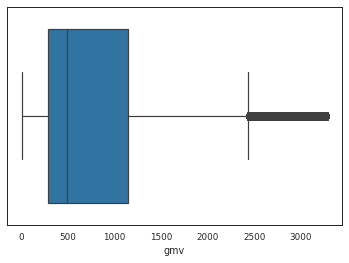

In [1150]:
#outliear treatment for gmv values
q1 = consumerelec_df['gmv'].quantile(0.25)
q3 = consumerelec_df['gmv'].quantile(0.75)
iqr = q3 - q1
consumerelec_df =consumerelec_df[(consumerelec_df['gmv'] > q1 - 1.5*iqr) & (consumerelec_df['gmv'] < q3 + 1.5*iqr)]

sns.boxplot(x='gmv', data = consumerelec_df, orient = 'vertical')

<AxesSubplot:xlabel='sla'>

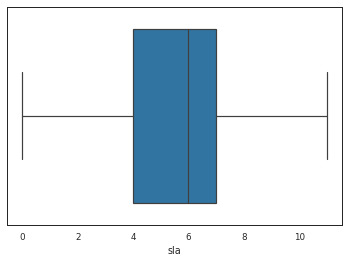

In [1151]:
#outliear treatment for sla values
q1 = consumerelec_df['sla'].quantile(0.25)
q3 = consumerelec_df['sla'].quantile(0.75)
iqr = q3 - q1
consumerelec_df= consumerelec_df[(consumerelec_df['sla'] > q1 - 1.5*iqr) & (consumerelec_df['sla'] < q3 + 1.5*iqr)]

sns.boxplot(x='sla', data = consumerelec_df, orient = 'vertical')

<AxesSubplot:xlabel='product_mrp'>

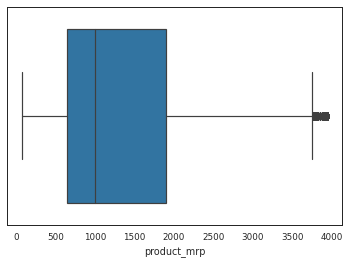

In [1152]:
# product_mrp values
q1 = consumerelec_df['product_mrp'].quantile(0.25)
q3 = consumerelec_df['product_mrp'].quantile(0.75)
iqr = q3 - q1
consumerelec_df = consumerelec_df[(consumerelec_df['product_mrp'] > q1 - 1.5*iqr) & (consumerelec_df['product_mrp'] < q3 + 1.5*iqr)]

sns.boxplot(x='product_mrp', data = consumerelec_df, orient = 'vertical')

In [1153]:
numeric_column = consumerelec_df.select_dtypes(exclude = ['object', 'datetime64[ns]']).columns
numeric_column

Index(['Month', 'gmv', 'list_price', 'Discount%', 'Discount Bins', 'units', 'deliverybdays', 'deliverycdays', 'sla', 'product_mrp', 'product_procurement_sla', 'payday_flag', 'hld_flag', 'order_payment_type_Prepaid', 'special_sales'], dtype='object')

<AxesSubplot:xlabel='product_procurement_sla'>

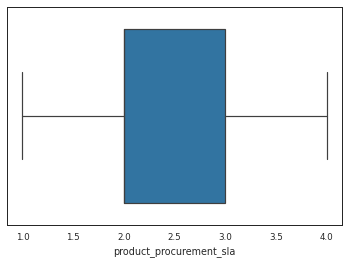

In [1154]:
# product_procurement_sla value outlier treatment
q1 = consumerelec_df['product_procurement_sla'].quantile(0.25)
q3 = consumerelec_df['product_procurement_sla'].quantile(0.75)
iqr = q3 - q1
consumerelec_df = consumerelec_df[(consumerelec_df['product_procurement_sla'] > q1 - 1.5*iqr) & (consumerelec_df['product_procurement_sla'] < q3 + 1.5*iqr)]

sns.boxplot(x='product_procurement_sla', data = consumerelec_df, orient = 'vertical')

## Climate Data - Climate 2015


We will generate weekly data from date for the climate data of 2015



In [1155]:
climate_data_2015 = pd.read_csv('/content/drive/MyDrive/ASSIGNEMNT/ONTARIO-2015.csv', skiprows=24)

In [1156]:
climate_data_2015.head()

Date/Time  Year  Month  Day Data Quality  Max Temp (°C) Max Temp Flag  Min Temp (°C) Min Temp Flag  Mean Temp (°C) Mean Temp Flag  Heat Deg Days (°C) Heat Deg Days Flag  Cool Deg Days (°C) Cool Deg Days Flag  Total Rain (mm) Total Rain Flag  Total Snow (cm) Total Snow Flag  Total Precip (mm) Total Precip Flag  Snow on Grnd (cm) Snow on Grnd Flag  Dir of Max Gust (10s deg)  Dir of Max Gust Flag  Spd of Max Gust (km/h)  Spd of Max Gust Flag
0  2015-01-01  2015      1    1            †           0.00           NaN          -8.50           NaN           -4.30            NaN               22.30                NaN                0.00                NaN             0.00             NaN             0.00             NaN               0.00               NaN               0.00               NaN                        NaN                   NaN                     NaN                   NaN
1  2015-01-02  2015      1    2            †           3.00           NaN          -3.00           NaN            0.00            NaN               18.00                NaN                0.00                NaN             0.00             NaN             0.00             NaN               0.00               NaN               0.00               NaN                        NaN                   NaN                     NaN                   NaN
2  2015-01-03  2015      1    3            †           2.50           NaN          -4.00           NaN           -0.80            NaN               18.80                NaN                0.00                NaN            24.00             NaN             0.00             NaN              24.00               NaN               0.00               NaN                        NaN                   NaN                     NaN                   NaN
3  2015-01-04  2015      1    4            †           2.50           NaN           0.00           NaN            1.30            NaN               16.70                NaN                0.00                NaN             0.00             NaN             1.00             NaN               1.00               NaN               0.00               NaN                        NaN                   NaN                     NaN                   NaN
4  2015-01-05  2015      1    5            †         -10.00           NaN         -13.50           NaN          -11.80            NaN               29.80                NaN                0.00                NaN             0.00             NaN             3.00             NaN               3.00               NaN               1.00               NaN                        NaN                   NaN                     NaN                   NaN

In [1157]:
climate_data_2015.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'], dtype='object')

In [1158]:
# Dropping the columns with all nulls

climate_data_2015.dropna(axis=1, thresh=1, inplace=True)

climate_data_2015.reset_index(drop=True, inplace=True)

climate_data_2015.head()

Date/Time  Year  Month  Day Data Quality  Max Temp (°C) Max Temp Flag  Min Temp (°C) Min Temp Flag  Mean Temp (°C) Mean Temp Flag  Heat Deg Days (°C) Heat Deg Days Flag  Cool Deg Days (°C) Cool Deg Days Flag  Total Rain (mm) Total Rain Flag  Total Snow (cm) Total Snow Flag  Total Precip (mm) Total Precip Flag  Snow on Grnd (cm) Snow on Grnd Flag
0  2015-01-01  2015      1    1            †           0.00           NaN          -8.50           NaN           -4.30            NaN               22.30                NaN                0.00                NaN             0.00             NaN             0.00             NaN               0.00               NaN               0.00               NaN
1  2015-01-02  2015      1    2            †           3.00           NaN          -3.00           NaN            0.00            NaN               18.00                NaN                0.00                NaN             0.00             NaN             0.00             NaN               0.00               NaN               0.00               NaN
2  2015-01-03  2015      1    3            †           2.50           NaN          -4.00           NaN           -0.80            NaN               18.80                NaN                0.00                NaN            24.00             NaN             0.00             NaN              24.00               NaN               0.00               NaN
3  2015-01-04  2015      1    4            †           2.50           NaN           0.00           NaN            1.30            NaN               16.70                NaN                0.00                NaN             0.00             NaN             1.00             NaN               1.00               NaN               0.00               NaN
4  2015-01-05  2015      1    5            †         -10.00           NaN         -13.50           NaN          -11.80            NaN               29.80                NaN                0.00                NaN             0.00             NaN             3.00             NaN               3.00               NaN               1.00               NaN

In [1159]:
climate_data_2015.columns


Index(['Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag'], dtype='object')

In [1160]:
drop_cols = []

for col in climate_data_2015.columns:
    if 'Flag' in col:
        print(climate_data_2015[col].value_counts())
        print()
        drop_cols.append(col)

drop_cols.append('Data Quality')

climate_data_2015.drop(drop_cols, axis=1, inplace=True)

print(climate_data_2015.columns)

M    13
Name: Max Temp Flag, dtype: int64

M    39
Name: Min Temp Flag, dtype: int64

M    39
Name: Mean Temp Flag, dtype: int64

M    39
Name: Heat Deg Days Flag, dtype: int64

M    39
Name: Cool Deg Days Flag, dtype: int64

T    7
Name: Total Rain Flag, dtype: int64

T    9
Name: Total Snow Flag, dtype: int64

T    12
Name: Total Precip Flag, dtype: int64

T    2
Name: Snow on Grnd Flag, dtype: int64

Index(['Date/Time', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)'], dtype='object')


In [1161]:
# Formatting column names

climate_data_2015.columns = [col.replace(' (°C)','').strip() for col in climate_data_2015.columns]

climate_data_2015.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)'], dtype='object')

In [1162]:
climate_data_2015.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date/Time          365 non-null    object 
 1   Year               365 non-null    int64  
 2   Month              365 non-null    int64  
 3   Day                365 non-null    int64  
 4   Max Temp           216 non-null    float64
 5   Min Temp           190 non-null    float64
 6   Mean Temp          190 non-null    float64
 7   Heat Deg Days      190 non-null    float64
 8   Cool Deg Days      190 non-null    float64
 9   Total Rain (mm)    229 non-null    float64
 10  Total Snow (cm)    229 non-null    float64
 11  Total Precip (mm)  229 non-null    float64
 12  Snow on Grnd (cm)  229 non-null    float64
dtypes: float64(9), int64(3), object(1)
memory usage: 37.2+ KB


In [1163]:
# Dropping rows where all the columns have nulls

cols = ['Max Temp',
 'Min Temp',
 'Mean Temp',
 'Heat Deg Days',
 'Cool Deg Days',
 'Total Rain (mm)',
 'Total Snow (cm)',
 'Total Precip (mm)',
 'Snow on Grnd (cm)']

climate_data_2015.dropna(subset=cols, inplace=True)

climate_data_2015.reset_index(drop=True, inplace=True)

climate_data_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date/Time          190 non-null    object 
 1   Year               190 non-null    int64  
 2   Month              190 non-null    int64  
 3   Day                190 non-null    int64  
 4   Max Temp           190 non-null    float64
 5   Min Temp           190 non-null    float64
 6   Mean Temp          190 non-null    float64
 7   Heat Deg Days      190 non-null    float64
 8   Cool Deg Days      190 non-null    float64
 9   Total Rain (mm)    190 non-null    float64
 10  Total Snow (cm)    190 non-null    float64
 11  Total Precip (mm)  190 non-null    float64
 12  Snow on Grnd (cm)  190 non-null    float64
dtypes: float64(9), int64(3), object(1)
memory usage: 19.4+ KB


In [1164]:
# Extract week from the date field 

climate_data_2015['Week'] = climate_data_2015['Date/Time'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%V"))

climate_data_2015['Week'] = climate_data_2015['Week'].apply(lambda x: str(x).lstrip('0'))

climate_data_2015.head()

Date/Time  Year  Month  Day  Max Temp  Min Temp  Mean Temp  Heat Deg Days  Cool Deg Days  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm) Week
0  2015-01-01  2015      1    1      0.00     -8.50      -4.30          22.30           0.00             0.00             0.00               0.00               0.00    1
1  2015-01-02  2015      1    2      3.00     -3.00       0.00          18.00           0.00             0.00             0.00               0.00               0.00    1
2  2015-01-03  2015      1    3      2.50     -4.00      -0.80          18.80           0.00            24.00             0.00              24.00               0.00    1
3  2015-01-04  2015      1    4      2.50      0.00       1.30          16.70           0.00             0.00             1.00               1.00               0.00    1
4  2015-01-05  2015      1    5    -10.00    -13.50     -11.80          29.80           0.00             0.00             3.00               3.00               1.00    2

In [1165]:
# Extracting data from July to Dec month

climate_data_2015 = climate_data_2015[climate_data_2015['Month'] >= 7]
climate_data_2015.reset_index(drop=True, inplace=True)

climate_data_2015.head()

Date/Time  Year  Month  Day  Max Temp  Min Temp  Mean Temp  Heat Deg Days  Cool Deg Days  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm) Week
0  2015-07-01  2015      7    1     24.50     17.00      20.80           0.00           2.80             0.00             0.00               0.00               0.00   27
1  2015-07-02  2015      7    2     24.00     14.00      19.00           0.00           1.00             0.00             0.00               0.00               0.00   27
2  2015-07-03  2015      7    3     25.00     10.00      17.50           0.50           0.00             0.00             0.00               0.00               0.00   27
3  2015-07-04  2015      7    4     26.00     11.00      18.50           0.00           0.50             0.00             0.00               0.00               0.00   27
4  2015-07-05  2015      7    5     28.00     14.00      21.00           0.00           3.00             0.00             0.00               0.00               0.00   27

In [1166]:
climate_data_2015.sort_values(by=['Week'], ascending = True, inplace = True)


In [1167]:
# week data
climate_data_2015 = climate_data_2015.groupby(['Week']).agg({'Max Temp':"max", 'Min Temp':"min", 'Mean Temp':"mean", 'Heat Deg Days':"mean", 'Cool Deg Days':"mean", 'Total Rain (mm)':"mean", 'Total Snow (cm)':"mean", 'Total Precip (mm)':"mean", 'Snow on Grnd (cm)':"mean"}).reset_index(drop=False)

climate_data_2015.head()

Week  Max Temp  Min Temp  Mean Temp  Heat Deg Days  Cool Deg Days  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)
0   27     28.00     10.00      19.36           0.10           1.46             0.00             0.00               0.00               0.00
1   28     28.00     12.50      20.10           0.28           2.38             4.42             0.00               4.42               0.00
2   29     33.00     11.00      23.18           0.00           5.18             1.40             0.00               1.40               0.00
3   30     31.50     14.50      23.06           0.00           5.06             1.08             0.00               1.08               0.00
4   31     33.50     16.00      24.57           0.00           6.57             4.63             0.00               4.63               0.00

In [1168]:
# Drop 27th week data -belonging to June 2015

climate_data_2015.drop(climate_data_2015[climate_data_2015['Week'] == '27'].index, inplace = True)

In [1169]:
climate_data_2015.duplicated().any()


False

## Climate Data - Climate 2016


We will generate weekly data from date for the climate data of 2016



In [1170]:
# Skipping the first 24 rows while reading the data to ignore the metadata
climate_2016 = pd.read_csv('/content/drive/MyDrive/ASSIGNEMNT/ONTARIO-2016.csv', skiprows=24)


In [1171]:
climate_2016

Date/Time  Year  Month  Day Data Quality  Max Temp (°C) Max Temp Flag  Min Temp (°C) Min Temp Flag  Mean Temp (°C) Mean Temp Flag  Heat Deg Days (°C) Heat Deg Days Flag  Cool Deg Days (°C) Cool Deg Days Flag  Total Rain (mm) Total Rain Flag  Total Snow (cm) Total Snow Flag  Total Precip (mm) Total Precip Flag  Snow on Grnd (cm) Snow on Grnd Flag  Dir of Max Gust (10s deg)  Dir of Max Gust Flag  Spd of Max Gust (km/h)  Spd of Max Gust Flag
0    2016-01-01  2016      1    1          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN                        NaN                   NaN                     NaN                   NaN
1    2016-01-02  2016      1    2          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN                        NaN                   NaN                     NaN                   NaN
2    2016-01-03  2016      1    3          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN                        NaN                   NaN                     NaN                   NaN
3    2016-01-04  2016      1    4          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN                        NaN                   NaN                     NaN                   NaN
4    2016-01-05  2016      1    5          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN                        NaN                   NaN                     NaN                   NaN
5    2016-01-06  2016      1    6          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN                        NaN                   NaN                     NaN                   NaN
6    2016-01-07  2016      1    7          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN                        NaN                   NaN                     NaN                   NaN
7    2016-01-08  2016      1    8            †           7.00           NaN         -14.00           NaN           -3.50            NaN               21.50                NaN                0.00                NaN             9.00             NaN             0.00             NaN               9.00               NaN               0.00               NaN                        NaN                   NaN            

In [1172]:
climate_2016.columns


Index(['Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'], dtype='object')

In [1173]:
# Dropping the columns with all nulls

climate_2016.dropna(axis=1, thresh=1, inplace=True)

climate_2016.reset_index(drop=True, inplace=True)

climate_2016.head()

Date/Time  Year  Month  Day Data Quality  Max Temp (°C) Max Temp Flag  Min Temp (°C) Min Temp Flag  Mean Temp (°C) Mean Temp Flag  Heat Deg Days (°C) Heat Deg Days Flag  Cool Deg Days (°C) Cool Deg Days Flag  Total Rain (mm) Total Rain Flag  Total Snow (cm) Total Snow Flag  Total Precip (mm) Total Precip Flag  Snow on Grnd (cm) Snow on Grnd Flag
0  2016-01-01  2016      1    1          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN
1  2016-01-02  2016      1    2          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN
2  2016-01-03  2016      1    3          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN
3  2016-01-04  2016      1    4          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN
4  2016-01-05  2016      1    5          NaN            NaN           NaN            NaN           NaN             NaN            NaN                 NaN                NaN                 NaN                NaN              NaN             NaN              NaN             NaN                NaN               NaN                NaN               NaN

In [1174]:
climate_2016.columns


Index(['Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag'], dtype='object')

In [1175]:
# Dropping columns with only one distinct value

drop_cols = []

for col in climate_2016.columns:
    if 'Flag' in col:
        print(climate_2016[col].value_counts())
        print()
        drop_cols.append(col)

drop_cols.append('Data Quality')

climate_2016.drop(drop_cols, axis=1, inplace=True)

print(climate_2016.columns)

M    1
Name: Max Temp Flag, dtype: int64

M    8
Name: Min Temp Flag, dtype: int64

M    8
Name: Mean Temp Flag, dtype: int64

M    8
Name: Heat Deg Days Flag, dtype: int64

M    8
Name: Cool Deg Days Flag, dtype: int64

T    3
Name: Total Rain Flag, dtype: int64

T    7
Name: Total Snow Flag, dtype: int64

T    7
Name: Total Precip Flag, dtype: int64

T    6
Name: Snow on Grnd Flag, dtype: int64

Index(['Date/Time', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)'], dtype='object')


In [1176]:
# Formatting column names

climate_2016.columns = [col.replace(' (°C)','').strip() for col in climate_2016.columns]

climate_2016.columns

Index(['Date/Time', 'Year', 'Month', 'Day', 'Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)'], dtype='object')

In [1177]:
climate_2016.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date/Time          366 non-null    object 
 1   Year               366 non-null    int64  
 2   Month              366 non-null    int64  
 3   Day                366 non-null    int64  
 4   Max Temp           226 non-null    float64
 5   Min Temp           219 non-null    float64
 6   Mean Temp          219 non-null    float64
 7   Heat Deg Days      219 non-null    float64
 8   Cool Deg Days      219 non-null    float64
 9   Total Rain (mm)    227 non-null    float64
 10  Total Snow (cm)    227 non-null    float64
 11  Total Precip (mm)  227 non-null    float64
 12  Snow on Grnd (cm)  227 non-null    float64
dtypes: float64(9), int64(3), object(1)
memory usage: 37.3+ KB


In [1178]:
# Dropping rows where all the columns have nulls

cols = ['Max Temp',
 'Min Temp',
 'Mean Temp',
 'Heat Deg Days',
 'Cool Deg Days',
 'Total Rain (mm)',
 'Total Snow (cm)',
 'Total Precip (mm)',
 'Snow on Grnd (cm)']

climate_2016.dropna(subset=cols, inplace=True)

climate_2016.reset_index(drop=True, inplace=True)

climate_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date/Time          219 non-null    object 
 1   Year               219 non-null    int64  
 2   Month              219 non-null    int64  
 3   Day                219 non-null    int64  
 4   Max Temp           219 non-null    float64
 5   Min Temp           219 non-null    float64
 6   Mean Temp          219 non-null    float64
 7   Heat Deg Days      219 non-null    float64
 8   Cool Deg Days      219 non-null    float64
 9   Total Rain (mm)    219 non-null    float64
 10  Total Snow (cm)    219 non-null    float64
 11  Total Precip (mm)  219 non-null    float64
 12  Snow on Grnd (cm)  219 non-null    float64
dtypes: float64(9), int64(3), object(1)
memory usage: 22.4+ KB


In [1179]:
# Extracting week # from the date field and formatting it

climate_2016['Week'] = climate_2016['Date/Time'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%V"))

climate_2016['Week'] = climate_2016['Week'].apply(lambda x: str(x).lstrip('0'))

climate_2016.head()

Date/Time  Year  Month  Day  Max Temp  Min Temp  Mean Temp  Heat Deg Days  Cool Deg Days  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm) Week
0  2016-01-08  2016      1    8      7.00    -14.00      -3.50          21.50           0.00             9.00             0.00               9.00               0.00    1
1  2016-01-09  2016      1    9     11.00      3.00       7.00          11.00           0.00            14.60             0.00              14.60               0.00    1
2  2016-01-10  2016      1   10     -1.50     -5.00      -3.30          21.30           0.00             0.00             7.00               7.00               0.00    1
3  2016-01-12  2016      1   12     -5.00    -12.00      -8.50          26.50           0.00             0.00             0.00               0.00              12.00    2
4  2016-01-14  2016      1   14      2.50    -10.50      -4.00          22.00           0.00             0.00             0.00               0.00              11.00    2

In [1180]:
# Extract Jan to June month data
climate_2016 = climate_2016[climate_2016['Month'] <= 6]
climate_2016.reset_index(drop=True, inplace=True)

climate_2016.head()

Date/Time  Year  Month  Day  Max Temp  Min Temp  Mean Temp  Heat Deg Days  Cool Deg Days  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm) Week
0  2016-01-08  2016      1    8      7.00    -14.00      -3.50          21.50           0.00             9.00             0.00               9.00               0.00    1
1  2016-01-09  2016      1    9     11.00      3.00       7.00          11.00           0.00            14.60             0.00              14.60               0.00    1
2  2016-01-10  2016      1   10     -1.50     -5.00      -3.30          21.30           0.00             0.00             7.00               7.00               0.00    1
3  2016-01-12  2016      1   12     -5.00    -12.00      -8.50          26.50           0.00             0.00             0.00               0.00              12.00    2
4  2016-01-14  2016      1   14      2.50    -10.50      -4.00          22.00           0.00             0.00             0.00               0.00              11.00    2

In [1181]:
climate_2016.sort_values(by=['Week'], ascending = True, inplace = True)


In [1182]:
# Get week data

climate_2016 = climate_2016.groupby(['Week']).agg({'Max Temp':"max", 'Min Temp':"min", 'Mean Temp':"mean", 'Heat Deg Days':"mean", 'Cool Deg Days':"mean", 'Total Rain (mm)':"mean", 'Total Snow (cm)':"mean", 'Total Precip (mm)':"mean", 'Snow on Grnd (cm)':"mean"}).reset_index(drop=False)

climate_2016.head()

Week  Max Temp  Min Temp  Mean Temp  Heat Deg Days  Cool Deg Days  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)
0    1     11.00    -14.00       0.07          17.93           0.00             7.87             2.33              10.20               0.00
1   10     20.00     -2.00      10.17           7.83           0.00             9.00             0.00               9.00               0.00
2   11     16.00     -2.50       8.90           9.10           0.00             0.50             0.00               0.50               0.00
3   12     20.50     -3.50       5.72          12.28           0.00            12.80             0.00              12.80               0.00
4   13     16.00     -5.00       6.87          11.13           0.00             2.83             0.54               3.37               0.00

In [1183]:
climate_2016.duplicated().any()

False

In [1184]:
climate_2016.isnull().values.any()


False

##Concatenating Climate Datasets


In [1185]:
climate_merge_df = pd.concat([climate_data_2015, climate_2016], axis = 0)


In [1186]:
climate_merge_df.shape

(51, 10)

In [1187]:
climate_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 1 to 24
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Week               51 non-null     object 
 1   Max Temp           51 non-null     float64
 2   Min Temp           51 non-null     float64
 3   Mean Temp          51 non-null     float64
 4   Heat Deg Days      51 non-null     float64
 5   Cool Deg Days      51 non-null     float64
 6   Total Rain (mm)    51 non-null     float64
 7   Total Snow (cm)    51 non-null     float64
 8   Total Precip (mm)  51 non-null     float64
 9   Snow on Grnd (cm)  51 non-null     float64
dtypes: float64(9), object(1)
memory usage: 4.4+ KB


In [1188]:
climate_merge_df.head()

Week  Max Temp  Min Temp  Mean Temp  Heat Deg Days  Cool Deg Days  Total Rain (mm)  Total Snow (cm)  Total Precip (mm)  Snow on Grnd (cm)
1   28     28.00     12.50      20.10           0.28           2.38             4.42             0.00               4.42               0.00
2   29     33.00     11.00      23.18           0.00           5.18             1.40             0.00               1.40               0.00
3   30     31.50     14.50      23.06           0.00           5.06             1.08             0.00               1.08               0.00
4   31     33.50     16.00      24.57           0.00           6.57             4.63             0.00               4.63               0.00
5   32     28.50     15.00      21.65           0.00           3.65             0.35             0.00               0.35               0.00

In [1189]:
climate_merge_df.Week.unique()

array(['28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '1', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25',
       '26', '4', '5', '6', '7', '8', '9'], dtype=object)

##Extracting 3 separate dataframes for 3 product subcategories - camera accessory, home audio and gaming accessory


In [1190]:
consumerelec_df.shape

(331424, 24)

In [1191]:
consumerelec_df['product_analytic_sub_category'].value_counts()


CameraAccessory    149618
GamingAccessory    133413
HomeAudio           48393
Name: product_analytic_sub_category, dtype: int64

In [1192]:
Camera_accessory_df = consumerelec_df[consumerelec_df.product_analytic_sub_category == "CameraAccessory"]
gaming_accessory_df = consumerelec_df[consumerelec_df.product_analytic_sub_category == "GamingAccessory"]
Home_audio_df = consumerelec_df[consumerelec_df.product_analytic_sub_category == "HomeAudio"]

print('No of rows in cameraaccessory_df: {}'.format(Camera_accessory_df.shape[0]))
print('No of rows in gamingaccessory_df: {}'.format(gaming_accessory_df.shape[0]))
print('No of rows in homeaudio_df: {}'.format(Home_audio_df.shape[0]))

No of rows in cameraaccessory_df: 149618
No of rows in gamingaccessory_df: 133413
No of rows in homeaudio_df: 48393


###Categorical variable(product_analytic_vertical) with multiple levels, creating dummy features (one-hot encoded)


In [1193]:
# Creating dummy variables for the remaining categorical variable
dummy1 = pd.get_dummies(Camera_accessory_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)
dummy2 = pd.get_dummies(gaming_accessory_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)
dummy3 = pd.get_dummies(Home_audio_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)

# Adding the results to the original dataframes
Camera_accessory_df = pd.concat([Camera_accessory_df, dummy1], axis=1)
gaming_accessory_df = pd.concat([gaming_accessory_df, dummy2], axis=1)
Home_audio_df= pd.concat([Home_audio_df, dummy3], axis=1)

Drop the repeated variable


In [1194]:
# removing columns
Camera_accessory_df = Camera_accessory_df.drop('product_analytic_vertical', axis=1)
gaming_accessory_df = gaming_accessory_df.drop('product_analytic_vertical', axis=1)
Home_audio_df = Home_audio_df.drop('product_analytic_vertical', axis=1)

print('Shape of cameraaccessory_df: {}'.format(Camera_accessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gaming_accessory_df.shape))
print('Shape of homeaudio_df: {}'.format(Home_audio_df.shape))

Shape of cameraaccessory_df: (149618, 44)
Shape of gamingaccessory_df: (133413, 37)
Shape of homeaudio_df: (48393, 30)


Checking the no of unique values in the columns of the 3 new dataframes


In [1195]:
# Unique value frequencies
unique_values = pd.DataFrame(Camera_accessory_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), \
                             columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)
unique_values['dtype'] = pd.DataFrame(Camera_accessory_df.dtypes)
unique_values.head()

Unique Value Count   dtype
product_analytic_sub_category                   1  object
product_analytic_category                       1  object
product_vertical_Telescope                      2   uint8
product_vertical_Strap                          2   uint8
special_sales                                   2   int64

In [1196]:
# Unique value frequencies
unique_values = pd.DataFrame(gaming_accessory_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), \
                             columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)
unique_values['dtype'] = pd.DataFrame(gaming_accessory_df.dtypes)
unique_values.head()

Unique Value Count   dtype
product_analytic_sub_category                       1  object
product_analytic_category                           1  object
hld_flag                                            2   int64
special_sales                                       2   int64
product_vertical_GameControlMount                   2   uint8

In [1197]:
# Unique value frequencies
unique_values = pd.DataFrame(Home_audio_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), \
                             columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)
unique_values['dtype'] = pd.DataFrame(Home_audio_df.dtypes)
unique_values.head()

Unique Value Count   dtype
product_analytic_sub_category                       1  object
product_analytic_category                           1  object
product_vertical_HomeAudioSpeaker                   2   uint8
product_vertical_HiFiSystem                         2   uint8
product_vertical_FMRadio                            2   uint8

Thus we see that in all 3 dataframes, columns 'product_analytic_category' & 'product_analytic_sub_category' have only 1 unique value. Hence we will drop these 2 columns from the 3 dataframes.



In [1198]:
print('Null values in cameraaccessory_df: {}'.format(Camera_accessory_df.isnull().values.any()))
print('Null values in gamingaccessory_df: {}'.format(gaming_accessory_df.isnull().values.any()))
print('Null values in homeaudio_df: {}'.format(Home_audio_df.isnull().values.any()))

Null values in cameraaccessory_df: False
Null values in gamingaccessory_df: False
Null values in homeaudio_df: False


In [1199]:
Camera_accessory_df.head()

order_date  Year  Month Week   order_id     gmv  list_price  Discount%   Discount Bins  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category  product_mrp  product_procurement_sla  payday_flag  hld_flag product_type  order_payment_type_Prepaid       Date  special_sales  product_vertical_CameraAccessory  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope
3  2015-07-07 00:02:01  2015      7   28  167584636  949.00      949.00      36.73  Between 30-40%      1           0.00           0.00    9           CameraAccessory               CameraAccessory      1500.00                        2            0         0  mass_market                           0 2015-07-07              0                                 0                           0                               0                                      0                                   0                              0                                 0                               0                                  0                             0                                     0                              0                               0                        0                       0                                  0                      0                                   0                         0                       0                           0
5  2015-07-07 00:06:12  2015      7   28  167585915  985.00      985.00      50.50  Between 50-60%      1           0.00           0.00    8           CameraAccessory               CameraAccessory      1990.00                        1            0         0  mass_market                           0 2015-07-07              0                                 0                           0                               1                                      0                                   0                              0                                 0                               0                                  0                             0                                     0                              0                               0                        0                       0                                  0                      0                                   0                         0                       0                           0
10 2015-07-07 00:15:53  2015      7   28  167588327  388.00      388.00      61.16  Between 60-70%      1           0.00           0.00    9           CameraAccessory               CameraAccessory       999.00                        3            0         0  mass_market                           0 2015-07-07              0                                 0                           1                               0                                      0                                   0                              0                                 0                               0                                  0                             0                                     0                              0                               0                        0                       0                                  0                      0                                   0                         0                       0                           0
13 2015-07-07 00:23:11  2015      7   28  167582094  799.00      799.00      46.73  Between 40-50%  

Converting some binary variables to numeric format


In [1200]:
Camera_accessory_df['is_mass_market'] = Camera_accessory_df['product_type'].apply(lambda x:1 if x=='mass_market' else 0)
gaming_accessory_df['is_mass_market'] = gaming_accessory_df['product_type'].apply(lambda x:1 if x=='mass_market' else 0)
Home_audio_df['is_mass_market'] = Home_audio_df['product_type'].apply(lambda x:1 if x=='mass_market' else 0)

In [1201]:
Camera_accessory_df.head()


order_date  Year  Month Week   order_id     gmv  list_price  Discount%   Discount Bins  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category  product_mrp  product_procurement_sla  payday_flag  hld_flag product_type  order_payment_type_Prepaid       Date  special_sales  product_vertical_CameraAccessory  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  is_mass_market
3  2015-07-07 00:02:01  2015      7   28  167584636  949.00      949.00      36.73  Between 30-40%      1           0.00           0.00    9           CameraAccessory               CameraAccessory      1500.00                        2            0         0  mass_market                           0 2015-07-07              0                                 0                           0                               0                                      0                                   0                              0                                 0                               0                                  0                             0                                     0                              0                               0                        0                       0                                  0                      0                                   0                         0                       0                           0               1
5  2015-07-07 00:06:12  2015      7   28  167585915  985.00      985.00      50.50  Between 50-60%      1           0.00           0.00    8           CameraAccessory               CameraAccessory      1990.00                        1            0         0  mass_market                           0 2015-07-07              0                                 0                           0                               1                                      0                                   0                              0                                 0                               0                                  0                             0                                     0                              0                               0                        0                       0                                  0                      0                                   0                         0                       0                           0               1
10 2015-07-07 00:15:53  2015      7   28  167588327  388.00      388.00      61.16  Between 60-70%      1           0.00           0.00    9           CameraAccessory               CameraAccessory       999.00                        3            0         0  mass_market                           0 2015-07-07              0                                 0                           1                               0                                      0                                   0                              0                                 0                               0                                  0                             0                                     0                              0                               0                        0                       0                                  0                      0                                   0                         0                       0                           0               1
13 2015-07-07 00:23:11  2015      7 

###Week level data


In [1202]:
Camera_accessory_df = Camera_accessory_df.groupby(['Week']).agg({'gmv':"sum",'Discount%':'mean','deliverybdays': "mean", \
                                          'deliverycdays':'mean','sla':'mean', 'product_procurement_sla':'mean', \
                                          'payday_flag':'sum','product_mrp':"mean",'order_payment_type_Prepaid':"sum" , 'is_mass_market':'sum', \
                                          'product_vertical_CameraAccessory':'sum', 'hld_flag': "sum", 'special_sales': 'sum', \
                                          'product_vertical_CameraBag':'sum', 'product_vertical_CameraBattery':'sum', \
                                          'product_vertical_CameraBatteryCharger':'sum', 'product_vertical_CameraBatteryGrip': \
                                          'sum','product_vertical_CameraEyeCup':'sum','product_vertical_CameraFilmRolls':'sum', \
                                          'product_vertical_CameraHousing':'sum', \
                                          'product_vertical_CameraMicrophone':'sum','product_vertical_CameraMount':'sum', \
                                          'product_vertical_CameraRemoteControl':'sum', 'product_vertical_CameraTripod':'sum', \
                                          'product_vertical_ExtensionTube':'sum', 'product_vertical_Filter':'sum', \
                                          'product_vertical_Flash':'sum','product_vertical_FlashShoeAdapter':'sum', \
                                          'product_vertical_Lens':'sum','product_vertical_ReflectorUmbrella':'sum', \
                                          'product_vertical_Softbox':'sum','product_vertical_Strap':'sum', \
                                          'product_vertical_Telescope':'sum'}) \
.reset_index(drop=False)
Camera_accessory_df.shape

(49, 34)

In [1203]:
gaming_accessory_df.head()


order_date  Year  Month Week   order_id     gmv  list_price  Discount%   Discount Bins  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category  product_mrp  product_procurement_sla  payday_flag  hld_flag product_type  order_payment_type_Prepaid       Date  special_sales  product_vertical_GameControlMount  product_vertical_GamePad  product_vertical_GamingAccessoryKit  product_vertical_GamingAdapter  product_vertical_GamingChargingStation  product_vertical_GamingHeadset  product_vertical_GamingKeyboard  product_vertical_GamingMemoryCard  product_vertical_GamingMouse  product_vertical_GamingMousePad  product_vertical_GamingSpeaker  product_vertical_JoystickGamingWheel  product_vertical_MotionController  product_vertical_TVOutCableAccessory  is_mass_market
2  2015-07-06 09:00:55  2015      7   28  167241120  139.00      139.00      53.51  Between 50-60%      1           0.00           0.00    8            GamingHardware               GamingAccessory       299.00                        4            0         0  mass_market                           1 2015-07-06              0                                  0                         0                                    0                               0                                       0                               0                                0                                  0                             0                                0                               0                                     0                                  0                                     1               1
9  2015-07-07 00:13:12  2015      7   28  167588031  289.00      289.00      42.08  Between 40-50%      1           0.00           0.00    4            GamingHardware               GamingAccessory       499.00                        2            0         0  mass_market                           0 2015-07-07              0                                  0                         1                                    0                               0                                       0                               0                                0                                  0                             0                                0                               0                                     0                                  0                                     0               1
11 2015-07-07 00:17:42  2015      7   28  167588334  351.00      351.00      41.40  Between 40-50%      1           0.00           0.00    9            GamingHardware               GamingAccessory       599.00                        1            0         0  mass_market                           0 2015-07-07              0                                  0                         1                                    0                               0                                       0                               0                                0                                  0                             0                                0                               0                                     0                                  0                                     0               1
14 2015-07-07 00:30:55  2015      7   28  167590413 1610.00     1610.00      19.50  Between 10-20%      1           0.00           0.00    4            GamingHardware               GamingAccessory      2000.00                        3            0         0  mass_market                           1 2015-07-07              0                                  0                         0                                    0                               0                                       0                               1                                0                                  0                             0                                0                               0                                     0                 

In [1204]:
gaming_accessory_df=gaming_accessory_df.groupby(['Week']).agg({'gmv':"sum", 'Discount%':"mean", 'deliverybdays':"mean", \
                                                               'deliverycdays':"mean",'sla':"mean",'product_procurement_sla': \
                                                                "mean", 'payday_flag':"sum", 'hld_flag':"sum", 'order_payment_type_Prepaid':"sum", \
                                                               'is_mass_market':"sum",'product_vertical_GameControlMount':"sum", \
                                                               'product_vertical_GamePad':"sum",'product_mrp':"mean", 'special_sales': 'sum', \
                                                               'product_vertical_GamingAccessoryKit':"sum",\
                                                               'product_vertical_GamingAdapter':"sum", \
                                                               'product_vertical_GamingChargingStation':"sum", \
                                                               'product_vertical_GamingHeadset':"sum", \
                                                               'product_vertical_GamingKeyboard':"sum", \
                                                               'product_vertical_GamingMemoryCard':"sum", \
                                                               'product_vertical_GamingMouse':"sum", \
                                                               'product_vertical_GamingMousePad':"sum", \
                                                               'product_vertical_GamingSpeaker':"sum",  \
                                                               'product_vertical_JoystickGamingWheel':"sum", \
                                                               'product_vertical_MotionController':"sum", \
                                                               'product_vertical_TVOutCableAccessory':"sum"})\
.reset_index(drop=False)
gaming_accessory_df.shape

(52, 27)

In [1205]:
Home_audio_df.head()

order_date  Year  Month Week   order_id     gmv  list_price  Discount%   Discount Bins  units  deliverybdays  deliverycdays  sla product_analytic_category product_analytic_sub_category  product_mrp  product_procurement_sla  payday_flag  hld_flag product_type  order_payment_type_Prepaid       Date  special_sales  product_vertical_Dock  product_vertical_DockingStation  product_vertical_FMRadio  product_vertical_HiFiSystem  product_vertical_HomeAudioSpeaker  product_vertical_SoundMixer  product_vertical_VoiceRecorder  is_mass_market
7  2015-07-07 00:07:25  2015      7   28  167584527 1555.00     1555.00      22.21  Between 20-30%      1           0.00           0.00    6        EntertainmentSmall                     HomeAudio      1999.00                        1            0         0  mass_market                           0 2015-07-07              0                      0                                0                         0                            0                                  1                            0                               0               1
17 2015-07-07 00:48:59  2015      7   28  167591429 1555.00     1555.00      22.21  Between 20-30%      1           0.00           0.00    9        EntertainmentSmall                     HomeAudio      1999.00                        1            0         0  mass_market                           0 2015-07-07              0                      0                                0                         0                            0                                  1                            0                               0               1
27 2015-07-07 00:59:51  2015      7   28  167594393 1750.00     1750.00      28.57  Between 20-30%      1           0.00           0.00   11        EntertainmentSmall                     HomeAudio      2450.00                        1            0         0  mass_market                           0 2015-07-07              0                      0                                0                         0                            0                                  1                            0                               0               1
31 2015-07-07 01:02:42  2015      7   28  167595380 1845.00     1845.00      51.18  Between 50-60%      1           0.00           0.00    6        EntertainmentSmall                     HomeAudio      3779.00                        1            0         0  mass_market                           1 2015-07-07              0                      0                                0                         0                            0                                  1                            0                               0               1
37 2015-07-07 01:16:51  2015      7   28  167597321 1299.00     1299.00      31.60  Between 30-40%      1           0.00           0.00    8        EntertainmentSmall                     HomeAudio      1899.00                        2            0         0  mass_market                           1 2015-07-07              0                      0                                0                         1                            0                                  0                            0                               0               1

In [1206]:
Home_audio_df = Home_audio_df.groupby(['Week']).agg({'gmv':"sum",'Discount%':'mean','deliverybdays': \
                                                   'mean','deliverycdays':'mean','sla':'mean','product_procurement_sla':'mean',\
                                                   'payday_flag':'sum', 'hld_flag': "sum", 'order_payment_type_Prepaid':"sum", \
                                                   'is_mass_market':'sum', 'special_sales': 'sum', \
                                                   'product_vertical_Dock':'sum', 'product_vertical_DockingStation':'sum', \
                                                   'product_vertical_FMRadio':'sum', 'product_vertical_HiFiSystem':'sum', \
                                                   'product_vertical_HomeAudioSpeaker':'sum', 'product_mrp':"mean", \
                                                   'product_vertical_SoundMixer':'sum','product_vertical_VoiceRecorder':'sum'})\
.reset_index(drop=False)
Home_audio_df.shape

(49, 20)

###Calculate Payday week & Holiday week


In [1207]:
Camera_accessory_df['pay_week'] = Camera_accessory_df['payday_flag'].apply(lambda x:1 if x > 0 else 0)
gaming_accessory_df['payd_week'] = gaming_accessory_df['payday_flag'].apply(lambda x:1 if x > 0 else 0)
Home_audio_df['pay_week'] = Home_audio_df['payday_flag'].apply(lambda x:1 if x > 0 else 0)

Camera_accessory_df['holiday_week'] = Camera_accessory_df['hld_flag'].apply(lambda x:1 if x > 0 else 0)
gaming_accessory_df['holiday_week'] = gaming_accessory_df['hld_flag'].apply(lambda x:1 if x > 0 else 0)
Home_audio_df['holiday_week'] = Home_audio_df['hld_flag'].apply(lambda x:1 if x > 0 else 0)

Camera_accessory_df.head()

Week        gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  payday_flag  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  hld_flag  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week
0   01 1745943.00      52.46           0.00           0.00 5.54                     2.33            0      1060.58                      611.00            3658                                37         0              0                      191.00                          310.00                                 193.00                                   1                              2                                27                               0                                  0                            14                                 57.00                         552.00                               1                   147.00                 1608.00                                  0                 371.00                                   0                         0                      20                          24         0             0
1   02 1351984.00      51.67           0.00           0.00 6.22                     2.13         1013      1130.48                      489.00            2620                                38         0              0                      177.00                          264.00                                 178.00                                   2                              2                                32                               0                                  0                            10                                 67.00                         429.00                               2                   153.00                  876.00                                  0                 272.00                                   0                         0                      26                          15         1             0
2   03 1790360.00      51.42           0.00           0.00 5.99                     2.36            0      1041.44                      752.00            3654                                35         0           2256                      195.00                          334.00                                 264.00                                   3                              1                                38                               0                                  0                            14                                 55.00                         294.00                               2                   165.00                 1725.00                                  0                 379.00                                   0                         0                      30                          27         0             0
3   04 1362635.00      46.26           0.00           0.00 6.37                     2.12          743      1116.21                      458.00            2347                                38         0              0                      231.00                          373.00                                 165.00                                   1                              0                                25                               0                                  0                            14                                 53.00      

In [1208]:
drop_columns = ['payday_flag','hld_flag']
Camera_accessory_df = Camera_accessory_df.drop(drop_columns, axis=1)
gaming_accessory_df = gaming_accessory_df.drop(drop_columns, axis=1)
Home_audio_df = Home_audio_df.drop(drop_columns, axis=1)

Camera_accessory_df.head()

Week        gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week
0   01 1745943.00      52.46           0.00           0.00 5.54                     2.33      1060.58                      611.00            3658                                37              0                      191.00                          310.00                                 193.00                                   1                              2                                27                               0                                  0                            14                                 57.00                         552.00                               1                   147.00                 1608.00                                  0                 371.00                                   0                         0                      20                          24         0             0
1   02 1351984.00      51.67           0.00           0.00 6.22                     2.13      1130.48                      489.00            2620                                38              0                      177.00                          264.00                                 178.00                                   2                              2                                32                               0                                  0                            10                                 67.00                         429.00                               2                   153.00                  876.00                                  0                 272.00                                   0                         0                      26                          15         1             0
2   03 1790360.00      51.42           0.00           0.00 5.99                     2.36      1041.44                      752.00            3654                                35           2256                      195.00                          334.00                                 264.00                                   3                              1                                38                               0                                  0                            14                                 55.00                         294.00                               2                   165.00                 1725.00                                  0                 379.00                                   0                         0                      30                          27         0             0
3   04 1362635.00      46.26           0.00           0.00 6.37                     2.12      1116.21                      458.00            2347                                38              0                      231.00                          373.00                                 165.00                                   1                              0                                25                               0                                  0                            14                                 53.00                         264.00                               2                   144.00                  536.00         

In [1209]:
print('Shape of cameraaccessory_df: {}'.format(Camera_accessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gaming_accessory_df.shape))
print('Shape of homeaudio_df: {}'.format(Home_audio_df.shape))

Shape of cameraaccessory_df: (49, 34)
Shape of gamingaccessory_df: (52, 27)
Shape of homeaudio_df: (49, 20)


##Merging of dataFrames


In [1210]:
# Formatting pre merge
Camera_accessory_df.Week = Camera_accessory_df.Week.apply(lambda x: x.lstrip('0'))
gaming_accessory_df.Week = gaming_accessory_df.Week.apply(lambda x: x.lstrip('0'))
Home_audio_df.Week = Home_audio_df.Week.apply(lambda x: x.lstrip('0'))

In [1211]:
# Taking an left join on Week column

Camera_accessory_df = pd.merge(Camera_accessory_df, media_investment, how='left', on='Week')
gaming_accessory_df = pd.merge(gaming_accessory_df, media_investment, how='left', on='Week')
Home_audio_df  = pd.merge(Home_audio_df, media_investment, how='left', on='Week')

print('Null values in Camera_accessory_df: {}'.format(Camera_accessory_df.isnull().values.any()))
print('Null values in gaming_accessory_df: {}'.format(gaming_accessory_df.isnull().values.any()))
print('Null values in Home_audio_df: {}'.format(Home_audio_df.isnull().values.any()))

Null values in Camera_accessory_df: False
Null values in gaming_accessory_df: False
Null values in Home_audio_df: False


In [1212]:
print('Shape of Camera_accessory_df: {}'.format(Camera_accessory_df.shape))
print('Shape of gaming_accessory_df: {}'.format(gaming_accessory_df.shape))
print('Shape of Home_audio_df: {}'.format(Home_audio_df.shape))

Shape of Camera_accessory_df: (49, 84)
Shape of gaming_accessory_df: (52, 77)
Shape of Home_audio_df: (49, 70)


Merging Net Promoter Score Data Set


In [1213]:
Camera_accessory_df = pd.merge(Camera_accessory_df, net_promoter_scr, how='left', on='Week')
gaming_accessory_df = pd.merge(gaming_accessory_df, net_promoter_scr, how='left', on='Week')
Homeaudio_df = pd.merge(Home_audio_df, net_promoter_scr, how='left', on='Week')

print('Null values in cameraaccessory_df: {}'.format(Camera_accessory_df.isnull().values.any()))
print('Null values in gamingaccessory_df: {}'.format(gaming_accessory_df.isnull().values.any()))
print('Null values in homeaudio_df: {}'.format(Home_audio_df.isnull().values.any()))

Null values in cameraaccessory_df: False
Null values in gamingaccessory_df: False
Null values in homeaudio_df: False


In [1214]:
print('Shape of cameraaccessory_df: {}'.format(Camera_accessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gaming_accessory_df.shape))
print('Shape of homeaudio_df: {}'.format(Homeaudio_df.shape))

Shape of cameraaccessory_df: (49, 90)
Shape of gamingaccessory_df: (52, 83)
Shape of homeaudio_df: (49, 76)


Merge Climate Data


In [1215]:
Camera_accessory_df = pd.merge(Camera_accessory_df, climate_merge_df, how='left', on='Week')
gaming_accessory_df = pd.merge(gaming_accessory_df, climate_merge_df, how='left', on='Week')
Homeaudio_df = pd.merge(Homeaudio_df, climate_merge_df, how='left', on='Week')

print('Null values in Camera_accessory_df: {}'.format(Camera_accessory_df.isnull().values.any()))
print('Null values in gaming_accessory_df : {}'.format(gaming_accessory_df.isnull().values.any()))
print('Null values in Homeaudio_df: {}'.format(Homeaudio_df.isnull().values.any()))

Null values in Camera_accessory_df: True
Null values in gaming_accessory_df : True
Null values in Homeaudio_df: True


In [1216]:
print('No of rows with null values in cameraaccessory_df:{}'.format(Camera_accessory_df[Camera_accessory_df.isnull().any(axis=1)].shape))
print('No of rows with null values in gamingaccessory_df:{}'.format(gaming_accessory_df[gaming_accessory_df.isnull().any(axis=1)].shape))
print('No of rows with null values in homeaudio_df:{}'.format(Homeaudio_df[Homeaudio_df.isnull().any(axis=1)].shape))

No of rows with null values in cameraaccessory_df:(1, 99)
No of rows with null values in gamingaccessory_df:(1, 92)
No of rows with null values in homeaudio_df:(1, 85)


Since the number of rows with nulls is only 1, we will drop them



In [1217]:
cols = ['Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)']

Camera_accessory_df.dropna(subset=cols, inplace=True)
gaming_accessory_df.dropna(subset=cols, inplace=True)
Homeaudio_df.dropna(subset=cols, inplace=True)

In [1218]:
print('Null values in cameraaccessory_df: {}'.format(Camera_accessory_df.isnull().values.any()))
print('Null values in gamingaccessory_df: {}'.format(gaming_accessory_df.isnull().values.any()))
print('Null values in homeaudio_df: {}'.format(Homeaudio_df.isnull().values.any()))

Null values in cameraaccessory_df: False
Null values in gamingaccessory_df: False
Null values in homeaudio_df: False


In [1219]:
print('Shape of cameraaccessory_df: {}'.format(Camera_accessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gaming_accessory_df.shape))
print('Shape of homeaudio_df: {}'.format(Homeaudio_df.shape))

Shape of cameraaccessory_df: (48, 99)
Shape of gamingaccessory_df: (51, 92)
Shape of homeaudio_df: (48, 85)


In [1220]:
Camera_accessory_df.head()

Week        gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  \
0    1 1745943.00      52.46           0.00           0.00 5.54                     2.33      1060.58                      611.00            3658                                37              0                      191.00                          310.00                                 193.00                                   1                              2                                27                               0                                  0                            14                                 57.00                         552.00                               1                   147.00                 1608.00                                  0                 371.00                                   0                         0                      20                          24         0             0             18.55                   23.97                   25.06                   22.03                      55.83 1.09      1.26      1.30      1.18   
1    2 1351984.00      51.67           0.00           0.00 6.22                     2.13      1130.48                      489.00            2620                                38              0                      177.00                          264.00                                 178.00                                   2                              2                                32                               0                                  0                            10                                 67.00                         429.00                               2                   153.00                  876.00                                  0                 272.00                                   0                         0                      26                          15         1             0             18.55                   21.26                   23.43                   21.25                      52.05 1.09      1.18      1.25      1.16   
3    4 1362635.00      46.26           0.00           0.00 6.37                     2.12      1116.21                      458.00            2347                                38              0                      231.00                          373.00                                 165.00                                   1                              0                                25                               0                                  0                            14                                 53.00                         264.00                               2                   144.00                  536.00                                  0                 348.00                                   0                         0                      24                          24         1             0             18.55                   18.55                   20.18                   20.19                      48.41 1.09      1.09      1.15      1.13   
4    5 1863865.00      53.76  

Sorting of Week-based data frames from July 2015 to June 2016


In [1221]:
# String to Int

Camera_accessory_df['Week'] = Camera_accessory_df['Week'].astype('int64')
gaming_accessory_df['Week'] = gaming_accessory_df['Week'].astype('int64')
Homeaudio_df['Week'] = Homeaudio_df['Week'].astype('int64')

In [1222]:
 cameraaccessory_df1 = Camera_accessory_df.loc[Camera_accessory_df['Week'] >= 28]
cameraaccessory_df2 = Camera_accessory_df.loc[Camera_accessory_df['Week'] < 28]

gamingaccessory_df1 = gaming_accessory_df.loc[gaming_accessory_df['Week'] >= 28]
gamingaccessory_df2 = gaming_accessory_df.loc[gaming_accessory_df['Week'] < 28]

homeaudio_df1 = Homeaudio_df.loc[Homeaudio_df['Week'] >= 28]
homeaudio_df2 = Homeaudio_df.loc[Homeaudio_df['Week'] < 28]

Camera_accessory_df = cameraaccessory_df1.append(cameraaccessory_df2)
gaming_accessory_df = gamingaccessory_df1.append(gamingaccessory_df2)
Homeaudio_df = homeaudio_df1.append(homeaudio_df2)

gaming_accessory_df.head()

Week        gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  product_vertical_GameControlMount  product_vertical_GamePad  product_mrp  special_sales  product_vertical_GamingAccessoryKit  product_vertical_GamingAdapter  product_vertical_GamingChargingStation  product_vertical_GamingHeadset  product_vertical_GamingKeyboard  product_vertical_GamingMemoryCard  product_vertical_GamingMouse  product_vertical_GamingMousePad  product_vertical_GamingSpeaker  product_vertical_JoystickGamingWheel  product_vertical_MotionController  product_vertical_TVOutCableAccessory  payd_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  \
26    28 1019727.00      42.15           0.00           0.00 5.52                     2.48                      390.00            1431                                  0                    621.00      1169.77              0                                   81                              37                                       0                          108.00                           375.00                              26.00                        184.00                               40                               0                                     4                                 10                                    66          0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05         0.05     0.63           0.00           0.00           0.63              0.63         1.85               0.00               0.00               1.85                  1.85   
27    29  968786.36      47.07           0.00           0.00 5.12                     2.46                      437.00            1775                                  0                   1235.00       860.06            512                                  120                              37                                       0                           95.00                           148.00                              24.00                        121.00                               29                               0                                     7                                  5                                    82          1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05         0.09     0.63           0.00           0.00           0.63              1.01         1.85               0.00               0.00               1.85                  2.97   
28    30  936947.00      38.60           0.00           0.00 5.49                     2.25                      304.00            1341                                  0                    740.00      1047.04              0                                  143                              26                                       0                          104.00                           149.00                              24.00                        122.00                               42                               0                                     7                                  7                                    84          0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05         0.11     0.63           0.63           0.00           0.63              1.24         1.85               1.85               0.00               1.85                  3.63   
29    31  711721.00 

In [1223]:
Camera_accessory_df.fillna(value=0, inplace=True)
gaming_accessory_df.fillna(value=0, inplace=True)
Homeaudio_df.fillna(value=0, inplace=True)

Camera_accessory_df.head()

Week        gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  \
26    28 1088715.00      45.59           0.00           0.00 6.36                     2.08      1143.14                      566.00            1734                                39              0                      260.00                          349.00                                 167.00                                   7                              0                                 0                               0                                  0                             3                                 70.00                         349.00                               0                   164.00                    8.00                                  0                 263.00                                   0                         0                      13                           4         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05   
27    29 1203752.00      47.02           0.00           0.00 6.06                     2.10      1197.19                      649.00            2005                                31            578                      284.00                          428.00                                 179.00                                   4                              0                                 0                               0                                  0                            10                                 85.00                         408.00                               0                   142.00                   11.00                                  0                 293.00                                   0                         0                      22                          15         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05   
28    30 1183338.00      44.83           0.00           0.00 6.17                     2.12      1162.70                      606.00            1991                                43              0                      223.00                          455.00                                 218.00                                   4                              0                                 0                               0                                  0                             7                                 68.00                         370.00                               0                   148.00                    7.00                                  0                 325.00                                   0                         0                      21                          23         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05   
29    31  813136.00     

In [1224]:
print('Shape of cameraaccessory_df: {}'.format(Camera_accessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gaming_accessory_df.shape))
print('Shape of homeaudio_df: {}'.format(Homeaudio_df.shape))

Shape of cameraaccessory_df: (48, 99)
Shape of gamingaccessory_df: (51, 92)
Shape of homeaudio_df: (48, 85)


###Relationship between Revenue and Advertisement Spends


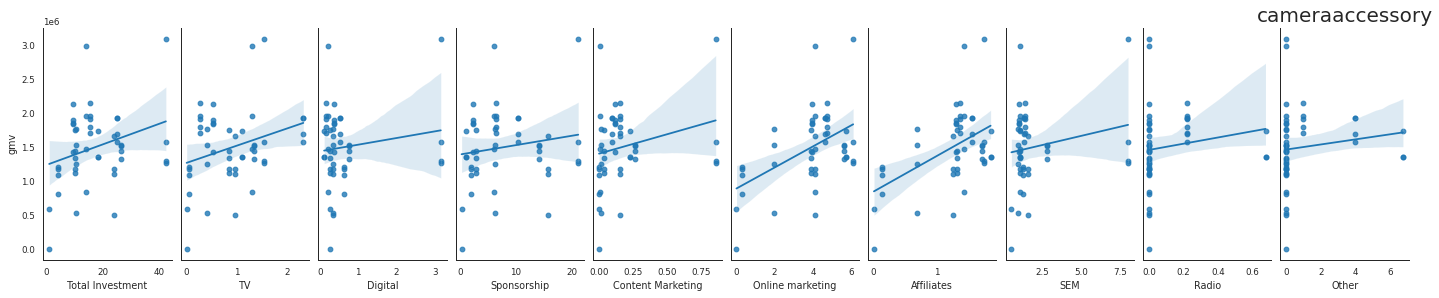

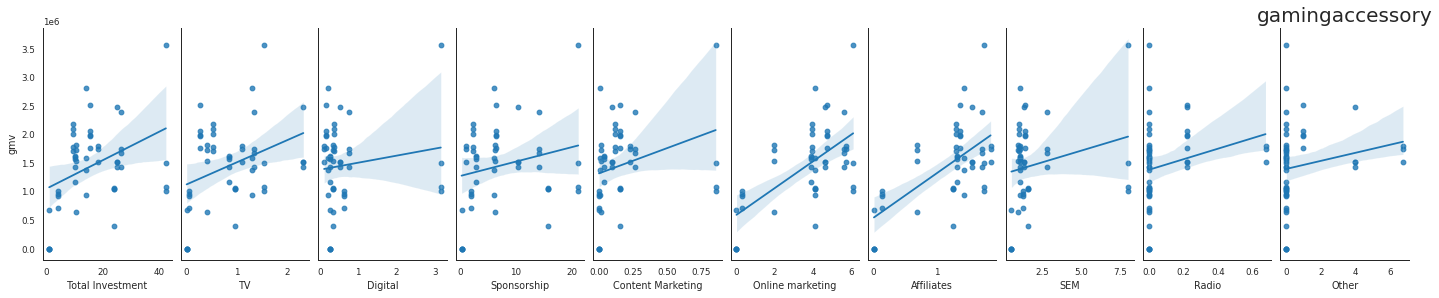

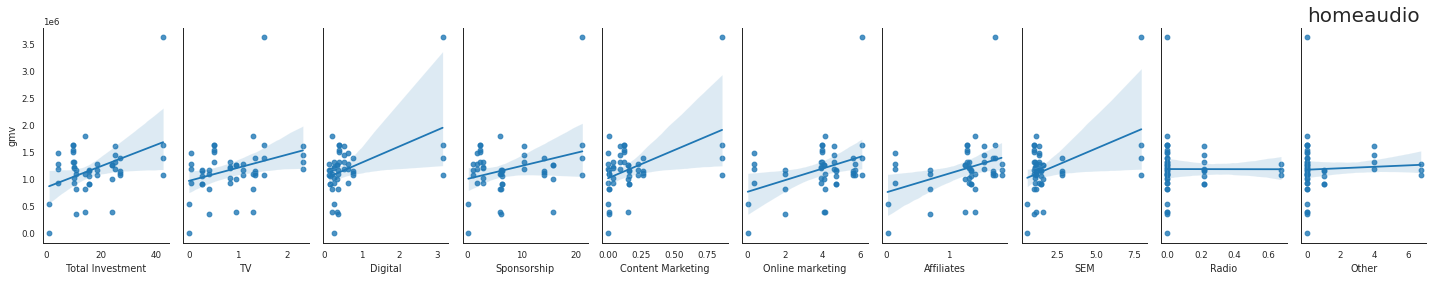

In [1225]:
# Slightly alter the figure size to make it more horizontal.
#plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster


sns.pairplot(Camera_accessory_df, x_vars=['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', \
                                      'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'], \
             y_vars='gmv',size=4, aspect=0.5, kind='reg')
plt.title('cameraaccessory', fontsize = 20)

sns.pairplot(gaming_accessory_df, x_vars=['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', \
                                      'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'], \
             y_vars='gmv',size=4, aspect=0.5, kind='reg')
plt.title('gamingaccessory', fontsize = 20)

sns.pairplot(Homeaudio_df, x_vars=['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', \
                                      'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'], \
             y_vars='gmv',size=4, aspect=0.5, kind='reg')
plt.title('homeaudio', fontsize = 20)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

In [1226]:
Camera_accessory_df.drop(['Week'], axis = 1, inplace = True)
gaming_accessory_df.drop(['Week'], axis = 1, inplace = True)
Homeaudio_df.drop(['Week'], axis = 1, inplace = True)

In [1227]:
Camera_accessory_org_df = Camera_accessory_df.copy()
gaming_accessory_org_df = gaming_accessory_df.copy()
Homeaudio_org_df = Homeaudio_df.copy()

# Step 4 - Model Building


In [1228]:
#Function to calculate the elasticity of the important KPIs
def calculateElasticity(df_train, gmv, coefficient_df):
    elasticity = []
    for i in coefficient_df.feature:
        feature_mean = df_train[i].mean()
        elasticity.append((((coefficient_df.loc[coefficient_df['feature']==i]['coefficient'].mean())*feature_mean)/gmv.mean()))
    coefficient_df['elasticity'] = pd.Series(elasticity)
    return coefficient_df

## Building Linear Regression Model for HomeAudio


In [1229]:
# Split the datafram into train and test sets
from sklearn.model_selection import train_test_split

In [1230]:
np.random.seed(0)
df_train, df_test = train_test_split(Homeaudio_df, train_size = 0.7, test_size = 0.3, random_state = 100)

####Rescaling the Features


In [1231]:
Homeaudio_df.columns


Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'special_sales', 'product_vertical_Dock', 'product_vertical_DockingStation', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_vertical_SoundMixer', 'product_vertical_VoiceRecorder', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5',
    

In [1232]:
from sklearn.preprocessing import MinMaxScaler


In [1233]:
scaler = MinMaxScaler()


In [1234]:
num_vars = ['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'special_sales', 
'product_vertical_Dock', 'product_vertical_DockingStation', 
'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 
'product_mrp', 'product_vertical_SoundMixer', 'product_vertical_VoiceRecorder', 
'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 
'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 
'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 
'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 
'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 
'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 
'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 
'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Online marketing_EMA_8', 
'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 
'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 
'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 
'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other', 
'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 
'NPS_SMA_3', 'NPS_SMA_5', 'Stock Index', 'Stock Index_SMA_3', 
'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 
'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)',
 'Total Precip (mm)', 'Snow on Grnd (cm)']

In [1235]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1236]:
df_train.describe()


gmv  Discount%  deliverybdays  deliverycdays   sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  special_sales  product_vertical_Dock  product_vertical_DockingStation  product_vertical_FMRadio  product_vertical_HiFiSystem  product_vertical_HomeAudioSpeaker  product_mrp  product_vertical_SoundMixer  product_vertical_VoiceRecorder  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock    TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  \
count 33.00      33.00          33.00          33.00 33.00                    33.00                       33.00           33.00          33.00                  33.00                            33.00                     33.00                        33.00                              33.00        33.00                        33.00                           33.00     33.00         33.00             33.00                   33.00                   33.00                   33.00                      33.00 33.00     33.00     33.00     33.00        33.00    33.00          33.00          33.00          33.00             33.00        33.00              33.00              33.00              33.00                 33.00              33.00                    33.00                    33.00                    33.00                       33.00             33.00                   33.00                   33.00                   33.00                      33.00       33.00             33.00   
mean   0.65       0.73           0.22           0.22  0.41                     0.56                        0.29            0.66           0.08                   0.50                             0.28                      0.62                         0.45                               0.67         0.14                         0.06                            0.32      0.45          0.27              0.41                    0.43                    0.46                    0.47                       0.41  0.40      0.42      0.44      0.51         0.44     0.17           0.21           0.24           0.23              0.18         0.37               0.39               0.40               0.39                  0.36               0.20                     0.21                     0.26                     0.30                        0.23              0.65                    0.66                    0.69                    0.67                       0.68        0.69              0.69   
std    0.19       0.18           0.37           0.37  0.17                     0.28                        0.20            0.20           0.23                   0.27                             0.23                      0.20                         0.20                               0.22         0.17                         0.24                            0.24      0.51          0.45              0.26                    0.24                    0.25                    0.24                       0.23  0.26      0.26      0.27      0.28         0.26     0.27           0.24           0.27           0.25              0.24         0.31               0.28               0.27               0.25                  0.26               0.28                     0.25                     0.27                     0.25                        0.24              0.30                    0.28                    0.30                    0.30                       0.29        0.29              0.28   
min    0.00       0.00           0.00           0.00

Dividing into X and Y sets for the model building


In [1237]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1238]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import metrics

####Building the first model with all the features


In [1239]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [1240]:
# Print the coefficients and intercept
print(lm.coef_)
print(lm.intercept_)

[ 6.41812510e-02  3.20408325e-03  2.85180734e-03 -9.39601756e-02
 -5.03373645e-02  4.44944174e-02  2.05731692e-01 -1.46712299e-02
  1.41418017e-03 -4.10733949e-02  1.81401235e-01  1.61258727e-01
  2.77884070e-01  6.50349409e-02  1.08055705e-02  1.98793544e-01
  4.29827945e-05  2.49420677e-02 -5.67472327e-04 -1.22601131e-02
  2.24206672e-02  8.73354724e-03  1.04768154e-02 -5.72877461e-02
 -5.13449885e-02 -2.00455854e-02 -4.38869130e-02 -4.15591521e-02
 -2.27278454e-02  3.55547337e-02  1.78796326e-02 -1.00009575e-02
  2.02032045e-02  3.91689469e-02 -1.08608377e-03  3.06119732e-02
  3.68969864e-03  2.02396704e-02 -1.52702433e-02  2.67114616e-02
  4.34329348e-02  2.63085261e-02  3.02642777e-02 -2.05664706e-02
 -3.99982339e-02  3.39480145e-02  1.51159002e-02 -2.79446083e-03
 -2.93254736e-02 -3.58655442e-02  3.30280049e-02  1.37995580e-02
 -3.79823636e-03 -3.56157028e-02 -2.97074014e-03 -1.41467288e-03
 -2.99004930e-02 -6.06181074e-03 -3.11187160e-02 -4.42254937e-02
 -1.35179508e-02  5.94904

### Model Building Using RFE


In [1241]:
# Import RFE
from sklearn.feature_selection import RFE


lm = LinearRegression()

lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)


# Print the boolean results
print(rfe.support_)           
print(rfe.ranking_)  

[False False False  True False False False False False False  True  True
  True  True False  True False False False False  True False False False
 False  True False False  True  True False False False  True False  True
 False False False  True  True False False False  True  True False False
 False False False False False False False False False False False False
 False  True False False False False  True False False False False False
 False  True  True False False False False False False False False]
[19 52 58  1 20  6  9 27 59  7  1  1  1  1 41  1 64 23 63 36  1 47 39 21
 29  1 10 18  1  1 45 46 37  1 62  1 53 25 28  1  1 15 31  2  1  1 30 56
  3 40 14 35 54 16 57 60 33 50 26 12 38  1 61 42  5 55  1 44  4 13  8 22
 49  1  1 48 24 17 32 34 11 51 43]


In [1242]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Discount%', False, 19),
 ('deliverybdays', False, 52),
 ('deliverycdays', False, 58),
 ('sla', True, 1),
 ('product_procurement_sla', False, 20),
 ('order_payment_type_Prepaid', False, 6),
 ('is_mass_market', False, 9),
 ('special_sales', False, 27),
 ('product_vertical_Dock', False, 59),
 ('product_vertical_DockingStation', False, 7),
 ('product_vertical_FMRadio', True, 1),
 ('product_vertical_HiFiSystem', True, 1),
 ('product_vertical_HomeAudioSpeaker', True, 1),
 ('product_mrp', True, 1),
 ('product_vertical_SoundMixer', False, 41),
 ('product_vertical_VoiceRecorder', True, 1),
 ('pay_week', False, 64),
 ('holiday_week', False, 23),
 ('Total Investment', False, 63),
 ('Total Investment_SMA_3', False, 36),
 ('Total Investment_SMA_5', True, 1),
 ('Total Investment_EMA_8', False, 47),
 ('Total_Investment_Ad_Stock', False, 39),
 ('TV', False, 21),
 ('TV_SMA_3', False, 29),
 ('TV_SMA_5', True, 1),
 ('TV_EMA_8', False, 10),
 ('TV_Ad_Stock', False, 18),
 ('Digital', True, 1),
 ('Digital

In [1243]:
col = X_train.columns[rfe.support_]
col

Index(['sla', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_vertical_VoiceRecorder', 'Total Investment_SMA_5', 'TV_SMA_5', 'Digital', 'Digital_SMA_3', 'Sponsorship', 'Sponsorship_SMA_5', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Radio_EMA_8', 'Other_EMA_8', 'Stock Index_SMA_5', 'Max Temp'], dtype='object')

In [1244]:
X_train.columns[~rfe.support_]

Index(['Discount%', 'deliverybdays', 'deliverycdays', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'special_sales', 'product_vertical_Dock', 'product_vertical_DockingStation', 'product_vertical_SoundMixer', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship_SMA_3', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_Ad_Stock', 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5',
       'St

Building model using statsmodel, for the detailed statistic


In [1245]:
# Import statsmodels
import statsmodels.api as sm  

In [1246]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1247]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [1248]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [1249]:
lm.params

const                                0.31
sla                                 -0.16
product_vertical_FMRadio             0.39
product_vertical_HiFiSystem          0.10
product_vertical_HomeAudioSpeaker    0.40
product_mrp                          0.13
product_vertical_VoiceRecorder       0.17
Total Investment_SMA_5              -0.72
TV_SMA_5                             0.00
Digital                             -0.16
Digital_SMA_3                       -0.08
Sponsorship                          0.14
Sponsorship_SMA_5                    0.35
Content Marketing_SMA_3              0.25
Content Marketing_SMA_5              0.22
Online marketing_SMA_3              -0.31
Online marketing_SMA_5               0.34
Radio_EMA_8                          0.03
Other_EMA_8                          0.02
Stock Index_SMA_5                   -0.14
Max Temp                            -0.10
dtype: float64

In [1250]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     647.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.13e-15
Time:                        10:34:05   Log-Likelihood:                 123.91
No. Observations:                  33   AIC:                            -205.8
Df Residuals:                      12   BIC:                            -174.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [1251]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1252]:
#Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
7              Total Investment_SMA_5 2770.49
12                  Sponsorship_SMA_5  689.13
0                               const  594.28
17                        Radio_EMA_8  476.58
18                        Other_EMA_8  333.23
16             Online marketing_SMA_5  321.16
8                            TV_SMA_5  291.71
14            Content Marketing_SMA_5  259.26
15             Online marketing_SMA_3  174.06
13            Content Marketing_SMA_3  129.52
10                      Digital_SMA_3   55.05
11                        Sponsorship   28.95
9                             Digital   20.39
4   product_vertical_HomeAudioSpeaker   19.12
5                         product_mrp   18.38
19                  Stock Index_SMA_5   15.75
2            product_vertical_FMRadio   15.50
1                                 sla   14.26
6      product_vertical_VoiceRecorder   13.10
20                           Max Temp   12.16
3         product_vertical_HiFiSystem    8.16

In [1253]:
# drop Digital due to high p-value

X_train_rfe.drop('Digital', axis = 1, inplace = True)

In [1254]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model with 9 variables
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                0.23
sla                                 -0.13
product_vertical_FMRadio             0.34
product_vertical_HiFiSystem          0.04
product_vertical_HomeAudioSpeaker    0.52
product_mrp                          0.04
product_vertical_VoiceRecorder       0.15
Total Investment_SMA_5              -0.17
TV_SMA_5                            -0.01
Digital_SMA_3                       -0.11
Sponsorship                          0.02
Sponsorship_SMA_5                    0.05
Content Marketing_SMA_3              0.15
Content Marketing_SMA_5              0.11
Online marketing_SMA_3              -0.14
Online marketing_SMA_5               0.06
Radio_EMA_8                         -0.01
Other_EMA_8                         -0.03
Stock Index_SMA_5                   -0.06
Max Temp                            -0.06
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                

In [1255]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
7              Total Investment_SMA_5 2564.94
11                  Sponsorship_SMA_5  618.04
0                               const  535.49
16                        Radio_EMA_8  475.69
17                        Other_EMA_8  331.53
8                            TV_SMA_5  291.61
13            Content Marketing_SMA_5  250.11
15             Online marketing_SMA_5  245.61
14             Online marketing_SMA_3  146.92
12            Content Marketing_SMA_3  123.10
9                       Digital_SMA_3   54.10
5                         product_mrp   15.96
2            product_vertical_FMRadio   14.27
1                                 sla   13.94
10                        Sponsorship   13.34
6      product_vertical_VoiceRecorder   13.00
4   product_vertical_HomeAudioSpeaker   12.26
19                           Max Temp   10.70
18                  Stock Index_SMA_5   10.24
3         product_vertical_HiFiSystem    6.45

In [1256]:
X_train_rfe.drop('Other_EMA_8', axis = 1, inplace = True)


In [1257]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit()  
print(lm.params)
print(lm.summary())

const                                0.24
sla                                 -0.13
product_vertical_FMRadio             0.33
product_vertical_HiFiSystem          0.04
product_vertical_HomeAudioSpeaker    0.51
product_mrp                          0.04
product_vertical_VoiceRecorder       0.15
Total Investment_SMA_5              -0.12
TV_SMA_5                            -0.03
Digital_SMA_3                       -0.12
Sponsorship                          0.02
Sponsorship_SMA_5                    0.03
Content Marketing_SMA_3              0.16
Content Marketing_SMA_5              0.09
Online marketing_SMA_3              -0.13
Online marketing_SMA_5               0.06
Radio_EMA_8                         -0.05
Stock Index_SMA_5                   -0.06
Max Temp                            -0.06
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                       

In [1258]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
7              Total Investment_SMA_5 1811.19
0                               const  506.21
11                  Sponsorship_SMA_5  459.17
15             Online marketing_SMA_5  245.59
13            Content Marketing_SMA_5  157.66
14             Online marketing_SMA_3  143.35
12            Content Marketing_SMA_3  104.97
8                            TV_SMA_5  104.89
9                       Digital_SMA_3   50.05
16                        Radio_EMA_8   29.84
5                         product_mrp   15.38
2            product_vertical_FMRadio   13.89
1                                 sla   13.76
6      product_vertical_VoiceRecorder   12.69
4   product_vertical_HomeAudioSpeaker   10.58
18                           Max Temp   10.51
10                        Sponsorship    9.01
17                  Stock Index_SMA_5    8.99
3         product_vertical_HiFiSystem    5.03

In [1259]:
X_train_rfe.drop('Total Investment_SMA_5', axis = 1, inplace = True)


In [1260]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit() 
print(lm.params)
print(lm.summary())

const                                0.24
sla                                 -0.14
product_vertical_FMRadio             0.33
product_vertical_HiFiSystem          0.05
product_vertical_HomeAudioSpeaker    0.51
product_mrp                          0.04
product_vertical_VoiceRecorder       0.16
TV_SMA_5                            -0.06
Digital_SMA_3                       -0.11
Sponsorship                          0.02
Sponsorship_SMA_5                   -0.02
Content Marketing_SMA_3              0.15
Content Marketing_SMA_5              0.06
Online marketing_SMA_3              -0.12
Online marketing_SMA_5               0.03
Radio_EMA_8                         -0.06
Stock Index_SMA_5                   -0.07
Max Temp                            -0.07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                

In [1261]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                               const 477.84
11            Content Marketing_SMA_3  99.58
13             Online marketing_SMA_3  94.89
14             Online marketing_SMA_5  77.82
8                       Digital_SMA_3  48.06
12            Content Marketing_SMA_5  42.41
10                  Sponsorship_SMA_5  17.80
5                         product_mrp  15.16
2            product_vertical_FMRadio  13.82
7                            TV_SMA_5  13.45
6      product_vertical_VoiceRecorder  11.33
1                                 sla  11.17
4   product_vertical_HomeAudioSpeaker  10.39
17                           Max Temp   9.46
15                        Radio_EMA_8   7.81
9                         Sponsorship   7.73
16                  Stock Index_SMA_5   7.17
3         product_vertical_HiFiSystem   3.96

In [1262]:
X_train_rfe.drop('Online marketing_SMA_5', axis = 1, inplace = True)


In [1263]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit() 
print(lm.params)
print(lm.summary())

const                                0.25
sla                                 -0.15
product_vertical_FMRadio             0.33
product_vertical_HiFiSystem          0.05
product_vertical_HomeAudioSpeaker    0.51
product_mrp                          0.05
product_vertical_VoiceRecorder       0.17
TV_SMA_5                            -0.06
Digital_SMA_3                       -0.12
Sponsorship                          0.02
Sponsorship_SMA_5                   -0.02
Content Marketing_SMA_3              0.14
Content Marketing_SMA_5              0.08
Online marketing_SMA_3              -0.09
Radio_EMA_8                         -0.06
Stock Index_SMA_5                   -0.07
Max Temp                            -0.07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squa

In [1264]:
#Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                               const 324.54
11            Content Marketing_SMA_3  95.55
8                       Digital_SMA_3  47.95
13             Online marketing_SMA_3  35.47
12            Content Marketing_SMA_5  24.70
10                  Sponsorship_SMA_5  17.79
5                         product_mrp  14.18
2            product_vertical_FMRadio  13.63
7                            TV_SMA_5  12.30
4   product_vertical_HomeAudioSpeaker   8.94
6      product_vertical_VoiceRecorder   7.78
9                         Sponsorship   7.72
14                        Radio_EMA_8   7.53
1                                 sla   7.34
16                           Max Temp   7.03
15                  Stock Index_SMA_5   6.97
3         product_vertical_HiFiSystem   3.81

In [1265]:
X_train_rfe.drop('Online marketing_SMA_3', axis = 1, inplace = True)


In [1266]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)
print(lm.summary())

const                                0.22
sla                                 -0.17
product_vertical_FMRadio             0.36
product_vertical_HiFiSystem          0.05
product_vertical_HomeAudioSpeaker    0.49
product_mrp                          0.10
product_vertical_VoiceRecorder       0.15
TV_SMA_5                            -0.10
Digital_SMA_3                       -0.05
Sponsorship                          0.02
Sponsorship_SMA_5                   -0.02
Content Marketing_SMA_3              0.04
Content Marketing_SMA_5              0.09
Radio_EMA_8                         -0.06
Stock Index_SMA_5                   -0.09
Max Temp                            -0.07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     281

In [1267]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                               const 264.23
11            Content Marketing_SMA_3  53.21
8                       Digital_SMA_3  32.91
12            Content Marketing_SMA_5  24.53
10                  Sponsorship_SMA_5  17.51
2            product_vertical_FMRadio  11.86
5                         product_mrp   9.67
4   product_vertical_HomeAudioSpeaker   8.55
9                         Sponsorship   7.71
13                        Radio_EMA_8   7.34
6      product_vertical_VoiceRecorder   7.31
7                            TV_SMA_5   7.18
1                                 sla   6.86
15                           Max Temp   6.83
14                  Stock Index_SMA_5   4.44
3         product_vertical_HiFiSystem   3.74

In [1268]:
X_train_rfe.drop('Content Marketing_SMA_3', axis = 1, inplace = True)


In [1269]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit() 
print(lm.params)
print(lm.summary())

const                                0.21
sla                                 -0.16
product_vertical_FMRadio             0.35
product_vertical_HiFiSystem          0.05
product_vertical_HomeAudioSpeaker    0.50
product_mrp                          0.10
product_vertical_VoiceRecorder       0.15
TV_SMA_5                            -0.10
Digital_SMA_3                       -0.02
Sponsorship                          0.02
Sponsorship_SMA_5                   -0.01
Content Marketing_SMA_5              0.09
Radio_EMA_8                         -0.05
Stock Index_SMA_5                   -0.09
Max Temp                            -0.06
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     315.3
Date:                Sat, 11 Mar 2023  

In [1270]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                               const 222.02
11            Content Marketing_SMA_5  22.73
10                  Sponsorship_SMA_5  14.77
8                       Digital_SMA_3  11.97
2            product_vertical_FMRadio  10.31
5                         product_mrp   9.01
6      product_vertical_VoiceRecorder   7.28
14                           Max Temp   6.76
4   product_vertical_HomeAudioSpeaker   6.74
9                         Sponsorship   6.31
7                            TV_SMA_5   6.16
1                                 sla   5.80
13                  Stock Index_SMA_5   4.33
3         product_vertical_HiFiSystem   3.74
12                        Radio_EMA_8   3.36

In [1271]:
X_train_rfe.drop('Sponsorship_SMA_5', axis = 1, inplace = True)


In [1272]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit() 
print(lm.params)
print(lm.summary())

const                                0.21
sla                                 -0.16
product_vertical_FMRadio             0.35
product_vertical_HiFiSystem          0.06
product_vertical_HomeAudioSpeaker    0.50
product_mrp                          0.10
product_vertical_VoiceRecorder       0.15
TV_SMA_5                            -0.10
Digital_SMA_3                       -0.02
Sponsorship                          0.02
Content Marketing_SMA_5              0.09
Radio_EMA_8                         -0.04
Stock Index_SMA_5                   -0.09
Max Temp                            -0.07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     357.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.69e-20
Ti

In [1273]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                               const 211.87
10            Content Marketing_SMA_5  14.06
8                       Digital_SMA_3  11.37
2            product_vertical_FMRadio   9.76
5                         product_mrp   8.79
6      product_vertical_VoiceRecorder   7.19
4   product_vertical_HomeAudioSpeaker   6.50
1                                 sla   5.54
13                           Max Temp   5.37
9                         Sponsorship   4.65
12                  Stock Index_SMA_5   4.25
3         product_vertical_HiFiSystem   3.66
7                            TV_SMA_5   3.63
11                        Radio_EMA_8   3.06

In [1274]:
X_train_rfe.drop('Digital_SMA_3', axis = 1, inplace = True)


In [1275]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit()  
print(lm.params)
print(lm.summary())

const                                0.21
sla                                 -0.16
product_vertical_FMRadio             0.35
product_vertical_HiFiSystem          0.06
product_vertical_HomeAudioSpeaker    0.50
product_mrp                          0.08
product_vertical_VoiceRecorder       0.15
TV_SMA_5                            -0.10
Sponsorship                          0.01
Content Marketing_SMA_5              0.07
Radio_EMA_8                         -0.04
Stock Index_SMA_5                   -0.08
Max Temp                            -0.07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     400.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.44e-21
Time:                        10:34:07   Log-

In [1276]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                               const 211.45
2            product_vertical_FMRadio   9.74
6      product_vertical_VoiceRecorder   6.91
5                         product_mrp   6.76
4   product_vertical_HomeAudioSpeaker   6.48
12                           Max Temp   5.37
1                                 sla   5.24
9             Content Marketing_SMA_5   3.90
3         product_vertical_HiFiSystem   3.64
7                            TV_SMA_5   3.63
11                  Stock Index_SMA_5   3.15
10                        Radio_EMA_8   2.98
8                         Sponsorship   2.43

In [1277]:
X_train_rfe.drop('product_vertical_FMRadio', axis = 1, inplace = True)


In [1278]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit()  
print(lm.params)
print(lm.summary())

const                                0.24
sla                                  0.06
product_vertical_HiFiSystem          0.13
product_vertical_HomeAudioSpeaker    0.54
product_mrp                         -0.19
product_vertical_VoiceRecorder       0.31
TV_SMA_5                            -0.13
Sponsorship                          0.04
Content Marketing_SMA_5              0.15
Radio_EMA_8                         -0.06
Stock Index_SMA_5                   -0.11
Max Temp                             0.00
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     102.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.16e-15
Time:                        10:34:07   Log-Likelihood:                 74.606
No. Obs

In [1279]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                               const 210.29
3   product_vertical_HomeAudioSpeaker   6.35
11                           Max Temp   4.53
5      product_vertical_VoiceRecorder   4.06
6                            TV_SMA_5   3.51
2         product_vertical_HiFiSystem   3.19
8             Content Marketing_SMA_5   3.03
10                  Stock Index_SMA_5   3.03
9                         Radio_EMA_8   2.95
4                         product_mrp   2.81
1                                 sla   2.72
7                         Sponsorship   2.28

In [1280]:
X_train_rfe.drop('product_vertical_HiFiSystem', axis = 1, inplace = True)


In [1281]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)
print(lm.summary())

const                                0.22
sla                                  0.06
product_vertical_HomeAudioSpeaker    0.65
product_mrp                         -0.18
product_vertical_VoiceRecorder       0.30
TV_SMA_5                            -0.10
Sponsorship                          0.02
Content Marketing_SMA_5              0.11
Radio_EMA_8                         -0.09
Stock Index_SMA_5                   -0.10
Max Temp                             0.00
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     87.06
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.54e-15
Time:                        10:34:07   Log-Likelihood:                 69.761
No. Observations:                  33   AIC:     

In [1282]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                               const 208.68
10                           Max Temp   4.53
4      product_vertical_VoiceRecorder   4.03
2   product_vertical_HomeAudioSpeaker   3.76
5                            TV_SMA_5   3.15
9                   Stock Index_SMA_5   2.96
3                         product_mrp   2.80
1                                 sla   2.72
8                         Radio_EMA_8   2.72
7             Content Marketing_SMA_5   2.66
6                         Sponsorship   2.12

In [1283]:
X_train_rfe.drop('Max Temp', axis = 1, inplace = True)


In [1284]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit()  
print(lm.params)
print(lm.summary())

const                                0.22
sla                                  0.06
product_vertical_HomeAudioSpeaker    0.65
product_mrp                         -0.18
product_vertical_VoiceRecorder       0.30
TV_SMA_5                            -0.10
Sponsorship                          0.02
Content Marketing_SMA_5              0.11
Radio_EMA_8                         -0.09
Stock Index_SMA_5                   -0.10
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     101.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.43e-16
Time:                        10:34:07   Log-Likelihood:                 69.760
No. Observations:                  33   AIC:                            -119.5
Df Residuals

In [1285]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                              const 42.03
3                        product_mrp  2.77
4     product_vertical_VoiceRecorder  2.67
7            Content Marketing_SMA_5  2.16
2  product_vertical_HomeAudioSpeaker  2.11
9                  Stock Index_SMA_5  2.04
1                                sla  2.01
6                        Sponsorship  1.91
8                        Radio_EMA_8  1.90
5                           TV_SMA_5  1.79

In [1286]:
X_train_rfe.drop('Stock Index_SMA_5', axis = 1, inplace = True)


In [1287]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit() 
print(lm.params)
print(lm.summary())

const                                0.15
sla                                  0.05
product_vertical_HomeAudioSpeaker    0.70
product_mrp                         -0.18
product_vertical_VoiceRecorder       0.23
TV_SMA_5                            -0.10
Sponsorship                         -0.01
Content Marketing_SMA_5              0.07
Radio_EMA_8                         -0.10
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     82.67
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.40e-15
Time:                        10:34:07   Log-Likelihood:                 63.967
No. Observations:                  33   AIC:                            -109.9
Df Residuals:                      24   BIC:          

In [1288]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                              const 27.51
3                        product_mrp  2.77
4     product_vertical_VoiceRecorder  2.04
1                                sla  2.01
8                        Radio_EMA_8  1.86
5                           TV_SMA_5  1.79
2  product_vertical_HomeAudioSpeaker  1.71
6                        Sponsorship  1.70
7            Content Marketing_SMA_5  1.70

In [1289]:
X_train_rfe.drop('product_mrp', axis = 1, inplace = True)


In [1290]:
X_train_rfe = sm.add_constant(X_train_rfe)

# Fitting the model with 8 variables
lm = sm.OLS(y_train, X_train_rfe).fit() 
print(lm.params)
print(lm.summary())

const                                0.11
sla                                 -0.04
product_vertical_HomeAudioSpeaker    0.76
product_vertical_VoiceRecorder       0.23
TV_SMA_5                            -0.09
Sponsorship                          0.02
Content Marketing_SMA_5              0.08
Radio_EMA_8                         -0.10
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     77.55
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.31e-15
Time:                        10:34:07   Log-Likelihood:                 60.190
No. Observations:                  33   AIC:                            -104.4
Df Residuals:                      25   BIC:                            -92.41
Df Model:        

In [1291]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                              const 23.43
3     product_vertical_VoiceRecorder  2.03
7                        Radio_EMA_8  1.85
4                           TV_SMA_5  1.76
6            Content Marketing_SMA_5  1.66
5                        Sponsorship  1.49
2  product_vertical_HomeAudioSpeaker  1.33
1                                sla  1.18

Elasticity


In [1292]:
coefficients_df = pd.DataFrame(pd.DataFrame(lm.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

<AxesSubplot:xlabel='elasticity', ylabel='feature'>

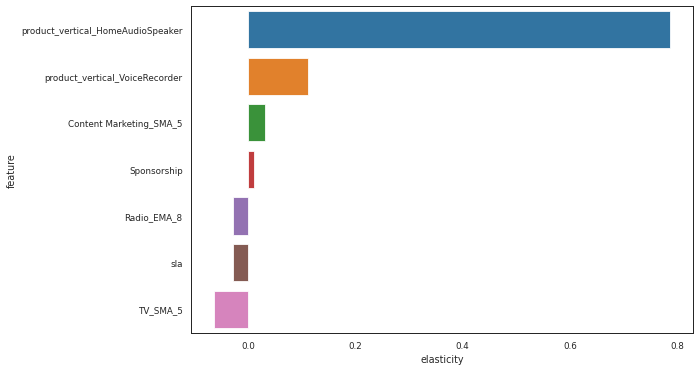

In [1293]:
plt.figure(figsize = (9,6))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### Model Evaluation


In [1294]:
X_train_rfe.columns

Index(['const', 'sla', 'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder', 'TV_SMA_5', 'Sponsorship', 'Content Marketing_SMA_5', 'Radio_EMA_8'], dtype='object')

In [1295]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Sponsorship_SMA_3', 'deliverycdays', 'Affiliates_Ad_Stock', 'Online marketing', 'Mean Temp', 'product_vertical_DockingStation', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'Other_Ad_Stock', 'pay_week', 'TV_EMA_8', 'Stock Index_SMA_5', 'Sponsorship_EMA_8', 'Radio_Ad_Stock', 'Min Temp', 'Affiliates_SMA_5', 'order_payment_type_Prepaid', 'SEM_Ad_Stock', 'NPS', 'TV', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'product_vertical_Dock', 'product_vertical_HiFiSystem', 'product_vertical_SoundMixer', 'Total Precip (mm)', 'is_mass_market', 'Sponsorship_SMA_5', 'Discount%', 'gmv', 'Sponsorship_Ad_Stock', 'Total Snow (cm)', 'product_vertical_FMRadio', 'SEM_EMA_8', 'SEM', 'Cool Deg Days', 'Digital', 'deliverybdays', 'Online_marketing_Ad_Stock', 'Digital_EMA_8', 'holiday_week', 'Digital_SMA_3', 'Other_SMA_3', 'Radio',

In [1296]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ 0.56014367, -0.82294434,  0.848533  ,  0.97983831,  0.75980508,
        0.9703738 ,  0.34012778,  0.73407545, -0.9552403 ,  0.98263419])

In [1297]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)


In [1298]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.004872822592958363
r_square_value : 0.859328590777053


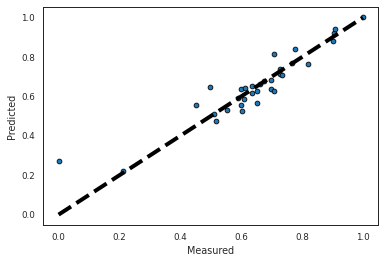

In [1299]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##Building Linear Regression Model for Camera Accessory


In [1300]:
np.random.seed(0)
df_train, df_test = train_test_split(Camera_accessory_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1301]:
Camera_accessory_df.columns

Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'product_mrp', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraAccessory', 'special_sales', 'product_vertical_CameraBag', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing', 'product_vertical_CameraMicrophone', 'product_vertical_CameraMount', 'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_Filter', 'product_vertical_Flash', 'product_vertical_FlashShoeAdapter', 'product_vertical_Lens', 'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox', 'product_vertical_Strap', 'product_vertical_Telescope', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8',
    

In [1302]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


In [1303]:
num_vars = ['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'product_mrp', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraAccessory', 'special_sales', 'product_vertical_CameraBag', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing', 'product_vertical_CameraMicrophone', 'product_vertical_CameraMount', 'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_Filter', 'product_vertical_Flash', 'product_vertical_FlashShoeAdapter', 'product_vertical_Lens', 'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox', 'product_vertical_Strap', 'product_vertical_Telescope', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8',
       'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5', 'Stock Index', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days',
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)']

In [1304]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])


In [1305]:
df_train.head()


gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  \
13 0.65       0.87           0.97           0.98 0.35                     0.04         0.67                        1.00            0.64                              0.43           0.00                        0.56                            0.60                                   0.55                                0.25                           0.25                              0.36                            0.00                               0.80                          0.59                                  0.56                           0.29                            0.25                     0.45                    0.63                               0.00                   0.58                                0.00                      0.00                    0.54                        0.58      0.00          0.00              0.32                    0.50                    0.59                    0.53                       0.46 0.56      0.85      1.00      0.94         0.85   
11 0.57       0.77           0.07           0.07 0.25                     0.06         0.48                        0.27            0.56                              0.57           0.00                        0.49                            0.96                                   0.75                                0.75                           0.17                              0.31                            0.00                               0.40                          0.69                                  0.60                           0.20                            0.75                     0.42                    0.51                               0.00                   0.40                                0.00                      0.00                    0.59                        0.58      0.00          1.00              0.58                    0.59                    0.49                    0.53                       0.52 1.00      1.00      0.76      0.90         0.93   
33 0.39       0.62           0.00           0.00 0.59                     0.08         0.60                        0.13            0.30                              0.88           0.00                        0.52                            0.39                                   0.21                                0.00                           0.00                              0.13                            0.00                               0.00                          0.15                                  0.88                           0.20                            0.25                     0.54                    0.07                               0.00                   0.43                                0.00                      0.00                    0.21                        0.29      1.00          0.00              0.56                    0.39                    0.26                    0.24                       0.36 0.42      0.28      0.18      0.21         0.29   
23 0.51       0.87  

In [1306]:
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])


In [1307]:
df_train.describe()


gmv  Discount%  deliverybdays  deliverycdays   sla  product_procurement_sla  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock    TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  \
count 33.00      33.00          33.00          33.00 33.00                    33.00        33.00                       33.00           33.00                             33.00          33.00                       33.00                           33.00                                  33.00                               33.00                          33.00                             33.00                           33.00                              33.00                         33.00                                 33.00                          33.00                           33.00                    33.00                   33.00                              33.00                  33.00                               33.00                     33.00                   33.00                       33.00     33.00         33.00             33.00                   33.00                   33.00                   33.00                      33.00 33.00     33.00     33.00     33.00   
mean   0.50       0.73           0.24           0.25  0.43                     0.10         0.58                        0.21            0.46                              0.64           0.09                        0.55                            0.51                                   0.41                                0.31                           0.18                              0.30                            0.11                               0.11                          0.33                                  0.62                           0.24                            0.27                     0.52                    0.35                               0.06                   0.51                                0.00                      0.08                    0.40                        0.40      0.45          0.27              0.41                    0.43                    0.46                    0.47                       0.41  0.40      0.42      0.44      0.51   
std    0.16       0.17           0.41           0.41  0.18                     0.17         0.15                        0.21            0.19                              0.20           0.25                        0.18                            0.20                                   0.22                                0.28                           0.26                              0.21                            0.26                               0.24                          0.24                                  0.21                           0.16                            0.34                     0.16                    0.32                               0.24                   0.20                                0.00                      0.19                    0.17                        0.23      0.51          0.45              0.26                    0.24                    0.25                    0.24                       0.23  0.26      0.26      0.27      0.28   
min    0.00       0.00           0.00           0.00

###Dividing into X and Y sets for the model building


In [1308]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1309]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [1310]:
#Building the first model with all the features
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [1311]:
# Print the coefficients and intercept
print(lm.coef_)
print(lm.intercept_)

[ 3.46204823e-02 -1.30869498e-02 -7.37985686e-03 -6.90187579e-02
  2.77436941e-02  3.03996378e-02  5.12619991e-02  1.24778180e-01
  2.86885382e-02 -2.18364667e-02  9.11972001e-02  9.11159269e-02
  6.98515838e-02  1.07583253e-02 -1.07551100e-03 -5.03998993e-02
  1.07808555e-02  2.78324471e-02  5.90355228e-02  2.89294868e-02
  1.09037231e-01  2.34936076e-02  7.38985162e-02  1.56798390e-01
 -8.31212614e-02  5.69197407e-02  6.39354204e-04 -5.64137448e-02
  8.44710991e-02  2.52066790e-02  9.66168798e-03 -2.13305938e-02
 -1.30007001e-02  8.27789499e-04  1.14748370e-02 -2.50259227e-04
  7.48676207e-03 -8.28308935e-03 -2.87842876e-02  1.00181133e-02
 -1.84307572e-02 -1.22621521e-02 -5.54902865e-04  4.73454805e-03
 -2.48960602e-03 -1.62147429e-02  3.86667391e-05 -5.05125880e-02
  2.33040109e-02  1.92402483e-02  4.32672576e-03  1.23380280e-02
  8.05141347e-03  3.43533334e-03  7.45764496e-03 -5.05287492e-03
  6.87126005e-03  3.08136446e-02 -3.63420988e-02  3.23146969e-02
  2.92594568e-03 -2.27082

####Model Building Using RFE


In [1312]:
# Import RFE
from sklearn.feature_selection import RFE

In [1313]:
lm = LinearRegression()

lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1314]:
# Print the boolean results
print(rfe.support_)           
print(rfe.ranking_) 

[False False False False False False  True  True  True False  True  True
 False False False False False False False  True  True  True False  True
  True False False  True  True False False False False False False False
 False False False False False False False False False False False  True
 False  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True False False False False False
 False False False False  True False False False False False False  True
  True]
[49 45 23  5 16 12  1  1  1  6  1  1  3 37 77 10 74 25 26  1  1  1 13  1
  1  9 72  1  1 24 39 34 62 66 30 68 44 52 15 61 14 32 70 35 65 36 78  1
 22  1  1 41 60 57 53 54 40 28 21 20 43 69 11 27 17 63 18 29 56 48 38 71
 50  2 75 64 47  1  1 76  8 31 51 42 55 73 59 67  1 33 46 19 58  7  4  1
  1]


In [1315]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))


[('Discount%', False, 49),
 ('deliverybdays', False, 45),
 ('deliverycdays', False, 23),
 ('sla', False, 5),
 ('product_procurement_sla', False, 16),
 ('product_mrp', False, 12),
 ('order_payment_type_Prepaid', True, 1),
 ('is_mass_market', True, 1),
 ('product_vertical_CameraAccessory', True, 1),
 ('special_sales', False, 6),
 ('product_vertical_CameraBag', True, 1),
 ('product_vertical_CameraBattery', True, 1),
 ('product_vertical_CameraBatteryCharger', False, 3),
 ('product_vertical_CameraBatteryGrip', False, 37),
 ('product_vertical_CameraEyeCup', False, 77),
 ('product_vertical_CameraFilmRolls', False, 10),
 ('product_vertical_CameraHousing', False, 74),
 ('product_vertical_CameraMicrophone', False, 25),
 ('product_vertical_CameraMount', False, 26),
 ('product_vertical_CameraRemoteControl', True, 1),
 ('product_vertical_CameraTripod', True, 1),
 ('product_vertical_ExtensionTube', True, 1),
 ('product_vertical_Filter', False, 13),
 ('product_vertical_Flash', True, 1),
 ('product_ve

In [1316]:
col = X_train.columns[rfe.support_]
col

Index(['order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraAccessory', 'product_vertical_CameraBag', 'product_vertical_CameraBattery', 'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_Flash', 'product_vertical_FlashShoeAdapter', 'product_vertical_Softbox', 'product_vertical_Strap', 'Sponsorship', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Other', 'Other_SMA_3', 'Max Temp', 'Total Precip (mm)', 'Snow on Grnd (cm)'], dtype='object')

In [1317]:
X_train.columns[~rfe.support_]


Index(['Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'product_mrp', 'special_sales', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing', 'product_vertical_CameraMicrophone', 'product_vertical_CameraMount', 'product_vertical_Filter', 'product_vertical_Lens', 'product_vertical_ReflectorUmbrella', 'product_vertical_Telescope', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship_SMA_3', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing',
       'Online mar

####Building model using statsmodel, for the detailed statistic


In [1318]:
import statsmodels.api as sm

In [1319]:
X_train_rfe = X_train[col]

In [1320]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [1321]:
lm = sm.OLS(y_train,X_train_rfe).fit() 

In [1322]:
lm.params

const                                   0.04
order_payment_type_Prepaid              0.08
is_mass_market                          0.48
product_vertical_CameraAccessory        0.04
product_vertical_CameraBag              0.11
product_vertical_CameraBattery          0.09
product_vertical_CameraRemoteControl    0.07
product_vertical_CameraTripod           0.10
product_vertical_ExtensionTube          0.04
product_vertical_Flash                  0.04
product_vertical_FlashShoeAdapter      -0.04
product_vertical_Softbox               -0.06
product_vertical_Strap                  0.08
Sponsorship                            -0.04
Sponsorship_SMA_5                      -0.03
Sponsorship_EMA_8                       0.11
Other                                   0.08
Other_SMA_3                            -0.11
Max Temp                               -0.04
Total Precip (mm)                      -0.07
Snow on Grnd (cm)                      -0.05
dtype: float64

In [1323]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     471.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.10e-14
Time:                        10:34:12   Log-Likelihood:                 123.15
No. Observations:                  33   AIC:                            -204.3
Df Residuals:                      12   BIC:                            -172.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1324]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
2                         is_mass_market 319.47
9                 product_vertical_Flash 165.75
15                     Sponsorship_EMA_8  77.99
14                     Sponsorship_SMA_5  76.42
0                                  const  68.39
7          product_vertical_CameraTripod  27.70
4             product_vertical_CameraBag  17.00
5         product_vertical_CameraBattery  15.81
17                           Other_SMA_3  12.90
12                product_vertical_Strap  11.18
16                                 Other  10.91
8         product_vertical_ExtensionTube   9.94
6   product_vertical_CameraRemoteControl   5.87
13                           Sponsorship   5.39
1             order_payment_type_Prepaid   4.52
19                     Total Precip (mm)   4.45
18                              Max Temp   3.84
10     product_vertical_FlashShoeAdapter   3.70
3       product_vertical_CameraAccessory   3.12
20                     Snow on Grnd (cm)   3.01
11              product_vertical_Softbox   2.98

In [1325]:
X_train_rfe.drop('product_vertical_Flash', axis = 1, inplace = True) 


In [1326]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.04
order_payment_type_Prepaid              0.08
is_mass_market                          0.56
product_vertical_CameraAccessory        0.03
product_vertical_CameraBag              0.10
product_vertical_CameraBattery          0.08
product_vertical_CameraRemoteControl    0.06
product_vertical_CameraTripod           0.07
product_vertical_ExtensionTube          0.05
product_vertical_FlashShoeAdapter      -0.04
product_vertical_Softbox               -0.05
product_vertical_Strap                  0.08
Sponsorship                            -0.04
Sponsorship_SMA_5                      -0.02
Sponsorship_EMA_8                       0.10
Other                                   0.08
Other_SMA_3                            -0.11
Max Temp                               -0.04
Total Precip (mm)                      -0.07
Snow on Grnd (cm)                      -0.05
dtype: float64
                            OLS Regression Results                            
Dep. V

In [1327]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
13                     Sponsorship_SMA_5 74.54
14                     Sponsorship_EMA_8 74.09
0                                  const 67.52
2                         is_mass_market 14.06
16                           Other_SMA_3 12.70
11                product_vertical_Strap 11.08
15                                 Other 10.50
8         product_vertical_ExtensionTube  9.79
4             product_vertical_CameraBag  9.19
5         product_vertical_CameraBattery  6.09
6   product_vertical_CameraRemoteControl  5.74
12                           Sponsorship  5.07
1             order_payment_type_Prepaid  4.28
18                     Total Precip (mm)  4.17
17                              Max Temp  3.71
9      product_vertical_FlashShoeAdapter  3.58
3       product_vertical_CameraAccessory  3.07
19                     Snow on Grnd (cm)  2.98
10              product_vertical_Softbox  2.38
7          product_vertical_CameraTripod  2.14

In [1328]:
X_train_rfe.drop('Sponsorship_EMA_8', axis = 1, inplace = True)

In [1329]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model with 9 variables
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.04
order_payment_type_Prepaid              0.07
is_mass_market                          0.54
product_vertical_CameraAccessory        0.03
product_vertical_CameraBag              0.11
product_vertical_CameraBattery          0.07
product_vertical_CameraRemoteControl    0.06
product_vertical_CameraTripod           0.07
product_vertical_ExtensionTube          0.06
product_vertical_FlashShoeAdapter      -0.05
product_vertical_Softbox               -0.05
product_vertical_Strap                  0.10
Sponsorship                            -0.04
Sponsorship_SMA_5                       0.07
Other                                   0.09
Other_SMA_3                            -0.13
Max Temp                               -0.04
Total Precip (mm)                      -0.08
Snow on Grnd (cm)                      -0.06
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared: 

In [1330]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 67.26
2                         is_mass_market 12.05
15                           Other_SMA_3 10.12
11                product_vertical_Strap  9.73
14                                 Other  9.52
4             product_vertical_CameraBag  8.06
8         product_vertical_ExtensionTube  6.55
13                     Sponsorship_SMA_5  6.37
5         product_vertical_CameraBattery  6.06
6   product_vertical_CameraRemoteControl  5.70
12                           Sponsorship  4.78
1             order_payment_type_Prepaid  4.14
17                     Total Precip (mm)  3.54
16                              Max Temp  3.38
3       product_vertical_CameraAccessory  3.04
9      product_vertical_FlashShoeAdapter  2.87
18                     Snow on Grnd (cm)  2.49
10              product_vertical_Softbox  2.36
7          product_vertical_CameraTripod  2.08

In [1331]:
X_train_rfe.drop('product_vertical_CameraBag', axis = 1, inplace = True)


In [1332]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model with 9 variables
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.06
order_payment_type_Prepaid              0.07
is_mass_market                          0.56
product_vertical_CameraAccessory        0.04
product_vertical_CameraBattery          0.07
product_vertical_CameraRemoteControl    0.10
product_vertical_CameraTripod           0.05
product_vertical_ExtensionTube          0.07
product_vertical_FlashShoeAdapter      -0.08
product_vertical_Softbox               -0.04
product_vertical_Strap                  0.18
Sponsorship                            -0.05
Sponsorship_SMA_5                       0.06
Other                                   0.12
Other_SMA_3                            -0.16
Max Temp                               -0.05
Total Precip (mm)                      -0.11
Snow on Grnd (cm)                      -0.09
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:           

In [1333]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 59.40
2                         is_mass_market 11.80
14                           Other_SMA_3  9.08
13                                 Other  8.42
10                product_vertical_Strap  6.85
7         product_vertical_ExtensionTube  6.35
12                     Sponsorship_SMA_5  6.19
4         product_vertical_CameraBattery  6.06
5   product_vertical_CameraRemoteControl  4.34
11                           Sponsorship  4.29
1             order_payment_type_Prepaid  4.11
15                              Max Temp  3.27
3       product_vertical_CameraAccessory  2.94
16                     Total Precip (mm)  2.35
9               product_vertical_Softbox  2.33
8      product_vertical_FlashShoeAdapter  2.13
17                     Snow on Grnd (cm)  2.09
6          product_vertical_CameraTripod  1.78

In [1334]:
X_train_rfe.drop('Other_SMA_3', axis = 1, inplace = True)


In [1335]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model  
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.07
order_payment_type_Prepaid              0.01
is_mass_market                          0.65
product_vertical_CameraAccessory        0.03
product_vertical_CameraBattery          0.05
product_vertical_CameraRemoteControl    0.10
product_vertical_CameraTripod           0.05
product_vertical_ExtensionTube          0.03
product_vertical_FlashShoeAdapter      -0.04
product_vertical_Softbox               -0.07
product_vertical_Strap                  0.13
Sponsorship                            -0.03
Sponsorship_SMA_5                       0.03
Other                                   0.01
Max Temp                               -0.05
Total Precip (mm)                      -0.07
Snow on Grnd (cm)                      -0.07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:       

In [1336]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 58.74
2                         is_mass_market  9.93
10                product_vertical_Strap  6.45
12                     Sponsorship_SMA_5  6.00
4         product_vertical_CameraBattery  5.88
7         product_vertical_ExtensionTube  5.18
5   product_vertical_CameraRemoteControl  4.34
11                           Sponsorship  3.88
14                              Max Temp  3.27
1             order_payment_type_Prepaid  3.26
3       product_vertical_CameraAccessory  2.87
9               product_vertical_Softbox  2.23
13                                 Other  2.16
16                     Snow on Grnd (cm)  2.04
6          product_vertical_CameraTripod  1.77
15                     Total Precip (mm)  1.71
8      product_vertical_FlashShoeAdapter  1.61

In [1337]:
X_train_rfe.drop('Sponsorship_SMA_5', axis = 1, inplace = True)

In [1338]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model  
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.08
order_payment_type_Prepaid              0.01
is_mass_market                          0.67
product_vertical_CameraAccessory        0.01
product_vertical_CameraBattery          0.03
product_vertical_CameraRemoteControl    0.12
product_vertical_CameraTripod           0.04
product_vertical_ExtensionTube          0.02
product_vertical_FlashShoeAdapter      -0.03
product_vertical_Softbox               -0.08
product_vertical_Strap                  0.13
Sponsorship                            -0.01
Other                                   0.02
Max Temp                               -0.06
Total Precip (mm)                      -0.07
Snow on Grnd (cm)                      -0.07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Leas

In [1339]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 40.73
2                         is_mass_market  8.45
10                product_vertical_Strap  6.45
7         product_vertical_ExtensionTube  4.68
4         product_vertical_CameraBattery  4.55
5   product_vertical_CameraRemoteControl  3.15
1             order_payment_type_Prepaid  3.09
13                              Max Temp  2.72
15                     Snow on Grnd (cm)  2.04
11                           Sponsorship  1.92
9               product_vertical_Softbox  1.89
12                                 Other  1.88
3       product_vertical_CameraAccessory  1.87
6          product_vertical_CameraTripod  1.77
14                     Total Precip (mm)  1.68
8      product_vertical_FlashShoeAdapter  1.38

In [1340]:
X_train_rfe.drop('product_vertical_Softbox', axis = 1, inplace = True)

In [1341]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.07
order_payment_type_Prepaid              0.04
is_mass_market                          0.59
product_vertical_CameraAccessory        0.03
product_vertical_CameraBattery          0.02
product_vertical_CameraRemoteControl    0.15
product_vertical_CameraTripod           0.06
product_vertical_ExtensionTube          0.04
product_vertical_FlashShoeAdapter      -0.04
product_vertical_Strap                  0.14
Sponsorship                            -0.02
Other                                   0.03
Max Temp                               -0.06
Total Precip (mm)                      -0.06
Snow on Grnd (cm)                      -0.08
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     

In [1342]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 39.29
9                 product_vertical_Strap  6.43
2                         is_mass_market  6.17
4         product_vertical_CameraBattery  4.52
7         product_vertical_ExtensionTube  4.44
5   product_vertical_CameraRemoteControl  2.84
12                              Max Temp  2.72
1             order_payment_type_Prepaid  2.58
14                     Snow on Grnd (cm)  2.01
10                           Sponsorship  1.89
11                                 Other  1.83
3       product_vertical_CameraAccessory  1.74
6          product_vertical_CameraTripod  1.69
13                     Total Precip (mm)  1.68
8      product_vertical_FlashShoeAdapter  1.35

In [1343]:
X_train_rfe.drop('product_vertical_ExtensionTube', axis = 1, inplace = True)

In [1344]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.09
order_payment_type_Prepaid              0.03
is_mass_market                          0.60
product_vertical_CameraAccessory        0.04
product_vertical_CameraBattery          0.06
product_vertical_CameraRemoteControl    0.12
product_vertical_CameraTripod           0.06
product_vertical_FlashShoeAdapter      -0.03
product_vertical_Strap                  0.12
Sponsorship                            -0.01
Other                                   0.02
Max Temp                               -0.08
Total Precip (mm)                      -0.06
Snow on Grnd (cm)                      -0.07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     91.02
Date:                Sat, 11 Mar 2023  

In [1345]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 29.89
2                         is_mass_market  6.15
8                 product_vertical_Strap  6.12
4         product_vertical_CameraBattery  2.85
1             order_payment_type_Prepaid  2.47
5   product_vertical_CameraRemoteControl  2.01
13                     Snow on Grnd (cm)  1.87
9                            Sponsorship  1.82
11                              Max Temp  1.78
3       product_vertical_CameraAccessory  1.68
10                                 Other  1.67
6          product_vertical_CameraTripod  1.66
12                     Total Precip (mm)  1.58
7      product_vertical_FlashShoeAdapter  1.24

In [1346]:
X_train_rfe.drop('Snow on Grnd (cm)', axis = 1, inplace = True)


In [1347]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.08
order_payment_type_Prepaid              0.04
is_mass_market                          0.62
product_vertical_CameraAccessory        0.02
product_vertical_CameraBattery          0.07
product_vertical_CameraRemoteControl    0.11
product_vertical_CameraTripod           0.05
product_vertical_FlashShoeAdapter      -0.04
product_vertical_Strap                  0.08
Sponsorship                             0.00
Other                                   0.01
Max Temp                               -0.06
Total Precip (mm)                      -0.05
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     85.49
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.80e-14
Time:

In [1348]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 29.05
2                         is_mass_market  5.94
8                 product_vertical_Strap  5.77
4         product_vertical_CameraBattery  2.67
1             order_payment_type_Prepaid  2.46
5   product_vertical_CameraRemoteControl  1.97
9                            Sponsorship  1.69
6          product_vertical_CameraTripod  1.65
3       product_vertical_CameraAccessory  1.60
12                     Total Precip (mm)  1.57
10                                 Other  1.51
11                              Max Temp  1.44
7      product_vertical_FlashShoeAdapter  1.23

In [1349]:
X_train_rfe.drop('Total Precip (mm)', axis = 1, inplace = True)

In [1350]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.07
order_payment_type_Prepaid              0.05
is_mass_market                          0.62
product_vertical_CameraAccessory        0.02
product_vertical_CameraBattery          0.06
product_vertical_CameraRemoteControl    0.11
product_vertical_CameraTripod           0.04
product_vertical_FlashShoeAdapter      -0.03
product_vertical_Strap                  0.08
Sponsorship                             0.01
Other                                   0.01
Max Temp                               -0.05
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     82.21
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.04e-14
Time:                        10:34:14   Log-Likeli

In [1351]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 28.23
2                         is_mass_market  5.94
8                 product_vertical_Strap  5.75
4         product_vertical_CameraBattery  2.51
1             order_payment_type_Prepaid  2.41
5   product_vertical_CameraRemoteControl  1.96
6          product_vertical_CameraTripod  1.62
3       product_vertical_CameraAccessory  1.59
9                            Sponsorship  1.52
10                                 Other  1.50
11                              Max Temp  1.30
7      product_vertical_FlashShoeAdapter  1.20

In [1352]:
X_train_rfe.drop('product_vertical_FlashShoeAdapter', axis = 1, inplace = True)

In [1353]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                   0.07
order_payment_type_Prepaid              0.04
is_mass_market                          0.63
product_vertical_CameraAccessory        0.02
product_vertical_CameraBattery          0.05
product_vertical_CameraRemoteControl    0.12
product_vertical_CameraTripod           0.04
product_vertical_Strap                  0.06
Sponsorship                             0.01
Other                                   0.01
Max Temp                               -0.05
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     88.72
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.08e-15
Time:                        10:34:14   Log-Likelihood:                 74.549
No. Observations

In [1354]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 27.32
2                         is_mass_market  5.87
7                 product_vertical_Strap  5.66
4         product_vertical_CameraBattery  2.51
1             order_payment_type_Prepaid  2.38
5   product_vertical_CameraRemoteControl  1.84
6          product_vertical_CameraTripod  1.62
3       product_vertical_CameraAccessory  1.57
8                            Sponsorship  1.52
9                                  Other  1.45
10                              Max Temp  1.28

In [1355]:
X_train_rfe.drop('product_vertical_CameraRemoteControl', axis = 1, inplace = True)

In [1356]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                               0.09
order_payment_type_Prepaid          0.03
is_mass_market                      0.67
product_vertical_CameraAccessory    0.04
product_vertical_CameraBattery      0.07
product_vertical_CameraTripod       0.06
product_vertical_Strap              0.06
Sponsorship                         0.04
Other                              -0.00
Max Temp                           -0.04
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     65.30
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.05e-14
Time:                        10:34:14   Log-Likelihood:                 67.249
No. Observations:                  33   AIC:                            -114.5
Df Residuals:         

In [1357]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                             const 26.28
6            product_vertical_Strap  5.66
2                    is_mass_market  5.64
4    product_vertical_CameraBattery  2.47
1        order_payment_type_Prepaid  2.37
5     product_vertical_CameraTripod  1.60
3  product_vertical_CameraAccessory  1.50
8                             Other  1.40
7                       Sponsorship  1.33
9                          Max Temp  1.27

In [1358]:
X_train_rfe.drop('product_vertical_CameraAccessory', axis = 1, inplace = True)

In [1359]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                             0.10
order_payment_type_Prepaid        0.01
is_mass_market                    0.68
product_vertical_CameraBattery    0.08
product_vertical_CameraTripod     0.07
product_vertical_Strap            0.08
Sponsorship                       0.04
Other                            -0.00
Max Temp                         -0.04
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     72.91
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.90e-15
Time:                        10:34:14   Log-Likelihood:                 66.456
No. Observations:                  33   AIC:                            -114.9
Df Residuals:                      24   BIC:                            -101.4
Df

In [1360]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                           const 19.74
2                  is_mass_market  5.61
5          product_vertical_Strap  5.48
3  product_vertical_CameraBattery  2.41
1      order_payment_type_Prepaid  1.76
4   product_vertical_CameraTripod  1.54
7                           Other  1.40
6                     Sponsorship  1.32
8                        Max Temp  1.27

##### Elasticity

In [1361]:
coefficients_df = pd.DataFrame(pd.DataFrame(lm.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

<AxesSubplot:xlabel='elasticity', ylabel='feature'>

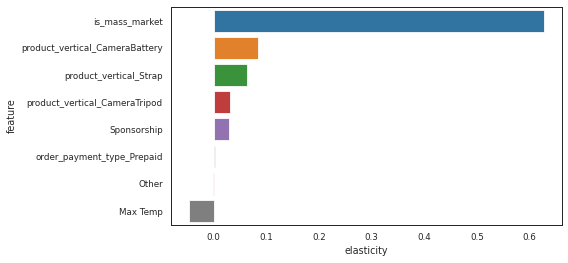

In [1362]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

Model Evaluation


In [1363]:
X_train_rfe.columns


Index(['const', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraBattery', 'product_vertical_CameraTripod', 'product_vertical_Strap', 'Sponsorship', 'Other', 'Max Temp'], dtype='object')

In [1364]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Sponsorship_SMA_3', 'product_vertical_CameraMicrophone', 'deliverycdays', 'Affiliates_Ad_Stock', 'Online marketing', 'Mean Temp', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'Radio_EMA_8', 'product_vertical_CameraRemoteControl', 'product_vertical_ReflectorUmbrella', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'Other_Ad_Stock', 'pay_week', 'TV_EMA_8', 'Stock Index_SMA_5', 'product_vertical_CameraFilmRolls', 'Sponsorship_EMA_8', 'Affiliates_SMA_5', 'Min Temp', 'Radio_Ad_Stock', 'NPS', 'SEM_Ad_Stock', 'TV', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'product_vertical_Lens', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'Total Precip (mm)', 'product_vertical_CameraMount', 'Sponsorship_SMA_5', 'Discount%', 'product_vertical_ExtensionTube', 'gmv', 'product_vertical_CameraAccessory', 'Sponsorship_Ad_Stock', 'Total Snow (cm)', 'product_vertical_FlashShoeAdapter', 'product_vertical_Flash', 'SEM_EMA_

In [1365]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [1366]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ 0.14848323,  0.97138906,  0.91618909,  0.96520434,  0.88993505,
        0.61419954,  0.52786324,  0.77081053, -2.12470838,  0.56483398])

In [1367]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)


In [1368]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.003777760718127736
r_square_value : 0.8568862584872732


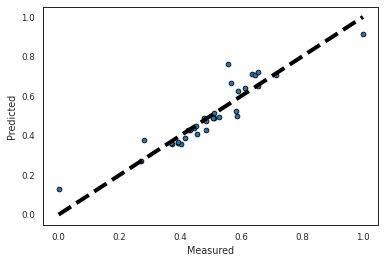

In [1369]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Building Linear Regression Model for Gaming Accessory

In [1370]:
np.random.seed(0)
df_train, df_test = train_test_split(gaming_accessory_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1371]:
gaming_accessory_df.columns

Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GameControlMount', 'product_vertical_GamePad', 'product_mrp', 'special_sales', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingChargingStation', 'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_JoystickGamingWheel', 'product_vertical_MotionController', 'product_vertical_TVOutCableAccessory', 'payd_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship',
       'Spo

In [1372]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


In [1373]:
num_vars = ['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GameControlMount', 
'product_vertical_GamePad', 'product_mrp', 'special_sales', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingChargingStation', 
'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_JoystickGamingWheel', 'product_vertical_MotionController', 
'product_vertical_TVOutCableAccessory', 'payd_week', 'holiday_week', 'Total Investment', 
'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 
'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 
'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship','Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 
'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 
'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 
'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other', 
'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5', 
'Stock Index', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 
'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 
'Snow on Grnd (cm)']

In [1374]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [1375]:
df_train.head()

df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1376]:
df_train.describe()


gmv  Discount%  deliverybdays  deliverycdays   sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  product_vertical_GameControlMount  product_vertical_GamePad  product_mrp  special_sales  product_vertical_GamingAccessoryKit  product_vertical_GamingAdapter  product_vertical_GamingChargingStation  product_vertical_GamingHeadset  product_vertical_GamingKeyboard  product_vertical_GamingMemoryCard  product_vertical_GamingMouse  product_vertical_GamingMousePad  product_vertical_GamingSpeaker  product_vertical_JoystickGamingWheel  product_vertical_MotionController  product_vertical_TVOutCableAccessory  payd_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock    TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  \
count 35.00      35.00          35.00          35.00 35.00                    35.00                       35.00           35.00                              35.00                     35.00        35.00          35.00                                35.00                           35.00                                   35.00                           35.00                            35.00                              35.00                         35.00                            35.00                           35.00                                 35.00                              35.00                                 35.00      35.00         35.00             35.00                   35.00                   35.00                   35.00                      35.00 35.00     35.00     35.00     35.00        35.00    35.00          35.00          35.00          35.00             35.00        35.00              35.00              35.00              35.00                 35.00   
mean   0.42       0.39           0.26           0.26  0.49                     0.19                        0.22            0.38                               0.03                      0.53         0.60           0.05                                 0.53                            0.50                                    0.14                            0.47                             0.22                               0.17                          0.17                             0.25                            0.15                                  0.27                               0.38                                  0.50       0.51          0.17              0.40                    0.39                    0.41                    0.45                       0.40  0.37      0.36      0.43      0.52         0.42     0.19           0.20           0.21           0.22              0.18         0.37               0.35               0.35               0.39                  0.35   
std    0.21       0.23           0.41           0.41  0.18                     0.18                        0.20            0.20                               0.17                      0.22         0.19           0.18                                 0.22                            0.23                                    0.27                            0.32                             0.18                               0.21                          0.17                             0.18                            0.24                                  0.31                               0.26                                  0.21       0.51          0.38              0.29                    0.25                    0.26                    0.25                       0.25  0.28      0.25      0.29      0.31         0.27     0.30           0.25           0.26           0.25              0.26         0.32               0.29               0.28               0.25                  0.27   
min    0.00       0.00           0.00           

Dividing into X and Y sets for the model building


In [1377]:
y_train = df_train.pop('gmv')
X_train = df_train

####Building the first model with all the features


In [1378]:
# Instantiate
lm = LinearRegression()

In [1379]:
# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [1380]:
# Print the coefficients and intercept
print(lm.coef_)
print(lm.intercept_)

[-9.52619232e-03 -2.62256643e-02 -2.97089255e-02 -5.78317875e-03
  5.43388334e-02  7.97599179e-02  1.33418299e-01 -1.91028546e-02
  1.19390117e-01  1.07671437e-01  1.02573957e-01  7.51458333e-02
  5.20302354e-02  3.63611639e-02  1.81504251e-01  7.70647466e-02
 -1.84082662e-02  1.02249152e-01  3.90186639e-02  3.68840303e-02
  4.06908091e-02 -2.35950595e-03  5.74763543e-02 -1.50595586e-04
  2.54991598e-02  2.39072876e-03 -9.12587139e-03 -1.98955781e-02
 -1.03220924e-02  8.86889031e-04  5.45720420e-02 -4.37701074e-02
 -5.85836115e-02  9.89795200e-03 -1.51632299e-02  3.93088872e-03
 -1.40446700e-02  9.46857705e-03 -3.66079478e-03  5.16600839e-04
 -7.37452954e-03  8.44809390e-03 -2.15394171e-03 -6.81035604e-03
 -2.29043126e-02 -1.31199073e-02 -8.29520274e-03  4.85642200e-02
 -1.64661834e-03  1.46544134e-02 -5.32523000e-02  1.76667716e-02
  1.92764541e-02  3.23703071e-02  2.51478024e-02  5.20124691e-02
  6.29845713e-02  1.55611287e-02 -2.52460277e-02  1.63875967e-02
 -9.02557597e-03 -2.50722

Model Building Using RFE


In [1381]:
# Import RFE
from sklearn.feature_selection import RFE

In [1382]:
lm = LinearRegression()

lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1383]:
# Print the boolean results
print(rfe.support_)           
print(rfe.ranking_) 

[False False  True False  True False  True  True False  True  True False
  True False False  True False  True False False  True False  True False
 False False  True False False False False  True  True False False False
 False False False False False False False False False False False  True
 False False False False  True False False False False  True False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False  True False  True False False]
[70 21  1 40  1  2  1  1  6  1  1 13  1 17  5  1 15  1 22 11  1 58  1 71
 12 52  1 67 47 62 14  1  1 37 63 57 27 51 48 54 65 38 66 23 44 18 61  1
 34 43 10 26  1 30 29 59 25  1 16  3 46 32 49 42 69 55 24 45 33 39  9  1
 19 36 35  4 31 50 20  8 64  7 68 56 53  1 60  1 41 28]


In [1384]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Discount%', False, 70),
 ('deliverybdays', False, 21),
 ('deliverycdays', True, 1),
 ('sla', False, 40),
 ('product_procurement_sla', True, 1),
 ('order_payment_type_Prepaid', False, 2),
 ('is_mass_market', True, 1),
 ('product_vertical_GameControlMount', True, 1),
 ('product_vertical_GamePad', False, 6),
 ('product_mrp', True, 1),
 ('special_sales', True, 1),
 ('product_vertical_GamingAccessoryKit', False, 13),
 ('product_vertical_GamingAdapter', True, 1),
 ('product_vertical_GamingChargingStation', False, 17),
 ('product_vertical_GamingHeadset', False, 5),
 ('product_vertical_GamingKeyboard', True, 1),
 ('product_vertical_GamingMemoryCard', False, 15),
 ('product_vertical_GamingMouse', True, 1),
 ('product_vertical_GamingMousePad', False, 22),
 ('product_vertical_GamingSpeaker', False, 11),
 ('product_vertical_JoystickGamingWheel', True, 1),
 ('product_vertical_MotionController', False, 58),
 ('product_vertical_TVOutCableAccessory', True, 1),
 ('payd_week', False, 71),
 ('holiday_

In [1385]:
col = X_train.columns[rfe.support_]
col

Index(['deliverycdays', 'product_procurement_sla', 'is_mass_market', 'product_vertical_GameControlMount', 'product_mrp', 'special_sales', 'product_vertical_GamingAdapter', 'product_vertical_GamingKeyboard', 'product_vertical_GamingMouse', 'product_vertical_JoystickGamingWheel', 'product_vertical_TVOutCableAccessory', 'Total Investment_SMA_3', 'TV_SMA_3', 'TV_SMA_5', 'Content Marketing_SMA_5', 'Online marketing_SMA_5', 'Affiliates_SMA_5', 'Other_SMA_3', 'Cool Deg Days', 'Total Snow (cm)'], dtype='object')

In [1386]:
X_train.columns[~rfe.support_]


Index(['Discount%', 'deliverybdays', 'sla', 'order_payment_type_Prepaid', 'product_vertical_GamePad', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingChargingStation', 'product_vertical_GamingHeadset', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_MotionController', 'payd_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM',
   

In [1387]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1388]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [1389]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [1390]:
lm.params

const                                  -0.15
deliverycdays                          -0.05
product_procurement_sla                 0.13
is_mass_market                          0.74
product_vertical_GameControlMount      -0.04
product_mrp                             0.18
special_sales                          -0.20
product_vertical_GamingAdapter          0.06
product_vertical_GamingKeyboard         0.12
product_vertical_GamingMouse            0.18
product_vertical_JoystickGamingWheel    0.05
product_vertical_TVOutCableAccessory    0.07
Total Investment_SMA_3                 -0.07
TV_SMA_3                                0.06
TV_SMA_5                               -0.09
Content Marketing_SMA_5                 0.08
Online marketing_SMA_5                 -0.32
Affiliates_SMA_5                        0.43
Other_SMA_3                            -0.05
Cool Deg Days                           0.05
Total Snow (cm)                        -0.04
dtype: float64

In [1391]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1757.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.81e-20
Time:                        10:34:18   Log-Likelihood:                 142.78
No. Observations:                  35   AIC:                            -243.6
Df Residuals:                      14   BIC:                            -210.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1392]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
17                      Affiliates_SMA_5 3175.90
16                Online marketing_SMA_5 2857.64
0                                  const  190.38
14                              TV_SMA_5   48.24
10  product_vertical_JoystickGamingWheel   47.69
15               Content Marketing_SMA_5   41.10
1                          deliverycdays   33.75
9           product_vertical_GamingMouse   32.92
13                              TV_SMA_3   28.76
12                Total Investment_SMA_3   23.75
3                         is_mass_market   20.68
8        product_vertical_GamingKeyboard   16.53
7         product_vertical_GamingAdapter   13.31
6                          special_sales   12.06
19                         Cool Deg Days   10.81
5                            product_mrp    7.45
18                           Other_SMA_3    6.19
2                product_procurement_sla    5.43
11  product_vertical_TVOutCableAccessory    2.78
20                       Total Snow (cm)    2.61
4      product_vertical_GameControlMount    1.55

In [1393]:
X_train_rfe.drop('Other_SMA_3', axis = 1, inplace = True)

In [1394]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.13
deliverycdays                          -0.00
product_procurement_sla                 0.11
is_mass_market                          0.78
product_vertical_GameControlMount      -0.02
product_mrp                             0.18
special_sales                          -0.23
product_vertical_GamingAdapter          0.09
product_vertical_GamingKeyboard         0.03
product_vertical_GamingMouse            0.28
product_vertical_JoystickGamingWheel   -0.02
product_vertical_TVOutCableAccessory    0.08
Total Investment_SMA_3                 -0.04
TV_SMA_3                                0.02
TV_SMA_5                               -0.06
Content Marketing_SMA_5                 0.03
Online marketing_SMA_5                  0.02
Affiliates_SMA_5                       -0.01
Cool Deg Days                           0.03
Total Snow (cm)                        -0.02
dtype: float64
                            OLS Regression Results                            
Dep. V

In [1395]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
17                      Affiliates_SMA_5 2403.70
16                Online marketing_SMA_5 2359.01
0                                  const  159.79
14                              TV_SMA_5   43.67
15               Content Marketing_SMA_5   34.46
10  product_vertical_JoystickGamingWheel   28.50
13                              TV_SMA_3   25.40
9           product_vertical_GamingMouse   22.71
12                Total Investment_SMA_3   20.72
3                         is_mass_market   18.37
1                          deliverycdays   17.57
6                          special_sales   11.48
7         product_vertical_GamingAdapter   10.47
18                         Cool Deg Days    8.99
5                            product_mrp    7.44
8        product_vertical_GamingKeyboard    7.34
2                product_procurement_sla    5.06
11  product_vertical_TVOutCableAccessory    2.77
19                       Total Snow (cm)    1.94
4      product_vertical_GameControlMount    1.16

In [1396]:
X_train_rfe.drop('Online marketing_SMA_5', axis = 1, inplace = True)

In [1397]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.13
deliverycdays                          -0.00
product_procurement_sla                 0.11
is_mass_market                          0.78
product_vertical_GameControlMount      -0.02
product_mrp                             0.18
special_sales                          -0.23
product_vertical_GamingAdapter          0.09
product_vertical_GamingKeyboard         0.03
product_vertical_GamingMouse            0.28
product_vertical_JoystickGamingWheel   -0.02
product_vertical_TVOutCableAccessory    0.08
Total Investment_SMA_3                 -0.04
TV_SMA_3                                0.02
TV_SMA_5                               -0.06
Content Marketing_SMA_5                 0.04
Affiliates_SMA_5                        0.02
Cool Deg Days                           0.03
Total Snow (cm)                        -0.02
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared: 

In [1398]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 141.09
14                              TV_SMA_5  29.13
13                              TV_SMA_3  25.39
9           product_vertical_GamingMouse  21.86
10  product_vertical_JoystickGamingWheel  19.63
12                Total Investment_SMA_3  17.27
3                         is_mass_market  17.24
1                          deliverycdays  16.14
16                      Affiliates_SMA_5  13.27
6                          special_sales  11.38
15               Content Marketing_SMA_5  11.03
7         product_vertical_GamingAdapter   9.35
17                         Cool Deg Days   8.55
5                            product_mrp   6.95
8        product_vertical_GamingKeyboard   5.99
2                product_procurement_sla   4.94
11  product_vertical_TVOutCableAccessory   2.77
18                       Total Snow (cm)   1.93
4      product_vertical_GameControlMount   1.16

In [1399]:
X_train_rfe.drop('TV_SMA_3', axis = 1, inplace = True)

In [1400]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.13
deliverycdays                          -0.00
product_procurement_sla                 0.11
is_mass_market                          0.78
product_vertical_GameControlMount      -0.02
product_mrp                             0.18
special_sales                          -0.23
product_vertical_GamingAdapter          0.10
product_vertical_GamingKeyboard         0.03
product_vertical_GamingMouse            0.28
product_vertical_JoystickGamingWheel   -0.02
product_vertical_TVOutCableAccessory    0.08
Total Investment_SMA_3                 -0.03
TV_SMA_5                               -0.04
Content Marketing_SMA_5                 0.03
Affiliates_SMA_5                        0.02
Cool Deg Days                           0.04
Total Snow (cm)                        -0.02
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:           

In [1401]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 133.27
9           product_vertical_GamingMouse  21.83
10  product_vertical_JoystickGamingWheel  19.49
3                         is_mass_market  16.94
13                              TV_SMA_5  16.14
1                          deliverycdays  15.50
15                      Affiliates_SMA_5  13.18
12                Total Investment_SMA_3  11.96
6                          special_sales  11.26
14               Content Marketing_SMA_5   9.10
16                         Cool Deg Days   8.27
7         product_vertical_GamingAdapter   8.11
5                            product_mrp   6.95
8        product_vertical_GamingKeyboard   5.98
2                product_procurement_sla   4.85
11  product_vertical_TVOutCableAccessory   2.75
17                       Total Snow (cm)   1.92
4      product_vertical_GameControlMount   1.16

In [1402]:
X_train_rfe.drop('product_vertical_GamingMouse', axis = 1, inplace = True)

In [1403]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.09
deliverycdays                          -0.02
product_procurement_sla                 0.07
is_mass_market                          0.88
product_vertical_GameControlMount      -0.02
product_mrp                             0.12
special_sales                          -0.08
product_vertical_GamingAdapter          0.05
product_vertical_GamingKeyboard         0.07
product_vertical_JoystickGamingWheel    0.04
product_vertical_TVOutCableAccessory    0.07
Total Investment_SMA_3                 -0.04
TV_SMA_5                                0.02
Content Marketing_SMA_5                 0.05
Affiliates_SMA_5                        0.01
Cool Deg Days                           0.03
Total Snow (cm)                        -0.03
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:       

In [1404]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 117.28
9   product_vertical_JoystickGamingWheel  16.49
1                          deliverycdays  14.98
14                      Affiliates_SMA_5  13.12
12                              TV_SMA_5  13.12
3                         is_mass_market  12.78
11                Total Investment_SMA_3  11.82
13               Content Marketing_SMA_5   8.90
15                         Cool Deg Days   8.25
7         product_vertical_GamingAdapter   6.76
5                            product_mrp   5.81
8        product_vertical_GamingKeyboard   5.70
6                          special_sales   5.11
2                product_procurement_sla   4.20
10  product_vertical_TVOutCableAccessory   2.73
16                       Total Snow (cm)   1.90
4      product_vertical_GameControlMount   1.16

In [1405]:
X_train_rfe.drop('deliverycdays', axis = 1, inplace = True)


In [1406]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.09
product_procurement_sla                 0.07
is_mass_market                          0.89
product_vertical_GameControlMount      -0.02
product_mrp                             0.12
special_sales                          -0.08
product_vertical_GamingAdapter          0.05
product_vertical_GamingKeyboard         0.06
product_vertical_JoystickGamingWheel    0.01
product_vertical_TVOutCableAccessory    0.07
Total Investment_SMA_3                 -0.03
TV_SMA_5                                0.00
Content Marketing_SMA_5                 0.05
Affiliates_SMA_5                        0.01
Cool Deg Days                           0.03
Total Snow (cm)                        -0.03
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Leas

In [1407]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 116.69
13                      Affiliates_SMA_5  13.05
2                         is_mass_market  11.83
10                Total Investment_SMA_3  10.73
11                              TV_SMA_5   9.65
12               Content Marketing_SMA_5   8.90
14                         Cool Deg Days   8.02
6         product_vertical_GamingAdapter   6.57
4                            product_mrp   5.79
7        product_vertical_GamingKeyboard   5.11
5                          special_sales   4.94
1                product_procurement_sla   4.19
8   product_vertical_JoystickGamingWheel   2.84
9   product_vertical_TVOutCableAccessory   2.71
15                       Total Snow (cm)   1.88
3      product_vertical_GameControlMount   1.15

In [1408]:
X_train_rfe.drop('Cool Deg Days', axis = 1, inplace = True)

In [1409]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.07
product_procurement_sla                 0.06
is_mass_market                          0.89
product_vertical_GameControlMount      -0.02
product_mrp                             0.13
special_sales                          -0.08
product_vertical_GamingAdapter          0.05
product_vertical_GamingKeyboard         0.07
product_vertical_JoystickGamingWheel    0.01
product_vertical_TVOutCableAccessory    0.07
Total Investment_SMA_3                 -0.04
TV_SMA_5                               -0.01
Content Marketing_SMA_5                 0.06
Affiliates_SMA_5                       -0.01
Total Snow (cm)                        -0.03
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     

In [1410]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 80.17
2                         is_mass_market 11.57
13                      Affiliates_SMA_5 11.41
10                Total Investment_SMA_3 10.49
12               Content Marketing_SMA_5  8.27
11                              TV_SMA_5  7.47
6         product_vertical_GamingAdapter  6.50
4                            product_mrp  5.40
5                          special_sales  4.88
7        product_vertical_GamingKeyboard  4.42
1                product_procurement_sla  3.99
8   product_vertical_JoystickGamingWheel  2.73
9   product_vertical_TVOutCableAccessory  2.69
14                       Total Snow (cm)  1.83
3      product_vertical_GameControlMount  1.15

In [1411]:
X_train_rfe.drop('is_mass_market', axis = 1, inplace = True)

In [1412]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.21
product_procurement_sla                 0.20
product_vertical_GameControlMount       0.02
product_mrp                             0.37
special_sales                           0.26
product_vertical_GamingAdapter          0.30
product_vertical_GamingKeyboard         0.22
product_vertical_JoystickGamingWheel    0.02
product_vertical_TVOutCableAccessory    0.21
Total Investment_SMA_3                 -0.25
TV_SMA_5                               -0.26
Content Marketing_SMA_5                 0.19
Affiliates_SMA_5                        0.34
Total Snow (cm)                        -0.11
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     22.03
Date:                Sat, 11 Mar 2023  

In [1413]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 72.90
9                 Total Investment_SMA_3  9.48
11               Content Marketing_SMA_5  7.82
12                      Affiliates_SMA_5  6.81
10                              TV_SMA_5  5.63
5         product_vertical_GamingAdapter  5.31
3                            product_mrp  4.64
6        product_vertical_GamingKeyboard  4.18
1                product_procurement_sla  3.76
4                          special_sales  3.55
7   product_vertical_JoystickGamingWheel  2.73
8   product_vertical_TVOutCableAccessory  2.37
13                       Total Snow (cm)  1.72
2      product_vertical_GameControlMount  1.13

In [1414]:
X_train_rfe.drop('TV_SMA_5', axis = 1, inplace = True)

In [1415]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.18
product_procurement_sla                 0.19
product_vertical_GameControlMount       0.05
product_mrp                             0.37
special_sales                           0.33
product_vertical_GamingAdapter          0.20
product_vertical_GamingKeyboard         0.16
product_vertical_JoystickGamingWheel    0.11
product_vertical_TVOutCableAccessory    0.27
Total Investment_SMA_3                 -0.38
Content Marketing_SMA_5                 0.27
Affiliates_SMA_5                        0.19
Total Snow (cm)                        -0.10
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     18.15
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.09e-08
Time:

In [1416]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 72.26
9                 Total Investment_SMA_3  8.39
10               Content Marketing_SMA_5  7.38
5         product_vertical_GamingAdapter  4.81
3                            product_mrp  4.64
11                      Affiliates_SMA_5  4.56
6        product_vertical_GamingKeyboard  4.07
1                product_procurement_sla  3.76
4                          special_sales  3.40
8   product_vertical_TVOutCableAccessory  2.24
7   product_vertical_JoystickGamingWheel  1.98
12                       Total Snow (cm)  1.72
2      product_vertical_GameControlMount  1.11

In [1417]:
X_train_rfe.drop('Total Investment_SMA_3', axis = 1, inplace = True)

In [1418]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.13
product_procurement_sla                 0.13
product_vertical_GameControlMount       0.01
product_mrp                             0.25
special_sales                           0.27
product_vertical_GamingAdapter          0.15
product_vertical_GamingKeyboard         0.24
product_vertical_JoystickGamingWheel    0.14
product_vertical_TVOutCableAccessory    0.19
Content Marketing_SMA_5                 0.01
Affiliates_SMA_5                        0.16
Total Snow (cm)                         0.01
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     15.76
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.41e-08
Time:                        10:34:19   Log-Likeli

In [1419]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 69.75
5         product_vertical_GamingAdapter  4.71
10                      Affiliates_SMA_5  4.42
3                            product_mrp  4.16
6        product_vertical_GamingKeyboard  3.86
1                product_procurement_sla  3.65
4                          special_sales  3.27
9                Content Marketing_SMA_5  2.94
8   product_vertical_TVOutCableAccessory  1.98
7   product_vertical_JoystickGamingWheel  1.90
11                       Total Snow (cm)  1.11
2      product_vertical_GameControlMount  1.08

In [1420]:
X_train_rfe.drop('product_procurement_sla', axis = 1, inplace = True)

In [1421]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.04
product_vertical_GameControlMount       0.01
product_mrp                             0.17
special_sales                           0.32
product_vertical_GamingAdapter          0.15
product_vertical_GamingKeyboard         0.21
product_vertical_JoystickGamingWheel    0.13
product_vertical_TVOutCableAccessory    0.17
Content Marketing_SMA_5                -0.03
Affiliates_SMA_5                        0.17
Total Snow (cm)                         0.01
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     17.52
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.06e-08
Time:                        10:34:19   Log-Likelihood:                 42.817
No. Observations

In [1422]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                  const 16.05
4         product_vertical_GamingAdapter  4.68
9                       Affiliates_SMA_5  4.27
5        product_vertical_GamingKeyboard  3.69
2                            product_mrp  2.75
3                          special_sales  2.70
8                Content Marketing_SMA_5  2.15
7   product_vertical_TVOutCableAccessory  1.93
6   product_vertical_JoystickGamingWheel  1.82
10                       Total Snow (cm)  1.11
1      product_vertical_GameControlMount  1.08

In [1423]:
X_train_rfe.drop('product_vertical_GamingAdapter', axis = 1, inplace = True)

In [1424]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.05
product_vertical_GameControlMount      -0.00
product_mrp                             0.19
special_sales                           0.30
product_vertical_GamingKeyboard         0.28
product_vertical_JoystickGamingWheel    0.14
product_vertical_TVOutCableAccessory    0.22
Content Marketing_SMA_5                -0.04
Affiliates_SMA_5                        0.22
Total Snow (cm)                         0.01
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     19.27
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.88e-09
Time:                        10:34:19   Log-Likelihood:                 42.030
No. Observations:                  35   AIC:                 

In [1425]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                 const 16.02
8                      Affiliates_SMA_5  3.10
4       product_vertical_GamingKeyboard  3.02
2                           product_mrp  2.72
3                         special_sales  2.66
7               Content Marketing_SMA_5  2.14
5  product_vertical_JoystickGamingWheel  1.78
6  product_vertical_TVOutCableAccessory  1.60
9                       Total Snow (cm)  1.11
1     product_vertical_GameControlMount  1.06

In [1426]:
X_train_rfe.drop('product_vertical_JoystickGamingWheel', axis = 1, inplace = True)

In [1427]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                  -0.09
product_vertical_GameControlMount      -0.03
product_mrp                             0.31
special_sales                           0.25
product_vertical_GamingKeyboard         0.36
product_vertical_TVOutCableAccessory    0.21
Content Marketing_SMA_5                -0.05
Affiliates_SMA_5                        0.22
Total Snow (cm)                        -0.02
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     18.40
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.00e-09
Time:                        10:34:19   Log-Likelihood:                 38.970
No. Observations:                  35   AIC:                            -59.94
Df Residuals:              

In [1428]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                                 const 14.33
7                      Affiliates_SMA_5  3.10
4       product_vertical_GamingKeyboard  2.86
3                         special_sales  2.59
2                           product_mrp  2.19
6               Content Marketing_SMA_5  2.14
5  product_vertical_TVOutCableAccessory  1.60
8                       Total Snow (cm)  1.07
1     product_vertical_GameControlMount  1.04

In [1429]:
X_train_rfe.drop('product_vertical_TVOutCableAccessory', axis = 1, inplace = True)

In [1430]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                               -0.05
product_vertical_GameControlMount   -0.04
product_mrp                          0.34
special_sales                        0.22
product_vertical_GamingKeyboard      0.48
Content Marketing_SMA_5             -0.03
Affiliates_SMA_5                     0.25
Total Snow (cm)                     -0.02
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     17.69
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.42e-08
Time:                        10:34:20   Log-Likelihood:                 35.886
No. Observations:                  35   AIC:                            -55.77
Df Residuals:                      27   BIC:                            -43.33
Df Model:        

In [1431]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                              const 13.06
6                   Affiliates_SMA_5  3.00
3                      special_sales  2.57
4    product_vertical_GamingKeyboard  2.48
2                        product_mrp  2.16
5            Content Marketing_SMA_5  2.13
7                    Total Snow (cm)  1.07
1  product_vertical_GameControlMount  1.04

In [1432]:
X_train_rfe.drop('Total Snow (cm)', axis = 1, inplace = True)


In [1433]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                               -0.05
product_vertical_GameControlMount   -0.04
product_mrp                          0.34
special_sales                        0.23
product_vertical_GamingKeyboard      0.48
Content Marketing_SMA_5             -0.03
Affiliates_SMA_5                     0.25
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     21.32
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.01e-09
Time:                        10:34:20   Log-Likelihood:                 35.834
No. Observations:                  35   AIC:                            -57.67
Df Residuals:                      28   BIC:                            -46.78
Df Model:                           6                      

In [1434]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                              const 12.97
6                   Affiliates_SMA_5  2.91
3                      special_sales  2.57
4    product_vertical_GamingKeyboard  2.48
2                        product_mrp  2.14
5            Content Marketing_SMA_5  2.13
1  product_vertical_GameControlMount  1.03

In [1435]:
X_train_rfe.drop('product_mrp', axis = 1, inplace = True)


In [1436]:
X_train_rfe= sm.add_constant(X_train_rfe)

# Fitting the model 
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.params)

print(lm.summary())

const                                0.06
product_vertical_GameControlMount   -0.05
special_sales                        0.17
product_vertical_GamingKeyboard      0.57
Content Marketing_SMA_5             -0.15
Affiliates_SMA_5                     0.41
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     19.72
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.53e-08
Time:                        10:34:20   Log-Likelihood:                 31.712
No. Observations:                  35   AIC:                            -51.42
Df Residuals:                      29   BIC:                            -42.09
Df Model:                           5                                         
Covariance Type:      

In [1437]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features  VIF
0                              const 6.59
2                      special_sales 2.51
3    product_vertical_GamingKeyboard 2.35
4            Content Marketing_SMA_5 1.69
5                   Affiliates_SMA_5 1.54
1  product_vertical_GameControlMount 1.03

Elasticity


In [1438]:
coefficients_df = pd.DataFrame(pd.DataFrame(lm.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

<AxesSubplot:xlabel='elasticity', ylabel='feature'>

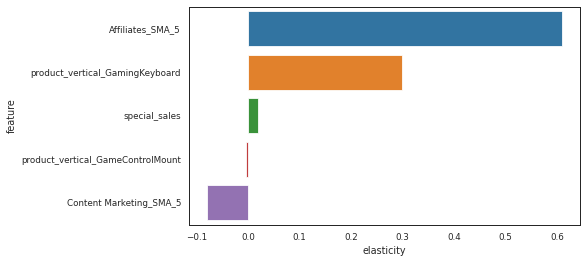

In [1439]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

Model Evaluation


In [1440]:
X_train_rfe.columns


Index(['const', 'product_vertical_GameControlMount', 'special_sales', 'product_vertical_GamingKeyboard', 'Content Marketing_SMA_5', 'Affiliates_SMA_5'], dtype='object')

In [1441]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)


['Sponsorship_SMA_3', 'deliverycdays', 'Affiliates_Ad_Stock', 'Online marketing', 'product_vertical_GamingAdapter', 'Mean Temp', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'product_vertical_GamingAccessoryKit', 'Radio_EMA_8', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'product_vertical_GamingSpeaker', 'Other_Ad_Stock', 'TV_EMA_8', 'Stock Index_SMA_5', 'product_vertical_GamingMemoryCard', 'Sponsorship_EMA_8', 'Min Temp', 'Radio_Ad_Stock', 'NPS', 'order_payment_type_Prepaid', 'product_vertical_JoystickGamingWheel', 'TV', 'SEM_Ad_Stock', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'Total Precip (mm)', 'product_vertical_GamingChargingStation', 'is_mass_market', 'Sponsorship_SMA_5', 'Discount%', 'gmv', 'Sponsorship_Ad_Stock', 'Total Snow (cm)', 'product_vertical_GamingMousePad', 'SEM_EMA_8', 'TV_SMA_5', 'SEM', 'Cool Deg Days', 'Digital', 'deliverybday

In [1442]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

In [1443]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([-0.47410268,  0.91049223, -0.05657147,  0.89146558,  0.84667432,
       -1.83805677, -0.04457123,  0.38817304,  0.08157555,  0.51050019])

In [1444]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)


In [1445]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.016700796608379944
r_square_value : 0.6031021744599101


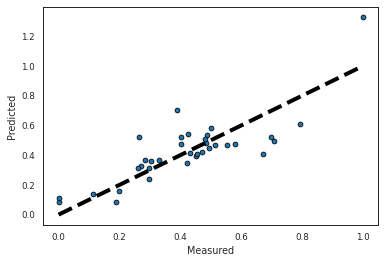

In [1446]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

#Multiplicative Model


In [1447]:
# Making copy of dataframes from the original ones
cam_mul_df = Camera_accessory_org_df.copy()
gam_mul_df = gaming_accessory_org_df.copy()
home_mul_df = Homeaudio_org_df.copy()
home_mul_df.head()

gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  special_sales  product_vertical_Dock  product_vertical_DockingStation  product_vertical_FMRadio  product_vertical_HiFiSystem  product_vertical_HomeAudioSpeaker  product_mrp  product_vertical_SoundMixer  product_vertical_VoiceRecorder  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  \
26 1185712.00      30.67           0.00           0.00 7.00                     1.95                      213.00             793              0                     24                                1                    334.00                            8                             541.00      1958.61                            0                               2         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05         0.05     0.63           0.00           0.00           0.63              0.63         1.85               0.00               0.00               1.85                  1.85               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.33        0.14              0.00   
27 1471962.00      30.37           0.00           0.00 6.71                     1.78                      243.00             936            297                     36                                0                    374.00                           19                             657.00      2016.77                            0                               7         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05         0.09     0.63           0.00           0.00           0.63              1.01         1.85               0.00               0.00               1.85                  2.97               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.53        0.14              0.00   
28 1275392.00      28.88           0.00           0.00 6.82                     1.80                      191.00             909              0                     40                                0                    394.00                           16                             544.00      1896.30                            0                               1         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05         0.11     0.63           0.63           0.00           0.63              1.24         1.85               1.85               0.00               1.85                  3.63               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.33                    0.00                    0.33                       0.65        0.14              0.14   
29  920394.00      28.04           0.00           0.00

In [1448]:
# Checking for percentage of null values 

total = pd.DataFrame(home_mul_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(home_mul_df.isnull().sum()/home_mul_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])

pd.concat([total, percentage], axis = 1).head()

Total  Percentage
gmv                      0        0.00
Affiliates_Ad_Stock      0        0.00
Radio_SMA_5              0        0.00
Radio_SMA_3              0        0.00
Radio                    0        0.00

Take the Logarithm of both the Dependent and the independent variables

After taking log, all 0 values will be transformed to inf. Retransforming these values to 0.



In [1449]:
cam_mul_df = cam_mul_df.applymap(lambda x: np.log(x))
cam_mul_df = cam_mul_df.replace([np.inf, -np.inf], 0)
cam_mul_df = cam_mul_df.replace(np.nan, 0)

gam_mul_df = gam_mul_df.applymap(lambda x: np.log(x))
gam_mul_df = gam_mul_df.replace([np.inf, -np.inf], 0)
gam_mul_df = gam_mul_df.replace(np.nan, 0)

home_mul_df = home_mul_df.applymap(lambda x: np.log(x))
home_mul_df = home_mul_df.replace([np.inf, -np.inf], 0)
home_mul_df = home_mul_df.replace(np.nan, 0)


home_mul_df.head()

gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  special_sales  product_vertical_Dock  product_vertical_DockingStation  product_vertical_FMRadio  product_vertical_HiFiSystem  product_vertical_HomeAudioSpeaker  product_mrp  product_vertical_SoundMixer  product_vertical_VoiceRecorder  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock    TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  \
26 13.99       3.42           0.00           0.00 1.95                     0.67                        5.36            6.68           0.00                   3.18                             0.00                      5.81                         2.08                               6.29         7.58                         0.00                            0.69      0.00          0.00              1.45                    0.00                    0.00                    1.45                       1.45 -2.92      0.00      0.00     -2.92        -2.92    -0.46           0.00           0.00          -0.46             -0.46         0.62               0.00               0.00               0.62                  0.62               0.00                     0.00                     0.00                     0.00                        0.00             -1.10                    0.00                    0.00                   -1.10                      -1.10       -1.99              0.00   
27 14.20       3.41           0.00           0.00 1.90                     0.58                        5.49            6.84           5.69                   3.58                             0.00                      5.92                         2.94                               6.49         7.61                         0.00                            1.95      0.00          0.00              1.45                    0.00                    0.00                    1.45                       1.92 -2.92      0.00      0.00     -2.92        -2.45    -0.46           0.00           0.00          -0.46              0.01         0.62               0.00               0.00               0.62                  1.09               0.00                     0.00                     0.00                     0.00                        0.00             -1.10                    0.00                    0.00                   -1.10                      -0.63       -1.99              0.00   
28 14.06       3.36           0.00           0.00 1.92                     0.59                        5.25            6.81           0.00                   3.69                             0.00                      5.98                         2.77                               6.30         7.55                         0.00                            0.00      0.00          0.00              1.45                    1.45                    0.00                    1.45                       2.12 -2.92     -2.92      0.00     -2.92        -2.25    -0.46          -0.46           0.00          -0.46              0.22         0.62               0.62               0.00               0.62                  1.29               0.00                     0.00                     0.00                     0.00                        0.00             -1.10                   -1.10                    0.00                   -1.10                      -0.43       -1.99             -1.99   
29 13.73       3.33           0.00           0.00 1.92           

##Camera Accessory - Multiplicative model


Splitting the Dataframe into Training and Testing Sets


In [1450]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(cam_mul_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1451]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [1452]:
cam_mul_df.columns


Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'product_mrp', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraAccessory', 'special_sales', 'product_vertical_CameraBag', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing', 'product_vertical_CameraMicrophone', 'product_vertical_CameraMount', 'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_Filter', 'product_vertical_Flash', 'product_vertical_FlashShoeAdapter', 'product_vertical_Lens', 'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox', 'product_vertical_Strap', 'product_vertical_Telescope', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8',
    

In [1453]:
num_vars=['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'product_mrp', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraAccessory', 'special_sales', 'product_vertical_CameraBag', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing', 'product_vertical_CameraMicrophone', 'product_vertical_CameraMount', 'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_Filter', 'product_vertical_Flash', 'product_vertical_FlashShoeAdapter', 'product_vertical_Lens', 'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox', 'product_vertical_Strap', 'product_vertical_Telescope', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8',
       'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5', 'Stock Index', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days',
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1454]:
# assigning x_traim amd y_train values
y_train = df_train.pop('gmv')
X_train = df_train

In [1455]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1456]:
# selecting the top 20 features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Discount%', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraAccessory', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraEyeCup', 'product_vertical_CameraRemoteControl', 'product_vertical_Flash', 'product_vertical_Lens', 'Sponsorship_EMA_8', 'Online marketing_SMA_5', 'Affiliates_SMA_5', 'SEM_EMA_8', 'Other', 'NPS', 'NPS_SMA_5', 'Stock Index_SMA_5', 'Max Temp'], dtype='object')

In [1457]:
# neglecting the features other than top 20 features given by rfe
X_train.columns[~rfe.support_]

Index(['deliverybdays', 'deliverycdays', 'sla', 'product_mrp', 'special_sales', 'product_vertical_CameraBag', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing', 'product_vertical_CameraMicrophone', 'product_vertical_CameraMount', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_Filter', 'product_vertical_FlashShoeAdapter', 'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox', 'product_vertical_Strap', 'product_vertical_Telescope', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5',
       'Co

In [1458]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1459]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     7964.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           9.14e-22
Time:                        10:34:22   Log-Likelihood:                 170.44
No. Observations:                  33   AIC:                            -298.9
Df Residuals:                      12   BIC:                            -267.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Features      VIF
19                      Stock Index_SMA_5 14301.96
18                              NPS_SMA_5 13914.79
0                                   const  4653.50
4                          is_mass_market  3906.64
13                 Online marketing_SMA_5  1208.47
14                       Affiliates_SMA_5   690.16
1                               Discount%   548.64
11                  product_vertical_Lens   311.21
6          product_vertical_CameraBattery   255.81
7   product_vertical_CameraBatteryCharger   100.64
10                 product_vertical_Flash    85.50
3              order_payment_type_Prepaid    79.11
2                 product_procurement_sla    57.91
15                              SEM_EMA_8    57.32
12                      Sponsorship_EMA_8    55.43
5        product_vertical_CameraAccessory    48.96
9    product_vertical_CameraRemoteControl    42.80
17                                    NPS    30.04
20                               Max Temp    14.58
8           product_vertical_CameraEyeCup    14.22
16                                  Other     3.93

In [1460]:
X_train_rfe= X_train_rfe.drop(["Stock Index_SMA_5"], axis = 1)


In [1461]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2135.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.13e-19
Time:                        10:34:22   Log-Likelihood:                 146.55
No. Observations:                  33   AIC:                            -253.1
Df Residuals:                      13   BIC:                            -223.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Features     VIF
0                                   const 4583.87
4                          is_mass_market 3884.38
13                 Online marketing_SMA_5 1109.20
14                       Affiliates_SMA_5  661.70
1                               Discount%  547.43
11                  product_vertical_Lens  302.27
6          product_vertical_CameraBattery  251.45
18                              NPS_SMA_5  229.92
7   product_vertical_CameraBatteryCharger   86.24
10                 product_vertical_Flash   83.15
2                 product_procurement_sla   55.32
12                      Sponsorship_EMA_8   45.79
9    product_vertical_CameraRemoteControl   42.39
5        product_vertical_CameraAccessory   40.53
3              order_payment_type_Prepaid   38.01
17                                    NPS   24.59
15                              SEM_EMA_8   23.70
8           product_vertical_CameraEyeCup   14.22
19                               Max Temp   13.78
16                                  Other    2.98

In [1462]:
# Let's drop featuree with highest p-value
X_train_rfe = X_train_rfe.drop(["is_mass_market"], axis = 1)

In [1463]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2408.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.35e-21
Time:                        10:34:22   Log-Likelihood:                 146.42
No. Observations:                  33   AIC:                            -254.8
Df Residuals:                      14   BIC:                            -226.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [1464]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
0                                   const 4164.99
12                 Online marketing_SMA_5  981.55
13                       Affiliates_SMA_5  633.37
17                              NPS_SMA_5  229.92
5          product_vertical_CameraBattery   78.19
6   product_vertical_CameraBatteryCharger   63.37
10                  product_vertical_Lens   56.75
11                      Sponsorship_EMA_8   33.28
3              order_payment_type_Prepaid   31.41
8    product_vertical_CameraRemoteControl   30.50
16                                    NPS   23.97
1                               Discount%   23.27
14                              SEM_EMA_8   22.84
9                  product_vertical_Flash   22.30
2                 product_procurement_sla   20.23
4        product_vertical_CameraAccessory   15.92
7           product_vertical_CameraEyeCup    8.02
18                               Max Temp    5.01
15                                  Other    2.81

In [1465]:
# Let's drop feature  with highest p-value
X_train_rfe = X_train_rfe.drop(["Online marketing_SMA_5"], axis = 1)


In [1466]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1961.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.23e-22
Time:                        10:34:22   Log-Likelihood:                 140.95
No. Observations:                  33   AIC:                            -245.9
Df Residuals:                      15   BIC:                            -219.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [1467]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                   const 958.57
5          product_vertical_CameraBattery  76.44
6   product_vertical_CameraBatteryCharger  62.70
10                  product_vertical_Lens  50.72
12                       Affiliates_SMA_5  40.67
11                      Sponsorship_EMA_8  32.61
8    product_vertical_CameraRemoteControl  28.49
3              order_payment_type_Prepaid  27.38
15                                    NPS  23.96
1                               Discount%  23.05
13                              SEM_EMA_8  22.33
9                  product_vertical_Flash  22.21
2                 product_procurement_sla  19.95
16                              NPS_SMA_5  18.54
4        product_vertical_CameraAccessory  14.11
7           product_vertical_CameraEyeCup   7.96
17                               Max Temp   4.90
14                                  Other   2.79

In [1468]:
# Let's remove feature with highest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraBatteryCharger"], axis = 1)


In [1469]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2194.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.19e-23
Time:                        10:34:22   Log-Likelihood:                 140.74
No. Observations:                  33   AIC:                            -247.5
Df Residuals:                      16   BIC:                            -222.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1470]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 954.04
9                  product_vertical_Lens  45.94
11                      Affiliates_SMA_5  40.36
5         product_vertical_CameraBattery  38.84
10                     Sponsorship_EMA_8  30.41
7   product_vertical_CameraRemoteControl  28.47
3             order_payment_type_Prepaid  25.81
1                              Discount%  23.03
14                                   NPS  22.73
12                             SEM_EMA_8  22.04
8                 product_vertical_Flash  20.54
2                product_procurement_sla  19.83
15                             NPS_SMA_5  18.54
4       product_vertical_CameraAccessory  13.38
6          product_vertical_CameraEyeCup   5.91
16                              Max Temp   3.55
13                                 Other   2.79

In [1471]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraBattery"], axis = 1)


In [1472]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     681.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.37e-20
Time:                        10:34:23   Log-Likelihood:                 119.39
No. Observations:                  33   AIC:                            -206.8
Df Residuals:                      17   BIC:                            -182.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1473]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 922.97
8                  product_vertical_Lens  45.82
10                      Affiliates_SMA_5  32.24
9                      Sponsorship_EMA_8  28.45
7                 product_vertical_Flash  20.48
6   product_vertical_CameraRemoteControl  19.94
3             order_payment_type_Prepaid  19.92
1                              Discount%  19.73
2                product_procurement_sla  19.52
11                             SEM_EMA_8  19.18
13                                   NPS  19.00
14                             NPS_SMA_5  18.40
4       product_vertical_CameraAccessory  13.33
5          product_vertical_CameraEyeCup   5.90
15                              Max Temp   3.51
12                                 Other   2.68

In [1474]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_Flash"], axis = 1)


In [1475]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     586.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.71e-21
Time:                        10:34:23   Log-Likelihood:                 114.84
No. Observations:                  33   AIC:                            -199.7
Df Residuals:                      18   BIC:                            -177.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1476]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 611.25
7                  product_vertical_Lens  42.16
9                       Affiliates_SMA_5  31.14
8                      Sponsorship_EMA_8  22.17
6   product_vertical_CameraRemoteControl  19.80
12                                   NPS  18.99
3             order_payment_type_Prepaid  18.97
1                              Discount%  18.80
2                product_procurement_sla  18.50
10                             SEM_EMA_8  18.08
4       product_vertical_CameraAccessory  13.04
13                             NPS_SMA_5   7.43
5          product_vertical_CameraEyeCup   4.71
14                              Max Temp   3.51
11                                 Other   2.48

In [1477]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Sponsorship_EMA_8"], axis = 1)


In [1478]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     665.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.15e-22
Time:                        10:34:23   Log-Likelihood:                 114.84
No. Observations:                  33   AIC:                            -201.7
Df Residuals:                      19   BIC:                            -180.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1479]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 597.33
7                  product_vertical_Lens  41.85
8                       Affiliates_SMA_5  28.72
6   product_vertical_CameraRemoteControl  19.57
2                product_procurement_sla  18.38
1                              Discount%  18.12
3             order_payment_type_Prepaid  13.95
11                                   NPS  13.64
4       product_vertical_CameraAccessory  12.92
9                              SEM_EMA_8  11.09
12                             NPS_SMA_5   5.34
5          product_vertical_CameraEyeCup   4.55
13                              Max Temp   2.88
10                                 Other   2.44

In [1480]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraRemoteControl"], axis = 1)


In [1481]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     431.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.09e-21
Time:                        10:34:23   Log-Likelihood:                 105.54
No. Observations:                  33   AIC:                            -185.1
Df Residuals:                      20   BIC:                            -165.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [1482]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                              const 581.58
6              product_vertical_Lens  32.86
7                   Affiliates_SMA_5  19.79
2            product_procurement_sla  18.31
1                          Discount%  16.49
10                               NPS  13.64
4   product_vertical_CameraAccessory  12.35
3         order_payment_type_Prepaid  11.18
8                          SEM_EMA_8   8.46
11                         NPS_SMA_5   5.33
5      product_vertical_CameraEyeCup   3.96
12                          Max Temp   2.66
9                              Other   2.40

In [1483]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_procurement_sla"], axis = 1)


In [1484]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     451.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.34e-22
Time:                        10:34:23   Log-Likelihood:                 104.06
No. Observations:                  33   AIC:                            -184.1
Df Residuals:                      21   BIC:                            -166.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [1485]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                              const 455.60
5              product_vertical_Lens  32.58
6                   Affiliates_SMA_5  17.86
1                          Discount%  15.96
3   product_vertical_CameraAccessory  11.71
2         order_payment_type_Prepaid  10.10
9                                NPS   9.09
7                          SEM_EMA_8   6.50
10                         NPS_SMA_5   3.85
4      product_vertical_CameraEyeCup   3.75
11                          Max Temp   2.62
8                              Other   1.73

In [1486]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraAccessory"], axis = 1)


In [1487]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     413.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.23e-22
Time:                        10:34:23   Log-Likelihood:                 100.27
No. Observations:                  33   AIC:                            -178.5
Df Residuals:                      22   BIC:                            -162.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [1488]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                           const 417.10
5                Affiliates_SMA_5  16.16
4           product_vertical_Lens  15.51
1                       Discount%  13.86
8                             NPS   9.09
2      order_payment_type_Prepaid   8.49
6                       SEM_EMA_8   6.41
9                       NPS_SMA_5   3.53
3   product_vertical_CameraEyeCup   3.02
10                       Max Temp   1.92
7                           Other   1.66

In [1489]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS"], axis = 1)


In [1490]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     468.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.10e-24
Time:                        10:34:23   Log-Likelihood:                 99.872
No. Observations:                  33   AIC:                            -179.7
Df Residuals:                      23   BIC:                            -164.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [1491]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                          const 100.99
5               Affiliates_SMA_5  14.91
1                      Discount%  12.76
4          product_vertical_Lens  10.05
2     order_payment_type_Prepaid   7.91
6                      SEM_EMA_8   4.43
9                       Max Temp   1.91
3  product_vertical_CameraEyeCup   1.81
8                      NPS_SMA_5   1.54
7                          Other   1.46

In [1492]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["order_payment_type_Prepaid"], axis = 1)


In [1493]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     298.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.22e-22
Time:                        10:34:23   Log-Likelihood:                 89.843
No. Observations:                  33   AIC:                            -161.7
Df Residuals:                      24   BIC:                            -148.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [1494]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                          const 98.47
1                      Discount% 12.65
4               Affiliates_SMA_5 11.60
3          product_vertical_Lens  9.31
5                      SEM_EMA_8  3.44
2  product_vertical_CameraEyeCup  1.80
8                       Max Temp  1.80
7                      NPS_SMA_5  1.52
6                          Other  1.42

In [1495]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["SEM_EMA_8"], axis = 1)


In [1496]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     344.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.07e-23
Time:                        10:34:23   Log-Likelihood:                 89.363
No. Observations:                  33   AIC:                            -162.7
Df Residuals:                      25   BIC:                            -150.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [1497]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                          const 79.88
3          product_vertical_Lens  9.17
1                      Discount%  8.27
4               Affiliates_SMA_5  5.81
2  product_vertical_CameraEyeCup  1.58
7                       Max Temp  1.53
5                          Other  1.25
6                      NPS_SMA_5  1.19

In [1498]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraEyeCup"], axis = 1)


In [1499]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     208.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.04e-20
Time:                        10:34:24   Log-Likelihood:                 78.046
No. Observations:                  33   AIC:                            -142.1
Df Residuals:                      26   BIC:                            -131.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.09

In [1500]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                  const 77.00
2  product_vertical_Lens  9.16
1              Discount%  6.80
3       Affiliates_SMA_5  5.23
6               Max Temp  1.53
4                  Other  1.24
5              NPS_SMA_5  1.13

In [1501]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Max Temp"], axis = 1)


In [1502]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     223.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.42e-21
Time:                        10:34:24   Log-Likelihood:                 75.620
No. Observations:                  33   AIC:                            -139.2
Df Residuals:                      27   BIC:                            -130.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.04

In [1503]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                  const 39.84
2  product_vertical_Lens  8.84
1              Discount%  6.72
3       Affiliates_SMA_5  4.07
4                  Other  1.23
5              NPS_SMA_5  1.06

In [1504]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS_SMA_5"], axis = 1)


In [1505]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     273.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.21e-22
Time:                        10:34:24   Log-Likelihood:                 74.714
No. Observations:                  33   AIC:                            -139.4
Df Residuals:                      28   BIC:                            -131.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.02

In [1506]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                  const 30.65
2  product_vertical_Lens  8.54
1              Discount%  6.50
3       Affiliates_SMA_5  4.04
4                  Other  1.22

In [1507]:
 
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Other"], axis = 1)


In [1508]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     367.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.67e-23
Time:                        10:34:24   Log-Likelihood:                 74.250
No. Observations:                  33   AIC:                            -140.5
Df Residuals:                      29   BIC:                            -134.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.02

In [1509]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0                  const 30.64
2  product_vertical_Lens  7.91
1              Discount%  6.48
3       Affiliates_SMA_5  3.34

In [1510]:
X_train_rfe.columns

Index(['Discount%', 'product_vertical_Lens', 'Affiliates_SMA_5'], dtype='object')

In [1511]:
X_train_rfe.columns

Index(['Discount%', 'product_vertical_Lens', 'Affiliates_SMA_5'], dtype='object')

In [1512]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Sponsorship_SMA_3', 'product_vertical_CameraMicrophone', 'deliverycdays', 'Affiliates_Ad_Stock', 'Online marketing', 'Mean Temp', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'Radio_EMA_8', 'product_vertical_CameraRemoteControl', 'product_vertical_ReflectorUmbrella', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'Other_Ad_Stock', 'pay_week', 'TV_EMA_8', 'Stock Index_SMA_5', 'product_vertical_CameraFilmRolls', 'Sponsorship_EMA_8', 'Min Temp', 'Radio_Ad_Stock', 'order_payment_type_Prepaid', 'NPS', 'SEM_Ad_Stock', 'TV', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'Total Precip (mm)', 'product_vertical_CameraMount', 'is_mass_market', 'Sponsorship_SMA_5', 'product_vertical_Strap', 'product_vertical_ExtensionTube', 'gmv', 'product_vertical_CameraAccessory', 'Sponsorship_Ad_Stock', 'Total Snow (cm)', 'product_vertical_FlashShoeAdapter', 'product_vertical_F

In [1513]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ -0.94031258,   0.61084879,   0.22405357,   0.9665793 ,
        -6.43576956,  -2.36903885,  -1.91219465,   0.63154106,
        -0.19677343, -13.17344163])

In [1514]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1515]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.006466410028242804
r_square_value : 0.7452255987173004


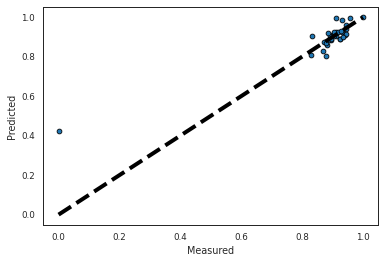

In [1516]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis


In [1517]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

<AxesSubplot:xlabel='elasticity', ylabel='feature'>

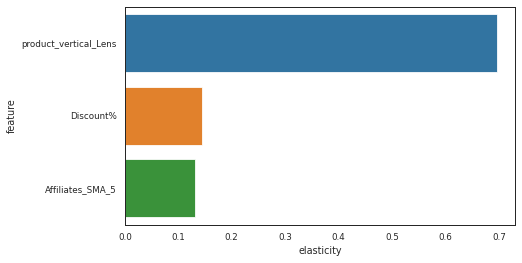

In [1518]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

## Gaming Accessory - Multiplicative model

Splitting the Dataframe into Training and Testing Sets


In [1519]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(gam_mul_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1520]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [1521]:
gam_mul_df.columns

Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GameControlMount', 'product_vertical_GamePad', 'product_mrp', 'special_sales', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingChargingStation', 'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_JoystickGamingWheel', 'product_vertical_MotionController', 'product_vertical_TVOutCableAccessory', 'payd_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship',
       'Spo

In [1522]:
num_vars=['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GameControlMount', 'product_vertical_GamePad', 'product_mrp', 'special_sales', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingChargingStation', 'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_JoystickGamingWheel', 'product_vertical_MotionController', 'product_vertical_TVOutCableAccessory', 'payd_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 
'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 
'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 
'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 
'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 
'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5', 
'Stock Index', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 
'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 
'Snow on Grnd (cm)']

In [1523]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1524]:
# assigning x_traim amd y_train values
y_train = df_train.pop('gmv')
X_train = df_train

In [1525]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [1526]:
rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1527]:
# selecting the top 20 features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Discount%', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GamePad', 'product_mrp', 'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard', 'product_vertical_TVOutCableAccessory', 'Sponsorship_EMA_8', 'Online marketing', 'Online marketing_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'NPS', 'NPS_SMA_5', 'Stock Index_SMA_5', 'Heat Deg Days'], dtype='object')

In [1528]:
# neglecting the features other than top 20 features given by rfe
X_train.columns[~rfe.support_]

Index(['deliverybdays', 'deliverycdays', 'product_vertical_GameControlMount', 'special_sales', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingChargingStation', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_JoystickGamingWheel', 'product_vertical_MotionController', 'payd_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing_SMA_5', 'Online marketing_EMA_8',
       'Online_

In [1529]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1530]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     6446.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.03e-24
Time:                        10:34:26   Log-Likelihood:                 165.90
No. Observations:                  35   AIC:                            -289.8
Df Residuals:                      14   BIC:                            -257.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features     VIF
19                     Stock Index_SMA_5 8265.49
18                             NPS_SMA_5 7418.15
0                                  const 7279.88
5                         is_mass_market 1083.09
15                      Affiliates_EMA_8  883.87
16                   Affiliates_Ad_Stock  863.66
14                      Affiliates_SMA_5  677.22
6               product_vertical_GamePad  433.40
12                      Online marketing  410.16
8         product_vertical_GamingHeadset  343.51
13                Online marketing_SMA_3  313.05
4             order_payment_type_Prepaid  193.71
17                                   NPS  135.00
10  product_vertical_TVOutCableAccessory  120.42
11                     Sponsorship_EMA_8   47.75
9        product_vertical_GamingKeyboard   47.67
7                            product_mrp   16.93
1                              Discount%   11.43
20                         Heat Deg Days    8.81
3                product_procurement_sla    8.48
2                                    sla    4.81

In [1531]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_5"], axis = 1)


In [1532]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     7198.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.49e-26
Time:                        10:34:26   Log-Likelihood:                 165.73
No. Observations:                  35   AIC:                            -291.5
Df Residuals:                      15   BIC:                            -260.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1533]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
0                                  const 5821.79
5                         is_mass_market 1077.86
16                   Affiliates_Ad_Stock  858.31
14                      Affiliates_SMA_5  677.00
15                      Affiliates_EMA_8  587.91
6               product_vertical_GamePad  422.17
8         product_vertical_GamingHeadset  339.94
18                             NPS_SMA_5  280.65
13                Online marketing_SMA_3  258.68
12                      Online marketing  242.60
4             order_payment_type_Prepaid  188.07
10  product_vertical_TVOutCableAccessory   99.81
17                                   NPS   87.72
11                     Sponsorship_EMA_8   45.57
9        product_vertical_GamingKeyboard   36.35
7                            product_mrp   12.48
1                              Discount%    9.17
3                product_procurement_sla    7.37
19                         Heat Deg Days    6.67
2                                    sla    4.71

In [1534]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["is_mass_market"], axis = 1)



In [1535]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1754.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.56e-23
Time:                        10:34:26   Log-Likelihood:                 138.95
No. Observations:                  35   AIC:                            -239.9
Df Residuals:                      16   BIC:                            -210.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1536]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
0                                  const 5590.17
15                   Affiliates_Ad_Stock  824.49
13                      Affiliates_SMA_5  673.69
14                      Affiliates_EMA_8  539.87
17                             NPS_SMA_5  280.63
12                Online marketing_SMA_3  255.39
11                      Online marketing  227.26
4             order_payment_type_Prepaid  172.82
5               product_vertical_GamePad  167.61
9   product_vertical_TVOutCableAccessory   91.72
7         product_vertical_GamingHeadset   89.12
16                                   NPS   78.67
10                     Sponsorship_EMA_8   44.22
8        product_vertical_GamingKeyboard   35.02
6                            product_mrp   11.12
1                              Discount%    9.01
3                product_procurement_sla    7.27
18                         Heat Deg Days    6.58
2                                    sla    4.00

In [1537]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_Ad_Stock"], axis = 1)


In [1538]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1266.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.26e-23
Time:                        10:34:26   Log-Likelihood:                 131.19
No. Observations:                  35   AIC:                            -226.4
Df Residuals:                      17   BIC:                            -198.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1539]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
0                                  const 4826.46
13                      Affiliates_SMA_5  598.60
14                      Affiliates_EMA_8  539.74
16                             NPS_SMA_5  222.57
12                Online marketing_SMA_3  190.02
11                      Online marketing  169.74
4             order_payment_type_Prepaid  165.11
5               product_vertical_GamePad  141.34
9   product_vertical_TVOutCableAccessory   82.84
7         product_vertical_GamingHeadset   79.45
15                                   NPS   77.27
10                     Sponsorship_EMA_8   42.17
8        product_vertical_GamingKeyboard   33.72
1                              Discount%    7.74
3                product_procurement_sla    6.75
6                            product_mrp    6.52
17                         Heat Deg Days    4.44
2                                    sla    3.62

In [1540]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_5"], axis = 1)


In [1541]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1411.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.47e-24
Time:                        10:34:26   Log-Likelihood:                 131.03
No. Observations:                  35   AIC:                            -228.1
Df Residuals:                      18   BIC:                            -201.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1542]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
0                                  const 1336.86
11                      Online marketing  155.50
13                      Affiliates_EMA_8  150.25
12                Online marketing_SMA_3  140.86
4             order_payment_type_Prepaid  130.80
5               product_vertical_GamePad  129.04
9   product_vertical_TVOutCableAccessory   80.69
7         product_vertical_GamingHeadset   78.96
14                                   NPS   60.91
10                     Sponsorship_EMA_8   27.71
8        product_vertical_GamingKeyboard   26.11
15                             NPS_SMA_5    8.24
1                              Discount%    7.57
3                product_procurement_sla    6.69
6                            product_mrp    5.98
16                         Heat Deg Days    4.44
2                                    sla    3.42

In [1543]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online marketing"], axis = 1)

In [1544]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1417.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.06e-25
Time:                        10:34:27   Log-Likelihood:                 129.03
No. Observations:                  35   AIC:                            -226.1
Df Residuals:                      19   BIC:                            -201.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1545]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 678.57
12                      Affiliates_EMA_8 148.20
11                Online marketing_SMA_3  96.06
7         product_vertical_GamingHeadset  77.66
9   product_vertical_TVOutCableAccessory  73.86
5               product_vertical_GamePad  69.38
4             order_payment_type_Prepaid  65.57
8        product_vertical_GamingKeyboard  21.02
13                                   NPS  19.07
10                     Sponsorship_EMA_8  15.90
14                             NPS_SMA_5   7.73
3                product_procurement_sla   6.42
1                              Discount%   5.93
6                            product_mrp   5.25
15                         Heat Deg Days   4.00
2                                    sla   3.39

In [1546]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_EMA_8"], axis = 1)

In [1547]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1005.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.63e-25
Time:                        10:34:27   Log-Likelihood:                 120.93
No. Observations:                  35   AIC:                            -211.9
Df Residuals:                      20   BIC:                            -188.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1548]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 647.61
4             order_payment_type_Prepaid  64.87
5               product_vertical_GamePad  57.56
9   product_vertical_TVOutCableAccessory  55.76
7         product_vertical_GamingHeadset  26.07
8        product_vertical_GamingKeyboard  19.74
12                                   NPS  18.44
10                     Sponsorship_EMA_8  15.86
11                Online marketing_SMA_3  12.85
3                product_procurement_sla   6.34
13                             NPS_SMA_5   4.79
6                            product_mrp   4.67
14                         Heat Deg Days   3.63
2                                    sla   3.39
1                              Discount%   2.67

In [1549]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamePad"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     275.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.06e-20
Time:                        10:34:27   Log-Likelihood:                 96.191
No. Observations:                  35   AIC:                            -164.4
Df Residuals:                      21   BIC:                            -142.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 465.10
4             order_payment_type_Prepaid  62.42
8   product_vertical_TVOutCableAccessory  30.73
6         product_vertical_GamingHeadset  24.74
7        product_vertical_GamingKeyboard  19.53
11                                   NPS  18.03
9                      Sponsorship_EMA_8  15.67
10                Online marketing_SMA_3  12.17
3                product_procurement_sla   5.90
5                            product_mrp   4.64
13                         Heat Deg Days   3.63
2                                    sla   3.24
12                             NPS_SMA_5   3.06
1                              Discount%   2.41

In [1550]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["order_payment_type_Prepaid"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     311.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.16e-21
Time:                        10:34:27   Log-Likelihood:                 96.155
No. Observations:                  35   AIC:                            -166.3
Df Residuals:                      22   BIC:                            -146.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 408.67
5         product_vertical_GamingHeadset  24.72
7   product_vertical_TVOutCableAccessory  14.93
6        product_vertical_GamingKeyboard  12.34
8                      Sponsorship_EMA_8  12.22
9                 Online marketing_SMA_3  12.02
10                                   NPS  11.90
3                product_procurement_sla   5.89
4                            product_mrp   3.48
11                             NPS_SMA_5   2.79
12                         Heat Deg Days   2.75
1                              Discount%   2.40
2                                    sla   1.57

In [1551]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_procurement_sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     287.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.71e-22
Time:                        10:34:28   Log-Likelihood:                 92.452
No. Observations:                  35   AIC:                            -160.9
Df Residuals:                      23   BIC:                            -142.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 197.76
4         product_vertical_GamingHeadset  19.23
6   product_vertical_TVOutCableAccessory  14.92
8                 Online marketing_SMA_3  11.53
5        product_vertical_GamingKeyboard  11.40
7                      Sponsorship_EMA_8  10.61
9                                    NPS   9.49
3                            product_mrp   3.08
10                             NPS_SMA_5   2.64
1                              Discount%   2.35
11                         Heat Deg Days   1.96
2                                    sla   1.55

In [1552]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingKeyboard"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     329.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.58e-23
Time:                        10:34:28   Log-Likelihood:                 92.446
No. Observations:                  35   AIC:                            -162.9
Df Residuals:                      24   BIC:                            -145.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 195.06
4         product_vertical_GamingHeadset  15.85
5   product_vertical_TVOutCableAccessory  12.80
7                 Online marketing_SMA_3  11.05
6                      Sponsorship_EMA_8  10.15
8                                    NPS   6.95
3                            product_mrp   3.05
1                              Discount%   2.32
10                         Heat Deg Days   1.92
9                              NPS_SMA_5   1.64
2                                    sla   1.42

In [1553]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingHeadset"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     131.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           9.05e-19
Time:                        10:34:28   Log-Likelihood:                 73.975
No. Observations:                  35   AIC:                            -128.0
Df Residuals:                      25   BIC:                            -112.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                 const 186.64
6                Online marketing_SMA_3  10.99
5                     Sponsorship_EMA_8  10.11
7                                   NPS   6.95
4  product_vertical_TVOutCableAccessory   3.99
3                           product_mrp   2.52
1                             Discount%   1.89
9                         Heat Deg Days   1.58
8                             NPS_SMA_5   1.49
2                                   sla   1.40

In [1554]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Sponsorship_EMA_8"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     148.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.08e-19
Time:                        10:34:28   Log-Likelihood:                 73.394
No. Observations:                  35   AIC:                            -128.8
Df Residuals:                      26   BIC:                            -114.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                 const 153.99
5                Online marketing_SMA_3   7.04
6                                   NPS   4.74
4  product_vertical_TVOutCableAccessory   3.81
3                           product_mrp   2.52
1                             Discount%   1.81
8                         Heat Deg Days   1.47
2                                   sla   1.39
7                             NPS_SMA_5   1.38

In [1555]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     175.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.98e-21
Time:                        10:34:28   Log-Likelihood:                 73.359
No. Observations:                  35   AIC:                            -130.7
Df Residuals:                      27   BIC:                            -118.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                 const 57.82
4  product_vertical_TVOutCableAccessory  3.61
5                Online marketing_SMA_3  3.47
3                           product_mrp  2.35
1                             Discount%  1.70
7                         Heat Deg Days  1.45
2                                   sla  1.38
6                             NPS_SMA_5  1.28

In [1556]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Discount%"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     183.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.75e-21
Time:                        10:34:28   Log-Likelihood:                 70.882
No. Observations:                  35   AIC:                            -127.8
Df Residuals:                      28   BIC:                            -116.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                 const 50.43
4                Online marketing_SMA_3  3.17
3  product_vertical_TVOutCableAccessory  2.53
2                           product_mrp  2.05
6                         Heat Deg Days  1.44
1                                   sla  1.30
5                             NPS_SMA_5  1.25

In [1557]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Heat Deg Days"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     203.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.23e-21
Time:                        10:34:28   Log-Likelihood:                 68.874
No. Observations:                  35   AIC:                            -125.7
Df Residuals:                      29   BIC:                            -116.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                 const 50.17
4                Online marketing_SMA_3  2.73
3  product_vertical_TVOutCableAccessory  2.53
2                           product_mrp  2.04
1                                   sla  1.29
5                             NPS_SMA_5  1.23

In [1558]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     190.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.52e-21
Time:                        10:34:28   Log-Likelihood:                 63.417
No. Observations:                  35   AIC:                            -116.8
Df Residuals:                      30   BIC:                            -109.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                 const 28.76
3                Online marketing_SMA_3  2.65
2  product_vertical_TVOutCableAccessory  2.15
1                           product_mrp  2.04
4                             NPS_SMA_5  1.20

In [1559]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     234.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.26e-21
Time:                        10:34:29   Log-Likelihood:                 61.527
No. Observations:                  35   AIC:                            -115.1
Df Residuals:                      31   BIC:                            -108.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                 const 18.65
3                Online marketing_SMA_3  2.28
1                           product_mrp  2.04
2  product_vertical_TVOutCableAccessory  1.99

In [1560]:
X_train_rfe.columns

Index(['product_mrp', 'product_vertical_TVOutCableAccessory', 'Online marketing_SMA_3'], dtype='object')

In [1561]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Sponsorship_SMA_3', 'deliverycdays', 'Affiliates_Ad_Stock', 'Online marketing', 'product_vertical_GamingAdapter', 'Mean Temp', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'product_vertical_GamingAccessoryKit', 'Radio_EMA_8', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'product_vertical_GamingSpeaker', 'Other_Ad_Stock', 'TV_EMA_8', 'Stock Index_SMA_5', 'product_vertical_GamingMemoryCard', 'Sponsorship_EMA_8', 'Affiliates_SMA_5', 'product_vertical_GamingKeyboard', 'Min Temp', 'Radio_Ad_Stock', 'NPS', 'order_payment_type_Prepaid', 'product_vertical_JoystickGamingWheel', 'TV', 'SEM_Ad_Stock', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'Total Precip (mm)', 'product_vertical_GamingChargingStation', 'is_mass_market', 'Sponsorship_SMA_5', 'Discount%', 'gmv', 'Sponsorship_Ad_Stock', 'Total Snow (cm)', 'product_vertical_GamingMousePad', 'SEM_EMA_8', 'TV_SMA_5', 'SEM', 'Cool Deg Da

In [1562]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([-0.15017511,  0.42252084,  0.5110801 ,  0.96692804,  0.96221331,
       -3.08302156, -0.56467449,  0.80842551,  0.34098171, -3.9485248 ])

In [1563]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1564]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.0024813992362350823
r_square_value : 0.9397213976152412


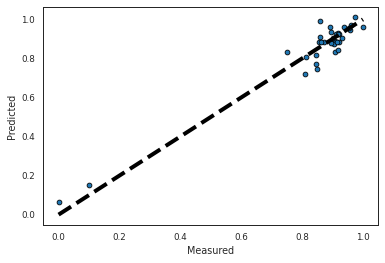

In [1565]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis


In [1566]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

<AxesSubplot:xlabel='elasticity', ylabel='feature'>

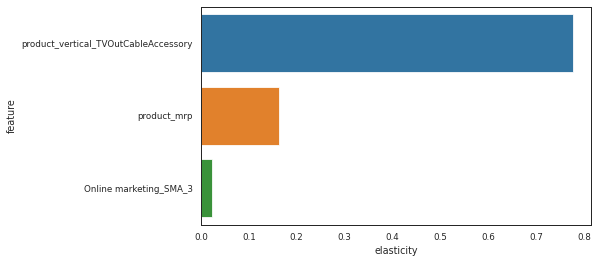

In [1567]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

##Home Audio - Multiplicative model

In [1568]:
#Splitting the Dataframe into Training and Testing Sets
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(home_mul_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1569]:
#Rescaling the Features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [1570]:
home_mul_df.columns

Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'special_sales', 'product_vertical_Dock', 'product_vertical_DockingStation', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_vertical_SoundMixer', 'product_vertical_VoiceRecorder', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5',
    

In [1571]:
num_vars=['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'special_sales', 'product_vertical_Dock', 'product_vertical_DockingStation', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_vertical_SoundMixer', 
'product_vertical_VoiceRecorder', 'pay_week', 'holiday_week', 'Total Investment', 
'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 
'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 
'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship',
 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 
 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 
 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 
 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 
 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 
 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5', 
 'Stock Index', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 
 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 
 'Snow on Grnd (cm)']

In [1572]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1573]:
# assigning x_traim amd y_train values
y_train = df_train.pop('gmv')
X_train = df_train

In [1574]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [1575]:
rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1576]:
# selecting the top 20 features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Discount%', 'deliverybdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_vertical_VoiceRecorder', 'Digital_SMA_5', 'Sponsorship_SMA_3', 'Affiliates_SMA_5', 'Radio_SMA_3', 'Other', 'Other_Ad_Stock', 'NPS_SMA_3', 'Stock Index', 'Cool Deg Days'], dtype='object')

In [1577]:
# neglecting the features other than top 20 features given by rfe
X_train.columns[~rfe.support_]

Index(['deliverycdays', 'special_sales', 'product_vertical_Dock', 'product_vertical_DockingStation', 'product_vertical_SoundMixer', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'NPS',
   

In [1578]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1579]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

In [1580]:
lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     4438.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.05e-20
Time:                        10:34:31   Log-Likelihood:                 159.62
No. Observations:                  33   AIC:                            -277.2
Df Residuals:                      12   BIC:                            -245.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
6                      is_mass_market 1741.15
0                               const 1725.37
9   product_vertical_HomeAudioSpeaker  647.91
7            product_vertical_FMRadio  514.11
11     product_vertical_VoiceRecorder   71.39
20                      Cool Deg Days   44.43
1                           Discount%   43.12
12                      Digital_SMA_5   39.79
10                        product_mrp   30.92
5          order_payment_type_Prepaid   25.23
14                   Affiliates_SMA_5   22.37
17                     Other_Ad_Stock   21.96
4             product_procurement_sla   17.41
8         product_vertical_HiFiSystem   16.67
16                              Other   15.38
13                  Sponsorship_SMA_3   15.29
19                        Stock Index   15.16
15                        Radio_SMA_3   12.83
2                       deliverybdays    9.01
18                          NPS_SMA_3    8.66
3                                 sla    8.13

In [1581]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["is_mass_market"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2257.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.89e-20
Time:                        10:34:32   Log-Likelihood:                 146.30
No. Observations:                  33   AIC:                            -252.6
Df Residuals:                      13   BIC:                            -222.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
0                               const 1698.97
6            product_vertical_FMRadio  142.88
8   product_vertical_HomeAudioSpeaker  130.09
10     product_vertical_VoiceRecorder   66.30
19                      Cool Deg Days   44.38
1                           Discount%   42.24
11                      Digital_SMA_5   36.07
9                         product_mrp   30.90
5          order_payment_type_Prepaid   24.39
16                     Other_Ad_Stock   21.88
13                   Affiliates_SMA_5   17.72
4             product_procurement_sla   17.20
7         product_vertical_HiFiSystem   16.00
18                        Stock Index   14.54
12                  Sponsorship_SMA_3   14.20
15                              Other   13.91
14                        Radio_SMA_3   12.66
2                       deliverybdays    8.93
17                          NPS_SMA_3    8.30
3                                 sla    6.67

In [1582]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_FMRadio"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     724.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.04e-17
Time:                        10:34:32   Log-Likelihood:                 125.46
No. Observations:                  33   AIC:                            -212.9
Df Residuals:                      14   BIC:                            -184.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
0                               const 1081.14
7   product_vertical_HomeAudioSpeaker  130.08
9      product_vertical_VoiceRecorder   44.30
18                      Cool Deg Days   31.77
1                           Discount%   26.53
10                      Digital_SMA_5   20.85
12                   Affiliates_SMA_5   17.47
6         product_vertical_HiFiSystem   15.60
4             product_procurement_sla   14.82
15                     Other_Ad_Stock   13.47
5          order_payment_type_Prepaid   13.35
14                              Other   13.16
17                        Stock Index   10.66
8                         product_mrp   10.46
13                        Radio_SMA_3    7.96
11                  Sponsorship_SMA_3    7.42
3                                 sla    6.42
16                          NPS_SMA_3    6.07
2                       deliverybdays    5.73

In [1583]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_VoiceRecorder"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     464.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.50e-17
Time:                        10:34:32   Log-Likelihood:                 116.06
No. Observations:                  33   AIC:                            -196.1
Df Residuals:                      15   BIC:                            -169.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
0                               const 1062.29
7   product_vertical_HomeAudioSpeaker   48.91
11                   Affiliates_SMA_5   13.85
14                     Other_Ad_Stock   13.25
5          order_payment_type_Prepaid   12.27
6         product_vertical_HiFiSystem    9.50
8                         product_mrp    9.28
17                      Cool Deg Days    8.76
1                           Discount%    8.07
13                              Other    8.00
4             product_procurement_sla    6.62
12                        Radio_SMA_3    6.34
3                                 sla    5.33
16                        Stock Index    4.15
2                       deliverybdays    4.12
9                       Digital_SMA_5    4.07
10                  Sponsorship_SMA_3    3.54
15                          NPS_SMA_3    1.76

In [1584]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Other_Ad_Stock"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     360.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.15e-17
Time:                        10:34:32   Log-Likelihood:                 109.83
No. Observations:                  33   AIC:                            -185.7
Df Residuals:                      16   BIC:                            -160.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 993.57
7   product_vertical_HomeAudioSpeaker  35.63
11                   Affiliates_SMA_5  12.22
5          order_payment_type_Prepaid  10.37
8                         product_mrp   9.27
6         product_vertical_HiFiSystem   9.05
16                      Cool Deg Days   8.34
1                           Discount%   6.63
4             product_procurement_sla   6.62
3                                 sla   5.33
12                        Radio_SMA_3   4.62
9                       Digital_SMA_5   4.05
15                        Stock Index   4.01
13                              Other   3.48
10                  Sponsorship_SMA_3   3.42
2                       deliverybdays   3.03
14                          NPS_SMA_3   1.73

In [1585]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     398.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.29e-18
Time:                        10:34:32   Log-Likelihood:                 109.40
No. Observations:                  33   AIC:                            -186.8
Df Residuals:                      17   BIC:                            -162.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 935.03
7   product_vertical_HomeAudioSpeaker  26.52
5          order_payment_type_Prepaid  10.30
8                         product_mrp   9.18
6         product_vertical_HiFiSystem   8.88
1                           Discount%   6.63
4             product_procurement_sla   6.60
15                      Cool Deg Days   5.06
11                        Radio_SMA_3   4.55
14                        Stock Index   4.01
3                                 sla   3.87
9                       Digital_SMA_5   3.66
12                              Other   3.47
10                  Sponsorship_SMA_3   3.05
2                       deliverybdays   2.97
13                          NPS_SMA_3   1.70

In [1586]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_HiFiSystem"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     398.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.81e-19
Time:                        10:34:32   Log-Likelihood:                 107.33
No. Observations:                  33   AIC:                            -184.7
Df Residuals:                      18   BIC:                            -162.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 731.15
6   product_vertical_HomeAudioSpeaker  16.06
5          order_payment_type_Prepaid  10.26
7                         product_mrp   7.80
1                           Discount%   6.24
4             product_procurement_sla   6.16
14                      Cool Deg Days   4.57
13                        Stock Index   3.80
3                                 sla   3.63
8                       Digital_SMA_5   3.50
11                              Other   3.34
10                        Radio_SMA_3   3.04
9                   Sponsorship_SMA_3   3.01
2                       deliverybdays   2.79
12                          NPS_SMA_3   1.67

In [1587]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["order_payment_type_Prepaid"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     288.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.76e-19
Time:                        10:34:33   Log-Likelihood:                 99.937
No. Observations:                  33   AIC:                            -171.9
Df Residuals:                      19   BIC:                            -150.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 730.60
5   product_vertical_HomeAudioSpeaker  11.43
6                         product_mrp   7.79
4             product_procurement_sla   6.01
1                           Discount%   5.52
13                      Cool Deg Days   4.54
12                        Stock Index   3.77
3                                 sla   3.55
7                       Digital_SMA_5   3.47
10                              Other   3.29
8                   Sponsorship_SMA_3   3.01
9                         Radio_SMA_3   2.96
2                       deliverybdays   2.52
11                          NPS_SMA_3   1.66

In [1588]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     327.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.24e-20
Time:                        10:34:33   Log-Likelihood:                 99.846
No. Observations:                  33   AIC:                            -173.7
Df Residuals:                      20   BIC:                            -154.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 651.61
5   product_vertical_HomeAudioSpeaker  10.17
6                         product_mrp   7.48
4             product_procurement_sla   5.53
1                           Discount%   5.14
12                      Cool Deg Days   4.27
3                                 sla   3.19
9                         Radio_SMA_3   2.84
2                       deliverybdays   2.33
8                   Sponsorship_SMA_3   2.32
7                       Digital_SMA_5   2.02
10                              Other   1.66
11                          NPS_SMA_3   1.64

In [1589]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_procurement_sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     366.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.04e-21
Time:                        10:34:33   Log-Likelihood:                 99.476
No. Observations:                  33   AIC:                            -175.0
Df Residuals:                      21   BIC:                            -157.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 507.51
4   product_vertical_HomeAudioSpeaker   9.37
5                         product_mrp   7.04
1                           Discount%   4.57
11                      Cool Deg Days   2.60
7                   Sponsorship_SMA_3   2.29
2                       deliverybdays   2.25
3                                 sla   1.95
6                       Digital_SMA_5   1.89
8                         Radio_SMA_3   1.73
10                          NPS_SMA_3   1.58
9                               Other   1.38

In [1590]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Cool Deg Days"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     417.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.11e-22
Time:                        10:34:33   Log-Likelihood:                 99.261
No. Observations:                  33   AIC:                            -176.5
Df Residuals:                      22   BIC:                            -160.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 506.89
4   product_vertical_HomeAudioSpeaker   8.10
5                         product_mrp   6.80
1                           Discount%   3.14
7                   Sponsorship_SMA_3   2.16
3                                 sla   1.94
2                       deliverybdays   1.88
6                       Digital_SMA_5   1.74
8                         Radio_SMA_3   1.71
10                          NPS_SMA_3   1.52
9                               Other   1.32

In [1591]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Sponsorship_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     454.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.01e-23
Time:                        10:34:33   Log-Likelihood:                 98.208
No. Observations:                  33   AIC:                            -176.4
Df Residuals:                      23   BIC:                            -161.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 500.71
4  product_vertical_HomeAudioSpeaker   7.84
5                        product_mrp   5.50
1                          Discount%   3.10
3                                sla   1.90
2                      deliverybdays   1.71
7                        Radio_SMA_3   1.71
6                      Digital_SMA_5   1.66
9                          NPS_SMA_3   1.42
8                              Other   1.32

In [1592]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Discount%"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     533.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.18e-25
Time:                        10:34:33   Log-Likelihood:                 98.206
No. Observations:                  33   AIC:                            -178.4
Df Residuals:                      24   BIC:                            -164.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 499.99
3  product_vertical_HomeAudioSpeaker   5.79
4                        product_mrp   5.47
2                                sla   1.76
6                        Radio_SMA_3   1.71
1                      deliverybdays   1.69
5                      Digital_SMA_5   1.64
8                          NPS_SMA_3   1.42
7                              Other   1.32

In [1593]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Radio_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     583.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.53e-26
Time:                        10:34:33   Log-Likelihood:                 96.818
No. Observations:                  33   AIC:                            -177.6
Df Residuals:                      25   BIC:                            -165.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 464.59
3  product_vertical_HomeAudioSpeaker   5.68
4                        product_mrp   5.40
2                                sla   1.73
1                      deliverybdays   1.47
7                          NPS_SMA_3   1.41
5                      Digital_SMA_5   1.33
6                              Other   1.13

In [1594]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["deliverybdays"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     705.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.71e-27
Time:                        10:34:33   Log-Likelihood:                 96.750
No. Observations:                  33   AIC:                            -179.5
Df Residuals:                      26   BIC:                            -169.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 341.33
3                        product_mrp   4.99
2  product_vertical_HomeAudioSpeaker   4.82
1                                sla   1.46
6                          NPS_SMA_3   1.37
4                      Digital_SMA_5   1.24
5                              Other   1.03

In [1595]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     866.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.57e-29
Time:                        10:34:33   Log-Likelihood:                 96.515
No. Observations:                  33   AIC:                            -181.0
Df Residuals:                      27   BIC:                            -172.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 163.51
3                        product_mrp   3.84
2  product_vertical_HomeAudioSpeaker   3.77
1                                sla   1.46
4                      Digital_SMA_5   1.21
5                              Other   1.03

In [1596]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Digital_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1121.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.87e-30
Time:                        10:34:34   Log-Likelihood:                 96.487
No. Observations:                  33   AIC:                            -183.0
Df Residuals:                      28   BIC:                            -175.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 161.82
3                        product_mrp   3.83
2  product_vertical_HomeAudioSpeaker   3.69
1                                sla   1.23
4                              Other   1.02

In [1597]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Other"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1365.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.65e-31
Time:                        10:34:34   Log-Likelihood:                 94.427
No. Observations:                  33   AIC:                            -180.9
Df Residuals:                      29   BIC:                            -174.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 161.56
3                        product_mrp   3.81
2  product_vertical_HomeAudioSpeaker   3.69
1                                sla   1.23

In [1598]:
X_train_rfe.columns


Index(['sla', 'product_vertical_HomeAudioSpeaker', 'product_mrp'], dtype='object')

In [1599]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Sponsorship_SMA_3', 'deliverycdays', 'Affiliates_Ad_Stock', 'Online marketing', 'Mean Temp', 'product_vertical_DockingStation', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'Radio_EMA_8', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'Other_Ad_Stock', 'pay_week', 'TV_EMA_8', 'Stock Index_SMA_5', 'Sponsorship_EMA_8', 'Radio_Ad_Stock', 'Min Temp', 'Affiliates_SMA_5', 'order_payment_type_Prepaid', 'SEM_Ad_Stock', 'NPS', 'TV', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'product_vertical_Dock', 'product_vertical_HiFiSystem', 'product_vertical_SoundMixer', 'Total Precip (mm)', 'is_mass_market', 'Sponsorship_SMA_5', 'Discount%', 'gmv', 'Sponsorship_Ad_Stock', 'Total Snow (cm)', 'product_vertical_FMRadio', 'SEM_EMA_8', 'TV_SMA_5', 'SEM', 'Cool Deg Days', 'Digital', 'deliverybdays', 'Online_marketing_Ad_Stock', 'Digital_EMA_8', 'holiday_week', 'Digital_SMA_

In [1600]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ 0.23154533, -1.32771103,  0.83048008,  0.84689224,  0.72086936,
        0.35748485,  0.17480168,  0.8543667 , -0.50225411,  0.47549723])

In [1601]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)


In [1602]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.0025302284261259507
r_square_value : 0.9071009448790766


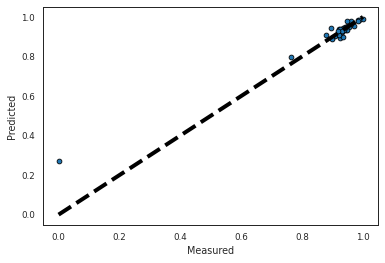

In [1603]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis


In [1604]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

<AxesSubplot:xlabel='elasticity', ylabel='feature'>

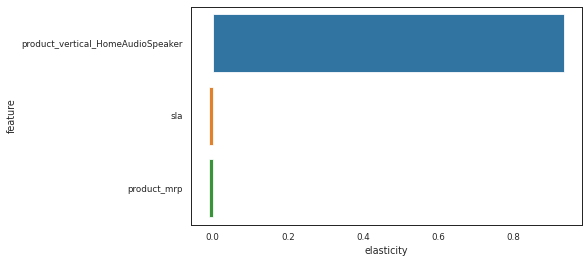

In [1605]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

#Koyck Model


In [1606]:
# Making copy of dataframes from the original ones
cam_koy_df = Camera_accessory_org_df.copy()
gam_koy_df = gaming_accessory_org_df.copy()
home_koy_df = Homeaudio_org_df.copy()
home_koy_df.head() 

gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  special_sales  product_vertical_Dock  product_vertical_DockingStation  product_vertical_FMRadio  product_vertical_HiFiSystem  product_vertical_HomeAudioSpeaker  product_mrp  product_vertical_SoundMixer  product_vertical_VoiceRecorder  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  \
26 1185712.00      30.67           0.00           0.00 7.00                     1.95                      213.00             793              0                     24                                1                    334.00                            8                             541.00      1958.61                            0                               2         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05         0.05     0.63           0.00           0.00           0.63              0.63         1.85               0.00               0.00               1.85                  1.85               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.33        0.14              0.00   
27 1471962.00      30.37           0.00           0.00 6.71                     1.78                      243.00             936            297                     36                                0                    374.00                           19                             657.00      2016.77                            0                               7         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05         0.09     0.63           0.00           0.00           0.63              1.01         1.85               0.00               0.00               1.85                  2.97               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.53        0.14              0.00   
28 1275392.00      28.88           0.00           0.00 6.82                     1.80                      191.00             909              0                     40                                0                    394.00                           16                             544.00      1896.30                            0                               1         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05         0.11     0.63           0.63           0.00           0.63              1.24         1.85               1.85               0.00               1.85                  3.63               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.33                    0.00                    0.33                       0.65        0.14              0.14   
29  920394.00      28.04           0.00           0.00

###Camera Accessory - Kyock's Model


In [1607]:
def createKyockKPI(df):
    df['gmv_lag'] = df['gmv'].shift(1)
    return df.fillna(0)

In [1608]:
# adding lag variable in the camera data set
df = createKyockKPI(cam_koy_df)
df.head()

gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  \
26 1088715.00      45.59           0.00           0.00 6.36                     2.08      1143.14                      566.00            1734                                39              0                      260.00                          349.00                                 167.00                                   7                              0                                 0                               0                                  0                             3                                 70.00                         349.00                               0                   164.00                    8.00                                  0                 263.00                                   0                         0                      13                           4         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05   
27 1203752.00      47.02           0.00           0.00 6.06                     2.10      1197.19                      649.00            2005                                31            578                      284.00                          428.00                                 179.00                                   4                              0                                 0                               0                                  0                            10                                 85.00                         408.00                               0                   142.00                   11.00                                  0                 293.00                                   0                         0                      22                          15         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05   
28 1183338.00      44.83           0.00           0.00 6.17                     2.12      1162.70                      606.00            1991                                43              0                      223.00                          455.00                                 218.00                                   4                              0                                 0                               0                                  0                             7                                 68.00                         370.00                               0                   148.00                    7.00                                  0                 325.00                                   0                         0                      21                          23         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05   
29  813136.00      44.89           0.00           0.00

In [1609]:
df.shape


(48, 99)

In [1610]:
df.head()


gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  \
26 1088715.00      45.59           0.00           0.00 6.36                     2.08      1143.14                      566.00            1734                                39              0                      260.00                          349.00                                 167.00                                   7                              0                                 0                               0                                  0                             3                                 70.00                         349.00                               0                   164.00                    8.00                                  0                 263.00                                   0                         0                      13                           4         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05   
27 1203752.00      47.02           0.00           0.00 6.06                     2.10      1197.19                      649.00            2005                                31            578                      284.00                          428.00                                 179.00                                   4                              0                                 0                               0                                  0                            10                                 85.00                         408.00                               0                   142.00                   11.00                                  0                 293.00                                   0                         0                      22                          15         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05   
28 1183338.00      44.83           0.00           0.00 6.17                     2.12      1162.70                      606.00            1991                                43              0                      223.00                          455.00                                 218.00                                   4                              0                                 0                               0                                  0                             7                                 68.00                         370.00                               0                   148.00                    7.00                                  0                 325.00                                   0                         0                      21                          23         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05   
29  813136.00      44.89           0.00           0.00

In [1611]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1612]:
scaler = MinMaxScaler()


In [1613]:
df.columns


Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'product_mrp', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraAccessory', 'special_sales', 'product_vertical_CameraBag', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing', 'product_vertical_CameraMicrophone', 'product_vertical_CameraMount', 'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_Filter', 'product_vertical_Flash', 'product_vertical_FlashShoeAdapter', 'product_vertical_Lens', 'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox', 'product_vertical_Strap', 'product_vertical_Telescope', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8',
    

In [1614]:
num_vars=['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'product_mrp', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_CameraAccessory', 'special_sales', 'product_vertical_CameraBag', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraHousing', 'product_vertical_CameraMicrophone', 'product_vertical_CameraMount', 'product_vertical_CameraRemoteControl', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_Filter', 'product_vertical_Flash', 'product_vertical_FlashShoeAdapter', 'product_vertical_Lens', 'product_vertical_ReflectorUmbrella', 'product_vertical_Softbox', 'product_vertical_Strap', 'product_vertical_Telescope', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8',
       'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5', 'Stock Index', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days',
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'gmv_lag']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1615]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1616]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1617]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Discount%', 'sla', 'is_mass_market', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryCharger', 'product_vertical_CameraFilmRolls', 'product_vertical_CameraMicrophone', 'product_vertical_CameraTripod', 'product_vertical_FlashShoeAdapter', 'product_vertical_Softbox', 'product_vertical_Telescope', 'Sponsorship', 'Online marketing', 'Affiliates', 'Radio_SMA_3', 'Mean Temp', 'Total Rain (mm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'gmv_lag'], dtype='object')

In [1618]:
# negelecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['deliverybdays', 'deliverycdays', 'product_procurement_sla', 'product_mrp', 'order_payment_type_Prepaid', 'product_vertical_CameraAccessory', 'special_sales', 'product_vertical_CameraBag', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraEyeCup', 'product_vertical_CameraHousing', 'product_vertical_CameraMount', 'product_vertical_CameraRemoteControl', 'product_vertical_ExtensionTube', 'product_vertical_Filter', 'product_vertical_Flash', 'product_vertical_Lens', 'product_vertical_ReflectorUmbrella', 'product_vertical_Strap', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3',
       'Content Market

In [1619]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1620]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2432.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.13e-18
Time:                        10:34:35   Log-Likelihood:                 150.22
No. Observations:                  33   AIC:                            -258.4
Df Residuals:                      12   BIC:                            -227.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Features    VIF
0                                   const 561.96
13                       Online marketing 332.97
14                             Affiliates 305.05
18                      Total Precip (mm)  41.16
5   product_vertical_CameraBatteryCharger  35.67
17                        Total Rain (mm)  35.56
3                          is_mass_market  28.11
1                               Discount%  20.69
4          product_vertical_CameraBattery  16.91
11             product_vertical_Telescope  16.65
12                            Sponsorship  14.21
6        product_vertical_CameraFilmRolls  11.66
2                                     sla  11.34
16                              Mean Temp  11.18
7       product_vertical_CameraMicrophone   7.49
8           product_vertical_CameraTripod   3.96
15                            Radio_SMA_3   3.17
10               product_vertical_Softbox   3.08
20                                gmv_lag   3.01
9       product_vertical_FlashShoeAdapter   2.99
19                      Snow on Grnd (cm)   2.98

In [1621]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["is_mass_market"], axis = 1)

In [1622]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     24.99
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.81e-07
Time:                        10:34:36   Log-Likelihood:                 72.959
No. Observations:                  33   AIC:                            -105.9
Df Residuals:                      13   BIC:                            -75.99
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [1623]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                   const 430.85
12                       Online marketing 310.62
13                             Affiliates 295.07
17                      Total Precip (mm)  40.13
16                        Total Rain (mm)  35.18
4   product_vertical_CameraBatteryCharger  32.94
10             product_vertical_Telescope  16.65
3          product_vertical_CameraBattery  16.61
1                               Discount%  14.03
15                              Mean Temp  10.99
11                            Sponsorship   9.23
5        product_vertical_CameraFilmRolls   8.50
2                                     sla   8.49
6       product_vertical_CameraMicrophone   6.90
9                product_vertical_Softbox   3.05
8       product_vertical_FlashShoeAdapter   2.98
14                            Radio_SMA_3   2.81
7           product_vertical_CameraTripod   2.76
18                      Snow on Grnd (cm)   2.76
19                                gmv_lag   2.70

In [1624]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     27.90
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.74e-08
Time:                        10:34:36   Log-Likelihood:                 72.665
No. Observations:                  33   AIC:                            -107.3
Df Residuals:                      14   BIC:                            -78.90
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Features    VIF
0                                   const 417.71
16                      Total Precip (mm)  35.91
4   product_vertical_CameraBatteryCharger  32.13
15                        Total Rain (mm)  30.26
3          product_vertical_CameraBattery  16.53
10             product_vertical_Telescope  16.05
1                               Discount%  12.79
14                              Mean Temp  10.38
12                       Online marketing   8.83
2                                     sla   8.48
5        product_vertical_CameraFilmRolls   7.67
11                            Sponsorship   6.56
6       product_vertical_CameraMicrophone   4.54
8       product_vertical_FlashShoeAdapter   2.95
17                      Snow on Grnd (cm)   2.72
13                            Radio_SMA_3   2.69
7           product_vertical_CameraTripod   2.53
9                product_vertical_Softbox   2.50
18                                gmv_lag   2.26

In [1625]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Total Precip (mm)"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     31.62
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           9.91e-09
Time:                        10:34:36   Log-Likelihood:                 72.651
No. Observations:                  33   AIC:                            -109.3
Df Residuals:                      15   BIC:                            -82.37
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Features    VIF
0                                   const 400.19
4   product_vertical_CameraBatteryCharger  30.85
3          product_vertical_CameraBattery  16.36
10             product_vertical_Telescope  15.46
1                               Discount%  12.72
12                       Online marketing   8.61
14                              Mean Temp   8.58
2                                     sla   8.47
5        product_vertical_CameraFilmRolls   7.67
11                            Sponsorship   6.45
6       product_vertical_CameraMicrophone   4.34
8       product_vertical_FlashShoeAdapter   2.94
16                      Snow on Grnd (cm)   2.67
7           product_vertical_CameraTripod   2.53
9                product_vertical_Softbox   2.50
13                            Radio_SMA_3   2.50
17                                gmv_lag   2.22
15                        Total Rain (mm)   1.81

In [1626]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     19.68
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.42e-07
Time:                        10:34:36   Log-Likelihood:                 63.122
No. Observations:                  33   AIC:                            -92.24
Df Residuals:                      16   BIC:                            -66.80
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Features    VIF
0                                   const 112.63
3   product_vertical_CameraBatteryCharger  30.85
2          product_vertical_CameraBattery  16.03
9              product_vertical_Telescope  11.03
11                       Online marketing   8.61
13                              Mean Temp   8.55
4        product_vertical_CameraFilmRolls   6.75
10                            Sponsorship   6.24
1                               Discount%   5.10
5       product_vertical_CameraMicrophone   4.18
6           product_vertical_CameraTripod   2.51
7       product_vertical_FlashShoeAdapter   2.47
12                            Radio_SMA_3   2.47
8                product_vertical_Softbox   2.34
15                      Snow on Grnd (cm)   2.21
16                                gmv_lag   1.96
14                        Total Rain (mm)   1.81

In [1627]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Mean Temp"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     22.29
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.90e-08
Time:                        10:34:36   Log-Likelihood:                 63.117
No. Observations:                  33   AIC:                            -94.23
Df Residuals:                      17   BIC:                            -70.29
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Features   VIF
0                                   const 31.74
3   product_vertical_CameraBatteryCharger 17.28
9              product_vertical_Telescope 10.57
2          product_vertical_CameraBattery  9.17
4        product_vertical_CameraFilmRolls  6.09
1                               Discount%  4.24
10                            Sponsorship  3.36
11                       Online marketing  3.33
5       product_vertical_CameraMicrophone  2.79
6           product_vertical_CameraTripod  2.41
12                            Radio_SMA_3  2.41
8                product_vertical_Softbox  2.32
7       product_vertical_FlashShoeAdapter  2.18
15                                gmv_lag  1.90
13                        Total Rain (mm)  1.72
14                      Snow on Grnd (cm)  1.71

In [1628]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_FlashShoeAdapter"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     16.52
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.79e-07
Time:                        10:34:36   Log-Likelihood:                 56.510
No. Observations:                  33   AIC:                            -83.02
Df Residuals:                      18   BIC:                            -60.57
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Features   VIF
0                                   const 31.42
3   product_vertical_CameraBatteryCharger 13.55
8              product_vertical_Telescope  9.37
2          product_vertical_CameraBattery  8.39
4        product_vertical_CameraFilmRolls  5.86
1                               Discount%  3.65
9                             Sponsorship  2.93
10                       Online marketing  2.82
5       product_vertical_CameraMicrophone  2.79
7                product_vertical_Softbox  2.32
11                            Radio_SMA_3  2.11
6           product_vertical_CameraTripod  2.10
14                                gmv_lag  1.88
13                      Snow on Grnd (cm)  1.69
12                        Total Rain (mm)  1.41

In [1629]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraBatteryCharger"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     18.46
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.58e-08
Time:                        10:34:36   Log-Likelihood:                 56.248
No. Observations:                  33   AIC:                            -84.50
Df Residuals:                      19   BIC:                            -63.54
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 31.30
7          product_vertical_Telescope  8.07
3    product_vertical_CameraFilmRolls  5.65
2      product_vertical_CameraBattery  4.72
1                           Discount%  3.65
8                         Sponsorship  2.87
9                    Online marketing  2.82
6            product_vertical_Softbox  2.30
5       product_vertical_CameraTripod  2.10
10                        Radio_SMA_3  1.92
4   product_vertical_CameraMicrophone  1.89
13                            gmv_lag  1.87
12                  Snow on Grnd (cm)  1.52
11                    Total Rain (mm)  1.41

In [1630]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraFilmRolls"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     20.58
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.17e-08
Time:                        10:34:36   Log-Likelihood:                 55.905
No. Observations:                  33   AIC:                            -85.81
Df Residuals:                      20   BIC:                            -66.36
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 29.06
2      product_vertical_CameraBattery  3.41
6          product_vertical_Telescope  3.21
7                         Sponsorship  2.83
8                    Online marketing  2.81
1                           Discount%  2.76
5            product_vertical_Softbox  2.11
9                         Radio_SMA_3  1.90
3   product_vertical_CameraMicrophone  1.89
4       product_vertical_CameraTripod  1.89
12                            gmv_lag  1.86
11                  Snow on Grnd (cm)  1.50
10                    Total Rain (mm)  1.41

In [1631]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Sponsorship"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     16.42
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.49e-08
Time:                        10:34:36   Log-Likelihood:                 50.467
No. Observations:                  33   AIC:                            -76.93
Df Residuals:                      21   BIC:                            -58.98
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 28.97
2      product_vertical_CameraBattery  3.38
6          product_vertical_Telescope  3.21
1                           Discount%  2.75
5            product_vertical_Softbox  2.10
3   product_vertical_CameraMicrophone  1.88
4       product_vertical_CameraTripod  1.86
11                            gmv_lag  1.86
7                    Online marketing  1.52
8                         Radio_SMA_3  1.44
10                  Snow on Grnd (cm)  1.35
9                     Total Rain (mm)  1.26

In [1632]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["gmv_lag"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     18.91
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.44e-08
Time:                        10:34:36   Log-Likelihood:                 50.453
No. Observations:                  33   AIC:                            -78.91
Df Residuals:                      22   BIC:                            -62.44
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 28.31
2      product_vertical_CameraBattery  3.37
6          product_vertical_Telescope  3.17
1                           Discount%  2.66
3   product_vertical_CameraMicrophone  1.88
4       product_vertical_CameraTripod  1.75
5            product_vertical_Softbox  1.63
8                         Radio_SMA_3  1.42
7                    Online marketing  1.31
10                  Snow on Grnd (cm)  1.31
9                     Total Rain (mm)  1.26

In [1633]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Snow on Grnd (cm)"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     21.32
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.96e-09
Time:                        10:34:37   Log-Likelihood:                 50.013
No. Observations:                  33   AIC:                            -80.03
Df Residuals:                      23   BIC:                            -65.06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 28.15
2     product_vertical_CameraBattery  3.37
6         product_vertical_Telescope  2.99
1                          Discount%  2.57
3  product_vertical_CameraMicrophone  1.88
4      product_vertical_CameraTripod  1.74
5           product_vertical_Softbox  1.63
7                   Online marketing  1.31
9                    Total Rain (mm)  1.24
8                        Radio_SMA_3  1.22

In [1634]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Discount%"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     19.29
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.08e-08
Time:                        10:34:37   Log-Likelihood:                 46.233
No. Observations:                  33   AIC:                            -74.47
Df Residuals:                      24   BIC:                            -61.00
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 12.85
1     product_vertical_CameraBattery  3.37
5         product_vertical_Telescope  2.46
2  product_vertical_CameraMicrophone  1.88
4           product_vertical_Softbox  1.49
6                   Online marketing  1.29
3      product_vertical_CameraTripod  1.28
8                    Total Rain (mm)  1.23
7                        Radio_SMA_3  1.20

In [1635]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Total Rain (mm)"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.71e-09
Time:                        10:34:37   Log-Likelihood:                 45.485
No. Observations:                  33   AIC:                            -74.97
Df Residuals:                      25   BIC:                            -63.00
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 12.80
1     product_vertical_CameraBattery  2.99
5         product_vertical_Telescope  2.38
2  product_vertical_CameraMicrophone  1.88
4           product_vertical_Softbox  1.49
6                   Online marketing  1.29
3      product_vertical_CameraTripod  1.27
7                        Radio_SMA_3  1.20

In [1636]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Radio_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     26.43
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.83e-10
Time:                        10:34:37   Log-Likelihood:                 45.482
No. Observations:                  33   AIC:                            -76.96
Df Residuals:                      26   BIC:                            -66.49
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 12.80
1     product_vertical_CameraBattery  2.99
5         product_vertical_Telescope  2.35
2  product_vertical_CameraMicrophone  1.87
4           product_vertical_Softbox  1.48
3      product_vertical_CameraTripod  1.18
6                   Online marketing  1.15

In [1637]:
X_train_rfe.columns

Index(['product_vertical_CameraBattery', 'product_vertical_CameraMicrophone', 'product_vertical_CameraTripod', 'product_vertical_Softbox', 'product_vertical_Telescope', 'Online marketing'], dtype='object')

In [1638]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Sponsorship_SMA_3', 'deliverycdays', 'Affiliates_Ad_Stock', 'Mean Temp', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'Radio_EMA_8', 'product_vertical_CameraRemoteControl', 'product_vertical_ReflectorUmbrella', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'Other_Ad_Stock', 'pay_week', 'TV_EMA_8', 'Stock Index_SMA_5', 'product_vertical_CameraFilmRolls', 'Sponsorship_EMA_8', 'Affiliates_SMA_5', 'Min Temp', 'Radio_Ad_Stock', 'order_payment_type_Prepaid', 'NPS', 'SEM_Ad_Stock', 'TV', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'product_vertical_Lens', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'Total Precip (mm)', 'product_vertical_CameraMount', 'is_mass_market', 'Sponsorship_SMA_5', 'product_vertical_Strap', 'Discount%', 'product_vertical_ExtensionTube', 'gmv', 'product_vertical_CameraAccessory', 'Sponsorship_Ad_Stock', 'Total Snow (cm)', 'product_vertical_FlashShoeAdapter', 'product_vertical_

In [1639]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ -1.36377723,   0.96764232,   0.77451346,   0.88683863,
        -2.48060873,  -0.30824994,  -0.99129375,   0.82827328,
       -10.06955174,  -0.36552132])

In [1640]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1641]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.010714860496213483
r_square_value : 0.5940865793744604


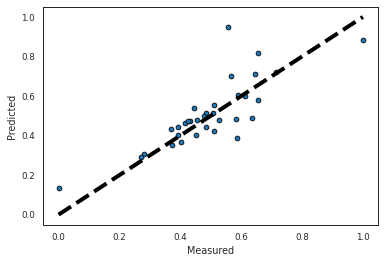

In [1642]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis


In [1643]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

<AxesSubplot:xlabel='elasticity', ylabel='feature'>

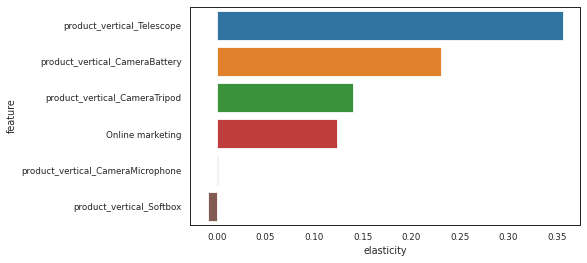

In [1644]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

##Gaming Accessory - Kyock's Model

In [1645]:
# adding lag variable in the camera data set
df = createKyockKPI(gam_koy_df)
df.head()

gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  product_vertical_GameControlMount  product_vertical_GamePad  product_mrp  special_sales  product_vertical_GamingAccessoryKit  product_vertical_GamingAdapter  product_vertical_GamingChargingStation  product_vertical_GamingHeadset  product_vertical_GamingKeyboard  product_vertical_GamingMemoryCard  product_vertical_GamingMouse  product_vertical_GamingMousePad  product_vertical_GamingSpeaker  product_vertical_JoystickGamingWheel  product_vertical_MotionController  product_vertical_TVOutCableAccessory  payd_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  \
26 1019727.00      42.15           0.00           0.00 5.52                     2.48                      390.00            1431                                  0                    621.00      1169.77              0                                   81                              37                                       0                          108.00                           375.00                              26.00                        184.00                               40                               0                                     4                                 10                                    66          0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05         0.05     0.63           0.00           0.00           0.63              0.63         1.85               0.00               0.00               1.85                  1.85   
27  968786.36      47.07           0.00           0.00 5.12                     2.46                      437.00            1775                                  0                   1235.00       860.06            512                                  120                              37                                       0                           95.00                           148.00                              24.00                        121.00                               29                               0                                     7                                  5                                    82          1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05         0.09     0.63           0.00           0.00           0.63              1.01         1.85               0.00               0.00               1.85                  2.97   
28  936947.00      38.60           0.00           0.00 5.49                     2.25                      304.00            1341                                  0                    740.00      1047.04              0                                  143                              26                                       0                          104.00                           149.00                              24.00                        122.00                               42                               0                                     7                                  7                                    84          0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05         0.11     0.63           0.63           0.00           0.63              1.24         1.85               1.85               0.00               1.85                  3.63   
29  711721.00      38.72           0.01           

In [1646]:
df.shape


(51, 92)

In [1647]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

scaler = MinMaxScaler()

In [1648]:
df.columns

Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GameControlMount', 'product_vertical_GamePad', 'product_mrp', 'special_sales', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingChargingStation', 'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_JoystickGamingWheel', 'product_vertical_MotionController', 'product_vertical_TVOutCableAccessory', 'payd_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship',
       'Spo

In [1649]:
num_vars=['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GameControlMount', 'product_vertical_GamePad', 'product_mrp', 'special_sales', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingChargingStation', 'product_vertical_GamingHeadset', 'product_vertical_GamingKeyboard', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_JoystickGamingWheel', 'product_vertical_MotionController', 'product_vertical_TVOutCableAccessory', 'payd_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship',
       'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5', 'Stock Index', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'gmv_lag']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1650]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1651]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1652]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['deliverycdays', 'product_procurement_sla', 'is_mass_market', 'product_vertical_GameControlMount', 'product_mrp', 'special_sales', 'product_vertical_GamingAdapter', 'product_vertical_GamingKeyboard', 'product_vertical_GamingMouse', 'product_vertical_JoystickGamingWheel', 'product_vertical_TVOutCableAccessory', 'Total Investment_SMA_3', 'TV_SMA_3', 'TV_SMA_5', 'Content Marketing_SMA_5', 'Online marketing_SMA_5', 'Affiliates_SMA_5', 'Other_SMA_3', 'Cool Deg Days', 'Total Snow (cm)'], dtype='object')

In [1653]:
# negelecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['Discount%', 'deliverybdays', 'sla', 'order_payment_type_Prepaid', 'product_vertical_GamePad', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingChargingStation', 'product_vertical_GamingHeadset', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMousePad', 'product_vertical_GamingSpeaker', 'product_vertical_MotionController', 'payd_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM',
   

In [1654]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1655]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1757.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.81e-20
Time:                        10:34:40   Log-Likelihood:                 142.78
No. Observations:                  35   AIC:                            -243.6
Df Residuals:                      14   BIC:                            -210.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features     VIF
17                      Affiliates_SMA_5 3175.90
16                Online marketing_SMA_5 2857.64
0                                  const  190.38
14                              TV_SMA_5   48.24
10  product_vertical_JoystickGamingWheel   47.69
15               Content Marketing_SMA_5   41.10
1                          deliverycdays   33.75
9           product_vertical_GamingMouse   32.92
13                              TV_SMA_3   28.76
12                Total Investment_SMA_3   23.75
3                         is_mass_market   20.68
8        product_vertical_GamingKeyboard   16.53
7         product_vertical_GamingAdapter   13.31
6                          special_sales   12.06
19                         Cool Deg Days   10.81
5                            product_mrp    7.45
18                           Other_SMA_3    6.19
2                product_procurement_sla    5.43
11  product_vertical_TVOutCableAccessory    2.78
20                       Total Snow (cm)    2.61
4      product_vertical_GameControlMount    1.55

In [1656]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_5"], axis = 1)


In [1657]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1443.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.25e-21
Time:                        10:34:40   Log-Likelihood:                 137.23
No. Observations:                  35   AIC:                            -234.5
Df Residuals:                      15   BIC:                            -203.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1658]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 145.39
16                Online marketing_SMA_5  32.89
14                              TV_SMA_5  28.68
13                              TV_SMA_3  27.81
9           product_vertical_GamingMouse  27.38
10  product_vertical_JoystickGamingWheel  25.37
1                          deliverycdays  24.52
12                Total Investment_SMA_3  23.20
3                         is_mass_market  17.41
15               Content Marketing_SMA_5  11.64
6                          special_sales  11.59
7         product_vertical_GamingAdapter  10.37
8        product_vertical_GamingKeyboard  10.15
18                         Cool Deg Days   9.09
5                            product_mrp   7.02
2                product_procurement_sla   5.04
17                           Other_SMA_3   4.69
11  product_vertical_TVOutCableAccessory   2.78
19                       Total Snow (cm)   2.40
4      product_vertical_GameControlMount   1.45

In [1659]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online marketing_SMA_5"], axis = 1)

In [1660]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     878.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.39e-20
Time:                        10:34:40   Log-Likelihood:                 126.48
No. Observations:                  35   AIC:                            -215.0
Df Residuals:                      16   BIC:                            -185.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1661]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 129.31
14                              TV_SMA_5  28.55
13                              TV_SMA_3  26.94
9           product_vertical_GamingMouse  24.91
10  product_vertical_JoystickGamingWheel  23.13
12                Total Investment_SMA_3  18.98
1                          deliverycdays  18.83
3                         is_mass_market  14.12
6                          special_sales  11.17
15               Content Marketing_SMA_5  11.11
7         product_vertical_GamingAdapter  10.24
17                         Cool Deg Days   7.46
8        product_vertical_GamingKeyboard   7.07
5                            product_mrp   6.94
2                product_procurement_sla   4.81
11  product_vertical_TVOutCableAccessory   2.76
18                       Total Snow (cm)   1.88
16                           Other_SMA_3   1.86
4      product_vertical_GameControlMount   1.23

In [1662]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     926.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.45e-22
Time:                        10:34:40   Log-Likelihood:                 125.35
No. Observations:                  35   AIC:                            -214.7
Df Residuals:                      17   BIC:                            -186.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 122.30
9           product_vertical_GamingMouse  24.56
10  product_vertical_JoystickGamingWheel  22.46
1                          deliverycdays  18.72
13                              TV_SMA_5  16.71
3                         is_mass_market  13.72
12                Total Investment_SMA_3  12.31
6                          special_sales  11.03
14               Content Marketing_SMA_5   8.93
7         product_vertical_GamingAdapter   8.52
16                         Cool Deg Days   7.21
8        product_vertical_GamingKeyboard   7.00
5                            product_mrp   6.94
2                product_procurement_sla   4.73
11  product_vertical_TVOutCableAccessory   2.73
17                       Total Snow (cm)   1.88
15                           Other_SMA_3   1.74
4      product_vertical_GameControlMount   1.22

In [1663]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingAdapter"], axis = 1)

In [1664]:
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     493.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.84e-20
Time:                        10:34:40   Log-Likelihood:                 112.28
No. Observations:                  35   AIC:                            -190.6
Df Residuals:                      18   BIC:                            -164.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [1665]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                                  const 111.94
8           product_vertical_GamingMouse  19.43
9   product_vertical_JoystickGamingWheel  18.34
1                          deliverycdays  16.82
11                Total Investment_SMA_3  12.29
12                              TV_SMA_5  12.22
6                          special_sales  10.82
3                         is_mass_market  10.31
13               Content Marketing_SMA_5   8.90
15                         Cool Deg Days   7.20
5                            product_mrp   6.41
7        product_vertical_GamingKeyboard   5.78
2                product_procurement_sla   4.31
10  product_vertical_TVOutCableAccessory   2.72
16                       Total Snow (cm)   1.88
14                           Other_SMA_3   1.61
4      product_vertical_GameControlMount   1.16

In [1666]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["is_mass_market"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     16.40
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.55e-08
Time:                        10:34:41   Log-Likelihood:                 51.901
No. Observations:                  35   AIC:                            -71.80
Df Residuals:                      19   BIC:                            -46.92
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 111.31
8   product_vertical_JoystickGamingWheel  17.43
1                          deliverycdays  16.14
7           product_vertical_GamingMouse  15.54
11                              TV_SMA_5  11.82
10                Total Investment_SMA_3  11.52
5                          special_sales  10.55
12               Content Marketing_SMA_5   8.42
14                         Cool Deg Days   6.41
6        product_vertical_GamingKeyboard   5.37
4                            product_mrp   4.46
2                product_procurement_sla   4.20
9   product_vertical_TVOutCableAccessory   2.37
15                       Total Snow (cm)   1.88
13                           Other_SMA_3   1.58
3      product_vertical_GameControlMount   1.15

In [1667]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Cool Deg Days"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.87e-08
Time:                        10:34:41   Log-Likelihood:                 50.618
No. Observations:                  35   AIC:                            -71.24
Df Residuals:                      20   BIC:                            -47.91
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                  const 76.41
8   product_vertical_JoystickGamingWheel 17.00
1                          deliverycdays 15.47
7           product_vertical_GamingMouse 14.83
10                Total Investment_SMA_3 11.46
5                          special_sales 10.45
12               Content Marketing_SMA_5  8.19
11                              TV_SMA_5  7.00
6        product_vertical_GamingKeyboard  4.81
4                            product_mrp  4.45
2                product_procurement_sla  3.99
9   product_vertical_TVOutCableAccessory  2.32
14                       Total Snow (cm)  1.75
13                           Other_SMA_3  1.56
3      product_vertical_GameControlMount  1.15

In [1668]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_JoystickGamingWheel"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     17.53
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.09e-08
Time:                        10:34:41   Log-Likelihood:                 49.050
No. Observations:                  35   AIC:                            -70.10
Df Residuals:                      21   BIC:                            -48.33
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                  const 75.38
7           product_vertical_GamingMouse 10.30
5                          special_sales 10.01
9                 Total Investment_SMA_3  9.91
11               Content Marketing_SMA_5  7.98
4                            product_mrp  4.26
6        product_vertical_GamingKeyboard  4.20
2                product_procurement_sla  3.96
1                          deliverycdays  2.84
10                              TV_SMA_5  2.81
8   product_vertical_TVOutCableAccessory  2.14
13                       Total Snow (cm)  1.70
12                           Other_SMA_3  1.35
3      product_vertical_GameControlMount  1.14

In [1669]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_TVOutCableAccessory"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     13.16
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.21e-07
Time:                        10:34:41   Log-Likelihood:                 42.553
No. Observations:                  35   AIC:                            -59.11
Df Residuals:                      22   BIC:                            -38.89
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 69.02
7        product_vertical_GamingMouse  9.94
5                       special_sales  9.51
8              Total Investment_SMA_3  8.19
10            Content Marketing_SMA_5  6.86
4                         product_mrp  4.24
2             product_procurement_sla  3.76
6     product_vertical_GamingKeyboard  3.75
9                            TV_SMA_5  2.78
1                       deliverycdays  2.72
12                    Total Snow (cm)  1.60
11                        Other_SMA_3  1.35
3   product_vertical_GameControlMount  1.11

In [1670]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["deliverycdays"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     14.44
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.91e-08
Time:                        10:34:41   Log-Likelihood:                 41.962
No. Observations:                  35   AIC:                            -59.92
Df Residuals:                      23   BIC:                            -41.26
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 67.01
6        product_vertical_GamingMouse  8.91
7              Total Investment_SMA_3  7.96
4                       special_sales  7.67
9             Content Marketing_SMA_5  6.86
1             product_procurement_sla  3.76
3                         product_mrp  3.67
5     product_vertical_GamingKeyboard  3.54
8                            TV_SMA_5  2.78
11                    Total Snow (cm)  1.52
10                        Other_SMA_3  1.24
2   product_vertical_GameControlMount  1.06

In [1671]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingKeyboard"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     14.70
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.12e-08
Time:                        10:34:41   Log-Likelihood:                 40.141
No. Observations:                  35   AIC:                            -58.28
Df Residuals:                      24   BIC:                            -41.17
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 55.20
5        product_vertical_GamingMouse  8.05
6              Total Investment_SMA_3  7.92
4                       special_sales  6.94
8             Content Marketing_SMA_5  6.53
3                         product_mrp  3.57
1             product_procurement_sla  3.33
7                            TV_SMA_5  2.77
10                    Total Snow (cm)  1.52
9                         Other_SMA_3  1.17
2   product_vertical_GameControlMount  1.06

In [1672]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_procurement_sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     16.94
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.48e-08
Time:                        10:34:41   Log-Likelihood:                 40.081
No. Observations:                  35   AIC:                            -60.16
Df Residuals:                      25   BIC:                            -44.61
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 12.22
5             Total Investment_SMA_3  7.89
4       product_vertical_GamingMouse  7.17
7            Content Marketing_SMA_5  6.05
3                      special_sales  5.85
6                           TV_SMA_5  2.72
2                        product_mrp  1.93
9                    Total Snow (cm)  1.52
8                        Other_SMA_3  1.14
1  product_vertical_GameControlMount  1.06

In [1673]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Total Investment_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     19.52
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.74e-09
Time:                        10:34:42   Log-Likelihood:                 39.846
No. Observations:                  35   AIC:                            -61.69
Df Residuals:                      26   BIC:                            -47.69
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 12.19
4       product_vertical_GamingMouse  6.83
3                      special_sales  5.37
5                           TV_SMA_5  1.96
6            Content Marketing_SMA_5  1.77
2                        product_mrp  1.61
7                        Other_SMA_3  1.12
8                    Total Snow (cm)  1.06
1  product_vertical_GameControlMount  1.03

In [1674]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingMouse"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     9.273
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.07e-06
Time:                        10:34:42   Log-Likelihood:                 27.219
No. Observations:                  35   AIC:                            -38.44
Df Residuals:                      27   BIC:                            -25.99
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 12.06
4                           TV_SMA_5  1.85
5            Content Marketing_SMA_5  1.57
2                        product_mrp  1.32
3                      special_sales  1.13
6                        Other_SMA_3  1.12
7                    Total Snow (cm)  1.04
1  product_vertical_GameControlMount  1.03

In [1675]:
X_train_rfe.columns


Index(['product_vertical_GameControlMount', 'product_mrp', 'special_sales', 'TV_SMA_5', 'Content Marketing_SMA_5', 'Other_SMA_3', 'Total Snow (cm)'], dtype='object')

In [1676]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Sponsorship_SMA_3', 'deliverycdays', 'Affiliates_Ad_Stock', 'Online marketing', 'product_vertical_GamingAdapter', 'Mean Temp', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'product_vertical_GamingAccessoryKit', 'Radio_EMA_8', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'product_vertical_GamingSpeaker', 'Other_Ad_Stock', 'TV_EMA_8', 'Stock Index_SMA_5', 'product_vertical_GamingMemoryCard', 'Sponsorship_EMA_8', 'Affiliates_SMA_5', 'product_vertical_GamingKeyboard', 'Min Temp', 'Radio_Ad_Stock', 'NPS', 'order_payment_type_Prepaid', 'product_vertical_JoystickGamingWheel', 'TV', 'SEM_Ad_Stock', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'Total Precip (mm)', 'product_vertical_GamingChargingStation', 'is_mass_market', 'Sponsorship_SMA_5', 'Discount%', 'gmv', 'Sponsorship_Ad_Stock', 'product_vertical_GamingMousePad', 'SEM_EMA_8', 'SEM', 'Cool Deg Days', 

In [1677]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ 0.39446603,  0.31275026, -1.1624249 ,  0.4994517 ,  0.89118341,
       -1.7926378 ,  0.52300547,  0.55453663, -0.60916071, -2.15631616])

In [1678]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1679]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.022527083795032446
r_square_value : 0.46463927537914673


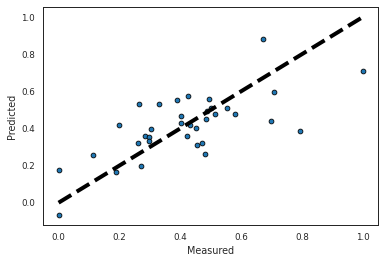

In [1680]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis


<AxesSubplot:xlabel='elasticity', ylabel='feature'>

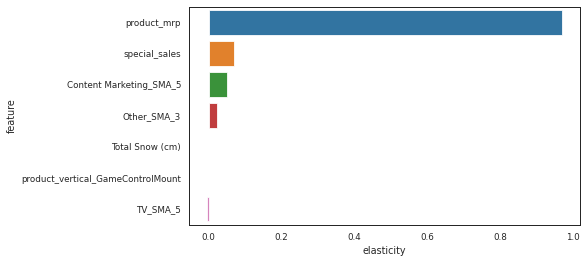

In [1681]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

##Home Audio - Kyock's Model


In [1682]:
# adding lag variable in the camera data set
df = createKyockKPI(home_koy_df)
df.head()

gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  special_sales  product_vertical_Dock  product_vertical_DockingStation  product_vertical_FMRadio  product_vertical_HiFiSystem  product_vertical_HomeAudioSpeaker  product_mrp  product_vertical_SoundMixer  product_vertical_VoiceRecorder  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  \
26 1185712.00      30.67           0.00           0.00 7.00                     1.95                      213.00             793              0                     24                                1                    334.00                            8                             541.00      1958.61                            0                               2         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05         0.05     0.63           0.00           0.00           0.63              0.63         1.85               0.00               0.00               1.85                  1.85               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.33        0.14              0.00   
27 1471962.00      30.37           0.00           0.00 6.71                     1.78                      243.00             936            297                     36                                0                    374.00                           19                             657.00      2016.77                            0                               7         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05         0.09     0.63           0.00           0.00           0.63              1.01         1.85               0.00               0.00               1.85                  2.97               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.53        0.14              0.00   
28 1275392.00      28.88           0.00           0.00 6.82                     1.80                      191.00             909              0                     40                                0                    394.00                           16                             544.00      1896.30                            0                               1         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05         0.11     0.63           0.63           0.00           0.63              1.24         1.85               1.85               0.00               1.85                  3.63               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.33                    0.00                    0.33                       0.65        0.14              0.14   
29  920394.00      28.04           0.00           0.00

In [1683]:
df.shape

(48, 85)

In [1684]:
#Test-train split
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

scaler = MinMaxScaler()

In [1685]:
df.columns


Index(['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'special_sales', 'product_vertical_Dock', 'product_vertical_DockingStation', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_vertical_SoundMixer', 'product_vertical_VoiceRecorder', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5',
    

In [1686]:
num_vars=['gmv', 'Discount%', 'deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'special_sales', 'product_vertical_Dock', 'product_vertical_DockingStation', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_vertical_SoundMixer', 'product_vertical_VoiceRecorder', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', 'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', 'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5',
       'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5', 'Stock Index', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)', 'gmv_lag']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1687]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1688]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1689]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['sla', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_vertical_VoiceRecorder', 'Total Investment_SMA_5', 'TV_SMA_5', 'Digital', 'Digital_SMA_3', 'Sponsorship', 'Sponsorship_SMA_5', 'Content Marketing_SMA_3', 'Content Marketing_SMA_5', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Radio_EMA_8', 'Other_EMA_8', 'Stock Index_SMA_5', 'Max Temp'], dtype='object')

In [1690]:
# neglecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['Discount%', 'deliverybdays', 'deliverycdays', 'product_procurement_sla', 'order_payment_type_Prepaid', 'is_mass_market', 'special_sales', 'product_vertical_Dock', 'product_vertical_DockingStation', 'product_vertical_SoundMixer', 'pay_week', 'holiday_week', 'Total Investment', 'Total Investment_SMA_3', 'Total Investment_EMA_8', 'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship_SMA_3', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Online marketing', 'Online marketing_EMA_8', 'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', 'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', 'Radio_SMA_5', 'Radio_Ad_Stock', 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_Ad_Stock', 'NPS', 'NPS_SMA_3', 'NPS_SMA_5',
       'St

In [1691]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1692]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     647.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.13e-15
Time:                        10:34:45   Log-Likelihood:                 123.91
No. Observations:                  33   AIC:                            -205.8
Df Residuals:                      12   BIC:                            -174.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
7              Total Investment_SMA_5 2770.49
12                  Sponsorship_SMA_5  689.13
0                               const  594.28
17                        Radio_EMA_8  476.58
18                        Other_EMA_8  333.23
16             Online marketing_SMA_5  321.16
8                            TV_SMA_5  291.71
14            Content Marketing_SMA_5  259.26
15             Online marketing_SMA_3  174.06
13            Content Marketing_SMA_3  129.52
10                      Digital_SMA_3   55.05
11                        Sponsorship   28.95
9                             Digital   20.39
4   product_vertical_HomeAudioSpeaker   19.12
5                         product_mrp   18.38
19                  Stock Index_SMA_5   15.75
2            product_vertical_FMRadio   15.50
1                                 sla   14.26
6      product_vertical_VoiceRecorder   13.10
20                           Max Temp   12.16
3         product_vertical_HiFiSystem    8.16

In [1693]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_mrp"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     408.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.18e-15
Time:                        10:34:45   Log-Likelihood:                 114.15
No. Observations:                  33   AIC:                            -188.3
Df Residuals:                      13   BIC:                            -158.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
6              Total Investment_SMA_5 2741.84
11                  Sponsorship_SMA_5  677.80
0                               const  587.96
16                        Radio_EMA_8  465.71
17                        Other_EMA_8  325.74
15             Online marketing_SMA_5  321.08
7                            TV_SMA_5  291.61
13            Content Marketing_SMA_5  250.68
14             Online marketing_SMA_3  163.35
12            Content Marketing_SMA_3  123.80
9                       Digital_SMA_3   54.40
10                        Sponsorship   25.59
8                             Digital   17.70
4   product_vertical_HomeAudioSpeaker   16.63
5      product_vertical_VoiceRecorder   12.98
18                  Stock Index_SMA_5   11.69
19                           Max Temp    9.96
3         product_vertical_HiFiSystem    8.11
2            product_vertical_FMRadio    7.44
1                                 sla    7.17

In [1694]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Total Investment_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     407.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.80e-16
Time:                        10:34:45   Log-Likelihood:                 112.00
No. Observations:                  33   AIC:                            -186.0
Df Residuals:                      14   BIC:                            -157.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 559.62
15                        Radio_EMA_8 246.47
16                        Other_EMA_8 246.34
14             Online marketing_SMA_5 151.78
11            Content Marketing_SMA_3 123.45
13             Online marketing_SMA_3  92.64
6                            TV_SMA_5  66.90
8                       Digital_SMA_3  54.39
12            Content Marketing_SMA_5  46.32
10                  Sponsorship_SMA_5  19.97
9                         Sponsorship  17.16
7                             Digital  16.55
4   product_vertical_HomeAudioSpeaker  16.41
5      product_vertical_VoiceRecorder  11.74
17                  Stock Index_SMA_5  10.14
18                           Max Temp   9.78
2            product_vertical_FMRadio   7.12
3         product_vertical_HiFiSystem   6.83
1                                 sla   4.45

In [1695]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Radio_EMA_8"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     396.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.25e-17
Time:                        10:34:45   Log-Likelihood:                 109.46
No. Observations:                  33   AIC:                            -182.9
Df Residuals:                      15   BIC:                            -156.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 522.84
14             Online marketing_SMA_5  98.10
13             Online marketing_SMA_3  87.73
11            Content Marketing_SMA_3  87.72
8                       Digital_SMA_3  46.12
12            Content Marketing_SMA_5  41.99
6                            TV_SMA_5  19.65
10                  Sponsorship_SMA_5  19.33
9                         Sponsorship  17.02
7                             Digital  15.39
4   product_vertical_HomeAudioSpeaker  13.20
5      product_vertical_VoiceRecorder  11.70
17                           Max Temp   9.71
16                  Stock Index_SMA_5   8.99
15                        Other_EMA_8   8.18
2            product_vertical_FMRadio   7.08
3         product_vertical_HiFiSystem   6.26
1                                 sla   4.40

In [1696]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online marketing_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     369.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.79e-17
Time:                        10:34:46   Log-Likelihood:                 106.24
No. Observations:                  33   AIC:                            -178.5
Df Residuals:                      16   BIC:                            -153.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 446.06
11            Content Marketing_SMA_3  84.77
8                       Digital_SMA_3  44.23
13             Online marketing_SMA_3  27.06
12            Content Marketing_SMA_5  25.41
6                            TV_SMA_5  19.21
10                  Sponsorship_SMA_5  18.73
9                         Sponsorship  14.49
4   product_vertical_HomeAudioSpeaker  13.20
7                             Digital  12.12
5      product_vertical_VoiceRecorder   9.10
16                           Max Temp   8.97
15                  Stock Index_SMA_5   8.38
14                        Other_EMA_8   6.99
2            product_vertical_FMRadio   6.23
3         product_vertical_HiFiSystem   6.12
1                                 sla   2.74

In [1697]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Content Marketing_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     333.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.82e-18
Time:                        10:34:46   Log-Likelihood:                 102.50
No. Observations:                  33   AIC:                            -173.0
Df Residuals:                      17   BIC:                            -149.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 348.08
11            Content Marketing_SMA_5  23.91
10                  Sponsorship_SMA_5  16.87
9                         Sponsorship  14.38
8                       Digital_SMA_3  14.04
6                            TV_SMA_5  12.88
4   product_vertical_HomeAudioSpeaker  12.47
7                             Digital  11.81
12             Online marketing_SMA_3  11.67
5      product_vertical_VoiceRecorder   8.93
15                           Max Temp   8.34
14                  Stock Index_SMA_5   8.23
3         product_vertical_HiFiSystem   6.12
2            product_vertical_FMRadio   5.83
13                        Other_EMA_8   4.50
1                                 sla   2.20

In [1698]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Content Marketing_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     282.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.96e-18
Time:                        10:34:46   Log-Likelihood:                 97.696
No. Observations:                  33   AIC:                            -165.4
Df Residuals:                      18   BIC:                            -142.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 333.77
10                  Sponsorship_SMA_5  13.05
6                            TV_SMA_5  12.76
4   product_vertical_HomeAudioSpeaker  12.34
7                             Digital  11.18
11             Online marketing_SMA_3  10.89
8                       Digital_SMA_3   9.50
14                           Max Temp   8.28
13                  Stock Index_SMA_5   6.99
9                         Sponsorship   6.82
5      product_vertical_VoiceRecorder   6.10
3         product_vertical_HiFiSystem   5.94
12                        Other_EMA_8   4.44
2            product_vertical_FMRadio   3.86
1                                 sla   2.15

In [1699]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Sponsorship_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     285.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.39e-19
Time:                        10:34:46   Log-Likelihood:                 95.790
No. Observations:                  33   AIC:                            -163.6
Df Residuals:                      19   BIC:                            -142.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 244.77
4   product_vertical_HomeAudioSpeaker  11.05
8                       Digital_SMA_3   9.42
10             Online marketing_SMA_3   9.27
7                             Digital   9.12
6                            TV_SMA_5   6.92
13                           Max Temp   5.85
9                         Sponsorship   5.79
12                  Stock Index_SMA_5   5.66
3         product_vertical_HiFiSystem   4.93
5      product_vertical_VoiceRecorder   4.67
11                        Other_EMA_8   3.54
2            product_vertical_FMRadio   3.45
1                                 sla   2.06

In [1700]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Digital_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     258.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.36e-19
Time:                        10:34:46   Log-Likelihood:                 92.009
No. Observations:                  33   AIC:                            -158.0
Df Residuals:                      20   BIC:                            -138.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 161.41
9              Online marketing_SMA_3   9.20
4   product_vertical_HomeAudioSpeaker   6.85
12                           Max Temp   4.55
11                  Stock Index_SMA_5   4.27
6                            TV_SMA_5   3.78
5      product_vertical_VoiceRecorder   3.41
10                        Other_EMA_8   3.41
2            product_vertical_FMRadio   3.40
3         product_vertical_HiFiSystem   3.32
8                         Sponsorship   3.16
7                             Digital   2.38
1                                 sla   1.73

In [1701]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online marketing_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     277.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.76e-20
Time:                        10:34:46   Log-Likelihood:                 90.921
No. Observations:                  33   AIC:                            -157.8
Df Residuals:                      21   BIC:                            -139.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 161.37
4   product_vertical_HomeAudioSpeaker   5.02
11                           Max Temp   4.22
2            product_vertical_FMRadio   3.35
9                         Other_EMA_8   3.31
8                         Sponsorship   3.11
5      product_vertical_VoiceRecorder   3.03
3         product_vertical_HiFiSystem   2.62
6                            TV_SMA_5   2.37
7                             Digital   2.34
10                  Stock Index_SMA_5   2.28
1                                 sla   1.64

In [1702]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Max Temp"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     295.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.71e-21
Time:                        10:34:47   Log-Likelihood:                 89.654
No. Observations:                  33   AIC:                            -157.3
Df Residuals:                      22   BIC:                            -140.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 34.24
4   product_vertical_HomeAudioSpeaker  3.43
8                         Sponsorship  3.08
2            product_vertical_FMRadio  2.98
5      product_vertical_VoiceRecorder  2.68
3         product_vertical_HiFiSystem  2.58
9                         Other_EMA_8  2.52
7                             Digital  2.34
6                            TV_SMA_5  1.99
10                  Stock Index_SMA_5  1.69
1                                 sla  1.19

In [1703]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Sponsorship"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     292.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.51e-21
Time:                        10:34:47   Log-Likelihood:                 87.040
No. Observations:                  33   AIC:                            -154.1
Df Residuals:                      23   BIC:                            -139.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 34.13
4  product_vertical_HomeAudioSpeaker  3.42
2           product_vertical_FMRadio  2.82
5     product_vertical_VoiceRecorder  2.67
3        product_vertical_HiFiSystem  2.51
8                        Other_EMA_8  2.30
6                           TV_SMA_5  1.90
9                  Stock Index_SMA_5  1.53
7                            Digital  1.44
1                                sla  1.19

In [1704]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_HiFiSystem"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     308.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.87e-22
Time:                        10:34:47   Log-Likelihood:                 85.243
No. Observations:                  33   AIC:                            -152.5
Df Residuals:                      24   BIC:                            -139.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 34.05
2           product_vertical_FMRadio  2.82
4     product_vertical_VoiceRecorder  2.62
7                        Other_EMA_8  2.24
3  product_vertical_HomeAudioSpeaker  2.08
5                           TV_SMA_5  1.77
8                  Stock Index_SMA_5  1.51
6                            Digital  1.43
1                                sla  1.17

In [1705]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Other_EMA_8"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     352.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.32e-23
Time:                        10:34:47   Log-Likelihood:                 84.604
No. Observations:                  33   AIC:                            -153.2
Df Residuals:                      25   BIC:                            -141.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 32.38
2           product_vertical_FMRadio  2.42
3  product_vertical_HomeAudioSpeaker  2.02
4     product_vertical_VoiceRecorder  1.90
5                           TV_SMA_5  1.44
7                  Stock Index_SMA_5  1.44
6                            Digital  1.38
1                                sla  1.17

In [1706]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     303.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.59e-23
Time:                        10:34:47   Log-Likelihood:                 79.022
No. Observations:                  33   AIC:                            -144.0
Df Residuals:                      26   BIC:                            -133.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 32.38
2           product_vertical_FMRadio  2.42
3  product_vertical_HomeAudioSpeaker  2.00
4     product_vertical_VoiceRecorder  1.83
5                            Digital  1.34
6                  Stock Index_SMA_5  1.25
1                                sla  1.16

In [1707]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     257.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.02e-22
Time:                        10:34:47   Log-Likelihood:                 72.743
No. Observations:                  33   AIC:                            -133.5
Df Residuals:                      27   BIC:                            -124.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 20.76
2           product_vertical_FMRadio  2.41
3  product_vertical_HomeAudioSpeaker  1.89
4     product_vertical_VoiceRecorder  1.58
5                            Digital  1.32
1                                sla  1.16

In [1708]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     307.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.07e-22
Time:                        10:34:47   Log-Likelihood:                 71.445
No. Observations:                  33   AIC:                            -132.9
Df Residuals:                      28   BIC:                            -125.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 12.83
1           product_vertical_FMRadio  2.35
2  product_vertical_HomeAudioSpeaker  1.88
3     product_vertical_VoiceRecorder  1.39
4                            Digital  1.32

In [1709]:
X_train_rfe.columns

Index(['product_vertical_FMRadio', 'product_vertical_HomeAudioSpeaker', 'product_vertical_VoiceRecorder', 'Digital'], dtype='object')

In [1710]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Sponsorship_SMA_3', 'deliverycdays', 'Affiliates_Ad_Stock', 'Online marketing', 'Mean Temp', 'product_vertical_DockingStation', 'TV_SMA_3', 'Snow on Grnd (cm)', 'Affiliates_SMA_3', 'Total Investment', 'Radio_EMA_8', 'SEM_SMA_5', 'Total Investment_EMA_8', 'Total Rain (mm)', 'Other_Ad_Stock', 'pay_week', 'TV_EMA_8', 'Stock Index_SMA_5', 'Sponsorship_EMA_8', 'Radio_Ad_Stock', 'Min Temp', 'Affiliates_SMA_5', 'order_payment_type_Prepaid', 'SEM_Ad_Stock', 'NPS', 'TV', 'Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', 'Heat Deg Days', 'Online marketing_SMA_3', 'Online marketing_EMA_8', 'TV_Ad_Stock', 'product_vertical_Dock', 'product_vertical_HiFiSystem', 'product_vertical_SoundMixer', 'Total Precip (mm)', 'is_mass_market', 'Sponsorship_SMA_5', 'Discount%', 'gmv', 'Sponsorship_Ad_Stock', 'Total Snow (cm)', 'SEM_EMA_8', 'TV_SMA_5', 'SEM', 'Cool Deg Days', 'gmv_lag', 'deliverybdays', 'Online_marketing_Ad_Stock', 'Digital_EMA_8', 'holiday_week', 'sla', 'Digital_SMA_3', 'Other_SMA_3', 'R

In [1711]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([0.8289157 , 0.86544713, 0.8770952 , 0.97830002, 0.72701257,
       0.90776685, 0.78140676, 0.99134376, 0.44217518, 0.93720874])

In [1712]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1713]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.0011173512085191533
r_square_value : 0.9677436709215539


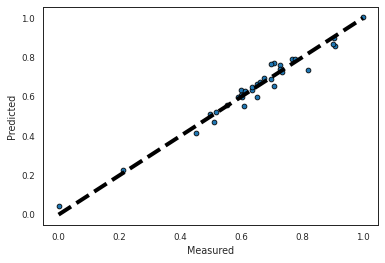

In [1714]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis


<AxesSubplot:xlabel='elasticity', ylabel='feature'>

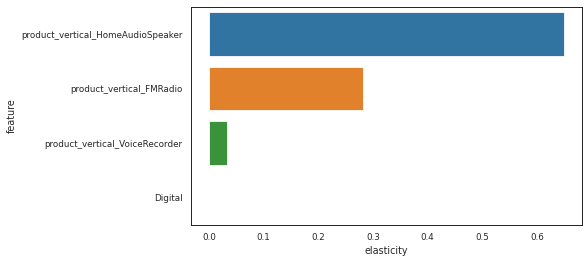

In [1715]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

#Distributed Lag Model (Additive)


*The Distributive Lag Model(Additive) helped us capture the not only the current, but also the carry-over effect of all the variables(depedent and independent).

Yt = α+ µ1Yt-1 + µ2Yt-2 + µ3Yt-3 + .... + β1X1t + β1X1t-1 + β1X1t-2 + .... + β2X2t + β2X2t-1 + β2X2t-2 + ....+ β3X3t + β3X3t-1 + β3X3t-2 + ....+ β4X4t + β4X4t-1 + β4X4t-2 + ....+ β5X5t + β5X5t-1 + β5X5t-2 + ....+ ϵ*


In [1716]:
# Making copy of dataframes from the original ones 
cam_dis_df = Camera_accessory_org_df.copy() 
gam_dis_df = gaming_accessory_org_df.copy() 
home_dis_df = Homeaudio_org_df.copy() 
home_dis_df.head()


gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  special_sales  product_vertical_Dock  product_vertical_DockingStation  product_vertical_FMRadio  product_vertical_HiFiSystem  product_vertical_HomeAudioSpeaker  product_mrp  product_vertical_SoundMixer  product_vertical_VoiceRecorder  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  \
26 1185712.00      30.67           0.00           0.00 7.00                     1.95                      213.00             793              0                     24                                1                    334.00                            8                             541.00      1958.61                            0                               2         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05         0.05     0.63           0.00           0.00           0.63              0.63         1.85               0.00               0.00               1.85                  1.85               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.33        0.14              0.00   
27 1471962.00      30.37           0.00           0.00 6.71                     1.78                      243.00             936            297                     36                                0                    374.00                           19                             657.00      2016.77                            0                               7         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05         0.09     0.63           0.00           0.00           0.63              1.01         1.85               0.00               0.00               1.85                  2.97               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.53        0.14              0.00   
28 1275392.00      28.88           0.00           0.00 6.82                     1.80                      191.00             909              0                     40                                0                    394.00                           16                             544.00      1896.30                            0                               1         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05         0.11     0.63           0.63           0.00           0.63              1.24         1.85               1.85               0.00               1.85                  3.63               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.33                    0.00                    0.33                       0.65        0.14              0.14   
29  920394.00      28.04           0.00           0.00

In [1717]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(home_dis_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(home_dis_df.isnull().sum()/home_dis_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])

pd.concat([total, percentage], axis = 1).head()

Total  Percentage
gmv                      0        0.00
Affiliates_Ad_Stock      0        0.00
Radio_SMA_5              0        0.00
Radio_SMA_3              0        0.00
Radio                    0        0.00

In [1718]:
cam_dis_df.head()

gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  product_mrp  order_payment_type_Prepaid  is_mass_market  product_vertical_CameraAccessory  special_sales  product_vertical_CameraBag  product_vertical_CameraBattery  product_vertical_CameraBatteryCharger  product_vertical_CameraBatteryGrip  product_vertical_CameraEyeCup  product_vertical_CameraFilmRolls  product_vertical_CameraHousing  product_vertical_CameraMicrophone  product_vertical_CameraMount  product_vertical_CameraRemoteControl  product_vertical_CameraTripod  product_vertical_ExtensionTube  product_vertical_Filter  product_vertical_Flash  product_vertical_FlashShoeAdapter  product_vertical_Lens  product_vertical_ReflectorUmbrella  product_vertical_Softbox  product_vertical_Strap  product_vertical_Telescope  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  \
26 1088715.00      45.59           0.00           0.00 6.36                     2.08      1143.14                      566.00            1734                                39              0                      260.00                          349.00                                 167.00                                   7                              0                                 0                               0                                  0                             3                                 70.00                         349.00                               0                   164.00                    8.00                                  0                 263.00                                   0                         0                      13                           4         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05   
27 1203752.00      47.02           0.00           0.00 6.06                     2.10      1197.19                      649.00            2005                                31            578                      284.00                          428.00                                 179.00                                   4                              0                                 0                               0                                  0                            10                                 85.00                         408.00                               0                   142.00                   11.00                                  0                 293.00                                   0                         0                      22                          15         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05   
28 1183338.00      44.83           0.00           0.00 6.17                     2.12      1162.70                      606.00            1991                                43              0                      223.00                          455.00                                 218.00                                   4                              0                                 0                               0                                  0                             7                                 68.00                         370.00                               0                   148.00                    7.00                                  0                 325.00                                   0                         0                      21                          23         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05   
29  813136.00      44.89           0.00           0.00

###### Create a new variable which is the Lag of 1 week




In [1719]:
GMV_Lag = ['gmv']

In [1720]:
def lag_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_lag'+np.str(n),value=df[i].shift(n))
    return df

###### Create a new lag(Lag of 3 weeks) variables for the dependent variable (GMV) as well as independent variables

In [1721]:
cam_dis_df_columns = cam_dis_df.columns
gam_dis_df_columns = gam_dis_df.columns
home_dis_df_columns = home_dis_df.columns

In [1722]:
cam_dis_df = lag_variables(cam_dis_df,cam_dis_df_columns,3)
gam_dis_df = lag_variables(gam_dis_df,gam_dis_df_columns,3)
home_dis_df = lag_variables(home_dis_df,home_dis_df_columns,3)
home_dis_df.head()

gmv   gmv_lag3  Discount%  Discount%_lag3  deliverybdays  deliverybdays_lag3  deliverycdays  deliverycdays_lag3  sla  sla_lag3  product_procurement_sla  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag3  special_sales  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag3  product_vertical_HiFiSystem  product_vertical_HiFiSystem_lag3  product_vertical_HomeAudioSpeaker  product_vertical_HomeAudioSpeaker_lag3  product_mrp  product_mrp_lag3  product_vertical_SoundMixer  product_vertical_SoundMixer_lag3  product_vertical_VoiceRecorder  product_vertical_VoiceRecorder_lag3  pay_week  pay_week_lag3  holiday_week  holiday_week_lag3  Total Investment  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag3  Total Investment_SMA_5  \
26 1185712.00        NaN      30.67             NaN           0.00                 NaN           0.00                 NaN 7.00       NaN                     1.95                           NaN                      213.00                              NaN             793                  NaN              0                 NaN                     24                         NaN                                1                                   NaN                    334.00                            NaN                            8                               NaN                             541.00                                     NaN      1958.61               NaN                            0                               NaN                               2                                  NaN         0            NaN             0                NaN              4.26                    NaN                    0.00                          NaN                    0.00   
27 1471962.00        NaN      30.37             NaN           0.00                 NaN           0.00                 NaN 6.71       NaN                     1.78                           NaN                      243.00                              NaN             936                  NaN            297                 NaN                     36                         NaN                                0                                   NaN                    374.00                            NaN                           19                               NaN                             657.00                                     NaN      2016.77               NaN                            0                               NaN                               7                                  NaN         1            NaN             0                NaN              4.26                    NaN                    0.00                          NaN                    0.00   
28 1275392.00        NaN      28.88             NaN           0.00                 NaN           0.00                 NaN 6.82       NaN                     1.80                           NaN                      191.00                              NaN             909                  NaN              0                 NaN                     40                         NaN                                0                                   NaN                    394.00                            NaN                           16                               NaN                             544.00                                     NaN      1896.30               NaN                            0                               NaN                               1                                  NaN         0            NaN             0                NaN              4.26                    NaN                    4.26                          NaN                    0.00   
29  920394.00 1185712.00      28.04           30.67           0.00        

###### Create a new lag(Lag of 2 weeks) variables for the dependent variable (GMV) as well as independent variables

In [1723]:
cam_dis_df = lag_variables(cam_dis_df,cam_dis_df_columns,2)
gam_dis_df = lag_variables(gam_dis_df,gam_dis_df_columns,2)
home_dis_df = lag_variables(home_dis_df,home_dis_df_columns,2)
home_dis_df.head()

gmv   gmv_lag2   gmv_lag3  Discount%  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag2  deliverycdays_lag3  sla  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag2  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag2  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag2  is_mass_market_lag3  special_sales  special_sales_lag2  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag2  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag2  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag2  product_vertical_FMRadio_lag3  product_vertical_HiFiSystem  product_vertical_HiFiSystem_lag2  product_vertical_HiFiSystem_lag3  product_vertical_HomeAudioSpeaker  product_vertical_HomeAudioSpeaker_lag2  product_vertical_HomeAudioSpeaker_lag3  \
26 1185712.00        NaN        NaN      30.67             NaN             NaN           0.00                 NaN                 NaN           0.00                 NaN                 NaN 7.00       NaN       NaN                     1.95                           NaN                           NaN                      213.00                              NaN                              NaN             793                  NaN                  NaN              0                 NaN                 NaN                     24                         NaN                         NaN                                1                                   NaN                                   NaN                    334.00                            NaN                            NaN                            8                               NaN                               NaN                             541.00                                     NaN                                     NaN   
27 1471962.00        NaN        NaN      30.37             NaN             NaN           0.00                 NaN                 NaN           0.00                 NaN                 NaN 6.71       NaN       NaN                     1.78                           NaN                           NaN                      243.00                              NaN                              NaN             936                  NaN                  NaN            297                 NaN                 NaN                     36                         NaN                         NaN                                0                                   NaN                                   NaN                    374.00                            NaN                            NaN                           19                               NaN                               NaN                             657.00                                     NaN                                     NaN   
28 1275392.00 1185712.00        NaN      28.88           30.67             NaN           0.00                0.00                 NaN           0.00                0.00                 NaN 6.82      7.00       NaN                     1.80                          1.95                           NaN                      191.00                           213.00                              NaN             909               793.00                  NaN              0                0.00                 NaN                     40                       24.00                         NaN                                0                                  1.00                                   NaN                    394.00                         334.00                            NaN                           16                              8.00                               NaN                             544.00                                  541.00                                     NaN   
29  920394.00 1471962.

##### Create new lag(Lag of 1 week) variables 

In [1724]:
cam_dis_df = lag_variables(cam_dis_df,cam_dis_df_columns,1)
gam_dis_df = lag_variables(gam_dis_df,gam_dis_df_columns,1)
home_dis_df = lag_variables(home_dis_df,home_dis_df_columns,1)
home_dis_df.head()

gmv   gmv_lag1   gmv_lag2   gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3  sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag1  order_payment_type_Prepaid_lag2  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  special_sales  special_sales_lag1  special_sales_lag2  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag1  product_vertical_Dock_lag2  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag1  product_vertical_DockingStation_lag2  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag1  \
26 1185712.00        NaN        NaN        NaN      30.67             NaN             NaN             NaN           0.00                 NaN                 NaN                 NaN           0.00                 NaN                 NaN                 NaN 7.00       NaN       NaN       NaN                     1.95                           NaN                           NaN                           NaN                      213.00                              NaN                              NaN                              NaN             793                  NaN                  NaN                  NaN              0                 NaN                 NaN                 NaN                     24                         NaN                         NaN                         NaN                                1                                   NaN                                   NaN                                   NaN                    334.00                            NaN   
27 1471962.00 1185712.00        NaN        NaN      30.37           30.67             NaN             NaN           0.00                0.00                 NaN                 NaN           0.00                0.00                 NaN                 NaN 6.71      7.00       NaN       NaN                     1.78                          1.95                           NaN                           NaN                      243.00                           213.00                              NaN                              NaN             936               793.00                  NaN                  NaN            297                0.00                 NaN                 NaN                     36                       24.00                         NaN                         NaN                                0                                  1.00                                   NaN                                   NaN                    374.00                         334.00   
28 1275392.00 1471962.00 1185712.00        NaN      28.88           30.37           30.67             NaN           0.00                0.00                0.00                 NaN           0.00                0.00                0.00                 NaN 6.82      6.71      7.00       NaN                     1.80                          1.78                          1.95                           NaN                      191.00                           243.00                           213.00                              NaN             909               936.00               793.00                  NaN              0              297.00                0.00                 NaN                     40                       36.00                       24.00                         NaN                                0                                  0.00                                  1.00                                   NaN                    394.00                         374.00   
29  92

Impute null values with 0

In [1725]:
# Imputing all null values with 0
cam_dis_df.fillna(value=0, inplace=True)
gam_dis_df.fillna(value=0, inplace=True)
home_dis_df.fillna(value=0, inplace=True)
home_dis_df.head(10)

gmv   gmv_lag1   gmv_lag2   gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3  sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag1  order_payment_type_Prepaid_lag2  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  special_sales  special_sales_lag1  special_sales_lag2  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag1  product_vertical_Dock_lag2  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag1  product_vertical_DockingStation_lag2  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag1  \
26 1185712.00       0.00       0.00       0.00      30.67            0.00            0.00            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 7.00      0.00      0.00      0.00                     1.95                          0.00                          0.00                          0.00                      213.00                             0.00                             0.00                             0.00             793                 0.00                 0.00                 0.00              0                0.00                0.00                0.00                     24                        0.00                        0.00                        0.00                                1                                  0.00                                  0.00                                  0.00                    334.00                           0.00   
27 1471962.00 1185712.00       0.00       0.00      30.37           30.67            0.00            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 6.71      7.00      0.00      0.00                     1.78                          1.95                          0.00                          0.00                      243.00                           213.00                             0.00                             0.00             936               793.00                 0.00                 0.00            297                0.00                0.00                0.00                     36                       24.00                        0.00                        0.00                                0                                  1.00                                  0.00                                  0.00                    374.00                         334.00   
28 1275392.00 1471962.00 1185712.00       0.00      28.88           30.37           30.67            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 6.82      6.71      7.00      0.00                     1.80                          1.78                          1.95                          0.00                      191.00                           243.00                           213.00                             0.00             909               936.00               793.00                 0.00              0              297.00                0.00                0.00                     40                       36.00                       24.00                        0.00                                0                                  0.00                                  1.00                                  0.00                    394.00                         374.00   
29  92

## Distributed Lag Model(Additive) for Camera Accessory

##### Splitting the Dataframe into Training and Testing Set

In [1726]:

# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(cam_dis_df, train_size = 0.7, test_size = 0.3, random_state = 100)
                                                                           
                                                                           

Rescaling the Features

In [1727]:
scaler = MinMaxScaler()


In [1728]:
num_vars=cam_dis_df.columns


In [1729]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1730]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1731]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1732]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Discount%', 'product_mrp', 'is_mass_market', 'special_sales_lag1', 'special_sales_lag3', 'product_vertical_CameraBattery', 'product_vertical_CameraBatteryGrip', 'product_vertical_CameraTripod', 'product_vertical_ExtensionTube', 'product_vertical_ExtensionTube_lag1', 'product_vertical_ExtensionTube_lag2', 'product_vertical_Flash', 'product_vertical_Flash_lag2', 'product_vertical_FlashShoeAdapter', 'product_vertical_FlashShoeAdapter_lag1', 'product_vertical_Strap', 'NPS_SMA_3_lag3', 'Max Temp_lag1', 'Mean Temp_lag3', 'Heat Deg Days_lag3'], dtype='object')

In [1733]:
# neglecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'Discount%_lag1', 'Discount%_lag2', 'Discount%_lag3', 'deliverybdays', 'deliverybdays_lag1', 'deliverybdays_lag2', 'deliverybdays_lag3',
       ...
       'Total Snow (cm)_lag2', 'Total Snow (cm)_lag3', 'Total Precip (mm)', 'Total Precip (mm)_lag1', 'Total Precip (mm)_lag2', 'Total Precip (mm)_lag3', 'Snow on Grnd (cm)', 'Snow on Grnd (cm)_lag1', 'Snow on Grnd (cm)_lag2', 'Snow on Grnd (cm)_lag3'], dtype='object', length=371)

In [1734]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1735]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     151.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.83e-11
Time:                        10:34:55   Log-Likelihood:                 104.48
No. Observations:                  33   AIC:                            -167.0
Df Residuals:                      12   BIC:                            -135.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features    VIF
0                                    const 932.22
3                           is_mass_market 241.91
20                      Heat Deg Days_lag3 126.73
12                  product_vertical_Flash 124.97
1                                Discount%  50.36
6           product_vertical_CameraBattery  35.54
8            product_vertical_CameraTripod  32.78
18                           Max Temp_lag1  29.99
15  product_vertical_FlashShoeAdapter_lag1  29.14
2                              product_mrp  28.12
16                  product_vertical_Strap  19.83
11     product_vertical_ExtensionTube_lag2  17.72
19                          Mean Temp_lag3  17.09
7       product_vertical_CameraBatteryGrip  16.12
9           product_vertical_ExtensionTube  15.97
10     product_vertical_ExtensionTube_lag1  15.32
17                          NPS_SMA_3_lag3  13.17
14       product_vertical_FlashShoeAdapter   3.83
13             product_vertical_Flash_lag2   3.65
4                       special_sales_lag1   2.96
5                       special_sales_lag3   1.83

In [1736]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["is_mass_market"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     36.08
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.89e-08
Time:                        10:34:55   Log-Likelihood:                 78.883
No. Observations:                  33   AIC:                            -117.8
Df Residuals:                      13   BIC:                            -87.84
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features    VIF
0                                    const 469.82
19                      Heat Deg Days_lag3  74.66
1                                Discount%  34.34
11                  product_vertical_Flash  25.32
2                              product_mrp  21.52
15                  product_vertical_Strap  19.80
14  product_vertical_FlashShoeAdapter_lag1  15.85
17                           Max Temp_lag1  15.39
8           product_vertical_ExtensionTube  15.28
9      product_vertical_ExtensionTube_lag1  14.18
16                          NPS_SMA_3_lag3  13.10
18                          Mean Temp_lag3  12.92
6       product_vertical_CameraBatteryGrip  12.49
10     product_vertical_ExtensionTube_lag2   9.82
5           product_vertical_CameraBattery   7.87
7            product_vertical_CameraTripod   7.54
12             product_vertical_Flash_lag2   3.34
13       product_vertical_FlashShoeAdapter   2.83
3                       special_sales_lag1   2.53
4                       special_sales_lag3   1.54

In [1737]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Heat Deg Days_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     33.47
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.71e-08
Time:                        10:34:55   Log-Likelihood:                 75.597
No. Observations:                  33   AIC:                            -113.2
Df Residuals:                      14   BIC:                            -84.76
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features    VIF
0                                    const 132.05
1                                Discount%  31.87
11                  product_vertical_Flash  21.95
2                              product_mrp  20.33
15                  product_vertical_Strap  17.77
16                          NPS_SMA_3_lag3   9.58
18                          Mean Temp_lag3   8.46
8           product_vertical_ExtensionTube   7.89
14  product_vertical_FlashShoeAdapter_lag1   7.81
5           product_vertical_CameraBattery   7.63
10     product_vertical_ExtensionTube_lag2   7.03
17                           Max Temp_lag1   6.80
6       product_vertical_CameraBatteryGrip   6.20
9      product_vertical_ExtensionTube_lag1   6.11
7            product_vertical_CameraTripod   4.14
12             product_vertical_Flash_lag2   3.08
13       product_vertical_FlashShoeAdapter   2.69
3                       special_sales_lag1   1.66
4                       special_sales_lag3   1.54

In [1738]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Discount%"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     35.55
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.30e-09
Time:                        10:34:55   Log-Likelihood:                 74.533
No. Observations:                  33   AIC:                            -113.1
Df Residuals:                      15   BIC:                            -86.13
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features    VIF
0                                    const 129.90
14                  product_vertical_Strap  14.80
10                  product_vertical_Flash  11.60
15                          NPS_SMA_3_lag3   8.66
17                          Mean Temp_lag3   8.31
7           product_vertical_ExtensionTube   7.35
1                              product_mrp   6.56
9      product_vertical_ExtensionTube_lag2   6.30
4           product_vertical_CameraBattery   5.96
8      product_vertical_ExtensionTube_lag1   5.92
16                           Max Temp_lag1   5.32
5       product_vertical_CameraBatteryGrip   4.96
13  product_vertical_FlashShoeAdapter_lag1   4.50
6            product_vertical_CameraTripod   4.08
11             product_vertical_Flash_lag2   2.92
12       product_vertical_FlashShoeAdapter   2.26
2                       special_sales_lag1   1.66
3                       special_sales_lag3   1.54

In [1739]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraBattery"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     22.00
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.24e-08
Time:                        10:34:55   Log-Likelihood:                 64.881
No. Observations:                  33   AIC:                            -95.76
Df Residuals:                      16   BIC:                            -70.32
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features    VIF
0                                    const 129.37
9                   product_vertical_Flash  10.84
13                  product_vertical_Strap  10.13
16                          Mean Temp_lag3   8.05
6           product_vertical_ExtensionTube   7.19
14                          NPS_SMA_3_lag3   7.04
1                              product_mrp   6.19
7      product_vertical_ExtensionTube_lag1   5.41
15                           Max Temp_lag1   5.19
8      product_vertical_ExtensionTube_lag2   5.11
12  product_vertical_FlashShoeAdapter_lag1   4.11
5            product_vertical_CameraTripod   3.89
4       product_vertical_CameraBatteryGrip   3.46
10             product_vertical_Flash_lag2   2.62
11       product_vertical_FlashShoeAdapter   2.24
2                       special_sales_lag1   1.58
3                       special_sales_lag3   1.50

In [1740]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Mean Temp_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     22.99
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.28e-08
Time:                        10:34:55   Log-Likelihood:                 63.599
No. Observations:                  33   AIC:                            -95.20
Df Residuals:                      17   BIC:                            -71.25
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features   VIF
0                                    const 87.81
13                  product_vertical_Strap  9.97
9                   product_vertical_Flash  8.24
1                              product_mrp  5.18
7      product_vertical_ExtensionTube_lag1  5.01
6           product_vertical_ExtensionTube  4.93
8      product_vertical_ExtensionTube_lag2  4.89
14                          NPS_SMA_3_lag3  4.83
15                           Max Temp_lag1  4.32
5            product_vertical_CameraTripod  3.77
12  product_vertical_FlashShoeAdapter_lag1  3.61
4       product_vertical_CameraBatteryGrip  3.18
10             product_vertical_Flash_lag2  2.62
11       product_vertical_FlashShoeAdapter  2.18
3                       special_sales_lag3  1.49
2                       special_sales_lag1  1.40

In [1741]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_mrp"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     26.05
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.35e-09
Time:                        10:34:55   Log-Likelihood:                 63.585
No. Observations:                  33   AIC:                            -97.17
Df Residuals:                      18   BIC:                            -74.72
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features   VIF
0                                    const 72.35
12                  product_vertical_Strap  6.63
8                   product_vertical_Flash  5.52
7      product_vertical_ExtensionTube_lag2  4.83
5           product_vertical_ExtensionTube  4.63
6      product_vertical_ExtensionTube_lag1  4.34
14                           Max Temp_lag1  4.16
13                          NPS_SMA_3_lag3  3.51
4            product_vertical_CameraTripod  3.32
11  product_vertical_FlashShoeAdapter_lag1  3.05
3       product_vertical_CameraBatteryGrip  2.84
9              product_vertical_Flash_lag2  2.55
10       product_vertical_FlashShoeAdapter  2.14
2                       special_sales_lag3  1.42
1                       special_sales_lag1  1.37

In [1742]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_ExtensionTube"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     29.55
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.86e-10
Time:                        10:34:55   Log-Likelihood:                 63.550
No. Observations:                  33   AIC:                            -99.10
Df Residuals:                      19   BIC:                            -78.15
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features   VIF
0                                    const 44.67
11                  product_vertical_Strap  5.95
7                   product_vertical_Flash  4.73
5      product_vertical_ExtensionTube_lag1  4.33
6      product_vertical_ExtensionTube_lag2  3.86
12                          NPS_SMA_3_lag3  3.48
4            product_vertical_CameraTripod  3.22
10  product_vertical_FlashShoeAdapter_lag1  2.65
3       product_vertical_CameraBatteryGrip  2.61
8              product_vertical_Flash_lag2  2.49
9        product_vertical_FlashShoeAdapter  2.09
13                           Max Temp_lag1  1.90
2                       special_sales_lag3  1.36
1                       special_sales_lag1  1.23

In [1743]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_FlashShoeAdapter"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     33.49
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.38e-10
Time:                        10:34:55   Log-Likelihood:                 63.454
No. Observations:                  33   AIC:                            -100.9
Df Residuals:                      20   BIC:                            -81.45
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features   VIF
0                                    const 41.83
10                  product_vertical_Strap  5.92
7                   product_vertical_Flash  4.47
11                          NPS_SMA_3_lag3  3.06
4            product_vertical_CameraTripod  2.81
5      product_vertical_ExtensionTube_lag1  2.71
6      product_vertical_ExtensionTube_lag2  2.66
9   product_vertical_FlashShoeAdapter_lag1  2.58
8              product_vertical_Flash_lag2  2.42
3       product_vertical_CameraBatteryGrip  2.33
12                           Max Temp_lag1  1.84
2                       special_sales_lag3  1.35
1                       special_sales_lag1  1.23

In [1744]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraTripod"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     38.34
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.16e-11
Time:                        10:34:55   Log-Likelihood:                 63.446
No. Observations:                  33   AIC:                            -102.9
Df Residuals:                      21   BIC:                            -84.93
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Features   VIF
0                                    const 41.82
9                   product_vertical_Strap  5.83
6                   product_vertical_Flash  4.27
8   product_vertical_FlashShoeAdapter_lag1  2.58
5      product_vertical_ExtensionTube_lag2  2.45
7              product_vertical_Flash_lag2  2.18
4      product_vertical_ExtensionTube_lag1  1.96
10                          NPS_SMA_3_lag3  1.81
11                           Max Temp_lag1  1.77
3       product_vertical_CameraBatteryGrip  1.64
2                       special_sales_lag3  1.29
1                       special_sales_lag1  1.16

In [1745]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_FlashShoeAdapter_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     43.94
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.31e-12
Time:                        10:34:55   Log-Likelihood:                 63.358
No. Observations:                  33   AIC:                            -104.7
Df Residuals:                      22   BIC:                            -88.25
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

Features   VIF
0                                 const 34.69
6                product_vertical_Flash  3.88
8                product_vertical_Strap  3.15
5   product_vertical_ExtensionTube_lag2  2.12
7           product_vertical_Flash_lag2  2.05
4   product_vertical_ExtensionTube_lag1  1.88
9                        NPS_SMA_3_lag3  1.77
10                        Max Temp_lag1  1.73
3    product_vertical_CameraBatteryGrip  1.61
2                    special_sales_lag3  1.26
1                    special_sales_lag1  1.16

In [1746]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["special_sales_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     49.86
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.72e-13
Time:                        10:34:56   Log-Likelihood:                 62.989
No. Observations:                  33   AIC:                            -106.0
Df Residuals:                      23   BIC:                            -91.01
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

Features   VIF
0                                const 32.58
5               product_vertical_Flash  3.88
7               product_vertical_Strap  3.11
4  product_vertical_ExtensionTube_lag2  2.11
6          product_vertical_Flash_lag2  2.05
3  product_vertical_ExtensionTube_lag1  1.79
8                       NPS_SMA_3_lag3  1.76
9                        Max Temp_lag1  1.67
2   product_vertical_CameraBatteryGrip  1.60
1                   special_sales_lag3  1.22

In [1747]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_Flash_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     50.89
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.44e-13
Time:                        10:34:56   Log-Likelihood:                 60.801
No. Observations:                  33   AIC:                            -103.6
Df Residuals:                      24   BIC:                            -90.13
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

Features   VIF
0                                const 32.27
5               product_vertical_Flash  3.37
6               product_vertical_Strap  2.99
4  product_vertical_ExtensionTube_lag2  1.97
7                       NPS_SMA_3_lag3  1.76
8                        Max Temp_lag1  1.63
3  product_vertical_ExtensionTube_lag1  1.58
2   product_vertical_CameraBatteryGrip  1.57
1                   special_sales_lag3  1.21

In [1748]:
X_train_rfe.columns

Index(['special_sales_lag3', 'product_vertical_CameraBatteryGrip', 'product_vertical_ExtensionTube_lag1', 'product_vertical_ExtensionTube_lag2', 'product_vertical_Flash', 'product_vertical_Strap', 'NPS_SMA_3_lag3', 'Max Temp_lag1'], dtype='object')

In [1749]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Radio_EMA_8_lag3', 'TV_SMA_5_lag2', 'Online marketing', 'Digital_EMA_8_lag3', 'SEM_Ad_Stock_lag2', 'SEM_SMA_5_lag3', 'product_vertical_CameraRemoteControl_lag3', 'TV_SMA_3_lag2', 'TV_SMA_3_lag1', 'product_vertical_Flash_lag3', 'Online marketing_lag1', 'product_vertical_CameraMount_lag2', 'Radio_EMA_8', 'Stock Index_lag1', 'product_vertical_CameraBattery_lag1', 'Cool Deg Days_lag1', 'gmv_lag2', 'Stock Index_SMA_3_lag1', 'Digital_EMA_8_lag1', 'Sponsorship_SMA_3_lag1', 'SEM_SMA_5', 'product_vertical_CameraAccessory_lag1', 'pay_week', 'Other_SMA_5_lag3', 'Stock Index_SMA_5', 'product_vertical_Filter_lag2', 'Sponsorship_EMA_8', 'product_vertical_CameraFilmRolls', 'Affiliates_SMA_5', 'product_vertical_Flash_lag2', 'Online_marketing_Ad_Stock_lag1', 'TV_lag3', 'TV', 'TV_Ad_Stock_lag2', 'SEM_Ad_Stock_lag3', 'Content Marketing_EMA_8_lag1', 'deliverybdays_lag2', 'Sponsorship_lag2', 'Heat Deg Days', 'Mean Temp_lag1', 'Total Precip (mm)', 'product_vertical_Telescope_lag3', 'Total Precip (mm)_lag1

In [1750]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ 0.30532422,  0.9185167 ,  0.88887001,  0.97392963, -3.14234605,
       -0.07078517,  0.13147693,  0.93984058,  0.84765183,  0.6521836 ])

In [1751]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1752]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.0028655131786070676
r_square_value : 0.8914451329919786


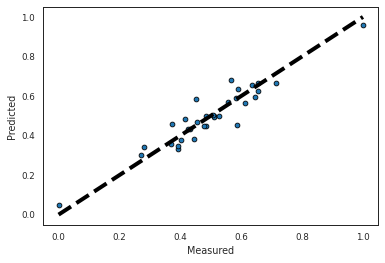

In [1753]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity

In [1754]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)

<AxesSubplot:xlabel='elasticity', ylabel='feature'>

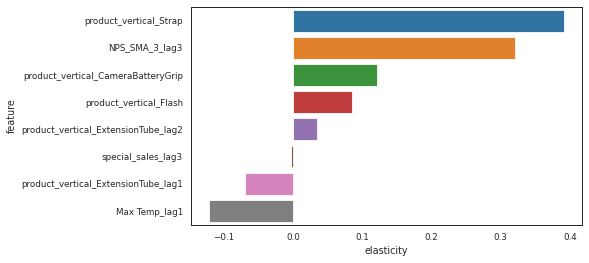

In [1755]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

##Distributed Lag Model(Additive) for Gaming Accessory


Splitting the Dataframe into Training and Testing Set


In [1756]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(gam_dis_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1757]:
scaler = MinMaxScaler()

In [1758]:
num_vars=gam_dis_df.columns

In [1759]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1760]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1761]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1762]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['deliverycdays_lag1', 'deliverycdays_lag3', 'order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GamePad', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingHeadset', 'product_vertical_GamingHeadset_lag3', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingSpeaker', 'product_vertical_JoystickGamingWheel', 'product_vertical_JoystickGamingWheel_lag1', 'product_vertical_MotionController', 'Digital_lag2', 'Online marketing_EMA_8', 'Affiliates_SMA_3', 'Other_lag3', 'Cool Deg Days'], dtype='object')

In [1763]:
# neglecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'Discount%', 'Discount%_lag1', 'Discount%_lag2', 'Discount%_lag3', 'deliverybdays', 'deliverybdays_lag1', 'deliverybdays_lag2',
       ...
       'Total Snow (cm)_lag2', 'Total Snow (cm)_lag3', 'Total Precip (mm)', 'Total Precip (mm)_lag1', 'Total Precip (mm)_lag2', 'Total Precip (mm)_lag3', 'Snow on Grnd (cm)', 'Snow on Grnd (cm)_lag1', 'Snow on Grnd (cm)_lag2', 'Snow on Grnd (cm)_lag3'], dtype='object', length=343)

In [1764]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1765]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     635.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.20e-17
Time:                        10:35:00   Log-Likelihood:                 125.01
No. Observations:                  35   AIC:                            -208.0
Df Residuals:                      14   BIC:                            -175.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features     VIF
4                              is_mass_market 1753.72
8              product_vertical_GamingHeadset  402.86
11               product_vertical_GamingMouse  220.46
17                     Online marketing_EMA_8  190.01
18                           Affiliates_SMA_3  124.60
13       product_vertical_JoystickGamingWheel  102.05
5                    product_vertical_GamePad   83.59
1                          deliverycdays_lag1   67.91
0                                       const   48.24
14  product_vertical_JoystickGamingWheel_lag1   42.42
2                          deliverycdays_lag3   34.88
3                  order_payment_type_Prepaid   20.43
12             product_vertical_GamingSpeaker   18.33
10          product_vertical_GamingMemoryCard   16.85
20                              Cool Deg Days   12.48
6         product_vertical_GamingAccessoryKit   12.32
7              product_vertical_GamingAdapter   12.25
15          product_vertical_MotionController    6.10
9         product_vertical_GamingHeadset_lag3    5.67
19                                 Other_lag3    3.25
16                               Digital_lag2    3.20

In [1766]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingHeadset"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     649.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.68e-18
Time:                        10:35:00   Log-Likelihood:                 123.27
No. Observations:                  35   AIC:                            -206.5
Df Residuals:                      15   BIC:                            -175.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
16                     Online marketing_EMA_8 187.76
17                           Affiliates_SMA_3 123.19
12       product_vertical_JoystickGamingWheel  98.35
4                              is_mass_market  83.45
1                          deliverycdays_lag1  56.25
0                                       const  44.63
2                          deliverycdays_lag3  31.05
13  product_vertical_JoystickGamingWheel_lag1  22.88
10               product_vertical_GamingMouse  18.53
11             product_vertical_GamingSpeaker  17.65
3                  order_payment_type_Prepaid  13.40
7              product_vertical_GamingAdapter  11.44
5                    product_vertical_GamePad   9.94
19                              Cool Deg Days   9.85
6         product_vertical_GamingAccessoryKit   7.71
14          product_vertical_MotionController   5.37
8         product_vertical_GamingHeadset_lag3   4.37
9           product_vertical_GamingMemoryCard   4.29
18                                 Other_lag3   2.90
15                               Digital_lag2   2.41

In [1767]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online marketing_EMA_8"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     270.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.66e-16
Time:                        10:35:00   Log-Likelihood:                 105.91
No. Observations:                  35   AIC:                            -173.8
Df Residuals:                      16   BIC:                            -144.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
4                              is_mass_market 58.37
12       product_vertical_JoystickGamingWheel 46.21
0                                       const 44.39
1                          deliverycdays_lag1 26.98
2                          deliverycdays_lag3 24.54
13  product_vertical_JoystickGamingWheel_lag1 21.59
10               product_vertical_GamingMouse 16.70
11             product_vertical_GamingSpeaker 13.09
16                           Affiliates_SMA_3 12.18
7              product_vertical_GamingAdapter  9.82
18                              Cool Deg Days  9.81
5                    product_vertical_GamePad  8.45
3                  order_payment_type_Prepaid  7.50
6         product_vertical_GamingAccessoryKit  7.38
14          product_vertical_MotionController  4.92
9           product_vertical_GamingMemoryCard  4.26
8         product_vertical_GamingHeadset_lag3  3.18
17                                 Other_lag3  2.85
15                               Digital_lag2  2.32

In [1768]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["deliverycdays_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     304.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           9.26e-18
Time:                        10:35:00   Log-Likelihood:                 105.91
No. Observations:                  35   AIC:                            -175.8
Df Residuals:                      17   BIC:                            -147.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
3                              is_mass_market 46.19
0                                       const 41.98
11       product_vertical_JoystickGamingWheel 34.90
1                          deliverycdays_lag1 23.95
12  product_vertical_JoystickGamingWheel_lag1 21.35
15                           Affiliates_SMA_3 12.15
9                product_vertical_GamingMouse 11.87
10             product_vertical_GamingSpeaker 10.60
17                              Cool Deg Days  9.37
6              product_vertical_GamingAdapter  8.88
4                    product_vertical_GamePad  7.76
2                  order_payment_type_Prepaid  7.47
5         product_vertical_GamingAccessoryKit  7.05
13          product_vertical_MotionController  4.63
8           product_vertical_GamingMemoryCard  4.01
7         product_vertical_GamingHeadset_lag3  3.17
16                                 Other_lag3  2.83
14                               Digital_lag2  2.29

In [1769]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingMouse"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     342.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.91e-19
Time:                        10:35:00   Log-Likelihood:                 105.89
No. Observations:                  35   AIC:                            -177.8
Df Residuals:                      18   BIC:                            -151.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
0                                       const 37.90
10       product_vertical_JoystickGamingWheel 34.76
1                          deliverycdays_lag1 20.84
11  product_vertical_JoystickGamingWheel_lag1 19.05
14                           Affiliates_SMA_3 11.26
3                              is_mass_market 10.04
6              product_vertical_GamingAdapter  8.32
9              product_vertical_GamingSpeaker  7.81
16                              Cool Deg Days  7.59
5         product_vertical_GamingAccessoryKit  6.93
2                  order_payment_type_Prepaid  6.84
4                    product_vertical_GamePad  6.19
12          product_vertical_MotionController  3.24
15                                 Other_lag3  2.82
7         product_vertical_GamingHeadset_lag3  2.67
8           product_vertical_GamingMemoryCard  2.65
13                               Digital_lag2  2.29

In [1770]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingAdapter"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     378.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.89e-20
Time:                        10:35:00   Log-Likelihood:                 105.56
No. Observations:                  35   AIC:                            -179.1
Df Residuals:                      19   BIC:                            -154.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
0                                       const 37.66
9        product_vertical_JoystickGamingWheel 34.49
1                          deliverycdays_lag1 20.56
10  product_vertical_JoystickGamingWheel_lag1 18.82
13                           Affiliates_SMA_3 10.68
3                              is_mass_market 10.00
8              product_vertical_GamingSpeaker  7.51
15                              Cool Deg Days  7.35
5         product_vertical_GamingAccessoryKit  6.27
2                  order_payment_type_Prepaid  6.17
4                    product_vertical_GamePad  5.90
11          product_vertical_MotionController  3.04
14                                 Other_lag3  2.82
7           product_vertical_GamingMemoryCard  2.51
6         product_vertical_GamingHeadset_lag3  2.47
12                               Digital_lag2  2.27

In [1771]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamePad"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     413.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.83e-21
Time:                        10:35:00   Log-Likelihood:                 105.04
No. Observations:                  35   AIC:                            -180.1
Df Residuals:                      20   BIC:                            -156.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
0                                       const 37.22
8        product_vertical_JoystickGamingWheel 30.66
1                          deliverycdays_lag1 20.56
9   product_vertical_JoystickGamingWheel_lag1 18.29
12                           Affiliates_SMA_3 10.68
3                              is_mass_market  8.80
14                              Cool Deg Days  6.92
7              product_vertical_GamingSpeaker  6.88
2                  order_payment_type_Prepaid  5.59
4         product_vertical_GamingAccessoryKit  4.49
10          product_vertical_MotionController  2.99
13                                 Other_lag3  2.59
5         product_vertical_GamingHeadset_lag3  2.44
6           product_vertical_GamingMemoryCard  2.43
11                               Digital_lag2  1.90

In [1772]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_JoystickGamingWheel_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     444.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.41e-22
Time:                        10:35:01   Log-Likelihood:                 104.13
No. Observations:                  35   AIC:                            -180.3
Df Residuals:                      21   BIC:                            -158.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                  const 37.18
8   product_vertical_JoystickGamingWheel 27.38
1                     deliverycdays_lag1 13.53
11                      Affiliates_SMA_3 10.41
3                         is_mass_market  8.54
13                         Cool Deg Days  6.90
7         product_vertical_GamingSpeaker  6.88
4    product_vertical_GamingAccessoryKit  4.45
2             order_payment_type_Prepaid  3.20
9      product_vertical_MotionController  2.66
12                            Other_lag3  2.59
6      product_vertical_GamingMemoryCard  2.41
5    product_vertical_GamingHeadset_lag3  2.11
10                          Digital_lag2  1.88

In [1773]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["deliverycdays_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     469.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.32e-23
Time:                        10:35:01   Log-Likelihood:                 102.90
No. Observations:                  35   AIC:                            -179.8
Df Residuals:                      22   BIC:                            -159.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                  const 37.09
10                      Affiliates_SMA_3 10.38
12                         Cool Deg Days  6.81
2                         is_mass_market  6.70
7   product_vertical_JoystickGamingWheel  5.87
6         product_vertical_GamingSpeaker  5.30
3    product_vertical_GamingAccessoryKit  4.32
8      product_vertical_MotionController  2.65
5      product_vertical_GamingMemoryCard  2.33
1             order_payment_type_Prepaid  2.09
4    product_vertical_GamingHeadset_lag3  1.98
11                            Other_lag3  1.95
9                           Digital_lag2  1.82

In [1774]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingSpeaker"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     445.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.54e-24
Time:                        10:35:01   Log-Likelihood:                 99.688
No. Observations:                  35   AIC:                            -175.4
Df Residuals:                      23   BIC:                            -156.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                  const 33.14
9                       Affiliates_SMA_3  9.89
2                         is_mass_market  6.37
11                         Cool Deg Days  5.76
3    product_vertical_GamingAccessoryKit  4.27
6   product_vertical_JoystickGamingWheel  2.75
5      product_vertical_GamingMemoryCard  2.22
7      product_vertical_MotionController  2.14
1             order_payment_type_Prepaid  2.05
4    product_vertical_GamingHeadset_lag3  1.97
8                           Digital_lag2  1.82
10                            Other_lag3  1.77

In [1775]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Digital_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     393.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.36e-24
Time:                        10:35:01   Log-Likelihood:                 95.137
No. Observations:                  35   AIC:                            -168.3
Df Residuals:                      24   BIC:                            -151.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                  const 31.41
8                       Affiliates_SMA_3  7.31
2                         is_mass_market  6.29
10                         Cool Deg Days  5.27
3    product_vertical_GamingAccessoryKit  4.26
6   product_vertical_JoystickGamingWheel  2.16
7      product_vertical_MotionController  2.10
1             order_payment_type_Prepaid  2.04
4    product_vertical_GamingHeadset_lag3  1.96
5      product_vertical_GamingMemoryCard  1.87
9                             Other_lag3  1.64

In [1776]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Other_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     406.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.14e-25
Time:                        10:35:01   Log-Likelihood:                 93.147
No. Observations:                  35   AIC:                            -166.3
Df Residuals:                      25   BIC:                            -150.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                 const 31.41
8                      Affiliates_SMA_3  6.88
2                        is_mass_market  6.28
9                         Cool Deg Days  5.21
3   product_vertical_GamingAccessoryKit  3.26
6  product_vertical_JoystickGamingWheel  2.14
7     product_vertical_MotionController  1.98
5     product_vertical_GamingMemoryCard  1.86
4   product_vertical_GamingHeadset_lag3  1.85
1            order_payment_type_Prepaid  1.79

In [1777]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Cool Deg Days"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     407.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.60e-25
Time:                        10:35:01   Log-Likelihood:                 90.474
No. Observations:                  35   AIC:                            -162.9
Df Residuals:                      26   BIC:                            -149.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features  VIF
0                                 const 8.91
2                        is_mass_market 6.27
3   product_vertical_GamingAccessoryKit 3.25
8                      Affiliates_SMA_3 2.53
7     product_vertical_MotionController 1.89
5     product_vertical_GamingMemoryCard 1.85
4   product_vertical_GamingHeadset_lag3 1.75
1            order_payment_type_Prepaid 1.72
6  product_vertical_JoystickGamingWheel 1.64

In [1778]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingMemoryCard"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     475.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.41e-26
Time:                        10:35:01   Log-Likelihood:                 90.191
No. Observations:                  35   AIC:                            -164.4
Df Residuals:                      27   BIC:                            -151.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features  VIF
0                                 const 8.91
2                        is_mass_market 5.38
3   product_vertical_GamingAccessoryKit 3.02
7                      Affiliates_SMA_3 2.29
6     product_vertical_MotionController 1.89
4   product_vertical_GamingHeadset_lag3 1.74
1            order_payment_type_Prepaid 1.57
5  product_vertical_JoystickGamingWheel 1.47

In [1779]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     571.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.19e-28
Time:                        10:35:01   Log-Likelihood:                 90.058
No. Observations:                  35   AIC:                            -166.1
Df Residuals:                      28   BIC:                            -155.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features  VIF
0                                 const 7.86
2                        is_mass_market 4.74
3   product_vertical_GamingAccessoryKit 2.91
6     product_vertical_MotionController 1.73
4   product_vertical_GamingHeadset_lag3 1.60
1            order_payment_type_Prepaid 1.56
5  product_vertical_JoystickGamingWheel 1.39

In [1780]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_MotionController"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     629.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.25e-28
Time:                        10:35:01   Log-Likelihood:                 87.953
No. Observations:                  35   AIC:                            -163.9
Df Residuals:                      29   BIC:                            -154.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features  VIF
0                                 const 7.09
2                        is_mass_market 3.61
3   product_vertical_GamingAccessoryKit 2.91
1            order_payment_type_Prepaid 1.46
5  product_vertical_JoystickGamingWheel 1.37
4   product_vertical_GamingHeadset_lag3 1.32

In [1781]:
X_train_rfe.columns


Index(['order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingHeadset_lag3', 'product_vertical_JoystickGamingWheel'], dtype='object')

In [1782]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Radio_EMA_8_lag3', 'TV_SMA_5_lag2', 'Online marketing', 'Digital_EMA_8_lag3', 'product_vertical_GamingAccessoryKit_lag2', 'SEM_Ad_Stock_lag2', 'SEM_SMA_5_lag3', 'product_vertical_TVOutCableAccessory_lag2', 'TV_SMA_3_lag2', 'product_vertical_GameControlMount_lag2', 'TV_SMA_3_lag1', 'Online marketing_lag1', 'Radio_EMA_8', 'Stock Index_lag1', 'Cool Deg Days_lag1', 'gmv_lag2', 'Stock Index_SMA_3_lag1', 'Digital_EMA_8_lag1', 'SEM_SMA_5', 'Sponsorship_SMA_3_lag1', 'Other_SMA_5_lag3', 'Stock Index_SMA_5', 'Sponsorship_EMA_8', 'Affiliates_SMA_5', 'product_vertical_GamingKeyboard', 'Online_marketing_Ad_Stock_lag1', 'TV_lag3', 'TV', 'TV_Ad_Stock_lag2', 'SEM_Ad_Stock_lag3', 'Content Marketing_EMA_8_lag1', 'deliverybdays_lag2', 'Sponsorship_lag2', 'Heat Deg Days', 'Mean Temp_lag1', 'Total Precip (mm)', 'product_vertical_GamingChargingStation', 'Total Precip (mm)_lag1', 'Other_Ad_Stock_lag1', 'Discount%_lag3', 'Sponsorship_SMA_5', 'Snow on Grnd (cm)_lag2', 'is_mass_market_lag2', 'product_vertical

In [1783]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([0.99540681, 0.97514172, 0.88873943, 0.98301596, 0.98564503,
       0.96590707, 0.98187249, 0.96178005, 0.98369952, 0.8863503 ])

In [1784]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)


In [1785]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.0006376474900106191
r_square_value : 0.9848461778093075


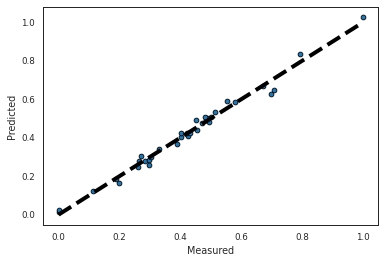

In [1786]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis


<AxesSubplot:xlabel='elasticity', ylabel='feature'>

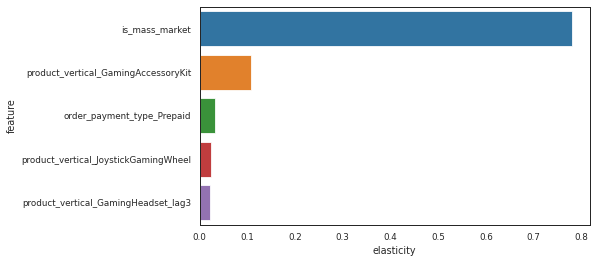

In [1787]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)


plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

##Distributed Lag Model(Additive) for Home Audio


Splitting the Dataframe into Training and Testing Set

In [1788]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(home_dis_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [1789]:
scaler = MinMaxScaler()


In [1790]:
num_vars=home_dis_df.columns

In [1791]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1792]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1793]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1794]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['order_payment_type_Prepaid', 'product_vertical_Dock', 'product_vertical_FMRadio', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'product_mrp', 'product_mrp_lag3', 'product_vertical_VoiceRecorder', 'holiday_week', 'Total_Investment_Ad_Stock_lag3', 'TV_EMA_8', 'Content Marketing_lag3', 'Content_Marketing_Ad_Stock_lag1', 'Online marketing_SMA_3_lag3', 'Affiliates_SMA_5_lag3', 'NPS_SMA_3_lag2', 'Stock Index_SMA_3', 'Stock Index_SMA_5', 'Total Snow (cm)_lag2', 'Snow on Grnd (cm)_lag2'], dtype='object')

In [1795]:
# neglecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'Discount%', 'Discount%_lag1', 'Discount%_lag2', 'Discount%_lag3', 'deliverybdays', 'deliverybdays_lag1', 'deliverybdays_lag2',
       ...
       'Total Snow (cm)', 'Total Snow (cm)_lag1', 'Total Snow (cm)_lag3', 'Total Precip (mm)', 'Total Precip (mm)_lag1', 'Total Precip (mm)_lag2', 'Total Precip (mm)_lag3', 'Snow on Grnd (cm)', 'Snow on Grnd (cm)_lag1', 'Snow on Grnd (cm)_lag3'], dtype='object', length=315)

In [1796]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1797]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     199.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.51e-12
Time:                        10:35:06   Log-Likelihood:                 104.56
No. Observations:                  33   AIC:                            -167.1
Df Residuals:                      12   BIC:                            -135.7
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 247.99
14        Online marketing_SMA_3_lag3  99.71
18                  Stock Index_SMA_5  94.70
16                     NPS_SMA_3_lag2  80.76
15              Affiliates_SMA_5_lag3  75.87
10     Total_Investment_Ad_Stock_lag3  58.31
12             Content Marketing_lag3  18.11
2               product_vertical_Dock  15.23
3            product_vertical_FMRadio  14.52
5   product_vertical_HomeAudioSpeaker  14.14
8      product_vertical_VoiceRecorder  12.38
13    Content_Marketing_Ad_Stock_lag1  11.31
4         product_vertical_HiFiSystem   8.72
11                           TV_EMA_8   8.53
1          order_payment_type_Prepaid   5.02
6                         product_mrp   4.68
7                    product_mrp_lag3   4.49
20             Snow on Grnd (cm)_lag2   3.43
19               Total Snow (cm)_lag2   2.90
9                        holiday_week   2.82
17                  Stock Index_SMA_3   2.33

In [1798]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_HiFiSystem"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     221.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.68e-13
Time:                        10:35:06   Log-Likelihood:                 104.10
No. Observations:                  33   AIC:                            -168.2
Df Residuals:                      13   BIC:                            -138.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 244.55
13        Online marketing_SMA_3_lag3  97.91
17                  Stock Index_SMA_5  93.98
15                     NPS_SMA_3_lag2  80.67
14              Affiliates_SMA_5_lag3  71.10
9      Total_Investment_Ad_Stock_lag3  58.23
11             Content Marketing_lag3  17.66
3            product_vertical_FMRadio  14.51
2               product_vertical_Dock  13.72
4   product_vertical_HomeAudioSpeaker  12.02
7      product_vertical_VoiceRecorder  11.54
12    Content_Marketing_Ad_Stock_lag1   8.69
10                           TV_EMA_8   8.47
5                         product_mrp   4.48
6                    product_mrp_lag3   4.33
1          order_payment_type_Prepaid   4.12
19             Snow on Grnd (cm)_lag2   3.08
18               Total Snow (cm)_lag2   2.89
8                        holiday_week   2.71
16                  Stock Index_SMA_3   2.28

In [1799]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     236.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.54e-14
Time:                        10:35:06   Log-Likelihood:                 103.06
No. Observations:                  33   AIC:                            -168.1
Df Residuals:                      14   BIC:                            -139.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 244.07
13        Online marketing_SMA_3_lag3  95.89
14              Affiliates_SMA_5_lag3  61.26
9      Total_Investment_Ad_Stock_lag3  54.94
11             Content Marketing_lag3  17.12
2               product_vertical_Dock  13.69
3            product_vertical_FMRadio  13.53
7      product_vertical_VoiceRecorder  11.53
4   product_vertical_HomeAudioSpeaker  11.30
12    Content_Marketing_Ad_Stock_lag1   7.65
10                           TV_EMA_8   6.39
5                         product_mrp   4.45
1          order_payment_type_Prepaid   4.01
6                    product_mrp_lag3   3.93
15                     NPS_SMA_3_lag2   3.70
18             Snow on Grnd (cm)_lag2   3.01
8                        holiday_week   2.71
17               Total Snow (cm)_lag2   2.56
16                  Stock Index_SMA_3   2.24

In [1800]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Total_Investment_Ad_Stock_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     260.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.91e-15
Time:                        10:35:06   Log-Likelihood:                 102.53
No. Observations:                  33   AIC:                            -169.1
Df Residuals:                      15   BIC:                            -142.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 244.05
12        Online marketing_SMA_3_lag3  71.97
13              Affiliates_SMA_5_lag3  60.72
3            product_vertical_FMRadio  13.44
2               product_vertical_Dock  10.98
7      product_vertical_VoiceRecorder  10.91
4   product_vertical_HomeAudioSpeaker   8.68
11    Content_Marketing_Ad_Stock_lag1   7.47
10             Content Marketing_lag3   6.02
9                            TV_EMA_8   5.65
5                         product_mrp   4.20
6                    product_mrp_lag3   3.91
1          order_payment_type_Prepaid   3.86
14                     NPS_SMA_3_lag2   3.69
17             Snow on Grnd (cm)_lag2   2.78
8                        holiday_week   2.59
16               Total Snow (cm)_lag2   2.41
15                  Stock Index_SMA_3   2.24

In [1801]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Content Marketing_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     278.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.70e-16
Time:                        10:35:06   Log-Likelihood:                 101.59
No. Observations:                  33   AIC:                            -169.2
Df Residuals:                      16   BIC:                            -143.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 210.93
12              Affiliates_SMA_5_lag3  50.06
11        Online marketing_SMA_3_lag3  47.90
3            product_vertical_FMRadio  10.63
2               product_vertical_Dock   9.40
4   product_vertical_HomeAudioSpeaker   8.42
7      product_vertical_VoiceRecorder   7.95
10    Content_Marketing_Ad_Stock_lag1   7.41
9                            TV_EMA_8   5.63
1          order_payment_type_Prepaid   3.70
5                         product_mrp   3.66
6                    product_mrp_lag3   3.51
13                     NPS_SMA_3_lag2   3.48
16             Snow on Grnd (cm)_lag2   2.78
8                        holiday_week   2.52
15               Total Snow (cm)_lag2   2.35
14                  Stock Index_SMA_3   2.22

In [1802]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Total Snow (cm)_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     299.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.43e-17
Time:                        10:35:06   Log-Likelihood:                 100.75
No. Observations:                  33   AIC:                            -169.5
Df Residuals:                      17   BIC:                            -145.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 210.14
12              Affiliates_SMA_5_lag3  46.15
11        Online marketing_SMA_3_lag3  44.26
3            product_vertical_FMRadio  10.63
2               product_vertical_Dock   8.69
7      product_vertical_VoiceRecorder   7.95
4   product_vertical_HomeAudioSpeaker   7.86
10    Content_Marketing_Ad_Stock_lag1   7.04
9                            TV_EMA_8   5.40
5                         product_mrp   3.66
1          order_payment_type_Prepaid   3.56
13                     NPS_SMA_3_lag2   3.44
6                    product_mrp_lag3   3.43
14                  Stock Index_SMA_3   2.22
15             Snow on Grnd (cm)_lag2   2.03
8                        holiday_week   1.91

In [1803]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online marketing_SMA_3_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     317.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.40e-18
Time:                        10:35:07   Log-Likelihood:                 99.604
No. Observations:                  33   AIC:                            -169.2
Df Residuals:                      18   BIC:                            -146.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                               const 153.43
3            product_vertical_FMRadio   9.66
2               product_vertical_Dock   7.28
7      product_vertical_VoiceRecorder   6.72
11              Affiliates_SMA_5_lag3   6.61
4   product_vertical_HomeAudioSpeaker   5.91
9                            TV_EMA_8   5.19
10    Content_Marketing_Ad_Stock_lag1   3.83
1          order_payment_type_Prepaid   3.53
12                     NPS_SMA_3_lag2   3.40
5                         product_mrp   3.14
6                    product_mrp_lag3   3.07
13                  Stock Index_SMA_3   2.12
14             Snow on Grnd (cm)_lag2   2.03
8                        holiday_week   1.85

In [1804]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_mrp"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     331.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.58e-19
Time:                        10:35:07   Log-Likelihood:                 98.226
No. Observations:                  33   AIC:                            -168.5
Df Residuals:                      19   BIC:                            -147.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 89.81
2               product_vertical_Dock  7.22
3            product_vertical_FMRadio  6.18
4   product_vertical_HomeAudioSpeaker  5.87
6      product_vertical_VoiceRecorder  5.78
10              Affiliates_SMA_5_lag3  5.39
8                            TV_EMA_8  4.95
1          order_payment_type_Prepaid  3.42
11                     NPS_SMA_3_lag2  3.19
9     Content_Marketing_Ad_Stock_lag1  3.01
5                    product_mrp_lag3  2.78
12                  Stock Index_SMA_3  2.12
13             Snow on Grnd (cm)_lag2  1.93
7                        holiday_week  1.85

In [1805]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Content_Marketing_Ad_Stock_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     344.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.99e-20
Time:                        10:35:07   Log-Likelihood:                 96.686
No. Observations:                  33   AIC:                            -167.4
Df Residuals:                      20   BIC:                            -147.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 74.03
2               product_vertical_Dock  6.83
4   product_vertical_HomeAudioSpeaker  5.57
8                            TV_EMA_8  4.89
9               Affiliates_SMA_5_lag3  4.89
3            product_vertical_FMRadio  4.87
6      product_vertical_VoiceRecorder  4.14
1          order_payment_type_Prepaid  3.39
10                     NPS_SMA_3_lag2  3.19
5                    product_mrp_lag3  2.69
11                  Stock Index_SMA_3  2.08
12             Snow on Grnd (cm)_lag2  1.87
7                        holiday_week  1.66

In [1806]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_Dock"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     381.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.37e-21
Time:                        10:35:07   Log-Likelihood:                 96.139
No. Observations:                  33   AIC:                            -168.3
Df Residuals:                      21   BIC:                            -150.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 64.09
7                            TV_EMA_8  4.87
8               Affiliates_SMA_5_lag3  4.12
3   product_vertical_HomeAudioSpeaker  4.05
2            product_vertical_FMRadio  3.39
5      product_vertical_VoiceRecorder  3.25
9                      NPS_SMA_3_lag2  3.17
1          order_payment_type_Prepaid  3.11
4                    product_mrp_lag3  2.52
10                  Stock Index_SMA_3  1.92
11             Snow on Grnd (cm)_lag2  1.86
6                        holiday_week  1.41

In [1807]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS_SMA_3_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     283.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.61e-21
Time:                        10:35:07   Log-Likelihood:                 88.933
No. Observations:                  33   AIC:                            -155.9
Df Residuals:                      22   BIC:                            -139.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                               const 62.08
7                            TV_EMA_8  4.26
8               Affiliates_SMA_5_lag3  4.12
3   product_vertical_HomeAudioSpeaker  3.79
2            product_vertical_FMRadio  3.23
5      product_vertical_VoiceRecorder  3.17
1          order_payment_type_Prepaid  2.94
9                   Stock Index_SMA_3  1.92
10             Snow on Grnd (cm)_lag2  1.77
4                    product_mrp_lag3  1.72
6                        holiday_week  1.39

In [1808]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV_EMA_8"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     199.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.15e-19
Time:                        10:35:07   Log-Likelihood:                 80.806
No. Observations:                  33   AIC:                            -141.6
Df Residuals:                      23   BIC:                            -126.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 61.15
3  product_vertical_HomeAudioSpeaker  3.76
2           product_vertical_FMRadio  3.23
5     product_vertical_VoiceRecorder  3.08
1         order_payment_type_Prepaid  2.01
7              Affiliates_SMA_5_lag3  2.01
8                  Stock Index_SMA_3  1.90
4                   product_mrp_lag3  1.56
9             Snow on Grnd (cm)_lag2  1.51
6                       holiday_week  1.38

In [1809]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     227.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.03e-20
Time:                        10:35:07   Log-Likelihood:                 80.310
No. Observations:                  33   AIC:                            -142.6
Df Residuals:                      24   BIC:                            -129.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 33.66
3  product_vertical_HomeAudioSpeaker  3.15
5     product_vertical_VoiceRecorder  3.00
2           product_vertical_FMRadio  2.81
1         order_payment_type_Prepaid  2.01
7              Affiliates_SMA_5_lag3  1.70
8             Snow on Grnd (cm)_lag2  1.42
6                       holiday_week  1.38
4                   product_mrp_lag3  1.30

In [1810]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["holiday_week"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     266.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.45e-22
Time:                        10:35:07   Log-Likelihood:                 80.015
No. Observations:                  33   AIC:                            -144.0
Df Residuals:                      25   BIC:                            -132.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 33.58
3  product_vertical_HomeAudioSpeaker  2.98
2           product_vertical_FMRadio  2.57
5     product_vertical_VoiceRecorder  2.55
1         order_payment_type_Prepaid  1.87
6              Affiliates_SMA_5_lag3  1.69
7             Snow on Grnd (cm)_lag2  1.37
4                   product_mrp_lag3  1.29

In [1811]:
X_train_rfe.columns

Index(['order_payment_type_Prepaid', 'product_vertical_FMRadio', 'product_vertical_HomeAudioSpeaker', 'product_mrp_lag3', 'product_vertical_VoiceRecorder', 'Affiliates_SMA_5_lag3', 'Snow on Grnd (cm)_lag2'], dtype='object')

In [1812]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Radio_EMA_8_lag3', 'TV_SMA_5_lag2', 'Online marketing', 'Digital_EMA_8_lag3', 'SEM_Ad_Stock_lag2', 'SEM_SMA_5_lag3', 'product_vertical_DockingStation_lag2', 'TV_SMA_3_lag2', 'TV_SMA_3_lag1', 'Online marketing_lag1', 'Radio_EMA_8', 'Stock Index_lag1', 'Cool Deg Days_lag1', 'gmv_lag2', 'Stock Index_SMA_3_lag1', 'Digital_EMA_8_lag1', 'SEM_SMA_5', 'Sponsorship_SMA_3_lag1', 'product_vertical_HomeAudioSpeaker_lag2', 'pay_week', 'Other_SMA_5_lag3', 'Stock Index_SMA_5', 'Sponsorship_EMA_8', 'Affiliates_SMA_5', 'Online_marketing_Ad_Stock_lag1', 'TV_lag3', 'TV', 'TV_Ad_Stock_lag2', 'SEM_Ad_Stock_lag3', 'Content Marketing_EMA_8_lag1', 'deliverybdays_lag2', 'Sponsorship_lag2', 'Heat Deg Days', 'Mean Temp_lag1', 'product_vertical_Dock', 'Total Precip (mm)', 'Total Precip (mm)_lag1', 'product_vertical_DockingStation_lag1', 'Discount%_lag3', 'Other_Ad_Stock_lag1', 'Sponsorship_SMA_5', 'is_mass_market_lag2', 'gmv', 'sla_lag2', 'gmv_lag3', 'Max Temp_lag3', 'Affiliates_Ad_Stock_lag3', 'TV_EMA_8_lag2',

In [1813]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([0.88469389, 0.80679425, 0.94477722, 0.99226713, 0.53599362,
       0.96931116, 0.68353473, 0.97549843, 0.97445878, 0.94088146])

In [1814]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)


In [1815]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.001065006262359382
r_square_value : 0.9692547945468291


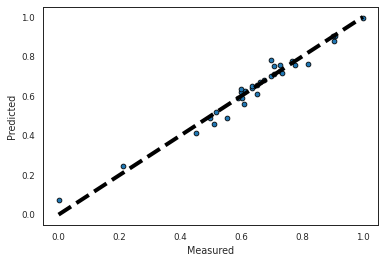

In [1816]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis


<AxesSubplot:xlabel='elasticity', ylabel='feature'>

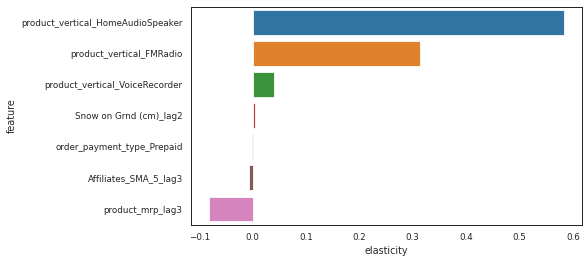

In [1817]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)



plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

# Distributed Lag Model (Multiplicative)

The Distributive Lag Model(Multiplicative) will now help us capture current-to-current interactions and carry over KPIs effects.

Take data logarithms (on both sides of the model) to fit a multiplicative model, then analyze the log data as before.

Yt = α+ µ1ln(Yt-1) + µ2ln(Yt-2) + µ3ln(Yt-3) + ....+ β1ln(X1t) + β1ln(X1t-1) + β1ln(X1t-2) + ....+ β2ln(X2t) + β2ln(X2t-1) + β2ln(X2t-2) + ....+ β3ln(X3t) + β3ln(X3t-1) + β3ln(X3t-2) + ....+ β4ln(X4t) + β4ln(X4t-1) + β4ln(X4t-2) + ....+ β5ln(X5t) + β5ln(X5t-1) + β5ln(X5t-2) + ....+ ϵ'

In [1818]:
# Making copy of dataframes from the original ones
cam_dis_mul_df = Camera_accessory_org_df.copy()
gam_dis_mul_df = gaming_accessory_org_df.copy()
home_dis_mul_df = Homeaudio_org_df.copy()
home_dis_mul_df.head() 

gmv  Discount%  deliverybdays  deliverycdays  sla  product_procurement_sla  order_payment_type_Prepaid  is_mass_market  special_sales  product_vertical_Dock  product_vertical_DockingStation  product_vertical_FMRadio  product_vertical_HiFiSystem  product_vertical_HomeAudioSpeaker  product_mrp  product_vertical_SoundMixer  product_vertical_VoiceRecorder  pay_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock   TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  \
26 1185712.00      30.67           0.00           0.00 7.00                     1.95                      213.00             793              0                     24                                1                    334.00                            8                             541.00      1958.61                            0                               2         0             0              4.26                    0.00                    0.00                    4.26                       4.26 0.05      0.00      0.00      0.05         0.05     0.63           0.00           0.00           0.63              0.63         1.85               0.00               0.00               1.85                  1.85               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.33        0.14              0.00   
27 1471962.00      30.37           0.00           0.00 6.71                     1.78                      243.00             936            297                     36                                0                    374.00                           19                             657.00      2016.77                            0                               7         1             0              4.26                    0.00                    0.00                    4.26                       6.82 0.05      0.00      0.00      0.05         0.09     0.63           0.00           0.00           0.63              1.01         1.85               0.00               0.00               1.85                  2.97               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.00                    0.00                    0.33                       0.53        0.14              0.00   
28 1275392.00      28.88           0.00           0.00 6.82                     1.80                      191.00             909              0                     40                                0                    394.00                           16                             544.00      1896.30                            0                               1         0             0              4.26                    4.26                    0.00                    4.26                       8.36 0.05      0.05      0.00      0.05         0.11     0.63           0.63           0.00           0.63              1.24         1.85               1.85               0.00               1.85                  3.63               0.00                     0.00                     0.00                     0.00                        0.00              0.33                    0.33                    0.00                    0.33                       0.65        0.14              0.14   
29  920394.00      28.04           0.00           0.00

In [1819]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(home_dis_mul_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(home_dis_mul_df.isnull().sum()/home_dis_mul_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])

pd.concat([total, percentage], axis = 1).head()

Total  Percentage
gmv                      0        0.00
Affiliates_Ad_Stock      0        0.00
Radio_SMA_5              0        0.00
Radio_SMA_3              0        0.00
Radio                    0        0.00

Create new lag(Lag of 3 weeks) variables for the dependent variable (GMV) as well as independent variables


In [1820]:
cam_dis_mul_df_columns = cam_dis_mul_df.columns
gam_dis_mul_df_columns = gam_dis_mul_df.columns
home_dis_mul_df_columns = home_dis_mul_df.columns

In [1821]:
cam_dis_mul_df = lag_variables(cam_dis_mul_df,cam_dis_mul_df_columns,3)
gam_dis_mul_df = lag_variables(gam_dis_mul_df,gam_dis_mul_df_columns,3)
home_dis_mul_df = lag_variables(home_dis_mul_df,home_dis_mul_df_columns,3)
home_dis_mul_df.head()

gmv   gmv_lag3  Discount%  Discount%_lag3  deliverybdays  deliverybdays_lag3  deliverycdays  deliverycdays_lag3  sla  sla_lag3  product_procurement_sla  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag3  special_sales  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag3  product_vertical_HiFiSystem  product_vertical_HiFiSystem_lag3  product_vertical_HomeAudioSpeaker  product_vertical_HomeAudioSpeaker_lag3  product_mrp  product_mrp_lag3  product_vertical_SoundMixer  product_vertical_SoundMixer_lag3  product_vertical_VoiceRecorder  product_vertical_VoiceRecorder_lag3  pay_week  pay_week_lag3  holiday_week  holiday_week_lag3  Total Investment  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag3  Total Investment_SMA_5  \
26 1185712.00        NaN      30.67             NaN           0.00                 NaN           0.00                 NaN 7.00       NaN                     1.95                           NaN                      213.00                              NaN             793                  NaN              0                 NaN                     24                         NaN                                1                                   NaN                    334.00                            NaN                            8                               NaN                             541.00                                     NaN      1958.61               NaN                            0                               NaN                               2                                  NaN         0            NaN             0                NaN              4.26                    NaN                    0.00                          NaN                    0.00   
27 1471962.00        NaN      30.37             NaN           0.00                 NaN           0.00                 NaN 6.71       NaN                     1.78                           NaN                      243.00                              NaN             936                  NaN            297                 NaN                     36                         NaN                                0                                   NaN                    374.00                            NaN                           19                               NaN                             657.00                                     NaN      2016.77               NaN                            0                               NaN                               7                                  NaN         1            NaN             0                NaN              4.26                    NaN                    0.00                          NaN                    0.00   
28 1275392.00        NaN      28.88             NaN           0.00                 NaN           0.00                 NaN 6.82       NaN                     1.80                           NaN                      191.00                              NaN             909                  NaN              0                 NaN                     40                         NaN                                0                                   NaN                    394.00                            NaN                           16                               NaN                             544.00                                     NaN      1896.30               NaN                            0                               NaN                               1                                  NaN         0            NaN             0                NaN              4.26                    NaN                    4.26                          NaN                    0.00   
29  920394.00 1185712.00      28.04           30.67           0.00        

Create new lag(Lag of 2 weeks) variables for the dependent variable (GMV) as well as independent variables


In [1822]:
cam_dis_mul_df = lag_variables(cam_dis_mul_df,cam_dis_mul_df_columns,2)
gam_dis_mul_df = lag_variables(gam_dis_mul_df,gam_dis_mul_df_columns,2)
home_dis_mul_df = lag_variables(home_dis_mul_df,home_dis_mul_df_columns,2)
home_dis_mul_df.head()

gmv   gmv_lag2   gmv_lag3  Discount%  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag2  deliverycdays_lag3  sla  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag2  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag2  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag2  is_mass_market_lag3  special_sales  special_sales_lag2  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag2  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag2  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag2  product_vertical_FMRadio_lag3  product_vertical_HiFiSystem  product_vertical_HiFiSystem_lag2  product_vertical_HiFiSystem_lag3  product_vertical_HomeAudioSpeaker  product_vertical_HomeAudioSpeaker_lag2  product_vertical_HomeAudioSpeaker_lag3  \
26 1185712.00        NaN        NaN      30.67             NaN             NaN           0.00                 NaN                 NaN           0.00                 NaN                 NaN 7.00       NaN       NaN                     1.95                           NaN                           NaN                      213.00                              NaN                              NaN             793                  NaN                  NaN              0                 NaN                 NaN                     24                         NaN                         NaN                                1                                   NaN                                   NaN                    334.00                            NaN                            NaN                            8                               NaN                               NaN                             541.00                                     NaN                                     NaN   
27 1471962.00        NaN        NaN      30.37             NaN             NaN           0.00                 NaN                 NaN           0.00                 NaN                 NaN 6.71       NaN       NaN                     1.78                           NaN                           NaN                      243.00                              NaN                              NaN             936                  NaN                  NaN            297                 NaN                 NaN                     36                         NaN                         NaN                                0                                   NaN                                   NaN                    374.00                            NaN                            NaN                           19                               NaN                               NaN                             657.00                                     NaN                                     NaN   
28 1275392.00 1185712.00        NaN      28.88           30.67             NaN           0.00                0.00                 NaN           0.00                0.00                 NaN 6.82      7.00       NaN                     1.80                          1.95                           NaN                      191.00                           213.00                              NaN             909               793.00                  NaN              0                0.00                 NaN                     40                       24.00                         NaN                                0                                  1.00                                   NaN                    394.00                         334.00                            NaN                           16                              8.00                               NaN                             544.00                                  541.00                                     NaN   
29  920394.00 1471962.

Create new lag(Lag of 1 week) variables for the dependent variable (GMV) as well as independent variables


In [1823]:
cam_dis_mul_df = lag_variables(cam_dis_mul_df,cam_dis_mul_df_columns,1)
gam_dis_mul_df = lag_variables(gam_dis_mul_df,gam_dis_mul_df_columns,1)
home_dis_mul_df = lag_variables(home_dis_mul_df,home_dis_mul_df_columns,1)
home_dis_mul_df.head()

gmv   gmv_lag1   gmv_lag2   gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3  sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag1  order_payment_type_Prepaid_lag2  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  special_sales  special_sales_lag1  special_sales_lag2  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag1  product_vertical_Dock_lag2  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag1  product_vertical_DockingStation_lag2  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag1  \
26 1185712.00        NaN        NaN        NaN      30.67             NaN             NaN             NaN           0.00                 NaN                 NaN                 NaN           0.00                 NaN                 NaN                 NaN 7.00       NaN       NaN       NaN                     1.95                           NaN                           NaN                           NaN                      213.00                              NaN                              NaN                              NaN             793                  NaN                  NaN                  NaN              0                 NaN                 NaN                 NaN                     24                         NaN                         NaN                         NaN                                1                                   NaN                                   NaN                                   NaN                    334.00                            NaN   
27 1471962.00 1185712.00        NaN        NaN      30.37           30.67             NaN             NaN           0.00                0.00                 NaN                 NaN           0.00                0.00                 NaN                 NaN 6.71      7.00       NaN       NaN                     1.78                          1.95                           NaN                           NaN                      243.00                           213.00                              NaN                              NaN             936               793.00                  NaN                  NaN            297                0.00                 NaN                 NaN                     36                       24.00                         NaN                         NaN                                0                                  1.00                                   NaN                                   NaN                    374.00                         334.00   
28 1275392.00 1471962.00 1185712.00        NaN      28.88           30.37           30.67             NaN           0.00                0.00                0.00                 NaN           0.00                0.00                0.00                 NaN 6.82      6.71      7.00       NaN                     1.80                          1.78                          1.95                           NaN                      191.00                           243.00                           213.00                              NaN             909               936.00               793.00                  NaN              0              297.00                0.00                 NaN                     40                       36.00                       24.00                         NaN                                0                                  0.00                                  1.00                                   NaN                    394.00                         374.00   
29  92

Imputing all null values with 0


In [1824]:
# Imputing all null values with 0
cam_dis_mul_df.fillna(value=0, inplace=True)
gam_dis_mul_df.fillna(value=0, inplace=True)
home_dis_mul_df.fillna(value=0, inplace=True)
home_dis_mul_df.head(10)

gmv   gmv_lag1   gmv_lag2   gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3  sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag1  order_payment_type_Prepaid_lag2  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  special_sales  special_sales_lag1  special_sales_lag2  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag1  product_vertical_Dock_lag2  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag1  product_vertical_DockingStation_lag2  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag1  \
26 1185712.00       0.00       0.00       0.00      30.67            0.00            0.00            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 7.00      0.00      0.00      0.00                     1.95                          0.00                          0.00                          0.00                      213.00                             0.00                             0.00                             0.00             793                 0.00                 0.00                 0.00              0                0.00                0.00                0.00                     24                        0.00                        0.00                        0.00                                1                                  0.00                                  0.00                                  0.00                    334.00                           0.00   
27 1471962.00 1185712.00       0.00       0.00      30.37           30.67            0.00            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 6.71      7.00      0.00      0.00                     1.78                          1.95                          0.00                          0.00                      243.00                           213.00                             0.00                             0.00             936               793.00                 0.00                 0.00            297                0.00                0.00                0.00                     36                       24.00                        0.00                        0.00                                0                                  1.00                                  0.00                                  0.00                    374.00                         334.00   
28 1275392.00 1471962.00 1185712.00       0.00      28.88           30.37           30.67            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 6.82      6.71      7.00      0.00                     1.80                          1.78                          1.95                          0.00                      191.00                           243.00                           213.00                             0.00             909               936.00               793.00                 0.00              0              297.00                0.00                0.00                     40                       36.00                       24.00                        0.00                                0                                  0.00                                  1.00                                  0.00                    394.00                         374.00   
29  92

Taking Logarithm of both the Dependent and the independent variables


After taking log, all 0 values will be transformed to inf. Retransforming these values to 0.



In [1825]:
cam_dis_mul_df = cam_dis_mul_df.applymap(lambda x: np.log(x))
cam_dis_mul_df = cam_dis_mul_df.replace([np.inf, -np.inf], 0)
cam_dis_mul_df = cam_dis_mul_df.replace(np.nan, 0)

gam_dis_mul_df = gam_dis_mul_df.applymap(lambda x: np.log(x))
gam_dis_mul_df = gam_dis_mul_df.replace([np.inf, -np.inf], 0)
gam_dis_mul_df = gam_dis_mul_df.replace(np.nan, 0)

home_dis_mul_df = home_dis_mul_df.applymap(lambda x: np.log(x))
home_dis_mul_df = home_dis_mul_df.replace([np.inf, -np.inf], 0)
home_dis_mul_df = home_dis_mul_df.replace(np.nan, 0)

home_dis_mul_df.head()

gmv  gmv_lag1  gmv_lag2  gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3  sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3  order_payment_type_Prepaid  order_payment_type_Prepaid_lag1  order_payment_type_Prepaid_lag2  order_payment_type_Prepaid_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  special_sales  special_sales_lag1  special_sales_lag2  special_sales_lag3  product_vertical_Dock  product_vertical_Dock_lag1  product_vertical_Dock_lag2  product_vertical_Dock_lag3  product_vertical_DockingStation  product_vertical_DockingStation_lag1  product_vertical_DockingStation_lag2  product_vertical_DockingStation_lag3  product_vertical_FMRadio  product_vertical_FMRadio_lag1  \
26 13.99      0.00      0.00      0.00       3.42            0.00            0.00            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 1.95      0.00      0.00      0.00                     0.67                          0.00                          0.00                          0.00                        5.36                             0.00                             0.00                             0.00            6.68                 0.00                 0.00                 0.00           0.00                0.00                0.00                0.00                   3.18                        0.00                        0.00                        0.00                             0.00                                  0.00                                  0.00                                  0.00                      5.81                           0.00   
27 14.20     13.99      0.00      0.00       3.41            3.42            0.00            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 1.90      1.95      0.00      0.00                     0.58                          0.67                          0.00                          0.00                        5.49                             5.36                             0.00                             0.00            6.84                 6.68                 0.00                 0.00           5.69                0.00                0.00                0.00                   3.58                        3.18                        0.00                        0.00                             0.00                                  0.00                                  0.00                                  0.00                      5.92                           5.81   
28 14.06     14.20     13.99      0.00       3.36            3.41            3.42            0.00           0.00                0.00                0.00                0.00           0.00                0.00                0.00                0.00 1.92      1.90      1.95      0.00                     0.59                          0.58                          0.67                          0.00                        5.25                             5.49                             5.36                             0.00            6.81                 6.84                 6.68                 0.00           0.00                5.69                0.00                0.00                   3.69                        3.58                        3.18                        0.00                             0.00                                  0.00                                  0.00                                  0.00                      5.98                           5.92   
29 13.73     14.06     14.20     

In [1826]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(home_dis_mul_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(home_dis_mul_df.isnull().sum()/home_dis_mul_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])

pd.concat([total, percentage], axis = 1).head()

Total  Percentage
gmv                 0        0.00
SEM_SMA_3_lag1      0        0.00
SEM_EMA_8_lag1      0        0.00
SEM_EMA_8           0        0.00
SEM_SMA_5_lag3      0        0.00

##Distributed Lag Model(Multiplicative) for Camera Accessory


Splitting the Dataframe into Training and Testing Set


In [1827]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(cam_dis_mul_df, train_size = 0.7, test_size = 0.3, random_state = 100)

Rescaling the Features


In [1828]:
scaler = MinMaxScaler()

In [1829]:
num_vars =cam_dis_mul_df.columns

In [1830]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1831]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1832]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1833]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Discount%', 'product_mrp', 'is_mass_market', 'product_vertical_CameraBag', 'product_vertical_CameraMount_lag3', 'product_vertical_CameraRemoteControl', 'product_vertical_Lens', 'TV_SMA_5', 'TV_SMA_5_lag1', 'TV_SMA_5_lag2', 'Content Marketing', 'Online marketing', 'Online_marketing_Ad_Stock', 'Affiliates_SMA_3_lag2', 'Affiliates_SMA_5', 'NPS_SMA_3_lag2', 'NPS_SMA_5_lag3', 'Stock Index_SMA_3_lag3', 'Stock Index_SMA_5', 'Stock Index_SMA_5_lag3'], dtype='object')

In [1834]:
# neglecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'Discount%_lag1', 'Discount%_lag2', 'Discount%_lag3', 'deliverybdays', 'deliverybdays_lag1', 'deliverybdays_lag2', 'deliverybdays_lag3',
       ...
       'Total Snow (cm)_lag2', 'Total Snow (cm)_lag3', 'Total Precip (mm)', 'Total Precip (mm)_lag1', 'Total Precip (mm)_lag2', 'Total Precip (mm)_lag3', 'Snow on Grnd (cm)', 'Snow on Grnd (cm)_lag1', 'Snow on Grnd (cm)_lag2', 'Snow on Grnd (cm)_lag3'], dtype='object', length=371)

In [1835]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1836]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     9130.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.03e-22
Time:                        10:35:14   Log-Likelihood:                 172.69
No. Observations:                  33   AIC:                            -303.4
Df Residuals:                      12   BIC:                            -272.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features      VIF
20                Stock Index_SMA_5_lag3 51027.10
18                Stock Index_SMA_3_lag3 43723.89
16                        NPS_SMA_3_lag2  9504.88
19                     Stock Index_SMA_5  7874.02
0                                  const  6172.79
17                        NPS_SMA_5_lag3  2703.86
12                      Online marketing   835.86
13             Online_marketing_Ad_Stock   706.78
3                         is_mass_market   490.74
15                      Affiliates_SMA_5   401.54
14                 Affiliates_SMA_3_lag2   293.46
4             product_vertical_CameraBag   197.08
10                         TV_SMA_5_lag2   187.52
7                  product_vertical_Lens   176.15
9                          TV_SMA_5_lag1   128.19
1                              Discount%   125.72
8                               TV_SMA_5   120.72
6   product_vertical_CameraRemoteControl    69.98
11                     Content Marketing    36.22
2                            product_mrp    16.84
5      product_vertical_CameraMount_lag3    11.82

In [1837]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS_SMA_3_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.015e+04
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.52e-24
Time:                        10:35:14   Log-Likelihood:                 172.27
No. Observations:                  33   AIC:                            -304.5
Df Residuals:                      13   BIC:                            -274.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features      VIF
19                Stock Index_SMA_5_lag3 30919.00
17                Stock Index_SMA_3_lag3 21251.95
0                                  const  5315.98
16                        NPS_SMA_5_lag3  1431.16
18                     Stock Index_SMA_5   849.88
12                      Online marketing   765.29
13             Online_marketing_Ad_Stock   696.19
15                      Affiliates_SMA_5   345.89
14                 Affiliates_SMA_3_lag2   228.18
3                         is_mass_market   209.77
4             product_vertical_CameraBag   182.52
10                         TV_SMA_5_lag2   151.49
7                  product_vertical_Lens   134.02
9                          TV_SMA_5_lag1   126.73
8                               TV_SMA_5   120.47
1                              Discount%    83.02
11                     Content Marketing    29.55
6   product_vertical_CameraRemoteControl    27.14
2                            product_mrp    15.74
5      product_vertical_CameraMount_lag3    10.00

In [1838]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_5_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.144e+04
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.31e-26
Time:                        10:35:14   Log-Likelihood:                 172.13
No. Observations:                  33   AIC:                            -306.3
Df Residuals:                      14   BIC:                            -277.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features     VIF
0                                  const 5153.84
17                Stock Index_SMA_3_lag3 1547.07
16                        NPS_SMA_5_lag3 1394.98
18                     Stock Index_SMA_5  694.79
13             Online_marketing_Ad_Stock  671.72
12                      Online marketing  604.81
15                      Affiliates_SMA_5  342.42
14                 Affiliates_SMA_3_lag2  192.70
4             product_vertical_CameraBag  180.65
3                         is_mass_market  180.28
7                  product_vertical_Lens  133.92
10                         TV_SMA_5_lag2  132.01
9                          TV_SMA_5_lag1  109.07
8                               TV_SMA_5   97.96
1                              Discount%   67.52
6   product_vertical_CameraRemoteControl   27.04
11                     Content Marketing   22.32
2                            product_mrp   13.45
5      product_vertical_CameraMount_lag3    9.69

In [1839]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_3_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.126e+04
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.06e-27
Time:                        10:35:14   Log-Likelihood:                 169.79
No. Observations:                  33   AIC:                            -303.6
Df Residuals:                      15   BIC:                            -276.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features     VIF
0                                  const 4145.16
16                        NPS_SMA_5_lag3 1298.18
13             Online_marketing_Ad_Stock  668.89
12                      Online marketing  484.58
17                     Stock Index_SMA_5  446.60
15                      Affiliates_SMA_5  342.17
3                         is_mass_market  178.51
14                 Affiliates_SMA_3_lag2  177.32
4             product_vertical_CameraBag  173.37
7                  product_vertical_Lens  132.32
10                         TV_SMA_5_lag2  122.94
9                          TV_SMA_5_lag1   97.72
8                               TV_SMA_5   93.08
1                              Discount%   67.28
6   product_vertical_CameraRemoteControl   25.83
11                     Content Marketing   16.20
2                            product_mrp   13.43
5      product_vertical_CameraMount_lag3    9.56

In [1840]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS_SMA_5_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.231e+04
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.22e-29
Time:                        10:35:14   Log-Likelihood:                 169.19
No. Observations:                  33   AIC:                            -304.4
Df Residuals:                      16   BIC:                            -278.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features     VIF
0                                  const 3400.72
13             Online_marketing_Ad_Stock  612.41
15                      Affiliates_SMA_5  264.75
16                     Stock Index_SMA_5  238.11
12                      Online marketing  206.65
3                         is_mass_market  157.61
14                 Affiliates_SMA_3_lag2  148.48
4             product_vertical_CameraBag  142.24
10                         TV_SMA_5_lag2  118.29
7                  product_vertical_Lens  113.33
9                          TV_SMA_5_lag1   69.35
8                               TV_SMA_5   62.79
1                              Discount%   41.27
6   product_vertical_CameraRemoteControl   22.64
2                            product_mrp   12.72
5      product_vertical_CameraMount_lag3    9.56
11                     Content Marketing    7.19

In [1841]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online_marketing_Ad_Stock"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.336e+04
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.45e-31
Time:                        10:35:14   Log-Likelihood:                 168.47
No. Observations:                  33   AIC:                            -304.9
Df Residuals:                      17   BIC:                            -281.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features     VIF
0                                  const 1253.32
3                         is_mass_market  157.04
12                      Online marketing  143.58
13                 Affiliates_SMA_3_lag2  116.44
4             product_vertical_CameraBag  107.96
10                         TV_SMA_5_lag2  104.40
7                  product_vertical_Lens   92.24
14                      Affiliates_SMA_5   90.59
15                     Stock Index_SMA_5   69.38
8                               TV_SMA_5   62.03
9                          TV_SMA_5_lag1   61.30
1                              Discount%   41.21
6   product_vertical_CameraRemoteControl   21.80
2                            product_mrp   12.37
5      product_vertical_CameraMount_lag3    8.99
11                     Content Marketing    7.00

In [1842]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.462e+04
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.57e-33
Time:                        10:35:14   Log-Likelihood:                 167.89
No. Observations:                  33   AIC:                            -305.8
Df Residuals:                      18   BIC:                            -283.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 988.97
3                         is_mass_market 156.81
4             product_vertical_CameraBag 107.84
7                  product_vertical_Lens  92.23
12                      Online marketing  80.93
10                         TV_SMA_5_lag2  73.54
8                               TV_SMA_5  55.55
14                     Stock Index_SMA_5  52.86
13                 Affiliates_SMA_3_lag2  47.81
9                          TV_SMA_5_lag1  42.02
1                              Discount%  41.19
6   product_vertical_CameraRemoteControl  21.75
2                            product_mrp  11.13
5      product_vertical_CameraMount_lag3   8.20
11                     Content Marketing   5.97

In [1843]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["is_mass_market"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     276.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.70e-19
Time:                        10:35:14   Log-Likelihood:                 100.38
No. Observations:                  33   AIC:                            -172.8
Df Residuals:                      19   BIC:                            -151.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 985.27
3             product_vertical_CameraBag 102.31
6                  product_vertical_Lens  88.14
11                      Online marketing  76.46
9                          TV_SMA_5_lag2  72.82
7                               TV_SMA_5  54.24
13                     Stock Index_SMA_5  51.41
12                 Affiliates_SMA_3_lag2  47.29
8                          TV_SMA_5_lag1  41.35
5   product_vertical_CameraRemoteControl  16.86
1                              Discount%  13.66
2                            product_mrp   9.59
4      product_vertical_CameraMount_lag3   7.86
10                     Content Marketing   5.95

In [1844]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraBag"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     284.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.33e-19
Time:                        10:35:15   Log-Likelihood:                 98.675
No. Observations:                  33   AIC:                            -171.3
Df Residuals:                      20   BIC:                            -151.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 705.83
8                          TV_SMA_5_lag2  69.98
10                      Online marketing  55.86
11                 Affiliates_SMA_3_lag2  46.41
6                               TV_SMA_5  40.84
7                          TV_SMA_5_lag1  33.42
5                  product_vertical_Lens  32.28
12                     Stock Index_SMA_5  30.97
1                              Discount%  13.66
4   product_vertical_CameraRemoteControl  12.89
2                            product_mrp   8.66
3      product_vertical_CameraMount_lag3   7.83
9                      Content Marketing   5.20

In [1845]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV_SMA_5_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     325.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           7.15e-21
Time:                        10:35:15   Log-Likelihood:                 98.670
No. Observations:                  33   AIC:                            -173.3
Df Residuals:                      21   BIC:                            -155.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 442.97
9                       Online marketing  55.81
5                  product_vertical_Lens  30.95
11                     Stock Index_SMA_5  30.29
6                               TV_SMA_5  29.89
1                              Discount%  13.63
4   product_vertical_CameraRemoteControl  12.89
7                          TV_SMA_5_lag1  11.24
3      product_vertical_CameraMount_lag3   7.50
2                            product_mrp   7.25
8                      Content Marketing   5.20
10                 Affiliates_SMA_3_lag2   3.54

In [1846]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_3_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     372.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.79e-22
Time:                        10:35:15   Log-Likelihood:                 98.576
No. Observations:                  33   AIC:                            -175.2
Df Residuals:                      22   BIC:                            -158.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                  const 435.93
9                       Online marketing  55.43
10                     Stock Index_SMA_5  30.29
6                               TV_SMA_5  29.69
5                  product_vertical_Lens  24.36
1                              Discount%  13.43
4   product_vertical_CameraRemoteControl  11.54
7                          TV_SMA_5_lag1  10.21
2                            product_mrp   6.46
3      product_vertical_CameraMount_lag3   5.95
8                      Content Marketing   4.84

In [1847]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     431.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.84e-23
Time:                        10:35:15   Log-Likelihood:                 98.506
No. Observations:                  33   AIC:                            -177.0
Df Residuals:                      23   BIC:                            -162.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                 const 320.80
5                 product_vertical_Lens  22.47
8                      Online marketing  21.28
9                     Stock Index_SMA_5  13.90
1                             Discount%  13.21
4  product_vertical_CameraRemoteControl  10.73
2                           product_mrp   6.44
3     product_vertical_CameraMount_lag3   5.92
7                     Content Marketing   3.15
6                         TV_SMA_5_lag1   2.67

In [1848]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV_SMA_5_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     502.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.46e-25
Time:                        10:35:15   Log-Likelihood:                 98.400
No. Observations:                  33   AIC:                            -178.8
Df Residuals:                      24   BIC:                            -165.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                 const 218.25
5                 product_vertical_Lens  21.00
7                      Online marketing  13.93
1                             Discount%  11.84
4  product_vertical_CameraRemoteControl  10.34
8                     Stock Index_SMA_5   7.45
2                           product_mrp   5.73
3     product_vertical_CameraMount_lag3   3.56
6                     Content Marketing   3.08

In [1849]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraMount_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     573.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.67e-26
Time:                        10:35:15   Log-Likelihood:                 97.686
No. Observations:                  33   AIC:                            -179.4
Df Residuals:                      25   BIC:                            -167.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features    VIF
0                                 const 189.26
4                 product_vertical_Lens  19.56
6                      Online marketing  13.14
3  product_vertical_CameraRemoteControl  10.34
1                             Discount%   8.87
7                     Stock Index_SMA_5   7.42
2                           product_mrp   3.58
5                     Content Marketing   2.80

In [1850]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Content Marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     599.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.38e-26
Time:                        10:35:15   Log-Likelihood:                 95.263
No. Observations:                  33   AIC:                            -176.5
Df Residuals:                      26   BIC:                            -166.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Features   VIF
0                                 const 67.15
4                 product_vertical_Lens 17.14
3  product_vertical_CameraRemoteControl 10.01
5                      Online marketing  8.73
1                             Discount%  7.96
6                     Stock Index_SMA_5  4.15
2                           product_mrp  3.55

In [1851]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_CameraRemoteControl"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     467.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.55e-25
Time:                        10:35:15   Log-Likelihood:                 87.572
No. Observations:                  33   AIC:                            -163.1
Df Residuals:                      27   BIC:                            -154.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.14

Features   VIF
0                  const 64.91
3  product_vertical_Lens 10.39
4       Online marketing  8.25
1              Discount%  7.34
5      Stock Index_SMA_5  3.99
2            product_mrp  2.98

In [1852]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     251.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.68e-21
Time:                        10:35:15   Log-Likelihood:                 73.330
No. Observations:                  33   AIC:                            -136.7
Df Residuals:                      28   BIC:                            -129.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.02

Features   VIF
0                  const 30.91
3  product_vertical_Lens  7.23
1              Discount%  6.85
2            product_mrp  2.38
4       Online marketing  2.22

In [1853]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_mrp"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     325.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.04e-22
Time:                        10:35:15   Log-Likelihood:                 72.295
No. Observations:                  33   AIC:                            -136.6
Df Residuals:                      29   BIC:                            -130.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.03

Features   VIF
0                  const 30.43
2  product_vertical_Lens  6.98
1              Discount%  6.49
3       Online marketing  2.20

In [1854]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_Lens"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     118.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.11e-15
Time:                        10:35:15   Log-Likelihood:                 49.794
No. Observations:                  33   AIC:                            -93.59
Df Residuals:                      30   BIC:                            -89.10
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1177      0.051  

Features   VIF
0             const 26.86
1         Discount%  2.01
2  Online marketing  2.01

In [1855]:
X_train_rfe.columns

Index(['Discount%', 'Online marketing'], dtype='object')

In [1856]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Radio_EMA_8_lag3', 'TV_SMA_5_lag2', 'Digital_EMA_8_lag3', 'SEM_Ad_Stock_lag2', 'SEM_SMA_5_lag3', 'product_vertical_CameraRemoteControl_lag3', 'TV_SMA_3_lag2', 'TV_SMA_3_lag1', 'product_vertical_Flash_lag3', 'Online marketing_lag1', 'product_vertical_CameraMount_lag2', 'Radio_EMA_8', 'Stock Index_lag1', 'product_vertical_CameraBattery_lag1', 'Cool Deg Days_lag1', 'gmv_lag2', 'Stock Index_SMA_3_lag1', 'Digital_EMA_8_lag1', 'Sponsorship_SMA_3_lag1', 'SEM_SMA_5', 'product_vertical_CameraAccessory_lag1', 'pay_week', 'Other_SMA_5_lag3', 'Stock Index_SMA_5', 'product_vertical_Filter_lag2', 'Sponsorship_EMA_8', 'product_vertical_CameraFilmRolls', 'Affiliates_SMA_5', 'product_vertical_Flash_lag2', 'Online_marketing_Ad_Stock_lag1', 'TV_lag3', 'TV', 'TV_Ad_Stock_lag2', 'SEM_Ad_Stock_lag3', 'Content Marketing_EMA_8_lag1', 'deliverybdays_lag2', 'Sponsorship_lag2', 'Heat Deg Days', 'Mean Temp_lag1', 'Total Precip (mm)', 'product_vertical_Telescope_lag3', 'Total Precip (mm)_lag1', 'Other_Ad_Stock_l

In [1857]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ -7.53872058,  -0.12703705,  -4.97566129,   0.26654257,
        -3.31240685,  -5.38834536,  -0.61427876,   0.24734977,
       -25.98208247,  -5.33376165])

In [1858]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1859]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.014041955062799686
r_square_value : 0.44675164761620767


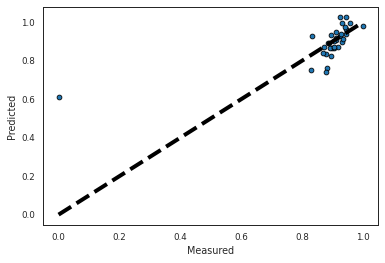

In [1860]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


Elasticity for Camera Accessory


<AxesSubplot:xlabel='elasticity', ylabel='feature'>

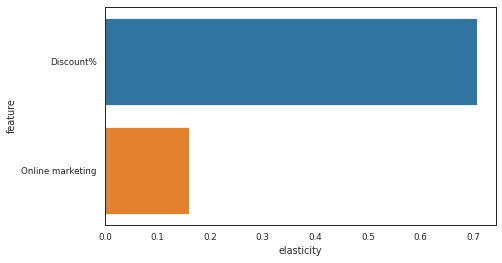

In [1861]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)


plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

##Distributed Lag Model(Multiplicative) for Gaming Accessory


Splitting the Dataframe into Training and Testing Set


In [1862]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(gam_dis_mul_df, train_size = 0.7, test_size = 0.3, random_state = 100)

Rescaling the Features

In [1863]:
scaler = MinMaxScaler()

In [1864]:
num_vars= gam_dis_mul_df.columns

In [1865]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1866]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1867]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1868]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['sla', 'product_procurement_sla', 'product_procurement_sla_lag1', 'is_mass_market', 'product_vertical_GamePad', 'product_vertical_GamingAccessoryKit', 'product_vertical_GamingAdapter', 'product_vertical_GamingHeadset', 'product_vertical_GamingMemoryCard', 'product_vertical_GamingMouse', 'product_vertical_GamingMousePad', 'product_vertical_TVOutCableAccessory', 'product_vertical_TVOutCableAccessory_lag1', 'Sponsorship_lag3', 'Sponsorship_SMA_5', 'Online marketing_SMA_3_lag3', 'Affiliates_SMA_3_lag3', 'Stock Index_SMA_3_lag3', 'Stock Index_SMA_5', 'Total Precip (mm)_lag3'], dtype='object')

In [1869]:
# neglecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'Discount%', 'Discount%_lag1', 'Discount%_lag2', 'Discount%_lag3', 'deliverybdays', 'deliverybdays_lag1', 'deliverybdays_lag2',
       ...
       'Total Snow (cm)_lag1', 'Total Snow (cm)_lag2', 'Total Snow (cm)_lag3', 'Total Precip (mm)', 'Total Precip (mm)_lag1', 'Total Precip (mm)_lag2', 'Snow on Grnd (cm)', 'Snow on Grnd (cm)_lag1', 'Snow on Grnd (cm)_lag2', 'Snow on Grnd (cm)_lag3'], dtype='object', length=343)

In [1870]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1871]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1566.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.05e-20
Time:                        10:35:19   Log-Likelihood:                 141.15
No. Observations:                  35   AIC:                            -240.3
Df Residuals:                      14   BIC:                            -207.6
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features     VIF
0                                       const 2402.33
4                              is_mass_market 2290.44
16                Online marketing_SMA_3_lag3 1407.55
17                      Affiliates_SMA_3_lag3 1336.84
5                    product_vertical_GamePad  497.66
8              product_vertical_GamingHeadset  307.20
6         product_vertical_GamingAccessoryKit  123.00
10               product_vertical_GamingMouse  116.15
18                     Stock Index_SMA_3_lag3  114.84
12       product_vertical_TVOutCableAccessory   62.10
7              product_vertical_GamingAdapter   43.11
19                          Stock Index_SMA_5   26.06
15                          Sponsorship_SMA_5   18.97
14                           Sponsorship_lag3   14.65
9           product_vertical_GamingMemoryCard   13.81
11            product_vertical_GamingMousePad   12.68
2                     product_procurement_sla   11.58
13  product_vertical_TVOutCableAccessory_lag1    9.55
1                                         sla    7.04
3                product_procurement_sla_lag1    6.40
20                     Total Precip (mm)_lag3    2.06

In [1872]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["is_mass_market"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1750.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.00e-21
Time:                        10:35:19   Log-Likelihood:                 140.99
No. Observations:                  35   AIC:                            -242.0
Df Residuals:                      15   BIC:                            -210.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features     VIF
0                                       const 1415.34
15                Online marketing_SMA_3_lag3 1289.44
16                      Affiliates_SMA_3_lag3 1205.75
5         product_vertical_GamingAccessoryKit  114.85
17                     Stock Index_SMA_3_lag3  107.56
4                    product_vertical_GamePad   94.72
9                product_vertical_GamingMouse   59.07
11       product_vertical_TVOutCableAccessory   57.65
7              product_vertical_GamingHeadset   55.94
6              product_vertical_GamingAdapter   40.92
18                          Stock Index_SMA_5   19.54
14                          Sponsorship_SMA_5   18.89
13                           Sponsorship_lag3   14.57
10            product_vertical_GamingMousePad   10.66
12  product_vertical_TVOutCableAccessory_lag1    9.41
2                     product_procurement_sla    9.11
3                product_procurement_sla_lag1    6.06
8           product_vertical_GamingMemoryCard    6.03
1                                         sla    5.23
19                     Total Precip (mm)_lag3    2.05

In [1873]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingAccessoryKit"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1896.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.98e-23
Time:                        10:35:20   Log-Likelihood:                 140.32
No. Observations:                  35   AIC:                            -242.6
Df Residuals:                      16   BIC:                            -213.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features     VIF
0                                       const 1273.72
14                Online marketing_SMA_3_lag3 1170.00
15                      Affiliates_SMA_3_lag3 1117.19
16                     Stock Index_SMA_3_lag3  106.37
4                    product_vertical_GamePad   73.63
8                product_vertical_GamingMouse   58.36
6              product_vertical_GamingHeadset   55.92
10       product_vertical_TVOutCableAccessory   51.61
5              product_vertical_GamingAdapter   40.65
13                          Sponsorship_SMA_5   15.30
12                           Sponsorship_lag3   13.32
17                          Stock Index_SMA_5   12.42
9             product_vertical_GamingMousePad   10.53
11  product_vertical_TVOutCableAccessory_lag1    9.06
2                     product_procurement_sla    8.07
3                product_procurement_sla_lag1    5.97
7           product_vertical_GamingMemoryCard    5.80
1                                         sla    4.76
18                     Total Precip (mm)_lag3    1.87

In [1874]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online marketing_SMA_3_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2047.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.90e-25
Time:                        10:35:20   Log-Likelihood:                 139.59
No. Observations:                  35   AIC:                            -243.2
Df Residuals:                      17   BIC:                            -215.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                       const 520.06
4                    product_vertical_GamePad  73.63
8                product_vertical_GamingMouse  56.63
6              product_vertical_GamingHeadset  54.89
10       product_vertical_TVOutCableAccessory  49.57
5              product_vertical_GamingAdapter  39.58
15                     Stock Index_SMA_3_lag3  20.93
14                      Affiliates_SMA_3_lag3  14.01
13                          Sponsorship_SMA_5  13.46
16                          Stock Index_SMA_5  12.33
12                           Sponsorship_lag3  10.10
9             product_vertical_GamingMousePad   9.92
11  product_vertical_TVOutCableAccessory_lag1   9.02
2                     product_procurement_sla   8.07
7           product_vertical_GamingMemoryCard   5.79
3                product_procurement_sla_lag1   5.76
1                                         sla   4.52
17                     Total Precip (mm)_lag3   1.49

In [1875]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_3_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2195.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.77e-26
Time:                        10:35:20   Log-Likelihood:                 138.76
No. Observations:                  35   AIC:                            -243.5
Df Residuals:                      18   BIC:                            -217.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                       const 481.26
4                    product_vertical_GamePad  67.84
8                product_vertical_GamingMouse  56.57
6              product_vertical_GamingHeadset  49.73
10       product_vertical_TVOutCableAccessory  48.03
5              product_vertical_GamingAdapter  33.35
13                          Sponsorship_SMA_5  13.25
14                      Affiliates_SMA_3_lag3  13.04
12                           Sponsorship_lag3  10.10
9             product_vertical_GamingMousePad   8.67
2                     product_procurement_sla   7.54
11  product_vertical_TVOutCableAccessory_lag1   6.03
15                          Stock Index_SMA_5   5.79
7           product_vertical_GamingMemoryCard   5.41
3                product_procurement_sla_lag1   5.09
1                                         sla   3.96
16                     Total Precip (mm)_lag3   1.47

In [1876]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingMousePad"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2136.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.16e-27
Time:                        10:35:20   Log-Likelihood:                 136.20
No. Observations:                  35   AIC:                            -240.4
Df Residuals:                      19   BIC:                            -215.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                       const 473.74
4                    product_vertical_GamePad  67.31
8                product_vertical_GamingMouse  51.51
6              product_vertical_GamingHeadset  49.54
9        product_vertical_TVOutCableAccessory  47.90
5              product_vertical_GamingAdapter  33.05
13                      Affiliates_SMA_3_lag3  12.99
12                          Sponsorship_SMA_5  12.94
11                           Sponsorship_lag3  10.09
2                     product_procurement_sla   7.34
10  product_vertical_TVOutCableAccessory_lag1   6.03
14                          Stock Index_SMA_5   5.68
7           product_vertical_GamingMemoryCard   5.32
3                product_procurement_sla_lag1   5.05
1                                         sla   3.69
15                     Total Precip (mm)_lag3   1.47

In [1877]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingAdapter"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2034.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.31e-28
Time:                        10:35:20   Log-Likelihood:                 133.25
No. Observations:                  35   AIC:                            -236.5
Df Residuals:                      20   BIC:                            -213.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                       const 377.63
4                    product_vertical_GamePad  60.91
7                product_vertical_GamingMouse  51.49
5              product_vertical_GamingHeadset  47.91
8        product_vertical_TVOutCableAccessory  42.95
11                          Sponsorship_SMA_5  11.91
10                           Sponsorship_lag3   9.71
12                      Affiliates_SMA_3_lag3   9.59
2                     product_procurement_sla   7.13
9   product_vertical_TVOutCableAccessory_lag1   5.84
13                          Stock Index_SMA_5   5.61
3                product_procurement_sla_lag1   5.04
6           product_vertical_GamingMemoryCard   4.96
1                                         sla   3.55
14                     Total Precip (mm)_lag3   1.37

In [1878]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Total Precip (mm)_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1963.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.47e-29
Time:                        10:35:20   Log-Likelihood:                 130.47
No. Observations:                  35   AIC:                            -232.9
Df Residuals:                      21   BIC:                            -211.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                       const 374.74
4                    product_vertical_GamePad  60.77
7                product_vertical_GamingMouse  51.25
5              product_vertical_GamingHeadset  46.72
8        product_vertical_TVOutCableAccessory  42.13
11                          Sponsorship_SMA_5  11.87
10                           Sponsorship_lag3   9.38
12                      Affiliates_SMA_3_lag3   9.21
2                     product_procurement_sla   7.04
9   product_vertical_TVOutCableAccessory_lag1   5.75
13                          Stock Index_SMA_5   5.46
3                product_procurement_sla_lag1   4.89
6           product_vertical_GamingMemoryCard   4.85
1                                         sla   3.53

In [1879]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1957.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.10e-30
Time:                        10:35:21   Log-Likelihood:                 128.21
No. Observations:                  35   AIC:                            -230.4
Df Residuals:                      22   BIC:                            -210.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                       const 335.09
3                    product_vertical_GamePad  58.64
4              product_vertical_GamingHeadset  44.59
7        product_vertical_TVOutCableAccessory  33.36
6                product_vertical_GamingMouse  28.16
10                          Sponsorship_SMA_5  10.92
9                            Sponsorship_lag3   9.35
11                      Affiliates_SMA_3_lag3   7.39
1                     product_procurement_sla   7.03
12                          Stock Index_SMA_5   5.45
8   product_vertical_TVOutCableAccessory_lag1   5.35
2                product_procurement_sla_lag1   4.81
5           product_vertical_GamingMemoryCard   4.57

In [1880]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingMemoryCard"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1859.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.50e-31
Time:                        10:35:21   Log-Likelihood:                 125.02
No. Observations:                  35   AIC:                            -226.0
Df Residuals:                      23   BIC:                            -207.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                       const 301.03
3                    product_vertical_GamePad  58.62
4              product_vertical_GamingHeadset  33.59
6        product_vertical_TVOutCableAccessory  33.08
5                product_vertical_GamingMouse  27.53
9                           Sponsorship_SMA_5  10.84
8                            Sponsorship_lag3   9.21
10                      Affiliates_SMA_3_lag3   7.39
1                     product_procurement_sla   5.68
11                          Stock Index_SMA_5   5.42
2                product_procurement_sla_lag1   4.81
7   product_vertical_TVOutCableAccessory_lag1   4.72

In [1881]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Sponsorship_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1673.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.35e-31
Time:                        10:35:21   Log-Likelihood:                 120.76
No. Observations:                  35   AIC:                            -219.5
Df Residuals:                      24   BIC:                            -202.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                       const 301.01
3                    product_vertical_GamePad  58.54
4              product_vertical_GamingHeadset  33.07
6        product_vertical_TVOutCableAccessory  33.02
5                product_vertical_GamingMouse  27.49
10                          Stock Index_SMA_5   5.39
1                     product_procurement_sla   5.05
8                           Sponsorship_SMA_5   4.81
2                product_procurement_sla_lag1   4.72
9                       Affiliates_SMA_3_lag3   4.03
7   product_vertical_TVOutCableAccessory_lag1   3.93

In [1882]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Sponsorship_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1923.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.23e-33
Time:                        10:35:21   Log-Likelihood:                 120.64
No. Observations:                  35   AIC:                            -221.3
Df Residuals:                      25   BIC:                            -205.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                      const 301.01
3                   product_vertical_GamePad  57.97
6       product_vertical_TVOutCableAccessory  31.48
4             product_vertical_GamingHeadset  25.34
5               product_vertical_GamingMouse  20.57
1                    product_procurement_sla   5.04
9                          Stock Index_SMA_5   4.52
2               product_procurement_sla_lag1   4.36
8                      Affiliates_SMA_3_lag3   4.02
7  product_vertical_TVOutCableAccessory_lag1   3.28

In [1883]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_3_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2000.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.01e-34
Time:                        10:35:21   Log-Likelihood:                 118.58
No. Observations:                  35   AIC:                            -219.2
Df Residuals:                      26   BIC:                            -205.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                      const 213.67
3                   product_vertical_GamePad  56.96
6       product_vertical_TVOutCableAccessory  24.07
4             product_vertical_GamingHeadset  21.02
5               product_vertical_GamingMouse  17.19
1                    product_procurement_sla   4.85
2               product_procurement_sla_lag1   4.36
8                          Stock Index_SMA_5   3.49
7  product_vertical_TVOutCableAccessory_lag1   3.01

In [1884]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_procurement_sla"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1760.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.32e-34
Time:                        10:35:21   Log-Likelihood:                 113.36
No. Observations:                  35   AIC:                            -210.7
Df Residuals:                      27   BIC:                            -198.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features    VIF
0                                      const 101.52
2                   product_vertical_GamePad  40.23
5       product_vertical_TVOutCableAccessory  21.04
3             product_vertical_GamingHeadset  20.89
4               product_vertical_GamingMouse  16.74
1               product_procurement_sla_lag1   3.21
6  product_vertical_TVOutCableAccessory_lag1   3.01
7                          Stock Index_SMA_5   2.95

In [1885]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingHeadset"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     739.4
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.73e-29
Time:                        10:35:21   Log-Likelihood:                 94.920
No. Observations:                  35   AIC:                            -175.8
Df Residuals:                      28   BIC:                            -165.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
0                                      const 97.71
2                   product_vertical_GamePad 36.19
4       product_vertical_TVOutCableAccessory 20.99
3               product_vertical_GamingMouse 12.09
5  product_vertical_TVOutCableAccessory_lag1  2.94
1               product_procurement_sla_lag1  2.93
6                          Stock Index_SMA_5  2.20

In [1886]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     873.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.12e-30
Time:                        10:35:21   Log-Likelihood:                 94.029
No. Observations:                  35   AIC:                            -176.1
Df Residuals:                      29   BIC:                            -166.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
0                                      const 54.16
2                   product_vertical_GamePad 19.66
4       product_vertical_TVOutCableAccessory 15.59
3               product_vertical_GamingMouse  8.16
1               product_procurement_sla_lag1  2.93
5  product_vertical_TVOutCableAccessory_lag1  2.90

In [1888]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamingMouse"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     424.2
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.23e-26
Time:                        10:36:11   Log-Likelihood:                 77.091
No. Observations:                  35   AIC:                            -144.2
Df Residuals:                      30   BIC:                            -136.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
0                                      const 51.16
2                   product_vertical_GamePad 15.58
3       product_vertical_TVOutCableAccessory 15.32
4  product_vertical_TVOutCableAccessory_lag1  2.84
1               product_procurement_sla_lag1  2.19

In [1889]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_GamePad"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     168.8
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.76e-19
Time:                        10:36:55   Log-Likelihood:                 56.093
No. Observations:                  35   AIC:                            -104.2
Df Residuals:                      31   BIC:                            -97.96
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Features   VIF
0                                      const 50.77
3  product_vertical_TVOutCableAccessory_lag1  2.76
1               product_procurement_sla_lag1  2.13
2       product_vertical_TVOutCableAccessory  1.44

In [1890]:
X_train_rfe.columns

Index(['product_procurement_sla_lag1', 'product_vertical_TVOutCableAccessory', 'product_vertical_TVOutCableAccessory_lag1'], dtype='object')

In [1891]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Radio_EMA_8_lag3', 'TV_SMA_5_lag2', 'Online marketing', 'Digital_EMA_8_lag3', 'product_vertical_GamingAccessoryKit_lag2', 'SEM_Ad_Stock_lag2', 'SEM_SMA_5_lag3', 'product_vertical_TVOutCableAccessory_lag2', 'TV_SMA_3_lag2', 'product_vertical_GameControlMount_lag2', 'TV_SMA_3_lag1', 'Online marketing_lag1', 'Radio_EMA_8', 'Stock Index_lag1', 'Cool Deg Days_lag1', 'gmv_lag2', 'Stock Index_SMA_3_lag1', 'Digital_EMA_8_lag1', 'SEM_SMA_5', 'Sponsorship_SMA_3_lag1', 'Other_SMA_5_lag3', 'Stock Index_SMA_5', 'Sponsorship_EMA_8', 'Affiliates_SMA_5', 'product_vertical_GamingKeyboard', 'Online_marketing_Ad_Stock_lag1', 'TV_lag3', 'TV', 'TV_Ad_Stock_lag2', 'SEM_Ad_Stock_lag3', 'Content Marketing_EMA_8_lag1', 'deliverybdays_lag2', 'Sponsorship_lag2', 'Heat Deg Days', 'Mean Temp_lag1', 'Total Precip (mm)', 'product_vertical_GamingChargingStation', 'Total Precip (mm)_lag1', 'Other_Ad_Stock_lag1', 'Discount%_lag3', 'Sponsorship_SMA_5', 'Snow on Grnd (cm)_lag2', 'is_mass_market_lag2', 'product_vertical

In [1892]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([-5.50596419, -0.14629986,  0.09877287,  0.98980068,  0.93715153,
       -6.39247697, -0.15367328,  0.42424747,  0.77113043, -0.14320088])

In [1893]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1894]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.004735389351693632
r_square_value : 0.8849670590288201


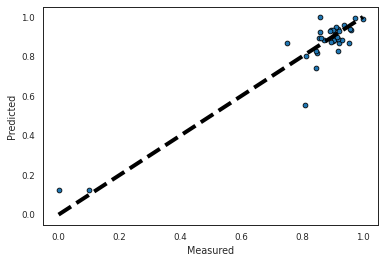

In [1895]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity


<AxesSubplot:xlabel='elasticity', ylabel='feature'>

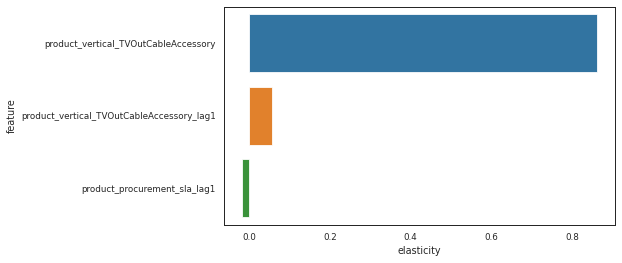

In [1896]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)


plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

## Distributed Lag Model(Multiplicative) for Home Audio


Splitting the Dataframe into Training and Testing Set

In [1897]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(home_dis_mul_df, train_size = 0.7, test_size = 0.3, random_state = 100)

Rescaling the Features

In [1898]:
scaler = MinMaxScaler()

In [1899]:
num_vars= home_dis_mul_df.columns

In [1900]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [1901]:
y_train = df_train.pop('gmv')
X_train = df_train

In [1903]:
# Running RFE for selecting top 20 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [1904]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['order_payment_type_Prepaid', 'is_mass_market', 'product_vertical_HiFiSystem', 'product_vertical_HomeAudioSpeaker', 'TV', 'TV_SMA_5', 'TV_SMA_5_lag1', 'Content Marketing', 'Content Marketing_SMA_5_lag2', 'Online marketing', 'Affiliates_SMA_3_lag2', 'Affiliates_SMA_5', 'Radio_lag3', 'NPS', 'NPS_SMA_3_lag2', 'NPS_SMA_5', 'Stock Index_SMA_3_lag2', 'Stock Index_SMA_3_lag3', 'Stock Index_SMA_5', 'Stock Index_SMA_5_lag1'], dtype='object')

In [1905]:
# neglecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['gmv_lag1', 'gmv_lag2', 'gmv_lag3', 'Discount%', 'Discount%_lag1', 'Discount%_lag2', 'Discount%_lag3', 'deliverybdays', 'deliverybdays_lag1', 'deliverybdays_lag2',
       ...
       'Total Snow (cm)_lag2', 'Total Snow (cm)_lag3', 'Total Precip (mm)', 'Total Precip (mm)_lag1', 'Total Precip (mm)_lag2', 'Total Precip (mm)_lag3', 'Snow on Grnd (cm)', 'Snow on Grnd (cm)_lag1', 'Snow on Grnd (cm)_lag2', 'Snow on Grnd (cm)_lag3'], dtype='object', length=315)

In [1906]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [1907]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3050.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.89e-19
Time:                        10:42:56   Log-Likelihood:                 153.44
No. Observations:                  33   AIC:                            -264.9
Df Residuals:                      12   BIC:                            -233.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features      VIF
19                  Stock Index_SMA_5 72764.80
16                          NPS_SMA_5 67906.64
17             Stock Index_SMA_3_lag2 63143.07
15                     NPS_SMA_3_lag2 57378.86
18             Stock Index_SMA_3_lag3 47071.21
20             Stock Index_SMA_5_lag1 34451.58
0                               const 11209.56
10                   Online marketing  1039.97
2                      is_mass_market   776.76
6                            TV_SMA_5   708.16
7                       TV_SMA_5_lag1   426.07
4   product_vertical_HomeAudioSpeaker   292.94
5                                  TV   256.98
12                   Affiliates_SMA_5   228.76
1          order_payment_type_Prepaid   183.52
14                                NPS    87.59
11              Affiliates_SMA_3_lag2    60.26
8                   Content Marketing    34.86
13                         Radio_lag3    16.83
9        Content Marketing_SMA_5_lag2    13.45
3         product_vertical_HiFiSystem     9.95

In [1908]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS_SMA_3_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     3454.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.97e-21
Time:                        10:50:53   Log-Likelihood:                 153.32
No. Observations:                  33   AIC:                            -266.6
Df Residuals:                      13   BIC:                            -236.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features      VIF
18                  Stock Index_SMA_5 70376.20
16             Stock Index_SMA_3_lag2 61891.65
17             Stock Index_SMA_3_lag3 46791.58
19             Stock Index_SMA_5_lag1 33946.07
0                               const 10484.72
15                          NPS_SMA_5  7309.80
10                   Online marketing  1029.17
2                      is_mass_market   733.83
6                            TV_SMA_5   705.60
7                       TV_SMA_5_lag1   416.05
4   product_vertical_HomeAudioSpeaker   285.42
5                                  TV   256.86
1          order_payment_type_Prepaid   183.02
12                   Affiliates_SMA_5   164.17
14                                NPS    83.48
11              Affiliates_SMA_3_lag2    55.46
8                   Content Marketing    34.15
13                         Radio_lag3    16.09
9        Content Marketing_SMA_5_lag2    12.02
3         product_vertical_HiFiSystem     9.77

In [1909]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2471.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.96e-21
Time:                        10:51:32   Log-Likelihood:                 145.69
No. Observations:                  33   AIC:                            -253.4
Df Residuals:                      14   BIC:                            -224.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features      VIF
17             Stock Index_SMA_3_lag3 15448.47
18             Stock Index_SMA_5_lag1 11204.73
0                               const  8444.66
16             Stock Index_SMA_3_lag2  7581.85
15                          NPS_SMA_5  4579.20
10                   Online marketing   920.46
2                      is_mass_market   733.46
6                            TV_SMA_5   518.12
7                       TV_SMA_5_lag1   299.26
4   product_vertical_HomeAudioSpeaker   285.40
1          order_payment_type_Prepaid   181.94
5                                  TV   166.04
12                   Affiliates_SMA_5   163.94
14                                NPS    78.14
8                   Content Marketing    29.19
11              Affiliates_SMA_3_lag2    27.98
13                         Radio_lag3    15.04
3         product_vertical_HiFiSystem     8.38
9        Content Marketing_SMA_5_lag2     6.19

In [1910]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["product_vertical_HiFiSystem"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2803.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.59e-23
Time:                        10:52:40   Log-Likelihood:                 145.68
No. Observations:                  33   AIC:                            -255.4
Df Residuals:                      15   BIC:                            -228.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features      VIF
16             Stock Index_SMA_3_lag3 15441.27
17             Stock Index_SMA_5_lag1 11182.13
0                               const  8363.65
15             Stock Index_SMA_3_lag2  7539.56
14                          NPS_SMA_5  4532.60
9                    Online marketing   888.26
2                      is_mass_market   666.66
5                            TV_SMA_5   516.82
6                       TV_SMA_5_lag1   299.14
3   product_vertical_HomeAudioSpeaker   257.25
4                                  TV   164.81
11                   Affiliates_SMA_5   162.96
1          order_payment_type_Prepaid   158.23
13                                NPS    77.58
7                   Content Marketing    29.18
10              Affiliates_SMA_3_lag2    27.24
12                         Radio_lag3    12.51
8        Content Marketing_SMA_5_lag2     5.73

In [1911]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_3_lag3"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3174.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           6.22e-25
Time:                        10:53:16   Log-Likelihood:                 145.67
No. Observations:                  33   AIC:                            -257.3
Df Residuals:                      16   BIC:                            -231.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
15             Stock Index_SMA_3_lag2 6720.28
0                               const 6685.92
14                          NPS_SMA_5 4458.89
16             Stock Index_SMA_5_lag1 1842.75
9                    Online marketing  838.64
2                      is_mass_market  666.66
5                            TV_SMA_5  400.16
6                       TV_SMA_5_lag1  245.87
3   product_vertical_HomeAudioSpeaker  218.25
11                   Affiliates_SMA_5  162.84
4                                  TV  160.92
1          order_payment_type_Prepaid  139.86
13                                NPS   77.06
10              Affiliates_SMA_3_lag2   26.83
7                   Content Marketing   24.90
12                         Radio_lag3   11.09
8        Content Marketing_SMA_5_lag2    5.29

In [1912]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV_SMA_5_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3597.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.01e-26
Time:                        10:53:54   Log-Likelihood:                 145.67
No. Observations:                  33   AIC:                            -259.3
Df Residuals:                      17   BIC:                            -235.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
14             Stock Index_SMA_3_lag2 4906.44
0                               const 4121.29
13                          NPS_SMA_5 4062.99
15             Stock Index_SMA_5_lag1 1073.43
8                    Online marketing  669.75
2                      is_mass_market  500.04
3   product_vertical_HomeAudioSpeaker  179.26
10                   Affiliates_SMA_5  156.69
1          order_payment_type_Prepaid  120.89
12                                NPS   71.90
5                            TV_SMA_5   41.19
4                                  TV   26.51
6                   Content Marketing   23.91
9               Affiliates_SMA_3_lag2   20.71
11                         Radio_lag3    9.69
7        Content Marketing_SMA_5_lag2    4.42

In [1913]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4060.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.59e-28
Time:                        10:54:46   Log-Likelihood:                 145.59
No. Observations:                  33   AIC:                            -261.2
Df Residuals:                      18   BIC:                            -238.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
0                               const 2616.21
14             Stock Index_SMA_5_lag1 1014.50
8                    Online marketing  510.47
2                      is_mass_market  363.39
13             Stock Index_SMA_3_lag2  247.87
3   product_vertical_HomeAudioSpeaker  141.38
10                   Affiliates_SMA_5  114.49
1          order_payment_type_Prepaid   97.72
5                            TV_SMA_5   29.91
4                                  TV   25.88
6                   Content Marketing   23.27
9               Affiliates_SMA_3_lag2   20.71
12                                NPS   18.78
11                         Radio_lag3    7.61
7        Content Marketing_SMA_5_lag2    4.39

In [1914]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_3_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4486.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.98e-30
Time:                        10:55:53   Log-Likelihood:                 145.11
No. Observations:                  33   AIC:                            -262.2
Df Residuals:                      19   BIC:                            -241.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
0                               const 2194.51
13             Stock Index_SMA_5_lag1  902.48
2                      is_mass_market  334.72
8                    Online marketing  279.71
12             Stock Index_SMA_3_lag2  244.67
3   product_vertical_HomeAudioSpeaker  137.27
1          order_payment_type_Prepaid   92.63
5                            TV_SMA_5   29.88
4                                  TV   25.87
9                    Affiliates_SMA_5   22.22
6                   Content Marketing   20.18
11                                NPS   17.32
10                         Radio_lag3    6.93
7        Content Marketing_SMA_5_lag2    1.96

In [1915]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["NPS"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4087.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.80e-31
Time:                        10:57:00   Log-Likelihood:                 141.41
No. Observations:                  33   AIC:                            -256.8
Df Residuals:                      20   BIC:                            -237.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
0                               const 1565.03
12             Stock Index_SMA_5_lag1  900.77
8                    Online marketing  266.14
2                      is_mass_market  250.80
11             Stock Index_SMA_3_lag2  241.07
3   product_vertical_HomeAudioSpeaker  123.85
1          order_payment_type_Prepaid   59.07
4                                  TV   25.74
5                            TV_SMA_5   23.70
6                   Content Marketing   19.71
9                    Affiliates_SMA_5   17.91
10                         Radio_lag3    6.19
7        Content Marketing_SMA_5_lag2    1.95

In [1916]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4078.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.28e-32
Time:                        10:58:09   Log-Likelihood:                 139.13
No. Observations:                  33   AIC:                            -254.3
Df Residuals:                      21   BIC:                            -236.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
0                               const 1558.67
11             Stock Index_SMA_5_lag1  872.73
7                    Online marketing  249.59
2                      is_mass_market  241.93
10             Stock Index_SMA_3_lag2  241.05
3   product_vertical_HomeAudioSpeaker  122.02
1          order_payment_type_Prepaid   46.29
4                                  TV   21.51
5                   Content Marketing   19.64
8                    Affiliates_SMA_5    8.92
9                          Radio_lag3    5.45
6        Content Marketing_SMA_5_lag2    1.90

In [1917]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Content Marketing_SMA_5_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4183.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.15e-33
Time:                        10:59:08   Log-Likelihood:                 137.22
No. Observations:                  33   AIC:                            -252.4
Df Residuals:                      22   BIC:                            -236.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features     VIF
0                               const 1547.91
10             Stock Index_SMA_5_lag1  864.29
6                    Online marketing  249.53
9              Stock Index_SMA_3_lag2  240.20
2                      is_mass_market  239.71
3   product_vertical_HomeAudioSpeaker  122.02
1          order_payment_type_Prepaid   43.34
4                                  TV   20.43
5                   Content Marketing   19.15
7                    Affiliates_SMA_5    8.92
8                          Radio_lag3    5.44

In [1918]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_5_lag1"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2160.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.77e-31
Time:                        11:00:08   Log-Likelihood:                 123.85
No. Observations:                  33   AIC:                            -227.7
Df Residuals:                      23   BIC:                            -212.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 305.02
3  product_vertical_HomeAudioSpeaker 119.62
2                     is_mass_market 118.78
6                   Online marketing  41.90
4                                 TV  20.25
1         order_payment_type_Prepaid  15.48
9             Stock Index_SMA_3_lag2  14.51
7                   Affiliates_SMA_5   5.97
5                  Content Marketing   4.07
8                         Radio_lag3   1.85

In [1919]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Affiliates_SMA_5"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2533.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.40e-33
Time:                        11:01:35   Log-Likelihood:                 123.84
No. Observations:                  33   AIC:                            -229.7
Df Residuals:                      24   BIC:                            -216.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 251.20
3  product_vertical_HomeAudioSpeaker 114.39
2                     is_mass_market 114.30
6                   Online marketing  33.89
4                                 TV  20.25
1         order_payment_type_Prepaid  15.33
8             Stock Index_SMA_3_lag2  11.86
5                  Content Marketing   3.76
7                         Radio_lag3   1.84

In [1920]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Online marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2923.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           8.74e-35
Time:                        11:02:33   Log-Likelihood:                 123.32
No. Observations:                  33   AIC:                            -230.6
Df Residuals:                      25   BIC:                            -218.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
0                              const 158.20
2                     is_mass_market 110.26
3  product_vertical_HomeAudioSpeaker  96.62
1         order_payment_type_Prepaid  15.30
4                                 TV  12.37
7             Stock Index_SMA_3_lag2   5.63
5                  Content Marketing   3.30
6                         Radio_lag3   1.81

In [1921]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Stock Index_SMA_3_lag2"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3439.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.08e-36
Time:                        11:03:20   Log-Likelihood:                 122.81
No. Observations:                  33   AIC:                            -231.6
Df Residuals:                      26   BIC:                            -221.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
2                     is_mass_market 100.71
3  product_vertical_HomeAudioSpeaker  89.68
0                              const  43.94
1         order_payment_type_Prepaid   9.82
4                                 TV   2.89
5                  Content Marketing   2.19
6                         Radio_lag3   1.81

In [1922]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["Content Marketing"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3472.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           5.12e-37
Time:                        11:04:38   Log-Likelihood:                 119.34
No. Observations:                  33   AIC:                            -226.7
Df Residuals:                      27   BIC:                            -217.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features    VIF
2                     is_mass_market 100.01
3  product_vertical_HomeAudioSpeaker  86.85
0                              const  35.69
1         order_payment_type_Prepaid   8.93
4                                 TV   2.80
5                         Radio_lag3   1.34

In [1923]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["is_mass_market"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1143.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.43e-30
Time:                        11:05:28   Log-Likelihood:                 96.802
No. Observations:                  33   AIC:                            -183.6
Df Residuals:                      28   BIC:                            -176.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 35.62
1         order_payment_type_Prepaid  8.18
2  product_vertical_HomeAudioSpeaker  6.49
3                                 TV  2.72
4                         Radio_lag3  1.33

In [1924]:
# drop feature  with higest p-value
X_train_rfe =X_train_rfe.drop(["TV"], axis = 1)
 # Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    # Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1557.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           4.01e-32
Time:                        11:05:59   Log-Likelihood:                 96.578
No. Observations:                  33   AIC:                            -185.2
Df Residuals:                      29   BIC:                            -179.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Features   VIF
0                              const 35.62
1         order_payment_type_Prepaid  6.62
2  product_vertical_HomeAudioSpeaker  6.49
3                         Radio_lag3  1.32

In [1925]:
X_train_rfe.columns

Index(['order_payment_type_Prepaid', 'product_vertical_HomeAudioSpeaker', 'Radio_lag3'], dtype='object')

In [1926]:
drop_columns_list = list(set(num_vars) - set(list(X_train_rfe.columns)))
print(drop_columns_list)

['Radio_EMA_8_lag3', 'TV_SMA_5_lag2', 'Online marketing', 'Digital_EMA_8_lag3', 'SEM_Ad_Stock_lag2', 'SEM_SMA_5_lag3', 'product_vertical_DockingStation_lag2', 'TV_SMA_3_lag2', 'TV_SMA_3_lag1', 'Online marketing_lag1', 'Radio_EMA_8', 'Stock Index_lag1', 'Cool Deg Days_lag1', 'gmv_lag2', 'Stock Index_SMA_3_lag1', 'Digital_EMA_8_lag1', 'SEM_SMA_5', 'Sponsorship_SMA_3_lag1', 'product_vertical_HomeAudioSpeaker_lag2', 'pay_week', 'Other_SMA_5_lag3', 'Stock Index_SMA_5', 'Sponsorship_EMA_8', 'Affiliates_SMA_5', 'Online_marketing_Ad_Stock_lag1', 'TV_lag3', 'TV', 'TV_Ad_Stock_lag2', 'SEM_Ad_Stock_lag3', 'Content Marketing_EMA_8_lag1', 'deliverybdays_lag2', 'Sponsorship_lag2', 'Heat Deg Days', 'Mean Temp_lag1', 'product_vertical_Dock', 'Total Precip (mm)', 'Total Precip (mm)_lag1', 'product_vertical_DockingStation_lag1', 'Discount%_lag3', 'Other_Ad_Stock_lag1', 'Sponsorship_SMA_5', 'Snow on Grnd (cm)_lag2', 'is_mass_market_lag2', 'gmv', 'sla_lag2', 'gmv_lag3', 'Max Temp_lag3', 'Affiliates_Ad_Sto

In [1927]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
lm=LinearRegression()
scores = cross_val_score(lm, X_train_rfe, y_train, scoring='r2', cv=folds)
scores

array([ 0.24463996, -0.65525013,  0.87987879,  0.94485254,  0.27720331,
        0.28626578,  0.3543044 ,  0.88181033,  0.33438512,  0.38478752])

In [1928]:
y_pred = cross_val_predict(lm, X_train_rfe, y_train, cv=folds)

In [1929]:
mse = mean_squared_error(y_train, y_pred)
r_squared = r2_score(y_train, y_pred)
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.002071565221753225
r_square_value : 0.9239410759379947


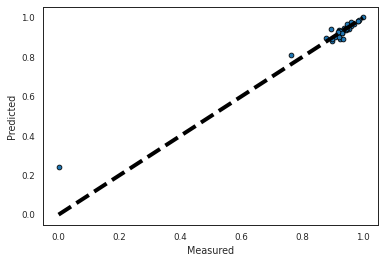

In [1930]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Elasticity Analysis - Home Audio - Distributed Lag Model (Multiplicative)


<AxesSubplot:xlabel='elasticity', ylabel='feature'>

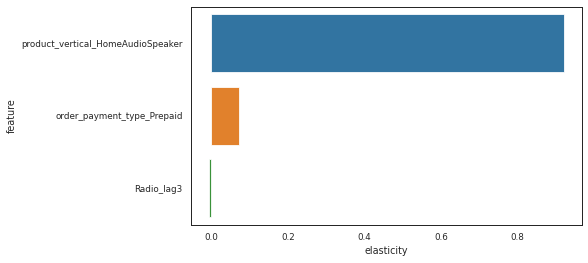

In [1931]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_rfe, y_train, coefficients_df)


plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

# Step 5: Recommendations and Results

**Camera Accessory**
1.   Simple Linear Model is selected as the best model based on the high Adjusted R-square = 0.947 and low MSE = 0.0037 values.
2.   ElecKart should focus more on the CameraBag, CameraBattery, CameraTripod and Flash through Online marketing. The company can promote these products or pitch in more products in these categories



**Gaming Accessory**


1.   Distributive lag Additive Model is selected as the best model based on high R-square = 0.98 and low MSE values= 0.0006 
2.   The sale of GamingAccessoryKit through order payment type Prepaid in mass market has positive impact on the GMV value



**Home Audio**


1.   Distributed Lag Model (Additive) is selected as the best model based highest R- square = 0.983 and low MSE values = 0.00106.
2.   The sale of HomeAudioSpeaker and FMRadio has positive impact on the GMV value. Hence, the company should promote these products or pitch in more products in these categories.

